## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1096, 715)
Hypercube shape: (1096, 715, 102)


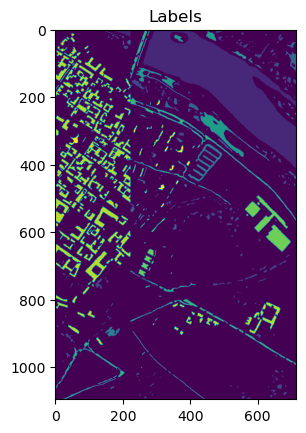

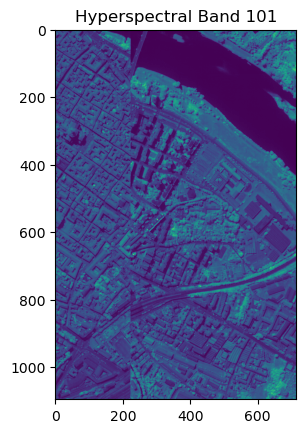

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Pavia_gt.mat'
data_files = 'Pavia.mat'
label_files = 'pavia_gt'
hypercube_files = 'pavia'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 148152
Extracted windows shape: (148152, 5, 5, 102)
Corresponding labels shape: (148152,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 20)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 65971 samples
Shuffled class indices for class '1'
Selected 20 training samples and 5 validation samples for class '1'

Class: 2: Found 7598 samples
Shuffled class indices for class '2'
Selected 20 training samples and 5 validation samples for class '2'

Class: 3: Found 3090 samples
Shuffled class indices for class '3'
Selected 20 training samples and 5 validation samples for class '3'

Class: 4: Found 2685 samples
Shuffled class indices for class '4'
Selected 20 training samples and 5 validation samples for class '4'

Class: 5: Found 6584 samples
Shuffled class indices for class '5'
Selected 20 training samples and 5 validation samples for class '5'

Class: 6: Found 9248 samples
Shuffled class indices for class '6'
Selected 20 training samples and 5 validation samples for class '6'

Class: 7: Found 7287 samples
Shuffled class indices for class '7'
Selected 20 train


 -- Test set created with: 
	147927 samples
	shape (147927, 5, 5, 102) --




All datasets saved to the 'indices' folder.
(180, 5, 5, 102)
(45, 5, 5, 102)
(147927, 5, 5, 102)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 180
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (118521, 5, 5, 102)
Validation data shape: (29631, 5, 5, 102)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

102


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/1852], Loss: 0.1564, PSNR: 2.9765


	 Training Batch [200/1852], Loss: 0.0860, PSNR: 8.5431


	 Training Batch [400/1852], Loss: 0.0501, PSNR: 7.5439


	 Training Batch [600/1852], Loss: 0.0245, PSNR: 12.5455


	 Training Batch [800/1852], Loss: 0.0153, PSNR: 13.7428


	 Training Batch [1000/1852], Loss: 0.0121, PSNR: 15.5839


	 Training Batch [1200/1852], Loss: 0.0087, PSNR: 15.6896


	 Training Batch [1400/1852], Loss: 0.0079, PSNR: 17.7109


	 Training Batch [1600/1852], Loss: 0.0087, PSNR: 17.1470


	 Training Batch [1800/1852], Loss: 0.0062, PSNR: 17.5813


Epoch [1/50] Training Loss: 0.0322, PSNR: 13.7457
	[Val]   Batch [1/463] Loss: 0.0053, PSNR: 18.0097
	[Val]   Batch [10/463] Loss: 0.0049, PSNR: 19.1650
	[Val]   Batch [20/463] Loss: 0.0049, PSNR: 18.1806
	[Val]   Batch [30/463] Loss: 0.0060, PSNR: 18.7351
	[Val]   Batch [40/463] Loss: 0.0047, PSNR: 17.8778
	[Val]   Batch [50/463] Loss: 0.0050, PSNR: 18.0825
	[Val]   Batch [60/463] Loss: 0.0047, PSNR: 18.1289


	[Val]   Batch [70/463] Loss: 0.0067, PSNR: 18.4639
	[Val]   Batch [80/463] Loss: 0.0059, PSNR: 20.3823
	[Val]   Batch [90/463] Loss: 0.0057, PSNR: 19.4723
	[Val]   Batch [100/463] Loss: 0.0058, PSNR: 19.1823
	[Val]   Batch [110/463] Loss: 0.0068, PSNR: 18.5848
	[Val]   Batch [120/463] Loss: 0.0046, PSNR: 18.1179
	[Val]   Batch [130/463] Loss: 0.0054, PSNR: 19.4932


	[Val]   Batch [140/463] Loss: 0.0063, PSNR: 19.0529
	[Val]   Batch [150/463] Loss: 0.0072, PSNR: 19.0738
	[Val]   Batch [160/463] Loss: 0.0057, PSNR: 19.3458
	[Val]   Batch [170/463] Loss: 0.0074, PSNR: 18.2803
	[Val]   Batch [180/463] Loss: 0.0054, PSNR: 19.0733
	[Val]   Batch [190/463] Loss: 0.0059, PSNR: 19.4009
	[Val]   Batch [200/463] Loss: 0.0058, PSNR: 18.7987


	[Val]   Batch [210/463] Loss: 0.0057, PSNR: 18.3877
	[Val]   Batch [220/463] Loss: 0.0056, PSNR: 19.6173
	[Val]   Batch [230/463] Loss: 0.0066, PSNR: 19.4349
	[Val]   Batch [240/463] Loss: 0.0050, PSNR: 18.2515
	[Val]   Batch [250/463] Loss: 0.0064, PSNR: 17.4252
	[Val]   Batch [260/463] Loss: 0.0056, PSNR: 18.4406
	[Val]   Batch [270/463] Loss: 0.0043, PSNR: 17.6409
	[Val]   Batch [280/463] Loss: 0.0053, PSNR: 20.3260


	[Val]   Batch [290/463] Loss: 0.0058, PSNR: 17.3338
	[Val]   Batch [300/463] Loss: 0.0059, PSNR: 19.5784
	[Val]   Batch [310/463] Loss: 0.0054, PSNR: 19.4836
	[Val]   Batch [320/463] Loss: 0.0055, PSNR: 19.3422
	[Val]   Batch [330/463] Loss: 0.0064, PSNR: 18.7339
	[Val]   Batch [340/463] Loss: 0.0052, PSNR: 19.6787
	[Val]   Batch [350/463] Loss: 0.0069, PSNR: 19.5789
	[Val]   Batch [360/463] Loss: 0.0046, PSNR: 20.5459


	[Val]   Batch [370/463] Loss: 0.0068, PSNR: 18.6651
	[Val]   Batch [380/463] Loss: 0.0066, PSNR: 18.8092
	[Val]   Batch [390/463] Loss: 0.0061, PSNR: 18.6346
	[Val]   Batch [400/463] Loss: 0.0054, PSNR: 17.6882
	[Val]   Batch [410/463] Loss: 0.0052, PSNR: 20.0120
	[Val]   Batch [420/463] Loss: 0.0054, PSNR: 18.7981
	[Val]   Batch [430/463] Loss: 0.0053, PSNR: 18.2267


	[Val]   Batch [440/463] Loss: 0.0052, PSNR: 19.2073
	[Val]   Batch [450/463] Loss: 0.0040, PSNR: 16.6026
	[Val]   Batch [460/463] Loss: 0.0057, PSNR: 17.9495
Epoch [1/50] Validation Loss: 0.0056, PSNR: 18.7741

LOG: Epoch [2/50]
	 Training Batch [1/1852], Loss: 0.0072, PSNR: 18.6999


	 Training Batch [200/1852], Loss: 0.0059, PSNR: 18.9381


	 Training Batch [400/1852], Loss: 0.0042, PSNR: 18.7282


	 Training Batch [600/1852], Loss: 0.0047, PSNR: 19.9483


	 Training Batch [800/1852], Loss: 0.0045, PSNR: 20.1667


	 Training Batch [1000/1852], Loss: 0.0038, PSNR: 22.0458


	 Training Batch [1200/1852], Loss: 0.0033, PSNR: 21.3572


	 Training Batch [1400/1852], Loss: 0.0038, PSNR: 20.8914


	 Training Batch [1600/1852], Loss: 0.0037, PSNR: 21.4580


	 Training Batch [1800/1852], Loss: 0.0031, PSNR: 21.4927


Epoch [2/50] Training Loss: 0.0043, PSNR: 20.0867
	[Val]   Batch [1/463] Loss: 0.0026, PSNR: 21.1274
	[Val]   Batch [10/463] Loss: 0.0024, PSNR: 22.3581
	[Val]   Batch [20/463] Loss: 0.0023, PSNR: 21.4572
	[Val]   Batch [30/463] Loss: 0.0030, PSNR: 21.7144
	[Val]   Batch [40/463] Loss: 0.0023, PSNR: 21.0295
	[Val]   Batch [50/463] Loss: 0.0024, PSNR: 21.2083
	[Val]   Batch [60/463] Loss: 0.0023, PSNR: 21.3008


	[Val]   Batch [70/463] Loss: 0.0035, PSNR: 21.3190
	[Val]   Batch [80/463] Loss: 0.0031, PSNR: 23.2253
	[Val]   Batch [90/463] Loss: 0.0028, PSNR: 22.5560
	[Val]   Batch [100/463] Loss: 0.0031, PSNR: 21.9645
	[Val]   Batch [110/463] Loss: 0.0035, PSNR: 21.4768
	[Val]   Batch [120/463] Loss: 0.0022, PSNR: 21.2888
	[Val]   Batch [130/463] Loss: 0.0026, PSNR: 22.6222
	[Val]   Batch [140/463] Loss: 0.0032, PSNR: 21.9686


	[Val]   Batch [150/463] Loss: 0.0036, PSNR: 22.0412
	[Val]   Batch [160/463] Loss: 0.0030, PSNR: 22.1258
	[Val]   Batch [170/463] Loss: 0.0039, PSNR: 21.0758
	[Val]   Batch [180/463] Loss: 0.0029, PSNR: 21.7918
	[Val]   Batch [190/463] Loss: 0.0029, PSNR: 22.4698
	[Val]   Batch [200/463] Loss: 0.0030, PSNR: 21.7562
	[Val]   Batch [210/463] Loss: 0.0030, PSNR: 21.0950


	[Val]   Batch [220/463] Loss: 0.0029, PSNR: 22.4820
	[Val]   Batch [230/463] Loss: 0.0033, PSNR: 22.4672
	[Val]   Batch [240/463] Loss: 0.0025, PSNR: 21.3194
	[Val]   Batch [250/463] Loss: 0.0033, PSNR: 20.3133
	[Val]   Batch [260/463] Loss: 0.0029, PSNR: 21.3788
	[Val]   Batch [270/463] Loss: 0.0020, PSNR: 20.9604
	[Val]   Batch [280/463] Loss: 0.0026, PSNR: 23.3801
	[Val]   Batch [290/463] Loss: 0.0029, PSNR: 20.4265


	[Val]   Batch [300/463] Loss: 0.0030, PSNR: 22.5549
	[Val]   Batch [310/463] Loss: 0.0029, PSNR: 22.2446
	[Val]   Batch [320/463] Loss: 0.0028, PSNR: 22.2894
	[Val]   Batch [330/463] Loss: 0.0031, PSNR: 21.8343
	[Val]   Batch [340/463] Loss: 0.0026, PSNR: 22.6799
	[Val]   Batch [350/463] Loss: 0.0037, PSNR: 22.2482
	[Val]   Batch [360/463] Loss: 0.0024, PSNR: 23.3324


	[Val]   Batch [370/463] Loss: 0.0034, PSNR: 21.6957
	[Val]   Batch [380/463] Loss: 0.0032, PSNR: 21.9828
	[Val]   Batch [390/463] Loss: 0.0030, PSNR: 21.7641
	[Val]   Batch [400/463] Loss: 0.0027, PSNR: 20.6133
	[Val]   Batch [410/463] Loss: 0.0025, PSNR: 23.1951
	[Val]   Batch [420/463] Loss: 0.0026, PSNR: 21.9192
	[Val]   Batch [430/463] Loss: 0.0027, PSNR: 21.1229


	[Val]   Batch [440/463] Loss: 0.0027, PSNR: 22.1141
	[Val]   Batch [450/463] Loss: 0.0020, PSNR: 19.7239
	[Val]   Batch [460/463] Loss: 0.0028, PSNR: 21.0719
Epoch [2/50] Validation Loss: 0.0028, PSNR: 21.7946

LOG: Epoch [3/50]
	 Training Batch [1/1852], Loss: 0.0029, PSNR: 21.7614


	 Training Batch [200/1852], Loss: 0.0033, PSNR: 22.0818


	 Training Batch [400/1852], Loss: 0.0030, PSNR: 20.9772


	 Training Batch [600/1852], Loss: 0.0028, PSNR: 22.0241


	 Training Batch [800/1852], Loss: 0.0024, PSNR: 23.1672


	 Training Batch [1000/1852], Loss: 0.0020, PSNR: 24.8350


	 Training Batch [1200/1852], Loss: 0.0022, PSNR: 22.7735


	 Training Batch [1400/1852], Loss: 0.0020, PSNR: 22.5280


	 Training Batch [1600/1852], Loss: 0.0018, PSNR: 24.4858


	 Training Batch [1800/1852], Loss: 0.0022, PSNR: 22.4133


Epoch [3/50] Training Loss: 0.0023, PSNR: 22.7403
	[Val]   Batch [1/463] Loss: 0.0015, PSNR: 23.3362
	[Val]   Batch [10/463] Loss: 0.0014, PSNR: 24.5011
	[Val]   Batch [20/463] Loss: 0.0014, PSNR: 23.6818
	[Val]   Batch [30/463] Loss: 0.0017, PSNR: 24.2691
	[Val]   Batch [40/463] Loss: 0.0015, PSNR: 22.8918
	[Val]   Batch [50/463] Loss: 0.0015, PSNR: 23.1998


	[Val]   Batch [60/463] Loss: 0.0014, PSNR: 23.2445
	[Val]   Batch [70/463] Loss: 0.0019, PSNR: 23.8410
	[Val]   Batch [80/463] Loss: 0.0017, PSNR: 25.7374
	[Val]   Batch [90/463] Loss: 0.0017, PSNR: 24.8178
	[Val]   Batch [100/463] Loss: 0.0018, PSNR: 24.3655
	[Val]   Batch [110/463] Loss: 0.0019, PSNR: 24.0229
	[Val]   Batch [120/463] Loss: 0.0014, PSNR: 23.1414


	[Val]   Batch [130/463] Loss: 0.0015, PSNR: 25.1139
	[Val]   Batch [140/463] Loss: 0.0018, PSNR: 24.4129
	[Val]   Batch [150/463] Loss: 0.0019, PSNR: 24.8339
	[Val]   Batch [160/463] Loss: 0.0019, PSNR: 24.0914
	[Val]   Batch [170/463] Loss: 0.0023, PSNR: 23.4096
	[Val]   Batch [180/463] Loss: 0.0018, PSNR: 23.9378
	[Val]   Batch [190/463] Loss: 0.0017, PSNR: 24.8659
	[Val]   Batch [200/463] Loss: 0.0017, PSNR: 24.2080


	[Val]   Batch [210/463] Loss: 0.0019, PSNR: 23.1206
	[Val]   Batch [220/463] Loss: 0.0018, PSNR: 24.5841
	[Val]   Batch [230/463] Loss: 0.0017, PSNR: 25.4433
	[Val]   Batch [240/463] Loss: 0.0015, PSNR: 23.5319
	[Val]   Batch [250/463] Loss: 0.0020, PSNR: 22.4351
	[Val]   Batch [260/463] Loss: 0.0018, PSNR: 23.4624
	[Val]   Batch [270/463] Loss: 0.0013, PSNR: 22.8080


	[Val]   Batch [280/463] Loss: 0.0016, PSNR: 25.5452
	[Val]   Batch [290/463] Loss: 0.0017, PSNR: 22.7077
	[Val]   Batch [300/463] Loss: 0.0018, PSNR: 24.6510
	[Val]   Batch [310/463] Loss: 0.0019, PSNR: 24.0757
	[Val]   Batch [320/463] Loss: 0.0016, PSNR: 24.5549
	[Val]   Batch [330/463] Loss: 0.0017, PSNR: 24.4011
	[Val]   Batch [340/463] Loss: 0.0016, PSNR: 24.8719


	[Val]   Batch [350/463] Loss: 0.0022, PSNR: 24.5863
	[Val]   Batch [360/463] Loss: 0.0017, PSNR: 24.7417
	[Val]   Batch [370/463] Loss: 0.0019, PSNR: 24.2690
	[Val]   Batch [380/463] Loss: 0.0017, PSNR: 24.8080
	[Val]   Batch [390/463] Loss: 0.0016, PSNR: 24.4189
	[Val]   Batch [400/463] Loss: 0.0017, PSNR: 22.5690
	[Val]   Batch [410/463] Loss: 0.0015, PSNR: 25.3961
	[Val]   Batch [420/463] Loss: 0.0016, PSNR: 24.2124


	[Val]   Batch [430/463] Loss: 0.0018, PSNR: 22.9967
	[Val]   Batch [440/463] Loss: 0.0017, PSNR: 24.1565
	[Val]   Batch [450/463] Loss: 0.0014, PSNR: 21.2763
	[Val]   Batch [460/463] Loss: 0.0017, PSNR: 23.2689
Epoch [3/50] Validation Loss: 0.0017, PSNR: 24.0533

LOG: Epoch [4/50]
	 Training Batch [1/1852], Loss: 0.0017, PSNR: 23.5586


	 Training Batch [200/1852], Loss: 0.0019, PSNR: 22.9984


	 Training Batch [400/1852], Loss: 0.0018, PSNR: 23.6489


	 Training Batch [600/1852], Loss: 0.0016, PSNR: 24.7010


	 Training Batch [800/1852], Loss: 0.0015, PSNR: 23.8576


	 Training Batch [1000/1852], Loss: 0.0018, PSNR: 23.4751


	 Training Batch [1200/1852], Loss: 0.0016, PSNR: 24.5055


	 Training Batch [1400/1852], Loss: 0.0014, PSNR: 24.8001


	 Training Batch [1600/1852], Loss: 0.0012, PSNR: 25.1433


	 Training Batch [1800/1852], Loss: 0.0016, PSNR: 25.6569


Epoch [4/50] Training Loss: 0.0016, PSNR: 24.4980
	[Val]   Batch [1/463] Loss: 0.0011, PSNR: 24.9253
	[Val]   Batch [10/463] Loss: 0.0010, PSNR: 26.2240
	[Val]   Batch [20/463] Loss: 0.0009, PSNR: 25.4442
	[Val]   Batch [30/463] Loss: 0.0011, PSNR: 26.0168
	[Val]   Batch [40/463] Loss: 0.0010, PSNR: 24.4031
	[Val]   Batch [50/463] Loss: 0.0011, PSNR: 24.8067


	[Val]   Batch [60/463] Loss: 0.0010, PSNR: 24.8039
	[Val]   Batch [70/463] Loss: 0.0013, PSNR: 25.5926
	[Val]   Batch [80/463] Loss: 0.0011, PSNR: 27.7469
	[Val]   Batch [90/463] Loss: 0.0011, PSNR: 26.5913
	[Val]   Batch [100/463] Loss: 0.0012, PSNR: 26.0950
	[Val]   Batch [110/463] Loss: 0.0013, PSNR: 25.8920
	[Val]   Batch [120/463] Loss: 0.0010, PSNR: 24.7742


	[Val]   Batch [130/463] Loss: 0.0010, PSNR: 26.8987
	[Val]   Batch [140/463] Loss: 0.0012, PSNR: 26.1688
	[Val]   Batch [150/463] Loss: 0.0012, PSNR: 26.8431
	[Val]   Batch [160/463] Loss: 0.0014, PSNR: 25.6168
	[Val]   Batch [170/463] Loss: 0.0016, PSNR: 25.0066
	[Val]   Batch [180/463] Loss: 0.0012, PSNR: 25.5440
	[Val]   Batch [190/463] Loss: 0.0011, PSNR: 26.5856


	[Val]   Batch [200/463] Loss: 0.0011, PSNR: 26.1763
	[Val]   Batch [210/463] Loss: 0.0013, PSNR: 24.6507
	[Val]   Batch [220/463] Loss: 0.0012, PSNR: 26.1532
	[Val]   Batch [230/463] Loss: 0.0010, PSNR: 27.5320
	[Val]   Batch [240/463] Loss: 0.0010, PSNR: 25.2364
	[Val]   Batch [250/463] Loss: 0.0014, PSNR: 24.0257
	[Val]   Batch [260/463] Loss: 0.0013, PSNR: 24.9579
	[Val]   Batch [270/463] Loss: 0.0009, PSNR: 24.4980


	[Val]   Batch [280/463] Loss: 0.0011, PSNR: 27.1996
	[Val]   Batch [290/463] Loss: 0.0011, PSNR: 24.4317
	[Val]   Batch [300/463] Loss: 0.0013, PSNR: 26.1621
	[Val]   Batch [310/463] Loss: 0.0013, PSNR: 25.6162
	[Val]   Batch [320/463] Loss: 0.0011, PSNR: 26.3112
	[Val]   Batch [330/463] Loss: 0.0011, PSNR: 26.3424
	[Val]   Batch [340/463] Loss: 0.0011, PSNR: 26.5761
	[Val]   Batch [350/463] Loss: 0.0015, PSNR: 26.2923


	[Val]   Batch [360/463] Loss: 0.0013, PSNR: 25.8761
	[Val]   Batch [370/463] Loss: 0.0012, PSNR: 26.1180
	[Val]   Batch [380/463] Loss: 0.0010, PSNR: 26.9183
	[Val]   Batch [390/463] Loss: 0.0010, PSNR: 26.3934
	[Val]   Batch [400/463] Loss: 0.0012, PSNR: 24.0600
	[Val]   Batch [410/463] Loss: 0.0010, PSNR: 27.1635
	[Val]   Batch [420/463] Loss: 0.0010, PSNR: 25.9371
	[Val]   Batch [430/463] Loss: 0.0013, PSNR: 24.4103


	[Val]   Batch [440/463] Loss: 0.0012, PSNR: 25.7236
	[Val]   Batch [450/463] Loss: 0.0010, PSNR: 22.7448
	[Val]   Batch [460/463] Loss: 0.0011, PSNR: 24.9229
Epoch [4/50] Validation Loss: 0.0011, PSNR: 25.7764

LOG: Epoch [5/50]
	 Training Batch [1/1852], Loss: 0.0013, PSNR: 25.6091


	 Training Batch [200/1852], Loss: 0.0010, PSNR: 25.4177


	 Training Batch [400/1852], Loss: 0.0018, PSNR: 24.3808


	 Training Batch [600/1852], Loss: 0.0011, PSNR: 25.5917


	 Training Batch [800/1852], Loss: 0.0011, PSNR: 26.8894


	 Training Batch [1000/1852], Loss: 0.0011, PSNR: 24.4158


	 Training Batch [1200/1852], Loss: 0.0013, PSNR: 26.2210


	 Training Batch [1400/1852], Loss: 0.0011, PSNR: 25.2404


	 Training Batch [1600/1852], Loss: 0.0011, PSNR: 26.1406


	 Training Batch [1800/1852], Loss: 0.0010, PSNR: 26.5828


Epoch [5/50] Training Loss: 0.0012, PSNR: 25.5904
	[Val]   Batch [1/463] Loss: 0.0008, PSNR: 26.0218
	[Val]   Batch [10/463] Loss: 0.0007, PSNR: 27.4353
	[Val]   Batch [20/463] Loss: 0.0007, PSNR: 26.6451
	[Val]   Batch [30/463] Loss: 0.0009, PSNR: 27.0638
	[Val]   Batch [40/463] Loss: 0.0008, PSNR: 25.4753
	[Val]   Batch [50/463] Loss: 0.0008, PSNR: 26.0468
	[Val]   Batch [60/463] Loss: 0.0008, PSNR: 25.8806


	[Val]   Batch [70/463] Loss: 0.0010, PSNR: 26.6712
	[Val]   Batch [80/463] Loss: 0.0008, PSNR: 29.1251
	[Val]   Batch [90/463] Loss: 0.0008, PSNR: 27.7815
	[Val]   Batch [100/463] Loss: 0.0009, PSNR: 27.2924
	[Val]   Batch [110/463] Loss: 0.0009, PSNR: 27.1384
	[Val]   Batch [120/463] Loss: 0.0007, PSNR: 25.9850
	[Val]   Batch [130/463] Loss: 0.0007, PSNR: 28.0831
	[Val]   Batch [140/463] Loss: 0.0009, PSNR: 27.3075


	[Val]   Batch [150/463] Loss: 0.0009, PSNR: 28.0700
	[Val]   Batch [160/463] Loss: 0.0011, PSNR: 26.6630
	[Val]   Batch [170/463] Loss: 0.0013, PSNR: 25.9903
	[Val]   Batch [180/463] Loss: 0.0009, PSNR: 26.6930
	[Val]   Batch [190/463] Loss: 0.0008, PSNR: 27.7972
	[Val]   Batch [200/463] Loss: 0.0008, PSNR: 27.5033
	[Val]   Batch [210/463] Loss: 0.0010, PSNR: 25.7221


	[Val]   Batch [220/463] Loss: 0.0010, PSNR: 27.2240
	[Val]   Batch [230/463] Loss: 0.0008, PSNR: 28.7757
	[Val]   Batch [240/463] Loss: 0.0008, PSNR: 26.4551
	[Val]   Batch [250/463] Loss: 0.0011, PSNR: 25.0804
	[Val]   Batch [260/463] Loss: 0.0010, PSNR: 25.9844
	[Val]   Batch [270/463] Loss: 0.0006, PSNR: 25.8417
	[Val]   Batch [280/463] Loss: 0.0008, PSNR: 28.3879
	[Val]   Batch [290/463] Loss: 0.0009, PSNR: 25.5711


	[Val]   Batch [300/463] Loss: 0.0010, PSNR: 27.1411
	[Val]   Batch [310/463] Loss: 0.0010, PSNR: 26.7942
	[Val]   Batch [320/463] Loss: 0.0008, PSNR: 27.5519
	[Val]   Batch [330/463] Loss: 0.0008, PSNR: 27.4983
	[Val]   Batch [340/463] Loss: 0.0008, PSNR: 27.7797
	[Val]   Batch [350/463] Loss: 0.0011, PSNR: 27.3651
	[Val]   Batch [360/463] Loss: 0.0011, PSNR: 26.7925
	[Val]   Batch [370/463] Loss: 0.0009, PSNR: 27.2386


	[Val]   Batch [380/463] Loss: 0.0008, PSNR: 28.1917
	[Val]   Batch [390/463] Loss: 0.0008, PSNR: 27.6072
	[Val]   Batch [400/463] Loss: 0.0010, PSNR: 25.1412
	[Val]   Batch [410/463] Loss: 0.0008, PSNR: 28.3302
	[Val]   Batch [420/463] Loss: 0.0008, PSNR: 27.0682
	[Val]   Batch [430/463] Loss: 0.0010, PSNR: 25.4592
	[Val]   Batch [440/463] Loss: 0.0009, PSNR: 26.8288


	[Val]   Batch [450/463] Loss: 0.0007, PSNR: 23.9491
	[Val]   Batch [460/463] Loss: 0.0009, PSNR: 25.9799
Epoch [5/50] Validation Loss: 0.0009, PSNR: 26.9520

LOG: Epoch [6/50]
	 Training Batch [1/1852], Loss: 0.0009, PSNR: 25.5541


	 Training Batch [200/1852], Loss: 0.0011, PSNR: 27.5990


	 Training Batch [400/1852], Loss: 0.0009, PSNR: 26.0148


	 Training Batch [600/1852], Loss: 0.0009, PSNR: 26.5966


	 Training Batch [800/1852], Loss: 0.0009, PSNR: 25.8343


	 Training Batch [1000/1852], Loss: 0.0011, PSNR: 26.7964


	 Training Batch [1200/1852], Loss: 0.0009, PSNR: 26.4274


	 Training Batch [1400/1852], Loss: 0.0008, PSNR: 27.6081


	 Training Batch [1600/1852], Loss: 0.0011, PSNR: 25.4798


	 Training Batch [1800/1852], Loss: 0.0009, PSNR: 26.3735


Epoch [6/50] Training Loss: 0.0010, PSNR: 26.3978
	[Val]   Batch [1/463] Loss: 0.0007, PSNR: 26.7797
	[Val]   Batch [10/463] Loss: 0.0006, PSNR: 28.2485
	[Val]   Batch [20/463] Loss: 0.0006, PSNR: 27.4711
	[Val]   Batch [30/463] Loss: 0.0007, PSNR: 27.8387
	[Val]   Batch [40/463] Loss: 0.0007, PSNR: 26.2608
	[Val]   Batch [50/463] Loss: 0.0006, PSNR: 26.9153
	[Val]   Batch [60/463] Loss: 0.0007, PSNR: 26.6746


	[Val]   Batch [70/463] Loss: 0.0008, PSNR: 27.4665
	[Val]   Batch [80/463] Loss: 0.0006, PSNR: 30.0897
	[Val]   Batch [90/463] Loss: 0.0007, PSNR: 28.6213
	[Val]   Batch [100/463] Loss: 0.0007, PSNR: 28.1024
	[Val]   Batch [110/463] Loss: 0.0008, PSNR: 27.9917
	[Val]   Batch [120/463] Loss: 0.0006, PSNR: 26.8188
	[Val]   Batch [130/463] Loss: 0.0006, PSNR: 28.8671


	[Val]   Batch [140/463] Loss: 0.0008, PSNR: 28.1547
	[Val]   Batch [150/463] Loss: 0.0007, PSNR: 28.9135
	[Val]   Batch [160/463] Loss: 0.0009, PSNR: 27.4257
	[Val]   Batch [170/463] Loss: 0.0010, PSNR: 26.7773
	[Val]   Batch [180/463] Loss: 0.0008, PSNR: 27.5027
	[Val]   Batch [190/463] Loss: 0.0007, PSNR: 28.5732
	[Val]   Batch [200/463] Loss: 0.0006, PSNR: 28.4025
	[Val]   Batch [210/463] Loss: 0.0009, PSNR: 26.5316


	[Val]   Batch [220/463] Loss: 0.0008, PSNR: 27.9830
	[Val]   Batch [230/463] Loss: 0.0006, PSNR: 29.6626
	[Val]   Batch [240/463] Loss: 0.0006, PSNR: 27.3040
	[Val]   Batch [250/463] Loss: 0.0009, PSNR: 25.8880
	[Val]   Batch [260/463] Loss: 0.0008, PSNR: 26.7249
	[Val]   Batch [270/463] Loss: 0.0005, PSNR: 26.7964
	[Val]   Batch [280/463] Loss: 0.0007, PSNR: 29.2054
	[Val]   Batch [290/463] Loss: 0.0007, PSNR: 26.4015


	[Val]   Batch [300/463] Loss: 0.0009, PSNR: 27.8489
	[Val]   Batch [310/463] Loss: 0.0008, PSNR: 27.6027
	[Val]   Batch [320/463] Loss: 0.0007, PSNR: 28.5069
	[Val]   Batch [330/463] Loss: 0.0007, PSNR: 28.3360
	[Val]   Batch [340/463] Loss: 0.0007, PSNR: 28.6461
	[Val]   Batch [350/463] Loss: 0.0010, PSNR: 28.1576
	[Val]   Batch [360/463] Loss: 0.0010, PSNR: 27.3551
	[Val]   Batch [370/463] Loss: 0.0008, PSNR: 28.1095


	[Val]   Batch [380/463] Loss: 0.0006, PSNR: 29.1168
	[Val]   Batch [390/463] Loss: 0.0006, PSNR: 28.4765
	[Val]   Batch [400/463] Loss: 0.0008, PSNR: 25.8626
	[Val]   Batch [410/463] Loss: 0.0006, PSNR: 29.1350
	[Val]   Batch [420/463] Loss: 0.0007, PSNR: 27.8823
	[Val]   Batch [430/463] Loss: 0.0008, PSNR: 26.2158
	[Val]   Batch [440/463] Loss: 0.0008, PSNR: 27.6169
	[Val]   Batch [450/463] Loss: 0.0006, PSNR: 24.7830


	[Val]   Batch [460/463] Loss: 0.0007, PSNR: 26.8018
Epoch [6/50] Validation Loss: 0.0007, PSNR: 27.7843

LOG: Epoch [7/50]
	 Training Batch [1/1852], Loss: 0.0012, PSNR: 25.8326


	 Training Batch [200/1852], Loss: 0.0010, PSNR: 27.9053


	 Training Batch [400/1852], Loss: 0.0008, PSNR: 27.2231


	 Training Batch [600/1852], Loss: 0.0008, PSNR: 27.7187


	 Training Batch [800/1852], Loss: 0.0010, PSNR: 25.5821


	 Training Batch [1000/1852], Loss: 0.0009, PSNR: 28.4048


	 Training Batch [1200/1852], Loss: 0.0011, PSNR: 26.3794


	 Training Batch [1400/1852], Loss: 0.0009, PSNR: 27.0804


	 Training Batch [1600/1852], Loss: 0.0008, PSNR: 28.5248


	 Training Batch [1800/1852], Loss: 0.0008, PSNR: 26.9663


Epoch [7/50] Training Loss: 0.0009, PSNR: 27.0432
	[Val]   Batch [1/463] Loss: 0.0006, PSNR: 27.5122
	[Val]   Batch [10/463] Loss: 0.0005, PSNR: 29.0200
	[Val]   Batch [20/463] Loss: 0.0005, PSNR: 28.2566
	[Val]   Batch [30/463] Loss: 0.0006, PSNR: 28.5846
	[Val]   Batch [40/463] Loss: 0.0006, PSNR: 26.9787
	[Val]   Batch [50/463] Loss: 0.0005, PSNR: 27.7869
	[Val]   Batch [60/463] Loss: 0.0006, PSNR: 27.4033


	[Val]   Batch [70/463] Loss: 0.0007, PSNR: 28.2478
	[Val]   Batch [80/463] Loss: 0.0005, PSNR: 30.9612
	[Val]   Batch [90/463] Loss: 0.0006, PSNR: 29.3872
	[Val]   Batch [100/463] Loss: 0.0006, PSNR: 28.9380
	[Val]   Batch [110/463] Loss: 0.0006, PSNR: 28.8551
	[Val]   Batch [120/463] Loss: 0.0005, PSNR: 27.5994
	[Val]   Batch [130/463] Loss: 0.0005, PSNR: 29.6315
	[Val]   Batch [140/463] Loss: 0.0007, PSNR: 28.9023


	[Val]   Batch [150/463] Loss: 0.0006, PSNR: 29.7988
	[Val]   Batch [160/463] Loss: 0.0008, PSNR: 28.1871
	[Val]   Batch [170/463] Loss: 0.0009, PSNR: 27.5159
	[Val]   Batch [180/463] Loss: 0.0006, PSNR: 28.3214
	[Val]   Batch [190/463] Loss: 0.0006, PSNR: 29.3197
	[Val]   Batch [200/463] Loss: 0.0005, PSNR: 29.2222
	[Val]   Batch [210/463] Loss: 0.0007, PSNR: 27.3354
	[Val]   Batch [220/463] Loss: 0.0007, PSNR: 28.7346


	[Val]   Batch [230/463] Loss: 0.0005, PSNR: 30.4449
	[Val]   Batch [240/463] Loss: 0.0005, PSNR: 28.0637
	[Val]   Batch [250/463] Loss: 0.0008, PSNR: 26.6557
	[Val]   Batch [260/463] Loss: 0.0007, PSNR: 27.5261
	[Val]   Batch [270/463] Loss: 0.0004, PSNR: 27.6853
	[Val]   Batch [280/463] Loss: 0.0006, PSNR: 30.0111


	[Val]   Batch [290/463] Loss: 0.0006, PSNR: 27.1797
	[Val]   Batch [300/463] Loss: 0.0008, PSNR: 28.5060
	[Val]   Batch [310/463] Loss: 0.0007, PSNR: 28.3948
	[Val]   Batch [320/463] Loss: 0.0005, PSNR: 29.3573
	[Val]   Batch [330/463] Loss: 0.0006, PSNR: 29.1311
	[Val]   Batch [340/463] Loss: 0.0006, PSNR: 29.4542
	[Val]   Batch [350/463] Loss: 0.0008, PSNR: 28.9018
	[Val]   Batch [360/463] Loss: 0.0008, PSNR: 27.9068


	[Val]   Batch [370/463] Loss: 0.0006, PSNR: 28.9217
	[Val]   Batch [380/463] Loss: 0.0005, PSNR: 29.9821
	[Val]   Batch [390/463] Loss: 0.0005, PSNR: 29.2862
	[Val]   Batch [400/463] Loss: 0.0007, PSNR: 26.6093
	[Val]   Batch [410/463] Loss: 0.0005, PSNR: 29.8859
	[Val]   Batch [420/463] Loss: 0.0006, PSNR: 28.6474
	[Val]   Batch [430/463] Loss: 0.0007, PSNR: 26.9703


	[Val]   Batch [440/463] Loss: 0.0006, PSNR: 28.3215
	[Val]   Batch [450/463] Loss: 0.0005, PSNR: 25.6003
	[Val]   Batch [460/463] Loss: 0.0006, PSNR: 27.5678
Epoch [7/50] Validation Loss: 0.0006, PSNR: 28.5817

LOG: Epoch [8/50]
	 Training Batch [1/1852], Loss: 0.0007, PSNR: 28.7345


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 29.0674


	 Training Batch [400/1852], Loss: 0.0008, PSNR: 26.5985


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 26.6089


	 Training Batch [800/1852], Loss: 0.0007, PSNR: 28.2145


	 Training Batch [1000/1852], Loss: 0.0007, PSNR: 26.3363


	 Training Batch [1200/1852], Loss: 0.0007, PSNR: 27.0015


	 Training Batch [1400/1852], Loss: 0.0008, PSNR: 27.0532


	 Training Batch [1600/1852], Loss: 0.0007, PSNR: 26.6482


	 Training Batch [1800/1852], Loss: 0.0008, PSNR: 28.1502


Epoch [8/50] Training Loss: 0.0008, PSNR: 27.5809
	[Val]   Batch [1/463] Loss: 0.0005, PSNR: 28.1264
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 29.7715
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 28.9962
	[Val]   Batch [30/463] Loss: 0.0005, PSNR: 29.3153
	[Val]   Batch [40/463] Loss: 0.0005, PSNR: 27.6329
	[Val]   Batch [50/463] Loss: 0.0005, PSNR: 28.4885
	[Val]   Batch [60/463] Loss: 0.0005, PSNR: 27.9447


	[Val]   Batch [70/463] Loss: 0.0006, PSNR: 28.9967
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 31.7639
	[Val]   Batch [90/463] Loss: 0.0005, PSNR: 30.1739
	[Val]   Batch [100/463] Loss: 0.0005, PSNR: 29.6272
	[Val]   Batch [110/463] Loss: 0.0005, PSNR: 29.6139
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 28.2103
	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 30.3165


	[Val]   Batch [140/463] Loss: 0.0006, PSNR: 29.5960
	[Val]   Batch [150/463] Loss: 0.0005, PSNR: 30.6618
	[Val]   Batch [160/463] Loss: 0.0006, PSNR: 28.9238
	[Val]   Batch [170/463] Loss: 0.0007, PSNR: 28.2424
	[Val]   Batch [180/463] Loss: 0.0005, PSNR: 29.0573
	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 30.0046
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 29.9424


	[Val]   Batch [210/463] Loss: 0.0006, PSNR: 28.0990
	[Val]   Batch [220/463] Loss: 0.0006, PSNR: 29.3566
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 31.2287
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 28.7903
	[Val]   Batch [250/463] Loss: 0.0007, PSNR: 27.3747
	[Val]   Batch [260/463] Loss: 0.0006, PSNR: 28.2433
	[Val]   Batch [270/463] Loss: 0.0004, PSNR: 28.4159
	[Val]   Batch [280/463] Loss: 0.0005, PSNR: 30.6950


	[Val]   Batch [290/463] Loss: 0.0005, PSNR: 27.9574
	[Val]   Batch [300/463] Loss: 0.0006, PSNR: 29.2790
	[Val]   Batch [310/463] Loss: 0.0006, PSNR: 29.0913
	[Val]   Batch [320/463] Loss: 0.0005, PSNR: 30.0858
	[Val]   Batch [330/463] Loss: 0.0005, PSNR: 29.9001
	[Val]   Batch [340/463] Loss: 0.0005, PSNR: 30.1520
	[Val]   Batch [350/463] Loss: 0.0007, PSNR: 29.6828
	[Val]   Batch [360/463] Loss: 0.0008, PSNR: 28.2919


	[Val]   Batch [370/463] Loss: 0.0005, PSNR: 29.6983
	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 30.8138
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.0593
	[Val]   Batch [400/463] Loss: 0.0006, PSNR: 27.2311
	[Val]   Batch [410/463] Loss: 0.0005, PSNR: 30.5419
	[Val]   Batch [420/463] Loss: 0.0005, PSNR: 29.3617
	[Val]   Batch [430/463] Loss: 0.0006, PSNR: 27.6475


	[Val]   Batch [440/463] Loss: 0.0006, PSNR: 28.8728
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 26.2166
	[Val]   Batch [460/463] Loss: 0.0005, PSNR: 28.3013
Epoch [8/50] Validation Loss: 0.0005, PSNR: 29.2963

LOG: Epoch [9/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 26.4238


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 27.8417


	 Training Batch [400/1852], Loss: 0.0006, PSNR: 28.3072


	 Training Batch [600/1852], Loss: 0.0007, PSNR: 26.9538


	 Training Batch [800/1852], Loss: 0.0009, PSNR: 28.1037


	 Training Batch [1000/1852], Loss: 0.0009, PSNR: 27.0969


	 Training Batch [1200/1852], Loss: 0.0008, PSNR: 31.1986


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 28.2753


	 Training Batch [1600/1852], Loss: 0.0007, PSNR: 26.7450


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 26.3405


Epoch [9/50] Training Loss: 0.0007, PSNR: 28.0705
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 28.7526
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 30.3846
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 29.6660
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 29.9538
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.1859
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 29.1956
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 28.5898
	[Val]   Batch [70/463] Loss: 0.0005, PSNR: 29.6992


	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 32.4986
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 30.8240
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 30.3095
	[Val]   Batch [110/463] Loss: 0.0005, PSNR: 30.3013
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 28.8223
	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 30.9693
	[Val]   Batch [140/463] Loss: 0.0005, PSNR: 30.2177
	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 31.4209


	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 29.5728
	[Val]   Batch [170/463] Loss: 0.0006, PSNR: 28.9116
	[Val]   Batch [180/463] Loss: 0.0005, PSNR: 29.7139
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 30.5464
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.6293
	[Val]   Batch [210/463] Loss: 0.0005, PSNR: 28.7799
	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 29.9048
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 31.8976


	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 29.4329
	[Val]   Batch [250/463] Loss: 0.0006, PSNR: 28.0169
	[Val]   Batch [260/463] Loss: 0.0005, PSNR: 28.9593
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.0604
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.2899
	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 28.6826
	[Val]   Batch [300/463] Loss: 0.0006, PSNR: 29.7794
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 29.6841


	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 30.7756
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 30.5862
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 30.7816
	[Val]   Batch [350/463] Loss: 0.0006, PSNR: 30.3448
	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.7343
	[Val]   Batch [370/463] Loss: 0.0005, PSNR: 30.3572
	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 31.5853
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.7146


	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 27.7809
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.1602
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 30.0157
	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.2671
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.4725
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 26.8454
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 28.9811
Epoch [9/50] Validation Loss: 0.0004, PSNR: 29.9578

LOG: Epoch [10/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 27.4558


	 Training Batch [200/1852], Loss: 0.0005, PSNR: 28.1367


	 Training Batch [400/1852], Loss: 0.0010, PSNR: 27.6735


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 28.5609


	 Training Batch [800/1852], Loss: 0.0006, PSNR: 28.9946


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 28.5226


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 30.0146


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 28.6688


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 29.0267


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 28.4761


Epoch [10/50] Training Loss: 0.0006, PSNR: 28.5235
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.1202
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 30.8306
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.0914
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.3569
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.6060
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 29.7155
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 29.0328


	[Val]   Batch [70/463] Loss: 0.0005, PSNR: 30.1651
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 32.9345
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 31.2441
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 30.7797
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 30.7374
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 29.2284
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 31.3855
	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 30.6111


	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 31.9260
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 30.0891
	[Val]   Batch [170/463] Loss: 0.0006, PSNR: 29.3732
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.1708
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 30.9774
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.0837
	[Val]   Batch [210/463] Loss: 0.0005, PSNR: 29.2936
	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 30.3069


	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.2756
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 29.9078
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.5117
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 29.5139
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.5021
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.7034
	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 29.1525


	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.1063
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 30.1400
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 31.2568
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 31.0371
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 31.2415
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 30.7980
	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.9899
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 30.8072


	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.0249
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.1227
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 28.1875
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.5689
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 30.4543
	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.6894
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.8593
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.2636
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.4668


Epoch [10/50] Validation Loss: 0.0004, PSNR: 30.3979

LOG: Epoch [11/50]
	 Training Batch [1/1852], Loss: 0.0008, PSNR: 28.8263


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 27.3271


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 26.1606


	 Training Batch [600/1852], Loss: 0.0007, PSNR: 27.9748


	 Training Batch [800/1852], Loss: 0.0006, PSNR: 28.1930


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 27.7642


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 28.2758


	 Training Batch [1400/1852], Loss: 0.0007, PSNR: 27.1098


	 Training Batch [1600/1852], Loss: 0.0004, PSNR: 29.3286


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 29.5091


Epoch [11/50] Training Loss: 0.0006, PSNR: 28.8833
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.5255
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.2772
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.4900
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.7759
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 29.0121
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.1703
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 29.4794


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.6691
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.3775
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 31.6549
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 31.2363
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 31.2164
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.6221
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 31.7963


	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.0492
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.3878
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 30.5957
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 29.8116
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.5824
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.3752
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.5423


	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 29.8107
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 30.6789
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.7039
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.3373
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 28.9912
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 30.0399
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.9471


	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.1146
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 29.6153
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.5752
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.5618
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.7061
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.4398
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 31.6996
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 31.2574


	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.2519
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 31.2223
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.5011
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.5445
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.5865
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 31.9483
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 30.8513


	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.1068
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.2584
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.7310
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.9482
Epoch [11/50] Validation Loss: 0.0004, PSNR: 30.8403

LOG: Epoch [12/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 28.7974


	 Training Batch [200/1852], Loss: 0.0006, PSNR: 29.0948


	 Training Batch [400/1852], Loss: 0.0005, PSNR: 29.1668


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 28.0791


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 30.3233


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 27.5446


	 Training Batch [1200/1852], Loss: 0.0004, PSNR: 28.6660


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 28.5501


	 Training Batch [1600/1852], Loss: 0.0004, PSNR: 30.5287


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 29.1346


Epoch [12/50] Training Loss: 0.0005, PSNR: 29.1575
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.6953
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.5316
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.7436
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.9471
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.2633
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.4294
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 29.7386


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.9644
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.6538
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 31.9076
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.4685
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.4612
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.8329
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.0067


	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.2269
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.6966
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 30.9619
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 30.0352
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.8640
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.6008
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.8438
	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 30.1272


	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 30.9310
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.8688
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.5629
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.2237
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 30.3476
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.2200
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.3524


	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 29.8050
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.6836
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.8870
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.9571
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.6623
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 31.9209
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 31.5542
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.4368


	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 31.4156
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.6687
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.7164
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.8118
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.1124
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.0592
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.3530


	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.4613
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.0226
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.2007
Epoch [12/50] Validation Loss: 0.0003, PSNR: 31.0744
Early stopping triggered at epoch 12. No improvement for 3 epochs.


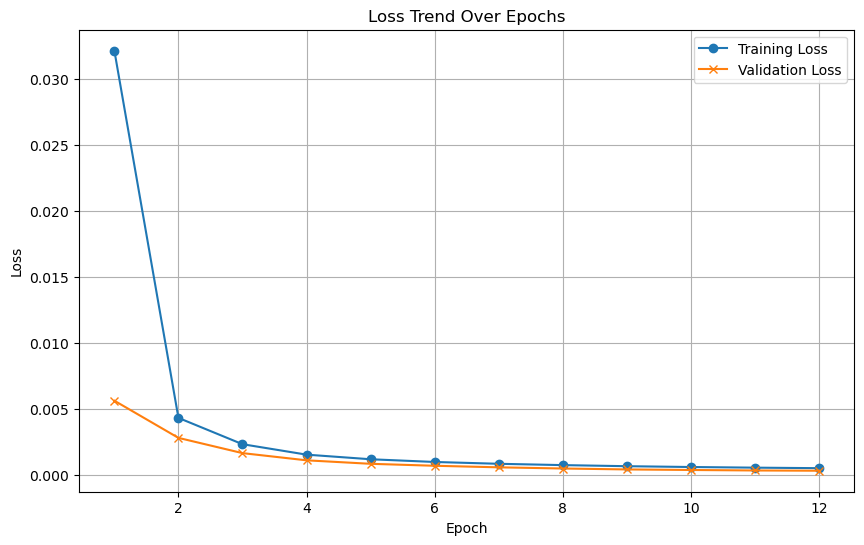

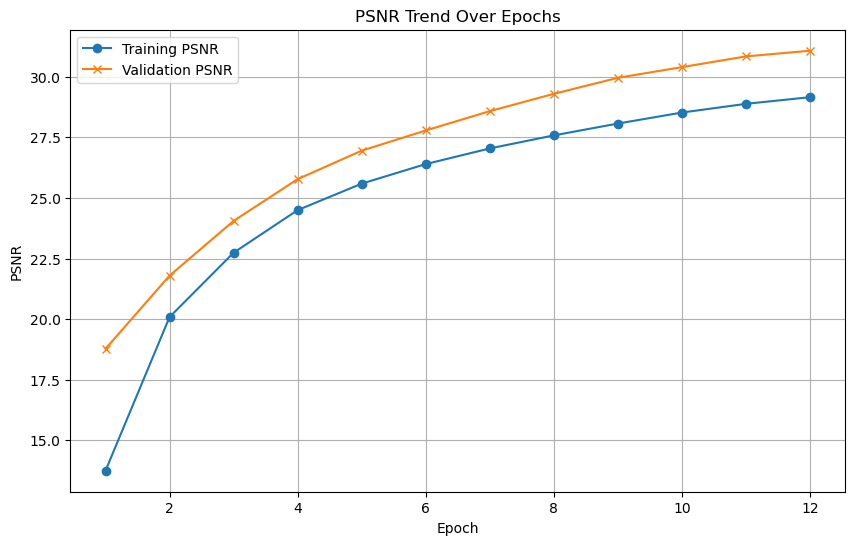

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/578 for test dataset.


    Processed batch 101/578 for test dataset.


    Processed batch 201/578 for test dataset.


    Processed batch 301/578 for test dataset.


    Processed batch 401/578 for test dataset.


    Processed batch 501/578 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.2094
    Validation Batch [1/1], Loss: 2.2024
Validation Loss: 2.2024, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2024. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1474
    Validation Batch [1/1], Loss: 2.2024
Validation Loss: 2.2024, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.1191
    Validation Batch [1/1], Loss: 2.2024
Validation Loss: 2.2024, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.1005
    Validation Batch [1/1], Loss: 2.2025
Validation Loss: 2.2025, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Averag

    Validation Batch [1/1], Loss: 2.2027
Validation Loss: 2.2027, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [9/1000] - Training
Epoch [9/1000] completed, Average Training Loss: 2.0005
    Validation Batch [1/1], Loss: 2.2027
Validation Loss: 2.2027, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 1.9990
    Validation Batch [1/1], Loss: 2.2029
Validation Loss: 2.2029, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 1.9904
    Validation Batch [1/1], Loss: 2.2030
Validation Loss: 2.2030, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [12/1000] - Training
Epoch [12/1000] completed, Average Training Loss: 1.9649
    Validation Batch [1/1], Loss: 2.2030
Validation Loss: 2.2030, Val

Epoch [37/1000] completed, Average Training Loss: 1.6695
    Validation Batch [1/1], Loss: 2.1106
Validation Loss: 2.1106, Validation Accuracy: 26.67%
Validation loss improved from 2.1253 to 2.1106. Saving model...

LOG: Epoch [38/1000] - Training
Epoch [38/1000] completed, Average Training Loss: 1.6375
    Validation Batch [1/1], Loss: 2.0946
Validation Loss: 2.0946, Validation Accuracy: 26.67%
Validation loss improved from 2.1106 to 2.0946. Saving model...

LOG: Epoch [39/1000] - Training
Epoch [39/1000] completed, Average Training Loss: 1.6372
    Validation Batch [1/1], Loss: 2.0786
Validation Loss: 2.0786, Validation Accuracy: 28.89%
Validation loss improved from 2.0946 to 2.0786. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 1.6194
    Validation Batch [1/1], Loss: 2.0616
Validation Loss: 2.0616, Validation Accuracy: 28.89%
Validation loss improved from 2.0786 to 2.0616. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [4

Epoch [67/1000] completed, Average Training Loss: 1.3883
    Validation Batch [1/1], Loss: 1.4822
Validation Loss: 1.4822, Validation Accuracy: 86.67%
Validation loss improved from 1.4923 to 1.4822. Saving model...

LOG: Epoch [68/1000] - Training
Epoch [68/1000] completed, Average Training Loss: 1.3807
    Validation Batch [1/1], Loss: 1.4700
Validation Loss: 1.4700, Validation Accuracy: 88.89%
Validation loss improved from 1.4822 to 1.4700. Saving model...

LOG: Epoch [69/1000] - Training
Epoch [69/1000] completed, Average Training Loss: 1.3603
    Validation Batch [1/1], Loss: 1.4534
Validation Loss: 1.4534, Validation Accuracy: 88.89%
Validation loss improved from 1.4700 to 1.4534. Saving model...

LOG: Epoch [70/1000] - Training
Epoch [70/1000] completed, Average Training Loss: 1.3520
    Validation Batch [1/1], Loss: 1.4299
Validation Loss: 1.4299, Validation Accuracy: 91.11%
Validation loss improved from 1.4534 to 1.4299. Saving model...

LOG: Epoch [71/1000] - Training
Epoch [7

    Validation Batch [1/1], Loss: 1.1851
Validation Loss: 1.1851, Validation Accuracy: 95.56%
Validation loss improved from 1.2011 to 1.1851. Saving model...

LOG: Epoch [97/1000] - Training
Epoch [97/1000] completed, Average Training Loss: 1.1449
    Validation Batch [1/1], Loss: 1.1848
Validation Loss: 1.1848, Validation Accuracy: 93.33%
Validation loss improved from 1.1851 to 1.1848. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 1.1497
    Validation Batch [1/1], Loss: 1.1853
Validation Loss: 1.1853, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 1.1182
    Validation Batch [1/1], Loss: 1.1774
Validation Loss: 1.1774, Validation Accuracy: 93.33%
Validation loss improved from 1.1848 to 1.1774. Saving model...

LOG: Epoch [100/1000] - Training
Epoch [100/1000] completed, Average Training Loss: 1.1242
    Validation Batch 

Epoch [125/1000] completed, Average Training Loss: 0.9658
    Validation Batch [1/1], Loss: 0.9883
Validation Loss: 0.9883, Validation Accuracy: 93.33%
Validation loss improved from 1.0035 to 0.9883. Saving model...

LOG: Epoch [126/1000] - Training
Epoch [126/1000] completed, Average Training Loss: 0.9211
    Validation Batch [1/1], Loss: 0.9760
Validation Loss: 0.9760, Validation Accuracy: 93.33%
Validation loss improved from 0.9883 to 0.9760. Saving model...

LOG: Epoch [127/1000] - Training
Epoch [127/1000] completed, Average Training Loss: 0.9065
    Validation Batch [1/1], Loss: 0.9710
Validation Loss: 0.9710, Validation Accuracy: 95.56%
Validation loss improved from 0.9760 to 0.9710. Saving model...

LOG: Epoch [128/1000] - Training
Epoch [128/1000] completed, Average Training Loss: 0.9083
    Validation Batch [1/1], Loss: 0.9756
Validation Loss: 0.9756, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [129/1000] - Training
Epoch [129/1000

Epoch [154/1000] completed, Average Training Loss: 0.7220
    Validation Batch [1/1], Loss: 0.8074
Validation Loss: 0.8074, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [155/1000] - Training
Epoch [155/1000] completed, Average Training Loss: 0.7251
    Validation Batch [1/1], Loss: 0.8010
Validation Loss: 0.8010, Validation Accuracy: 93.33%
Validation loss improved from 0.8045 to 0.8010. Saving model...

LOG: Epoch [156/1000] - Training
Epoch [156/1000] completed, Average Training Loss: 0.7022
    Validation Batch [1/1], Loss: 0.7797
Validation Loss: 0.7797, Validation Accuracy: 95.56%
Validation loss improved from 0.8010 to 0.7797. Saving model...

LOG: Epoch [157/1000] - Training
Epoch [157/1000] completed, Average Training Loss: 0.7209
    Validation Batch [1/1], Loss: 0.7696
Validation Loss: 0.7696, Validation Accuracy: 95.56%
Validation loss improved from 0.7797 to 0.7696. Saving model...

LOG: Epoch [158/1000] - Training
Epoch [158/1000

Epoch [183/1000] completed, Average Training Loss: 0.5573
    Validation Batch [1/1], Loss: 0.6453
Validation Loss: 0.6453, Validation Accuracy: 95.56%
Validation loss improved from 0.6523 to 0.6453. Saving model...

LOG: Epoch [184/1000] - Training
Epoch [184/1000] completed, Average Training Loss: 0.5327
    Validation Batch [1/1], Loss: 0.6299
Validation Loss: 0.6299, Validation Accuracy: 95.56%
Validation loss improved from 0.6453 to 0.6299. Saving model...

LOG: Epoch [185/1000] - Training
Epoch [185/1000] completed, Average Training Loss: 0.5472
    Validation Batch [1/1], Loss: 0.6211
Validation Loss: 0.6211, Validation Accuracy: 95.56%
Validation loss improved from 0.6299 to 0.6211. Saving model...

LOG: Epoch [186/1000] - Training
Epoch [186/1000] completed, Average Training Loss: 0.5355
    Validation Batch [1/1], Loss: 0.6206
Validation Loss: 0.6206, Validation Accuracy: 93.33%
Validation loss improved from 0.6211 to 0.6206. Saving model...

LOG: Epoch [187/1000] - Training


    Validation Batch [1/1], Loss: 0.5059
Validation Loss: 0.5059, Validation Accuracy: 93.33%
Validation loss improved from 0.5168 to 0.5059. Saving model...

LOG: Epoch [213/1000] - Training
Epoch [213/1000] completed, Average Training Loss: 0.4269
    Validation Batch [1/1], Loss: 0.5214
Validation Loss: 0.5214, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [214/1000] - Training
Epoch [214/1000] completed, Average Training Loss: 0.3733
    Validation Batch [1/1], Loss: 0.5319
Validation Loss: 0.5319, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [215/1000] - Training
Epoch [215/1000] completed, Average Training Loss: 0.3991
    Validation Batch [1/1], Loss: 0.5029
Validation Loss: 0.5029, Validation Accuracy: 91.11%
Validation loss improved from 0.5059 to 0.5029. Saving model...

LOG: Epoch [216/1000] - Training
Epoch [216/1000] completed, Average Training Loss: 0.4246
    Validation Batch [1/1], Lo

Epoch [243/1000] completed, Average Training Loss: 0.2886
    Validation Batch [1/1], Loss: 0.3962
Validation Loss: 0.3962, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [244/1000] - Training
Epoch [244/1000] completed, Average Training Loss: 0.2990
    Validation Batch [1/1], Loss: 0.4574
Validation Loss: 0.4574, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [245/1000] - Training
Epoch [245/1000] completed, Average Training Loss: 0.2779
    Validation Batch [1/1], Loss: 0.4313
Validation Loss: 0.4313, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [246/1000] - Training
Epoch [246/1000] completed, Average Training Loss: 0.3066
    Validation Batch [1/1], Loss: 0.3828
Validation Loss: 0.3828, Validation Accuracy: 93.33%
Validation loss improved from 0.3904 to 0.3828. Saving model...

LOG: Epoch [247/1000] - Training
Epoch [247/1000] completed, Average Training 

Epoch [273/1000] completed, Average Training Loss: 0.2243
    Validation Batch [1/1], Loss: 0.3902
Validation Loss: 0.3902, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [274/1000] - Training
Epoch [274/1000] completed, Average Training Loss: 0.2306
    Validation Batch [1/1], Loss: 0.3832
Validation Loss: 0.3832, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [275/1000] - Training
Epoch [275/1000] completed, Average Training Loss: 0.2283
    Validation Batch [1/1], Loss: 0.3500
Validation Loss: 0.3500, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [276/1000] - Training
Epoch [276/1000] completed, Average Training Loss: 0.2063
    Validation Batch [1/1], Loss: 0.3355
Validation Loss: 0.3355, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [277/1000] - Training
Epoch [277/1000] completed, Average Training Loss: 0.2530
  

Epoch [301/1000] completed, Average Training Loss: 0.1502
    Validation Batch [1/1], Loss: 0.3411
Validation Loss: 0.3411, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training Loss: 0.1582
    Validation Batch [1/1], Loss: 0.3488
Validation Loss: 0.3488, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [303/1000] - Training
Epoch [303/1000] completed, Average Training Loss: 0.1574
    Validation Batch [1/1], Loss: 0.3323
Validation Loss: 0.3323, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [304/1000] - Training
Epoch [304/1000] completed, Average Training Loss: 0.1683
    Validation Batch [1/1], Loss: 0.3155
Validation Loss: 0.3155, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [305/1000] - Training
Epoch [305/1000] completed, Average Training Loss: 0.1647
 

Epoch [331/1000] completed, Average Training Loss: 0.1351
    Validation Batch [1/1], Loss: 0.2959
Validation Loss: 0.2959, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [332/1000] - Training
Epoch [332/1000] completed, Average Training Loss: 0.1367
    Validation Batch [1/1], Loss: 0.2935
Validation Loss: 0.2935, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [333/1000] - Training
Epoch [333/1000] completed, Average Training Loss: 0.1287
    Validation Batch [1/1], Loss: 0.2979
Validation Loss: 0.2979, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [334/1000] - Training
Epoch [334/1000] completed, Average Training Loss: 0.1255
    Validation Batch [1/1], Loss: 0.3002
Validation Loss: 0.3002, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [335/1000] - Training
Epoch [335/1000] completed, Average Training Loss: 0.125

Epoch [361/1000] completed, Average Training Loss: 0.0995
    Validation Batch [1/1], Loss: 0.2852
Validation Loss: 0.2852, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [362/1000] - Training
Epoch [362/1000] completed, Average Training Loss: 0.1047
    Validation Batch [1/1], Loss: 0.3105
Validation Loss: 0.3105, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [363/1000] - Training
Epoch [363/1000] completed, Average Training Loss: 0.1152
    Validation Batch [1/1], Loss: 0.2795
Validation Loss: 0.2795, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [364/1000] - Training
Epoch [364/1000] completed, Average Training Loss: 0.0963
    Validation Batch [1/1], Loss: 0.2767
Validation Loss: 0.2767, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [365/1000] - Training
Epoch [365/1000] completed, Average Training Loss: 0.105

Epoch [392/1000] completed, Average Training Loss: 0.0936
    Validation Batch [1/1], Loss: 0.2472
Validation Loss: 0.2472, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [393/1000] - Training
Epoch [393/1000] completed, Average Training Loss: 0.0761
    Validation Batch [1/1], Loss: 0.2377
Validation Loss: 0.2377, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [394/1000] - Training
Epoch [394/1000] completed, Average Training Loss: 0.0912
    Validation Batch [1/1], Loss: 0.2571
Validation Loss: 0.2571, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [395/1000] - Training
Epoch [395/1000] completed, Average Training Loss: 0.0730
    Validation Batch [1/1], Loss: 0.2921
Validation Loss: 0.2921, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [396/1000] - Training
Epoch [396/1000] completed, Average Training Loss: 0.079

    Validation Batch [1/1], Loss: 0.3043
Validation Loss: 0.3043, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [422/1000] - Training
Epoch [422/1000] completed, Average Training Loss: 0.0748
    Validation Batch [1/1], Loss: 0.3122
Validation Loss: 0.3122, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [423/1000] - Training
Epoch [423/1000] completed, Average Training Loss: 0.0654
    Validation Batch [1/1], Loss: 0.2991
Validation Loss: 0.2991, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [424/1000] - Training
Epoch [424/1000] completed, Average Training Loss: 0.0679
    Validation Batch [1/1], Loss: 0.2852
Validation Loss: 0.2852, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [425/1000] - Training
Epoch [425/1000] completed, Average Training Loss: 0.0628
    Validation Batch [1/1], Loss: 0.2607
Validation Loss

Epoch [451/1000] completed, Average Training Loss: 0.0522
    Validation Batch [1/1], Loss: 0.2902
Validation Loss: 0.2902, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [452/1000] - Training
Epoch [452/1000] completed, Average Training Loss: 0.0507
    Validation Batch [1/1], Loss: 0.2787
Validation Loss: 0.2787, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [453/1000] - Training
Epoch [453/1000] completed, Average Training Loss: 0.0554
    Validation Batch [1/1], Loss: 0.2744
Validation Loss: 0.2744, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [454/1000] - Training
Epoch [454/1000] completed, Average Training Loss: 0.0486
    Validation Batch [1/1], Loss: 0.2670
Validation Loss: 0.2670, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [455/1000] - Training
Epoch [455/1000] completed, Average Training Loss: 0.0533
 

    Validation Batch [1/1], Loss: 0.2572
Validation Loss: 0.2572, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [481/1000] - Training
Epoch [481/1000] completed, Average Training Loss: 0.0476
    Validation Batch [1/1], Loss: 0.2550
Validation Loss: 0.2550, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [482/1000] - Training
Epoch [482/1000] completed, Average Training Loss: 0.0498
    Validation Batch [1/1], Loss: 0.2439
Validation Loss: 0.2439, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [483/1000] - Training
Epoch [483/1000] completed, Average Training Loss: 0.0508
    Validation Batch [1/1], Loss: 0.2345
Validation Loss: 0.2345, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [484/1000] - Training
Epoch [484/1000] completed, Average Training Loss: 0.0395
    Validation Batch [1/1], Loss: 0.2240
Validation Loss: 0.

Epoch [508/1000] completed, Average Training Loss: 0.0449
    Validation Batch [1/1], Loss: 0.2737
Validation Loss: 0.2737, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [509/1000] - Training
Epoch [509/1000] completed, Average Training Loss: 0.0420
    Validation Batch [1/1], Loss: 0.2710
Validation Loss: 0.2710, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [510/1000] - Training
Epoch [510/1000] completed, Average Training Loss: 0.0415
    Validation Batch [1/1], Loss: 0.2575
Validation Loss: 0.2575, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [511/1000] - Training
Epoch [511/1000] completed, Average Training Loss: 0.0461
    Validation Batch [1/1], Loss: 0.2311
Validation Loss: 0.2311, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [512/1000] - Training
Epoch [512/1000] completed, Average Training Loss: 0.0376
  

Epoch [536/1000] completed, Average Training Loss: 0.0412
    Validation Batch [1/1], Loss: 0.2505
Validation Loss: 0.2505, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [537/1000] - Training
Epoch [537/1000] completed, Average Training Loss: 0.0405
    Validation Batch [1/1], Loss: 0.2545
Validation Loss: 0.2545, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [538/1000] - Training
Epoch [538/1000] completed, Average Training Loss: 0.0337
    Validation Batch [1/1], Loss: 0.2505
Validation Loss: 0.2505, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [539/1000] - Training
Epoch [539/1000] completed, Average Training Loss: 0.0437
    Validation Batch [1/1], Loss: 0.2432
Validation Loss: 0.2432, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [540/1000] - Training
Epoch [540/1000] completed, Average Training Loss: 0.029

Epoch [566/1000] completed, Average Training Loss: 0.0372
    Validation Batch [1/1], Loss: 0.2274
Validation Loss: 0.2274, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [567/1000] - Training
Epoch [567/1000] completed, Average Training Loss: 0.0321
    Validation Batch [1/1], Loss: 0.2266
Validation Loss: 0.2266, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [568/1000] - Training
Epoch [568/1000] completed, Average Training Loss: 0.0306
    Validation Batch [1/1], Loss: 0.2404
Validation Loss: 0.2404, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [569/1000] - Training
Epoch [569/1000] completed, Average Training Loss: 0.0326
    Validation Batch [1/1], Loss: 0.2730
Validation Loss: 0.2730, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [570/1000] - Training
Epoch [570/1000] completed, Average Training Loss: 0.034

Epoch [594/1000] completed, Average Training Loss: 0.0245
    Validation Batch [1/1], Loss: 0.2302
Validation Loss: 0.2302, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [595/1000] - Training
Epoch [595/1000] completed, Average Training Loss: 0.0418
    Validation Batch [1/1], Loss: 0.2271
Validation Loss: 0.2271, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [596/1000] - Training
Epoch [596/1000] completed, Average Training Loss: 0.0303
    Validation Batch [1/1], Loss: 0.2240
Validation Loss: 0.2240, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [597/1000] - Training
Epoch [597/1000] completed, Average Training Loss: 0.0290
    Validation Batch [1/1], Loss: 0.2315
Validation Loss: 0.2315, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [598/1000] - Training
Epoch [598/1000] completed, Average Training Loss: 0.029

Epoch [625/1000] completed, Average Training Loss: 0.0342
    Validation Batch [1/1], Loss: 0.2596
Validation Loss: 0.2596, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [626/1000] - Training
Epoch [626/1000] completed, Average Training Loss: 0.0256
    Validation Batch [1/1], Loss: 0.2256
Validation Loss: 0.2256, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [627/1000] - Training
Epoch [627/1000] completed, Average Training Loss: 0.0248
    Validation Batch [1/1], Loss: 0.1959
Validation Loss: 0.1959, Validation Accuracy: 93.33%
Validation loss improved from 0.1964 to 0.1959. Saving model...

LOG: Epoch [628/1000] - Training
Epoch [628/1000] completed, Average Training Loss: 0.0255
    Validation Batch [1/1], Loss: 0.1843
Validation Loss: 0.1843, Validation Accuracy: 93.33%
Validation loss improved from 0.1959 to 0.1843. Saving model...

LOG: Epoch [629/1000] - Training
Epoch [629/1000] completed, 

Epoch [655/1000] completed, Average Training Loss: 0.0263
    Validation Batch [1/1], Loss: 0.3427
Validation Loss: 0.3427, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [656/1000] - Training
Epoch [656/1000] completed, Average Training Loss: 0.0215
    Validation Batch [1/1], Loss: 0.3616
Validation Loss: 0.3616, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [657/1000] - Training
Epoch [657/1000] completed, Average Training Loss: 0.0271
    Validation Batch [1/1], Loss: 0.3372
Validation Loss: 0.3372, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [658/1000] - Training
Epoch [658/1000] completed, Average Training Loss: 0.0248
    Validation Batch [1/1], Loss: 0.3130
Validation Loss: 0.3130, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [659/1000] - Training
Epoch [659/1000] completed, Average Training Loss: 0.024

Epoch [683/1000] completed, Average Training Loss: 0.0236
    Validation Batch [1/1], Loss: 0.2799
Validation Loss: 0.2799, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [684/1000] - Training
Epoch [684/1000] completed, Average Training Loss: 0.0284
    Validation Batch [1/1], Loss: 0.2622
Validation Loss: 0.2622, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [685/1000] - Training
Epoch [685/1000] completed, Average Training Loss: 0.0219
    Validation Batch [1/1], Loss: 0.2418
Validation Loss: 0.2418, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [686/1000] - Training
Epoch [686/1000] completed, Average Training Loss: 0.0168
    Validation Batch [1/1], Loss: 0.2242
Validation Loss: 0.2242, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [687/1000] - Training
Epoch [687/1000] completed, Average Training Loss: 0.020

Epoch [710/1000] completed, Average Training Loss: 0.0165
    Validation Batch [1/1], Loss: 0.2295
Validation Loss: 0.2295, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 81/100

LOG: Epoch [711/1000] - Training
Epoch [711/1000] completed, Average Training Loss: 0.0222
    Validation Batch [1/1], Loss: 0.2223
Validation Loss: 0.2223, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 82/100

LOG: Epoch [712/1000] - Training
Epoch [712/1000] completed, Average Training Loss: 0.0175
    Validation Batch [1/1], Loss: 0.2247
Validation Loss: 0.2247, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 83/100

LOG: Epoch [713/1000] - Training
Epoch [713/1000] completed, Average Training Loss: 0.0198
    Validation Batch [1/1], Loss: 0.2461
Validation Loss: 0.2461, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 84/100

LOG: Epoch [714/1000] - Training
Epoch [714/1000] completed, Average Training Loss: 0.016

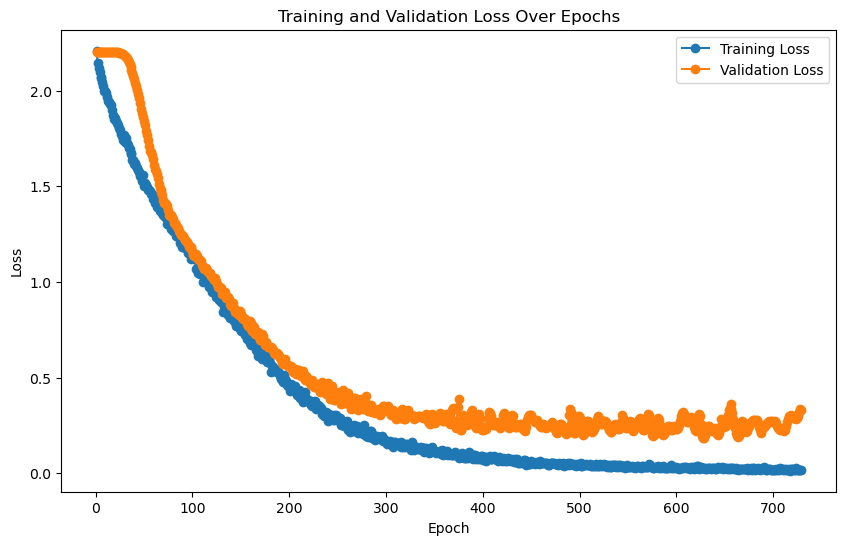

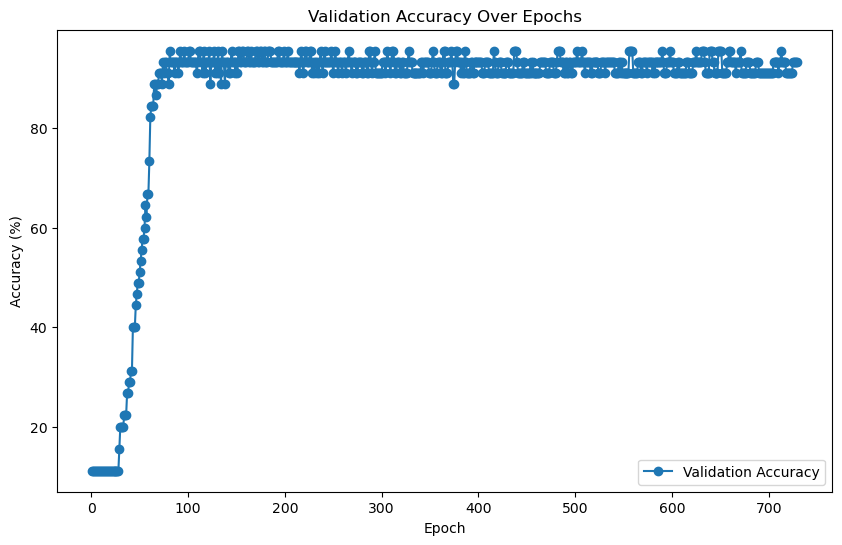


Evaluating on the test set...
    Test Batch [1/578], Loss: 0.1584



Final Test Loss: 0.0780, Test Accuracy: 98.13%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/578 for test dataset.
  Processed batch 20/578 for test dataset.
  Processed batch 30/578 for test dataset.


  Processed batch 40/578 for test dataset.
  Processed batch 50/578 for test dataset.
  Processed batch 60/578 for test dataset.
  Processed batch 70/578 for test dataset.
  Processed batch 80/578 for test dataset.


  Processed batch 90/578 for test dataset.
  Processed batch 100/578 for test dataset.
  Processed batch 110/578 for test dataset.
  Processed batch 120/578 for test dataset.
  Processed batch 130/578 for test dataset.


  Processed batch 140/578 for test dataset.
  Processed batch 150/578 for test dataset.
  Processed batch 160/578 for test dataset.
  Processed batch 170/578 for test dataset.
  Processed batch 180/578 for test dataset.


  Processed batch 190/578 for test dataset.
  Processed batch 200/578 for test dataset.
  Processed batch 210/578 for test dataset.
  Processed batch 220/578 for test dataset.
  Processed batch 230/578 for test dataset.


  Processed batch 240/578 for test dataset.
  Processed batch 250/578 for test dataset.
  Processed batch 260/578 for test dataset.
  Processed batch 270/578 for test dataset.
  Processed batch 280/578 for test dataset.


  Processed batch 290/578 for test dataset.
  Processed batch 300/578 for test dataset.
  Processed batch 310/578 for test dataset.
  Processed batch 320/578 for test dataset.
  Processed batch 330/578 for test dataset.


  Processed batch 340/578 for test dataset.
  Processed batch 350/578 for test dataset.
  Processed batch 360/578 for test dataset.
  Processed batch 370/578 for test dataset.
  Processed batch 380/578 for test dataset.


  Processed batch 390/578 for test dataset.
  Processed batch 400/578 for test dataset.
  Processed batch 410/578 for test dataset.
  Processed batch 420/578 for test dataset.
  Processed batch 430/578 for test dataset.


  Processed batch 440/578 for test dataset.
  Processed batch 450/578 for test dataset.
  Processed batch 460/578 for test dataset.
  Processed batch 470/578 for test dataset.
  Processed batch 480/578 for test dataset.


  Processed batch 490/578 for test dataset.
  Processed batch 500/578 for test dataset.
  Processed batch 510/578 for test dataset.
  Processed batch 520/578 for test dataset.
  Processed batch 530/578 for test dataset.


  Processed batch 540/578 for test dataset.
  Processed batch 550/578 for test dataset.
  Processed batch 560/578 for test dataset.
  Processed batch 570/578 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 147927 samples with 64 features each
LOG: Labels shape: (147927,)

LOG: Training features shape: (180, 64), Training labels shape: (180,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (147927, 64), Test labels shape: (147927,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 93.33%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.80      0.80      0.80         5
           4       0.80      0.80      0.80         5
           5       1.00      0.80      0.89         5
           6       0.83      1.00      0.91         5
           7       1.00      1.00      1.00         5
           8       1.00    

Saved CAE+LRM predictions and true labels to model_predictions


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 147927 samples with 64 features each
LOG: Labels shape: (147927,)
Train reps shape: (180, 64)
Train labels shape: (180,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (147927, 64)
Test labels shape: (147927,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.1622  |  Val Loss: 2.0443
Validation loss improved from inf to 2.0443.


[Epoch 2/1000] Train Loss: 1.9969  |  Val Loss: 1.9440
Validation loss improved from 2.0443 to 1.9440.


[Epoch 3/1000] Train Loss: 1.8926  |  Val Loss: 1.8376
Validation loss improved from 1.9440 to 1.8376.
[Epoch 4/1000] Train Loss: 1.7762  |  Val Loss: 1.7255
Validation loss improved from 1.8376 to 1.7255.
[Epoch 5/1000] Train Loss: 1.6587  |  Val Loss: 1.6225
Validation loss improved from 1.7255 to 1.6225.
[Epoch 6/1000] Train Loss: 1.5554  |  Val Loss: 1.5200
Validation loss improved from 1.6225 to 1.5200.
[Epoch 7/1000] Train Loss: 1.4581  |  Val Loss: 1.4159
Validation loss improved from 1.5200 to 1.4159.
[Epoch 8/1000] Train Loss: 1.3608  |  Val Loss: 1.3251
Validation loss improved from 1.4159 to 1.3251.
[Epoch 9/1000] Train Loss: 1.2723  |  Val Loss: 1.2386
Validation loss improved from 1.3251 to 1.2386.
[Epoch 10/1000] Train Loss: 1.1892  |  Val Loss: 1.1596
Validation loss improved from 1.2386 to 1.1596.
[Epoch 11/1000] Train Loss: 1.1124  |  Val Loss: 1.0870
Validation loss improved from 1.1596 to 1.0870.
[Epoch 12/1000] Train Loss: 1.0432  |  Val Loss: 1.0220
Validation loss

[Epoch 34/1000] Train Loss: 0.2491  |  Val Loss: 0.2703
Validation loss improved from 0.2890 to 0.2703.


[Epoch 35/1000] Train Loss: 0.2355  |  Val Loss: 0.2574
Validation loss improved from 0.2703 to 0.2574.
[Epoch 36/1000] Train Loss: 0.2280  |  Val Loss: 0.2619
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 37/1000] Train Loss: 0.2172  |  Val Loss: 0.2637
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 38/1000] Train Loss: 0.2105  |  Val Loss: 0.2404
Validation loss improved from 0.2574 to 0.2404.
[Epoch 39/1000] Train Loss: 0.2024  |  Val Loss: 0.2474
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 40/1000] Train Loss: 0.1939  |  Val Loss: 0.2371
Validation loss improved from 0.2404 to 0.2371.
[Epoch 41/1000] Train Loss: 0.1917  |  Val Loss: 0.2415
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 42/1000] Train Loss: 0.1807  |  Val Loss: 0.2254
Validation loss improved from 0.2371 to 0.2254.
[Epoch 43/1000] Train Loss: 0.1763  |  Val Loss: 0.2239
Validation loss improved from 0.2254 to 0.2239.
[Epoch 44/1000] Train Loss: 0.1714  |  V

[Epoch 68/1000] Train Loss: 0.1109  |  Val Loss: 0.2521
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 69/1000] Train Loss: 0.1068  |  Val Loss: 0.2266
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 70/1000] Train Loss: 0.1071  |  Val Loss: 0.2571
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 71/1000] Train Loss: 0.1036  |  Val Loss: 0.2696
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 72/1000] Train Loss: 0.1006  |  Val Loss: 0.2400
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 73/1000] Train Loss: 0.0991  |  Val Loss: 0.2503
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 74/1000] Train Loss: 0.0954  |  Val Loss: 0.2790
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 75/1000] Train Loss: 0.0990  |  Val Loss: 0.2701
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 76/1000] Train Loss: 0.0897  |  Val Loss: 0.2484
!! Validation loss did NOT improve !! Patience: 19/100
[

[Epoch 99/1000] Train Loss: 0.0610  |  Val Loss: 0.2948
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 100/1000] Train Loss: 0.0596  |  Val Loss: 0.3057
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 101/1000] Train Loss: 0.0590  |  Val Loss: 0.3001
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 102/1000] Train Loss: 0.0563  |  Val Loss: 0.3125
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 103/1000] Train Loss: 0.0573  |  Val Loss: 0.3171
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 104/1000] Train Loss: 0.0545  |  Val Loss: 0.3065
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 105/1000] Train Loss: 0.0568  |  Val Loss: 0.3118
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 106/1000] Train Loss: 0.0562  |  Val Loss: 0.3364
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 107/1000] Train Loss: 0.0533  |  Val Loss: 0.3232
!! Validation loss did NOT improve !! Patience: 

[Epoch 128/1000] Train Loss: 0.0374  |  Val Loss: 0.3648
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 129/1000] Train Loss: 0.0342  |  Val Loss: 0.3889
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 130/1000] Train Loss: 0.0424  |  Val Loss: 0.3754
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 131/1000] Train Loss: 0.0335  |  Val Loss: 0.3636
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 132/1000] Train Loss: 0.0423  |  Val Loss: 0.3964
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 133/1000] Train Loss: 0.0322  |  Val Loss: 0.4039
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 134/1000] Train Loss: 0.0348  |  Val Loss: 0.3745
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 135/1000] Train Loss: 0.0353  |  Val Loss: 0.3702
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 136/1000] Train Loss: 0.0298  |  Val Loss: 0.4168
!! Validation loss did NOT improve !! Patience:

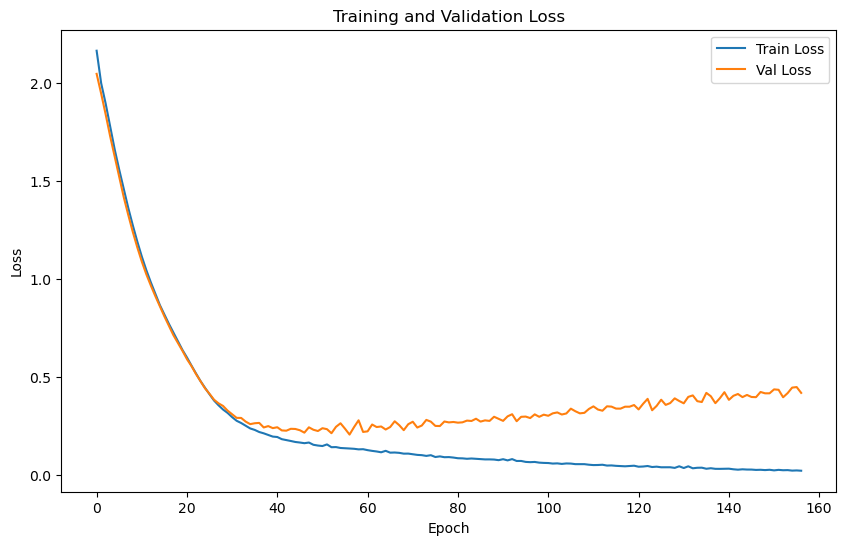

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.1349 | Test Accuracy: 96.68%


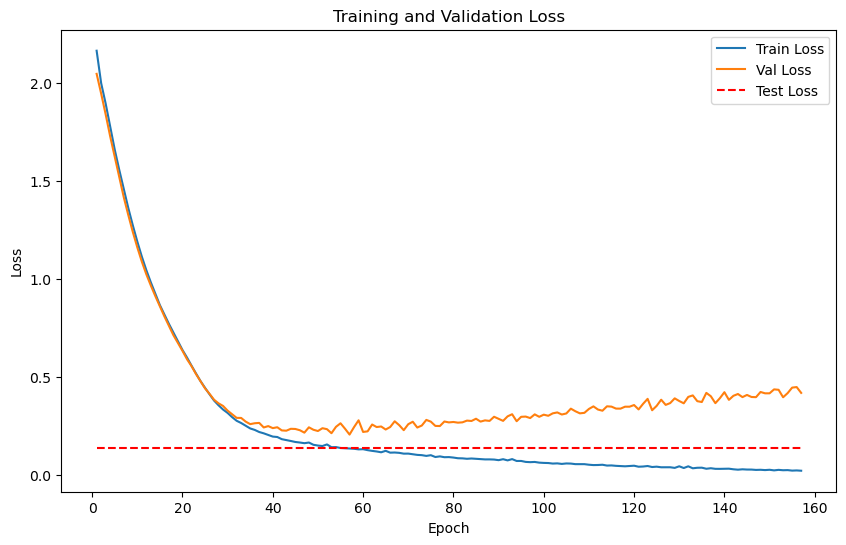

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 147927 samples with 64 features each
LOG: Labels shape: (147927,)


Train embeddings shape: (180, 64), 
Train labels shape: (180,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (147927, 64), 
Test labels shape: (147927,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.5591
Epoch [1/2000], Avg Train Loss: 8.5591


Epoch [1/2000], Avg Val Loss: 4.0750
Validation loss improved from inf to 4.0750. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.5680
Epoch [2/2000], Avg Train Loss: 8.5680
Epoch [2/2000], Avg Val Loss: 4.0252
Validation loss improved from 4.0750 to 4.0252. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.4894
Epoch [3/2000], Avg Train Loss: 8.4894
Epoch [3/2000], Avg Val Loss: 3.9771
Validation loss improved from 4.0252 to 3.9771. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.3201
Epoch [4/2000], Avg Train Loss: 8.3201
Epoch [4/2000], Avg Val Loss: 3.9303
Validation loss improved from 3.9771 to 3.9303. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.3097
Epoch [5/2000], Avg Train Loss: 8.3097
Epoch [5/2000], Avg Val Loss: 3.8846
Validation loss improved from 3.9303 to 3.8846. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 8.3453
Ep

Epoch [13/2000], Avg Val Loss: 3.5627
Validation loss improved from 3.5990 to 3.5627. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 7.6834
Epoch [14/2000], Avg Train Loss: 7.6834
Epoch [14/2000], Avg Val Loss: 3.5276
Validation loss improved from 3.5627 to 3.5276. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 7.5735
Epoch [15/2000], Avg Train Loss: 7.5735
Epoch [15/2000], Avg Val Loss: 3.4936
Validation loss improved from 3.5276 to 3.4936. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 7.5042
Epoch [16/2000], Avg Train Loss: 7.5042
Epoch [16/2000], Avg Val Loss: 3.4607
Validation loss improved from 3.4936 to 3.4607. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 7.4265
Epoch [17/2000], Avg Train Loss: 7.4265
Epoch [17/2000], Avg Val Loss: 3.4289
Validation loss improved from 3.4607 to 3.4289. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 6.0773
Epoch [43/2000], Avg Train Loss: 6.0773
Epoch [43/2000], Avg Val Loss: 2.9090
Validation loss improved from 2.9204 to 2.9090. Saving model...

LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 5.9741
Epoch [44/2000], Avg Train Loss: 5.9741
Epoch [44/2000], Avg Val Loss: 2.8981
Validation loss improved from 2.9090 to 2.8981. Saving model...

LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 5.9859
Epoch [45/2000], Avg Train Loss: 5.9859
Epoch [45/2000], Avg Val Loss: 2.8876
Validation loss improved from 2.8981 to 2.8876. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 5.9881
Epoch [46/2000], Avg Train Loss: 5.9881
Epoch [46/2000], Avg Val Loss: 2.8775
Validation loss improved from 2.8876 to 2.8775. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 5.8147
Epoch [47/2000], Avg Train Loss: 5.8147
Epoch [47/2000], Avg Val Loss: 2.8680
Validation loss improved from 2.8775 to 2.

    Batch [1/1], Train Loss: 5.5903
Epoch [57/2000], Avg Train Loss: 5.5903
Epoch [57/2000], Avg Val Loss: 2.7926
Validation loss improved from 2.7987 to 2.7926. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 5.5848
Epoch [58/2000], Avg Train Loss: 5.5848
Epoch [58/2000], Avg Val Loss: 2.7868
Validation loss improved from 2.7926 to 2.7868. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 5.4493
Epoch [59/2000], Avg Train Loss: 5.4493
Epoch [59/2000], Avg Val Loss: 2.7812
Validation loss improved from 2.7868 to 2.7812. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 5.4390
Epoch [60/2000], Avg Train Loss: 5.4390
Epoch [60/2000], Avg Val Loss: 2.7758
Validation loss improved from 2.7812 to 2.7758. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 5.3891
Epoch [61/2000], Avg Train Loss: 5.3891
Epoch [61/2000], Avg Val Loss: 2.7707
Validation loss improved from 2.7758 to 2.

    Batch [1/1], Train Loss: 4.9568
Epoch [82/2000], Avg Train Loss: 4.9568
Epoch [82/2000], Avg Val Loss: 2.7006
Validation loss improved from 2.7029 to 2.7006. Saving model...

LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 5.0862
Epoch [83/2000], Avg Train Loss: 5.0862
Epoch [83/2000], Avg Val Loss: 2.6984
Validation loss improved from 2.7006 to 2.6984. Saving model...

LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 5.1351
Epoch [84/2000], Avg Train Loss: 5.1351
Epoch [84/2000], Avg Val Loss: 2.6963
Validation loss improved from 2.6984 to 2.6963. Saving model...

LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 4.9271
Epoch [85/2000], Avg Train Loss: 4.9271
Epoch [85/2000], Avg Val Loss: 2.6942
Validation loss improved from 2.6963 to 2.6942. Saving model...

LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 4.9853
Epoch [86/2000], Avg Train Loss: 4.9853
Epoch [86/2000], Avg Val Loss: 2.6921
Validation loss improved from 2.6942 to 2.

    Batch [1/1], Train Loss: 4.7930
Epoch [101/2000], Avg Train Loss: 4.7930
Epoch [101/2000], Avg Val Loss: 2.6656
Validation loss improved from 2.6672 to 2.6656. Saving model...

LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 4.8317
Epoch [102/2000], Avg Train Loss: 4.8317
Epoch [102/2000], Avg Val Loss: 2.6640
Validation loss improved from 2.6656 to 2.6640. Saving model...

LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 4.7108
Epoch [103/2000], Avg Train Loss: 4.7108
Epoch [103/2000], Avg Val Loss: 2.6625
Validation loss improved from 2.6640 to 2.6625. Saving model...

LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 4.6968
Epoch [104/2000], Avg Train Loss: 4.6968
Epoch [104/2000], Avg Val Loss: 2.6610
Validation loss improved from 2.6625 to 2.6610. Saving model...

LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 4.7493
Epoch [105/2000], Avg Train Loss: 4.7493
Epoch [105/2000], Avg Val Loss: 2.6595
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5466
Epoch [126/2000], Avg Train Loss: 4.5466
Epoch [126/2000], Avg Val Loss: 2.6294
Validation loss improved from 2.6307 to 2.6294. Saving model...

LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 4.6212
Epoch [127/2000], Avg Train Loss: 4.6212
Epoch [127/2000], Avg Val Loss: 2.6280
Validation loss improved from 2.6294 to 2.6280. Saving model...

LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 4.5157
Epoch [128/2000], Avg Train Loss: 4.5157
Epoch [128/2000], Avg Val Loss: 2.6266
Validation loss improved from 2.6280 to 2.6266. Saving model...

LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 4.6168
Epoch [129/2000], Avg Train Loss: 4.6168
Epoch [129/2000], Avg Val Loss: 2.6253
Validation loss improved from 2.6266 to 2.6253. Saving model...

LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 4.5226
Epoch [130/2000], Avg Train Loss: 4.5226
Epoch [130/2000], Avg Val Loss: 2.6239
Validation loss improved fro

Epoch [142/2000], Avg Val Loss: 2.6074
Validation loss improved from 2.6088 to 2.6074. Saving model...

LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 4.5227
Epoch [143/2000], Avg Train Loss: 4.5227
Epoch [143/2000], Avg Val Loss: 2.6060
Validation loss improved from 2.6074 to 2.6060. Saving model...

LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 4.4932
Epoch [144/2000], Avg Train Loss: 4.4932
Epoch [144/2000], Avg Val Loss: 2.6047
Validation loss improved from 2.6060 to 2.6047. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 4.4521
Epoch [145/2000], Avg Train Loss: 4.4521
Epoch [145/2000], Avg Val Loss: 2.6033
Validation loss improved from 2.6047 to 2.6033. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 4.5499
Epoch [146/2000], Avg Train Loss: 4.5499
Epoch [146/2000], Avg Val Loss: 2.6020
Validation loss improved from 2.6033 to 2.6020. Saving model...

LOG: Epoch [147/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.3791
Epoch [168/2000], Avg Train Loss: 4.3791
Epoch [168/2000], Avg Val Loss: 2.5730
Validation loss improved from 2.5743 to 2.5730. Saving model...

LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 4.4468
Epoch [169/2000], Avg Train Loss: 4.4468
Epoch [169/2000], Avg Val Loss: 2.5717
Validation loss improved from 2.5730 to 2.5717. Saving model...

LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 4.3891
Epoch [170/2000], Avg Train Loss: 4.3891
Epoch [170/2000], Avg Val Loss: 2.5705
Validation loss improved from 2.5717 to 2.5705. Saving model...

LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 4.4247
Epoch [171/2000], Avg Train Loss: 4.4247
Epoch [171/2000], Avg Val Loss: 2.5692
Validation loss improved from 2.5705 to 2.5692. Saving model...

LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 4.4363
Epoch [172/2000], Avg Train Loss: 4.4363
Epoch [172/2000], Avg Val Loss: 2.5679
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4170
Epoch [186/2000], Avg Train Loss: 4.4170
Epoch [186/2000], Avg Val Loss: 2.5501
Validation loss improved from 2.5514 to 2.5501. Saving model...

LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 4.3491
Epoch [187/2000], Avg Train Loss: 4.3491
Epoch [187/2000], Avg Val Loss: 2.5489
Validation loss improved from 2.5501 to 2.5489. Saving model...

LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 4.3403
Epoch [188/2000], Avg Train Loss: 4.3403
Epoch [188/2000], Avg Val Loss: 2.5476
Validation loss improved from 2.5489 to 2.5476. Saving model...

LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 4.3364
Epoch [189/2000], Avg Train Loss: 4.3364
Epoch [189/2000], Avg Val Loss: 2.5464
Validation loss improved from 2.5476 to 2.5464. Saving model...

LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 4.3296
Epoch [190/2000], Avg Train Loss: 4.3296
Epoch [190/2000], Avg Val Loss: 2.5451
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2174
Epoch [211/2000], Avg Train Loss: 4.2174
Epoch [211/2000], Avg Val Loss: 2.5187
Validation loss improved from 2.5199 to 2.5187. Saving model...

LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 4.2351
Epoch [212/2000], Avg Train Loss: 4.2351
Epoch [212/2000], Avg Val Loss: 2.5175
Validation loss improved from 2.5187 to 2.5175. Saving model...

LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 4.2972
Epoch [213/2000], Avg Train Loss: 4.2972
Epoch [213/2000], Avg Val Loss: 2.5163
Validation loss improved from 2.5175 to 2.5163. Saving model...

LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 4.2791
Epoch [214/2000], Avg Train Loss: 4.2791
Epoch [214/2000], Avg Val Loss: 2.5151
Validation loss improved from 2.5163 to 2.5151. Saving model...

LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 4.1801
Epoch [215/2000], Avg Train Loss: 4.1801
Epoch [215/2000], Avg Val Loss: 2.5139
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2418
Epoch [226/2000], Avg Train Loss: 4.2418
Epoch [226/2000], Avg Val Loss: 2.5012
Validation loss improved from 2.5023 to 2.5012. Saving model...

LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 4.2052
Epoch [227/2000], Avg Train Loss: 4.2052
Epoch [227/2000], Avg Val Loss: 2.5001
Validation loss improved from 2.5012 to 2.5001. Saving model...

LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 4.1951
Epoch [228/2000], Avg Train Loss: 4.1951
Epoch [228/2000], Avg Val Loss: 2.4990
Validation loss improved from 2.5001 to 2.4990. Saving model...

LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 4.2277
Epoch [229/2000], Avg Train Loss: 4.2277
Epoch [229/2000], Avg Val Loss: 2.4978
Validation loss improved from 2.4990 to 2.4978. Saving model...

LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 4.2499
Epoch [230/2000], Avg Train Loss: 4.2499
Epoch [230/2000], Avg Val Loss: 2.4967
Validation loss improved fro

Epoch [250/2000], Avg Val Loss: 2.4754
Validation loss improved from 2.4765 to 2.4754. Saving model...

LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 4.1907
Epoch [251/2000], Avg Train Loss: 4.1907
Epoch [251/2000], Avg Val Loss: 2.4745
Validation loss improved from 2.4754 to 2.4745. Saving model...

LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 4.1090
Epoch [252/2000], Avg Train Loss: 4.1090
Epoch [252/2000], Avg Val Loss: 2.4734
Validation loss improved from 2.4745 to 2.4734. Saving model...

LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 4.1268
Epoch [253/2000], Avg Train Loss: 4.1268
Epoch [253/2000], Avg Val Loss: 2.4724
Validation loss improved from 2.4734 to 2.4724. Saving model...

LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 4.1484
Epoch [254/2000], Avg Train Loss: 4.1484
Epoch [254/2000], Avg Val Loss: 2.4714
Validation loss improved from 2.4724 to 2.4714. Saving model...

LOG: Epoch [255/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.0916
Epoch [267/2000], Avg Train Loss: 4.0916
Epoch [267/2000], Avg Val Loss: 2.4578
Validation loss improved from 2.4589 to 2.4578. Saving model...

LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 4.1377
Epoch [268/2000], Avg Train Loss: 4.1377
Epoch [268/2000], Avg Val Loss: 2.4567
Validation loss improved from 2.4578 to 2.4567. Saving model...

LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 4.0963
Epoch [269/2000], Avg Train Loss: 4.0963
Epoch [269/2000], Avg Val Loss: 2.4556
Validation loss improved from 2.4567 to 2.4556. Saving model...

LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 4.1248
Epoch [270/2000], Avg Train Loss: 4.1248
Epoch [270/2000], Avg Val Loss: 2.4546
Validation loss improved from 2.4556 to 2.4546. Saving model...

LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 4.0967
Epoch [271/2000], Avg Train Loss: 4.0967
Epoch [271/2000], Avg Val Loss: 2.4535
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0955
Epoch [290/2000], Avg Train Loss: 4.0955
Epoch [290/2000], Avg Val Loss: 2.4342
Validation loss improved from 2.4352 to 2.4342. Saving model...

LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 4.0487
Epoch [291/2000], Avg Train Loss: 4.0487
Epoch [291/2000], Avg Val Loss: 2.4333
Validation loss improved from 2.4342 to 2.4333. Saving model...

LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 4.0854
Epoch [292/2000], Avg Train Loss: 4.0854
Epoch [292/2000], Avg Val Loss: 2.4323
Validation loss improved from 2.4333 to 2.4323. Saving model...

LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 4.0853
Epoch [293/2000], Avg Train Loss: 4.0853
Epoch [293/2000], Avg Val Loss: 2.4314
Validation loss improved from 2.4323 to 2.4314. Saving model...

LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 4.0678
Epoch [294/2000], Avg Train Loss: 4.0678
Epoch [294/2000], Avg Val Loss: 2.4304
Validation loss improved fro

Epoch [312/2000], Avg Val Loss: 2.4143
Validation loss improved from 2.4152 to 2.4143. Saving model...

LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 4.0185
Epoch [313/2000], Avg Train Loss: 4.0185
Epoch [313/2000], Avg Val Loss: 2.4134
Validation loss improved from 2.4143 to 2.4134. Saving model...

LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 4.0954
Epoch [314/2000], Avg Train Loss: 4.0954
Epoch [314/2000], Avg Val Loss: 2.4125
Validation loss improved from 2.4134 to 2.4125. Saving model...

LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 4.0244
Epoch [315/2000], Avg Train Loss: 4.0244
Epoch [315/2000], Avg Val Loss: 2.4117
Validation loss improved from 2.4125 to 2.4117. Saving model...

LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 4.0268
Epoch [316/2000], Avg Train Loss: 4.0268
Epoch [316/2000], Avg Val Loss: 2.4108
Validation loss improved from 2.4117 to 2.4108. Saving model...

LOG: Epoch [317/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.0666
Epoch [334/2000], Avg Train Loss: 4.0666
Epoch [334/2000], Avg Val Loss: 2.3962
Validation loss improved from 2.3970 to 2.3962. Saving model...

LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 3.9999
Epoch [335/2000], Avg Train Loss: 3.9999
Epoch [335/2000], Avg Val Loss: 2.3954
Validation loss improved from 2.3962 to 2.3954. Saving model...

LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 3.9650
Epoch [336/2000], Avg Train Loss: 3.9650
Epoch [336/2000], Avg Val Loss: 2.3946
Validation loss improved from 2.3954 to 2.3946. Saving model...

LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 4.0081
Epoch [337/2000], Avg Train Loss: 4.0081
Epoch [337/2000], Avg Val Loss: 2.3938
Validation loss improved from 2.3946 to 2.3938. Saving model...

LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 3.9870
Epoch [338/2000], Avg Train Loss: 3.9870
Epoch [338/2000], Avg Val Loss: 2.3930
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9988
Epoch [354/2000], Avg Train Loss: 3.9988
Epoch [354/2000], Avg Val Loss: 2.3806
Validation loss improved from 2.3814 to 2.3806. Saving model...

LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 3.9950
Epoch [355/2000], Avg Train Loss: 3.9950
Epoch [355/2000], Avg Val Loss: 2.3799
Validation loss improved from 2.3806 to 2.3799. Saving model...

LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 3.9691
Epoch [356/2000], Avg Train Loss: 3.9691
Epoch [356/2000], Avg Val Loss: 2.3792
Validation loss improved from 2.3799 to 2.3792. Saving model...

LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 4.0089
Epoch [357/2000], Avg Train Loss: 4.0089
Epoch [357/2000], Avg Val Loss: 2.3784
Validation loss improved from 2.3792 to 2.3784. Saving model...

LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 4.0127
Epoch [358/2000], Avg Train Loss: 4.0127
Epoch [358/2000], Avg Val Loss: 2.3777
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9383
Epoch [377/2000], Avg Train Loss: 3.9383
Epoch [377/2000], Avg Val Loss: 2.3646
Validation loss improved from 2.3652 to 2.3646. Saving model...

LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 3.9103
Epoch [378/2000], Avg Train Loss: 3.9103
Epoch [378/2000], Avg Val Loss: 2.3640
Validation loss improved from 2.3646 to 2.3640. Saving model...

LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 3.9552
Epoch [379/2000], Avg Train Loss: 3.9552
Epoch [379/2000], Avg Val Loss: 2.3634
Validation loss improved from 2.3640 to 2.3634. Saving model...

LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 3.9343
Epoch [380/2000], Avg Train Loss: 3.9343
Epoch [380/2000], Avg Val Loss: 2.3627
Validation loss improved from 2.3634 to 2.3627. Saving model...

LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 3.9173
Epoch [381/2000], Avg Train Loss: 3.9173
Epoch [381/2000], Avg Val Loss: 2.3621
Validation loss improved fro

Epoch [395/2000], Avg Val Loss: 2.3535
Validation loss improved from 2.3542 to 2.3535. Saving model...

LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 3.9337
Epoch [396/2000], Avg Train Loss: 3.9337
Epoch [396/2000], Avg Val Loss: 2.3529
Validation loss improved from 2.3535 to 2.3529. Saving model...

LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 3.9110
Epoch [397/2000], Avg Train Loss: 3.9110
Epoch [397/2000], Avg Val Loss: 2.3523
Validation loss improved from 2.3529 to 2.3523. Saving model...

LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 3.9093
Epoch [398/2000], Avg Train Loss: 3.9093
Epoch [398/2000], Avg Val Loss: 2.3516
Validation loss improved from 2.3523 to 2.3516. Saving model...

LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 3.9199
Epoch [399/2000], Avg Train Loss: 3.9199
Epoch [399/2000], Avg Val Loss: 2.3510
Validation loss improved from 2.3516 to 2.3510. Saving model...

LOG: Epoch [400/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9272
Epoch [416/2000], Avg Train Loss: 3.9272
Epoch [416/2000], Avg Val Loss: 2.3414
Validation loss improved from 2.3420 to 2.3414. Saving model...

LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 3.9452
Epoch [417/2000], Avg Train Loss: 3.9452
Epoch [417/2000], Avg Val Loss: 2.3408
Validation loss improved from 2.3414 to 2.3408. Saving model...

LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 3.8572
Epoch [418/2000], Avg Train Loss: 3.8572
Epoch [418/2000], Avg Val Loss: 2.3403
Validation loss improved from 2.3408 to 2.3403. Saving model...

LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 3.8985
Epoch [419/2000], Avg Train Loss: 3.8985
Epoch [419/2000], Avg Val Loss: 2.3398
Validation loss improved from 2.3403 to 2.3398. Saving model...

LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 3.9098
Epoch [420/2000], Avg Train Loss: 3.9098
Epoch [420/2000], Avg Val Loss: 2.3392
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8732
Epoch [436/2000], Avg Train Loss: 3.8732
Epoch [436/2000], Avg Val Loss: 2.3301
Validation loss improved from 2.3307 to 2.3301. Saving model...

LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 3.8975
Epoch [437/2000], Avg Train Loss: 3.8975
Epoch [437/2000], Avg Val Loss: 2.3296
Validation loss improved from 2.3301 to 2.3296. Saving model...

LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 3.8692
Epoch [438/2000], Avg Train Loss: 3.8692
Epoch [438/2000], Avg Val Loss: 2.3291
Validation loss improved from 2.3296 to 2.3291. Saving model...

LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 3.8828
Epoch [439/2000], Avg Train Loss: 3.8828
Epoch [439/2000], Avg Val Loss: 2.3285
Validation loss improved from 2.3291 to 2.3285. Saving model...

LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 3.9042
Epoch [440/2000], Avg Train Loss: 3.9042
Epoch [440/2000], Avg Val Loss: 2.3280
Validation loss improved fro

Epoch [458/2000], Avg Val Loss: 2.3178
Validation loss improved from 2.3184 to 2.3178. Saving model...

LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 3.8605
Epoch [459/2000], Avg Train Loss: 3.8605
Epoch [459/2000], Avg Val Loss: 2.3172
Validation loss improved from 2.3178 to 2.3172. Saving model...

LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 3.8623
Epoch [460/2000], Avg Train Loss: 3.8623
Epoch [460/2000], Avg Val Loss: 2.3167
Validation loss improved from 2.3172 to 2.3167. Saving model...

LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 3.8815
Epoch [461/2000], Avg Train Loss: 3.8815
Epoch [461/2000], Avg Val Loss: 2.3161
Validation loss improved from 2.3167 to 2.3161. Saving model...

LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 3.8608
Epoch [462/2000], Avg Train Loss: 3.8608
Epoch [462/2000], Avg Val Loss: 2.3156
Validation loss improved from 2.3161 to 2.3156. Saving model...

LOG: Epoch [463/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.8386
Epoch [478/2000], Avg Train Loss: 3.8386
Epoch [478/2000], Avg Val Loss: 2.3066
Validation loss improved from 2.3071 to 2.3066. Saving model...

LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 3.8474
Epoch [479/2000], Avg Train Loss: 3.8474
Epoch [479/2000], Avg Val Loss: 2.3061
Validation loss improved from 2.3066 to 2.3061. Saving model...

LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 3.8380
Epoch [480/2000], Avg Train Loss: 3.8380
Epoch [480/2000], Avg Val Loss: 2.3056
Validation loss improved from 2.3061 to 2.3056. Saving model...

LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 3.7863
Epoch [481/2000], Avg Train Loss: 3.7863
Epoch [481/2000], Avg Val Loss: 2.3051
Validation loss improved from 2.3056 to 2.3051. Saving model...

LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 3.8675
Epoch [482/2000], Avg Train Loss: 3.8675
Epoch [482/2000], Avg Val Loss: 2.3045
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8459
Epoch [504/2000], Avg Train Loss: 3.8459
Epoch [504/2000], Avg Val Loss: 2.2929
Validation loss improved from 2.2934 to 2.2929. Saving model...

LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 3.8390
Epoch [505/2000], Avg Train Loss: 3.8390
Epoch [505/2000], Avg Val Loss: 2.2924
Validation loss improved from 2.2929 to 2.2924. Saving model...

LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 3.8392
Epoch [506/2000], Avg Train Loss: 3.8392
Epoch [506/2000], Avg Val Loss: 2.2919
Validation loss improved from 2.2924 to 2.2919. Saving model...

LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 3.7799
Epoch [507/2000], Avg Train Loss: 3.7799
Epoch [507/2000], Avg Val Loss: 2.2914
Validation loss improved from 2.2919 to 2.2914. Saving model...

LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 3.7986
Epoch [508/2000], Avg Train Loss: 3.7986
Epoch [508/2000], Avg Val Loss: 2.2910
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8078
Epoch [524/2000], Avg Train Loss: 3.8078
Epoch [524/2000], Avg Val Loss: 2.2839
Validation loss improved from 2.2843 to 2.2839. Saving model...

LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 3.7776
Epoch [525/2000], Avg Train Loss: 3.7776
Epoch [525/2000], Avg Val Loss: 2.2834
Validation loss improved from 2.2839 to 2.2834. Saving model...

LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 3.7661
Epoch [526/2000], Avg Train Loss: 3.7661
Epoch [526/2000], Avg Val Loss: 2.2829
Validation loss improved from 2.2834 to 2.2829. Saving model...

LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 3.8051
Epoch [527/2000], Avg Train Loss: 3.8051
Epoch [527/2000], Avg Val Loss: 2.2825
Validation loss improved from 2.2829 to 2.2825. Saving model...

LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 3.7520
Epoch [528/2000], Avg Train Loss: 3.7520
Epoch [528/2000], Avg Val Loss: 2.2820
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7788
Epoch [550/2000], Avg Train Loss: 3.7788
Epoch [550/2000], Avg Val Loss: 2.2730
Validation loss improved from 2.2734 to 2.2730. Saving model...

LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 3.8217
Epoch [551/2000], Avg Train Loss: 3.8217
Epoch [551/2000], Avg Val Loss: 2.2726
Validation loss improved from 2.2730 to 2.2726. Saving model...

LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 3.7583
Epoch [552/2000], Avg Train Loss: 3.7583
Epoch [552/2000], Avg Val Loss: 2.2722
Validation loss improved from 2.2726 to 2.2722. Saving model...

LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 3.7620
Epoch [553/2000], Avg Train Loss: 3.7620
Epoch [553/2000], Avg Val Loss: 2.2718
Validation loss improved from 2.2722 to 2.2718. Saving model...

LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 3.7716
Epoch [554/2000], Avg Train Loss: 3.7716
Epoch [554/2000], Avg Val Loss: 2.2714
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7724
Epoch [560/2000], Avg Train Loss: 3.7724
Epoch [560/2000], Avg Val Loss: 2.2689
Validation loss improved from 2.2693 to 2.2689. Saving model...

LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 3.7587
Epoch [561/2000], Avg Train Loss: 3.7587
Epoch [561/2000], Avg Val Loss: 2.2685
Validation loss improved from 2.2689 to 2.2685. Saving model...

LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 3.7696
Epoch [562/2000], Avg Train Loss: 3.7696
Epoch [562/2000], Avg Val Loss: 2.2681
Validation loss improved from 2.2685 to 2.2681. Saving model...

LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 3.7886
Epoch [563/2000], Avg Train Loss: 3.7886
Epoch [563/2000], Avg Val Loss: 2.2677
Validation loss improved from 2.2681 to 2.2677. Saving model...

LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 3.7703
Epoch [564/2000], Avg Train Loss: 3.7703
Epoch [564/2000], Avg Val Loss: 2.2673
Validation loss improved fro

Epoch [572/2000], Avg Val Loss: 2.2639
Validation loss improved from 2.2643 to 2.2639. Saving model...

LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 3.8001
Epoch [573/2000], Avg Train Loss: 3.8001
Epoch [573/2000], Avg Val Loss: 2.2635
Validation loss improved from 2.2639 to 2.2635. Saving model...

LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 3.7658
Epoch [574/2000], Avg Train Loss: 3.7658
Epoch [574/2000], Avg Val Loss: 2.2630
Validation loss improved from 2.2635 to 2.2630. Saving model...

LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 3.7559
Epoch [575/2000], Avg Train Loss: 3.7559
Epoch [575/2000], Avg Val Loss: 2.2626
Validation loss improved from 2.2630 to 2.2626. Saving model...

LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 3.7390
Epoch [576/2000], Avg Train Loss: 3.7390
Epoch [576/2000], Avg Val Loss: 2.2621
Validation loss improved from 2.2626 to 2.2621. Saving model...

LOG: Epoch [577/2000] - Training
    Bat

Epoch [598/2000], Avg Val Loss: 2.2518
Validation loss improved from 2.2524 to 2.2518. Saving model...

LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 3.7301
Epoch [599/2000], Avg Train Loss: 3.7301
Epoch [599/2000], Avg Val Loss: 2.2513
Validation loss improved from 2.2518 to 2.2513. Saving model...

LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 3.7381
Epoch [600/2000], Avg Train Loss: 3.7381
Epoch [600/2000], Avg Val Loss: 2.2509
Validation loss improved from 2.2513 to 2.2509. Saving model...

LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 3.7563
Epoch [601/2000], Avg Train Loss: 3.7563
Epoch [601/2000], Avg Val Loss: 2.2504
Validation loss improved from 2.2509 to 2.2504. Saving model...

LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 3.7470
Epoch [602/2000], Avg Train Loss: 3.7470
Epoch [602/2000], Avg Val Loss: 2.2500
Validation loss improved from 2.2504 to 2.2500. Saving model...

LOG: Epoch [603/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7336
Epoch [613/2000], Avg Train Loss: 3.7336
Epoch [613/2000], Avg Val Loss: 2.2457
Validation loss improved from 2.2460 to 2.2457. Saving model...

LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 3.7168
Epoch [614/2000], Avg Train Loss: 3.7168
Epoch [614/2000], Avg Val Loss: 2.2453
Validation loss improved from 2.2457 to 2.2453. Saving model...

LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 3.7204
Epoch [615/2000], Avg Train Loss: 3.7204
Epoch [615/2000], Avg Val Loss: 2.2449
Validation loss improved from 2.2453 to 2.2449. Saving model...

LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 3.7392
Epoch [616/2000], Avg Train Loss: 3.7392
Epoch [616/2000], Avg Val Loss: 2.2445
Validation loss improved from 2.2449 to 2.2445. Saving model...

LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 3.7109
Epoch [617/2000], Avg Train Loss: 3.7109
Epoch [617/2000], Avg Val Loss: 2.2440
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7213
Epoch [638/2000], Avg Train Loss: 3.7213
Epoch [638/2000], Avg Val Loss: 2.2360
Validation loss improved from 2.2364 to 2.2360. Saving model...

LOG: Epoch [639/2000] - Training
    Batch [1/1], Train Loss: 3.6902
Epoch [639/2000], Avg Train Loss: 3.6902
Epoch [639/2000], Avg Val Loss: 2.2356
Validation loss improved from 2.2360 to 2.2356. Saving model...

LOG: Epoch [640/2000] - Training
    Batch [1/1], Train Loss: 3.7172
Epoch [640/2000], Avg Train Loss: 3.7172
Epoch [640/2000], Avg Val Loss: 2.2353
Validation loss improved from 2.2356 to 2.2353. Saving model...

LOG: Epoch [641/2000] - Training
    Batch [1/1], Train Loss: 3.7181
Epoch [641/2000], Avg Train Loss: 3.7181
Epoch [641/2000], Avg Val Loss: 2.2349
Validation loss improved from 2.2353 to 2.2349. Saving model...

LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 3.7133
Epoch [642/2000], Avg Train Loss: 3.7133
Epoch [642/2000], Avg Val Loss: 2.2346
Validation loss improved fro

Epoch [654/2000], Avg Val Loss: 2.2304
Validation loss improved from 2.2308 to 2.2304. Saving model...

LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 3.6915
Epoch [655/2000], Avg Train Loss: 3.6915
Epoch [655/2000], Avg Val Loss: 2.2300
Validation loss improved from 2.2304 to 2.2300. Saving model...

LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 3.6799
Epoch [656/2000], Avg Train Loss: 3.6799
Epoch [656/2000], Avg Val Loss: 2.2297
Validation loss improved from 2.2300 to 2.2297. Saving model...

LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 3.7169
Epoch [657/2000], Avg Train Loss: 3.7169
Epoch [657/2000], Avg Val Loss: 2.2293
Validation loss improved from 2.2297 to 2.2293. Saving model...

LOG: Epoch [658/2000] - Training
    Batch [1/1], Train Loss: 3.6924
Epoch [658/2000], Avg Train Loss: 3.6924
Epoch [658/2000], Avg Val Loss: 2.2289
Validation loss improved from 2.2293 to 2.2289. Saving model...

LOG: Epoch [659/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.6681
Epoch [681/2000], Avg Train Loss: 3.6681
Epoch [681/2000], Avg Val Loss: 2.2216
Validation loss improved from 2.2219 to 2.2216. Saving model...

LOG: Epoch [682/2000] - Training
    Batch [1/1], Train Loss: 3.6440
Epoch [682/2000], Avg Train Loss: 3.6440
Epoch [682/2000], Avg Val Loss: 2.2213
Validation loss improved from 2.2216 to 2.2213. Saving model...

LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 3.7188
Epoch [683/2000], Avg Train Loss: 3.7188
Epoch [683/2000], Avg Val Loss: 2.2210
Validation loss improved from 2.2213 to 2.2210. Saving model...

LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 3.6572
Epoch [684/2000], Avg Train Loss: 3.6572
Epoch [684/2000], Avg Val Loss: 2.2207
Validation loss improved from 2.2210 to 2.2207. Saving model...

LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 3.6553
Epoch [685/2000], Avg Train Loss: 3.6553
Epoch [685/2000], Avg Val Loss: 2.2205
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6665
Epoch [697/2000], Avg Train Loss: 3.6665
Epoch [697/2000], Avg Val Loss: 2.2174
Validation loss improved from 2.2176 to 2.2174. Saving model...

LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 3.6805
Epoch [698/2000], Avg Train Loss: 3.6805
Epoch [698/2000], Avg Val Loss: 2.2171
Validation loss improved from 2.2174 to 2.2171. Saving model...

LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 3.7045
Epoch [699/2000], Avg Train Loss: 3.7045
Epoch [699/2000], Avg Val Loss: 2.2168
Validation loss improved from 2.2171 to 2.2168. Saving model...

LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 3.6533
Epoch [700/2000], Avg Train Loss: 3.6533
Epoch [700/2000], Avg Val Loss: 2.2165
Validation loss improved from 2.2168 to 2.2165. Saving model...

LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 3.6549
Epoch [701/2000], Avg Train Loss: 3.6549
Epoch [701/2000], Avg Val Loss: 2.2163
Validation loss improved fro

Epoch [725/2000], Avg Val Loss: 2.2079
Validation loss improved from 2.2084 to 2.2079. Saving model...

LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 3.6640
Epoch [726/2000], Avg Train Loss: 3.6640
Epoch [726/2000], Avg Val Loss: 2.2075
Validation loss improved from 2.2079 to 2.2075. Saving model...

LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 3.6457
Epoch [727/2000], Avg Train Loss: 3.6457
Epoch [727/2000], Avg Val Loss: 2.2070
Validation loss improved from 2.2075 to 2.2070. Saving model...

LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 3.6419
Epoch [728/2000], Avg Train Loss: 3.6419
Epoch [728/2000], Avg Val Loss: 2.2066
Validation loss improved from 2.2070 to 2.2066. Saving model...

LOG: Epoch [729/2000] - Training
    Batch [1/1], Train Loss: 3.6706
Epoch [729/2000], Avg Train Loss: 3.6706
Epoch [729/2000], Avg Val Loss: 2.2062
Validation loss improved from 2.2066 to 2.2062. Saving model...

LOG: Epoch [730/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.6507
Epoch [741/2000], Avg Train Loss: 3.6507
Epoch [741/2000], Avg Val Loss: 2.2020
Validation loss improved from 2.2024 to 2.2020. Saving model...

LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 3.6648
Epoch [742/2000], Avg Train Loss: 3.6648
Epoch [742/2000], Avg Val Loss: 2.2017
Validation loss improved from 2.2020 to 2.2017. Saving model...

LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 3.6313
Epoch [743/2000], Avg Train Loss: 3.6313
Epoch [743/2000], Avg Val Loss: 2.2015
Validation loss improved from 2.2017 to 2.2015. Saving model...

LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 3.6558
Epoch [744/2000], Avg Train Loss: 3.6558
Epoch [744/2000], Avg Val Loss: 2.2012
Validation loss improved from 2.2015 to 2.2012. Saving model...

LOG: Epoch [745/2000] - Training
    Batch [1/1], Train Loss: 3.6546
Epoch [745/2000], Avg Train Loss: 3.6546
Epoch [745/2000], Avg Val Loss: 2.2009
Validation loss improved fro

Epoch [766/2000], Avg Val Loss: 2.1954
Validation loss improved from 2.1957 to 2.1954. Saving model...

LOG: Epoch [767/2000] - Training
    Batch [1/1], Train Loss: 3.6658
Epoch [767/2000], Avg Train Loss: 3.6658
Epoch [767/2000], Avg Val Loss: 2.1951
Validation loss improved from 2.1954 to 2.1951. Saving model...

LOG: Epoch [768/2000] - Training
    Batch [1/1], Train Loss: 3.6443
Epoch [768/2000], Avg Train Loss: 3.6443
Epoch [768/2000], Avg Val Loss: 2.1949
Validation loss improved from 2.1951 to 2.1949. Saving model...

LOG: Epoch [769/2000] - Training
    Batch [1/1], Train Loss: 3.6424
Epoch [769/2000], Avg Train Loss: 3.6424
Epoch [769/2000], Avg Val Loss: 2.1947
Validation loss improved from 2.1949 to 2.1947. Saving model...

LOG: Epoch [770/2000] - Training
    Batch [1/1], Train Loss: 3.6510
Epoch [770/2000], Avg Train Loss: 3.6510
Epoch [770/2000], Avg Val Loss: 2.1944
Validation loss improved from 2.1947 to 2.1944. Saving model...

LOG: Epoch [771/2000] - Training
    Bat

Epoch [784/2000], Avg Val Loss: 2.1905
Validation loss improved from 2.1909 to 2.1905. Saving model...

LOG: Epoch [785/2000] - Training
    Batch [1/1], Train Loss: 3.6439
Epoch [785/2000], Avg Train Loss: 3.6439
Epoch [785/2000], Avg Val Loss: 2.1902
Validation loss improved from 2.1905 to 2.1902. Saving model...

LOG: Epoch [786/2000] - Training
    Batch [1/1], Train Loss: 3.6488
Epoch [786/2000], Avg Train Loss: 3.6488
Epoch [786/2000], Avg Val Loss: 2.1899
Validation loss improved from 2.1902 to 2.1899. Saving model...

LOG: Epoch [787/2000] - Training
    Batch [1/1], Train Loss: 3.5931
Epoch [787/2000], Avg Train Loss: 3.5931
Epoch [787/2000], Avg Val Loss: 2.1896
Validation loss improved from 2.1899 to 2.1896. Saving model...

LOG: Epoch [788/2000] - Training
    Batch [1/1], Train Loss: 3.6217
Epoch [788/2000], Avg Train Loss: 3.6217
Epoch [788/2000], Avg Val Loss: 2.1893
Validation loss improved from 2.1896 to 2.1893. Saving model...

LOG: Epoch [789/2000] - Training
    Bat

Epoch [807/2000], Avg Val Loss: 2.1834
Validation loss improved from 2.1836 to 2.1834. Saving model...

LOG: Epoch [808/2000] - Training
    Batch [1/1], Train Loss: 3.6264
Epoch [808/2000], Avg Train Loss: 3.6264
Epoch [808/2000], Avg Val Loss: 2.1831
Validation loss improved from 2.1834 to 2.1831. Saving model...

LOG: Epoch [809/2000] - Training
    Batch [1/1], Train Loss: 3.6294
Epoch [809/2000], Avg Train Loss: 3.6294
Epoch [809/2000], Avg Val Loss: 2.1829
Validation loss improved from 2.1831 to 2.1829. Saving model...

LOG: Epoch [810/2000] - Training
    Batch [1/1], Train Loss: 3.6689
Epoch [810/2000], Avg Train Loss: 3.6689
Epoch [810/2000], Avg Val Loss: 2.1826
Validation loss improved from 2.1829 to 2.1826. Saving model...

LOG: Epoch [811/2000] - Training
    Batch [1/1], Train Loss: 3.5893
Epoch [811/2000], Avg Train Loss: 3.5893
Epoch [811/2000], Avg Val Loss: 2.1824
Validation loss improved from 2.1826 to 2.1824. Saving model...

LOG: Epoch [812/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.6015
Epoch [828/2000], Avg Train Loss: 3.6015
Epoch [828/2000], Avg Val Loss: 2.1780
Validation loss improved from 2.1783 to 2.1780. Saving model...

LOG: Epoch [829/2000] - Training
    Batch [1/1], Train Loss: 3.6422
Epoch [829/2000], Avg Train Loss: 3.6422
Epoch [829/2000], Avg Val Loss: 2.1776
Validation loss improved from 2.1780 to 2.1776. Saving model...

LOG: Epoch [830/2000] - Training
    Batch [1/1], Train Loss: 3.6132
Epoch [830/2000], Avg Train Loss: 3.6132
Epoch [830/2000], Avg Val Loss: 2.1772
Validation loss improved from 2.1776 to 2.1772. Saving model...

LOG: Epoch [831/2000] - Training
    Batch [1/1], Train Loss: 3.6109
Epoch [831/2000], Avg Train Loss: 3.6109
Epoch [831/2000], Avg Val Loss: 2.1769
Validation loss improved from 2.1772 to 2.1769. Saving model...

LOG: Epoch [832/2000] - Training
    Batch [1/1], Train Loss: 3.5972
Epoch [832/2000], Avg Train Loss: 3.5972
Epoch [832/2000], Avg Val Loss: 2.1765
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6123
Epoch [849/2000], Avg Train Loss: 3.6123
Epoch [849/2000], Avg Val Loss: 2.1716
Validation loss improved from 2.1718 to 2.1716. Saving model...

LOG: Epoch [850/2000] - Training
    Batch [1/1], Train Loss: 3.6265
Epoch [850/2000], Avg Train Loss: 3.6265
Epoch [850/2000], Avg Val Loss: 2.1713
Validation loss improved from 2.1716 to 2.1713. Saving model...

LOG: Epoch [851/2000] - Training
    Batch [1/1], Train Loss: 3.6100
Epoch [851/2000], Avg Train Loss: 3.6100
Epoch [851/2000], Avg Val Loss: 2.1711
Validation loss improved from 2.1713 to 2.1711. Saving model...

LOG: Epoch [852/2000] - Training
    Batch [1/1], Train Loss: 3.5759
Epoch [852/2000], Avg Train Loss: 3.5759
Epoch [852/2000], Avg Val Loss: 2.1709
Validation loss improved from 2.1711 to 2.1709. Saving model...

LOG: Epoch [853/2000] - Training
    Batch [1/1], Train Loss: 3.5991
Epoch [853/2000], Avg Train Loss: 3.5991
Epoch [853/2000], Avg Val Loss: 2.1707
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5965
Epoch [870/2000], Avg Train Loss: 3.5965
Epoch [870/2000], Avg Val Loss: 2.1667
Validation loss improved from 2.1669 to 2.1667. Saving model...

LOG: Epoch [871/2000] - Training
    Batch [1/1], Train Loss: 3.5765
Epoch [871/2000], Avg Train Loss: 3.5765
Epoch [871/2000], Avg Val Loss: 2.1665
Validation loss improved from 2.1667 to 2.1665. Saving model...

LOG: Epoch [872/2000] - Training
    Batch [1/1], Train Loss: 3.6141
Epoch [872/2000], Avg Train Loss: 3.6141
Epoch [872/2000], Avg Val Loss: 2.1663
Validation loss improved from 2.1665 to 2.1663. Saving model...

LOG: Epoch [873/2000] - Training
    Batch [1/1], Train Loss: 3.5908
Epoch [873/2000], Avg Train Loss: 3.5908
Epoch [873/2000], Avg Val Loss: 2.1661
Validation loss improved from 2.1663 to 2.1661. Saving model...

LOG: Epoch [874/2000] - Training
    Batch [1/1], Train Loss: 3.5710
Epoch [874/2000], Avg Train Loss: 3.5710
Epoch [874/2000], Avg Val Loss: 2.1659
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5699
Epoch [891/2000], Avg Train Loss: 3.5699
Epoch [891/2000], Avg Val Loss: 2.1622
Validation loss improved from 2.1624 to 2.1622. Saving model...

LOG: Epoch [892/2000] - Training
    Batch [1/1], Train Loss: 3.6006
Epoch [892/2000], Avg Train Loss: 3.6006
Epoch [892/2000], Avg Val Loss: 2.1621
Validation loss improved from 2.1622 to 2.1621. Saving model...

LOG: Epoch [893/2000] - Training
    Batch [1/1], Train Loss: 3.5861
Epoch [893/2000], Avg Train Loss: 3.5861
Epoch [893/2000], Avg Val Loss: 2.1619
Validation loss improved from 2.1621 to 2.1619. Saving model...

LOG: Epoch [894/2000] - Training
    Batch [1/1], Train Loss: 3.6143
Epoch [894/2000], Avg Train Loss: 3.6143
Epoch [894/2000], Avg Val Loss: 2.1617
Validation loss improved from 2.1619 to 2.1617. Saving model...

LOG: Epoch [895/2000] - Training
    Batch [1/1], Train Loss: 3.5980
Epoch [895/2000], Avg Train Loss: 3.5980
Epoch [895/2000], Avg Val Loss: 2.1615
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5649
Epoch [913/2000], Avg Train Loss: 3.5649
Epoch [913/2000], Avg Val Loss: 2.1582
Validation loss improved from 2.1584 to 2.1582. Saving model...

LOG: Epoch [914/2000] - Training
    Batch [1/1], Train Loss: 3.5510
Epoch [914/2000], Avg Train Loss: 3.5510
Epoch [914/2000], Avg Val Loss: 2.1579
Validation loss improved from 2.1582 to 2.1579. Saving model...

LOG: Epoch [915/2000] - Training
    Batch [1/1], Train Loss: 3.5730
Epoch [915/2000], Avg Train Loss: 3.5730
Epoch [915/2000], Avg Val Loss: 2.1576
Validation loss improved from 2.1579 to 2.1576. Saving model...

LOG: Epoch [916/2000] - Training
    Batch [1/1], Train Loss: 3.5841
Epoch [916/2000], Avg Train Loss: 3.5841
Epoch [916/2000], Avg Val Loss: 2.1573
Validation loss improved from 2.1576 to 2.1573. Saving model...

LOG: Epoch [917/2000] - Training
    Batch [1/1], Train Loss: 3.5889
Epoch [917/2000], Avg Train Loss: 3.5889
Epoch [917/2000], Avg Val Loss: 2.1570
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5613
Epoch [935/2000], Avg Train Loss: 3.5613
Epoch [935/2000], Avg Val Loss: 2.1522
Validation loss improved from 2.1524 to 2.1522. Saving model...

LOG: Epoch [936/2000] - Training
    Batch [1/1], Train Loss: 3.5972
Epoch [936/2000], Avg Train Loss: 3.5972
Epoch [936/2000], Avg Val Loss: 2.1520
Validation loss improved from 2.1522 to 2.1520. Saving model...

LOG: Epoch [937/2000] - Training
    Batch [1/1], Train Loss: 3.5429
Epoch [937/2000], Avg Train Loss: 3.5429
Epoch [937/2000], Avg Val Loss: 2.1518
Validation loss improved from 2.1520 to 2.1518. Saving model...

LOG: Epoch [938/2000] - Training
    Batch [1/1], Train Loss: 3.5498
Epoch [938/2000], Avg Train Loss: 3.5498
Epoch [938/2000], Avg Val Loss: 2.1517
Validation loss improved from 2.1518 to 2.1517. Saving model...

LOG: Epoch [939/2000] - Training
    Batch [1/1], Train Loss: 3.5131
Epoch [939/2000], Avg Train Loss: 3.5131
Epoch [939/2000], Avg Val Loss: 2.1516
Validation loss improved fro

Epoch [957/2000], Avg Val Loss: 2.1493
Validation loss improved from 2.1494 to 2.1493. Saving model...

LOG: Epoch [958/2000] - Training
    Batch [1/1], Train Loss: 3.5534
Epoch [958/2000], Avg Train Loss: 3.5534
Epoch [958/2000], Avg Val Loss: 2.1492
Validation loss improved from 2.1493 to 2.1492. Saving model...

LOG: Epoch [959/2000] - Training
    Batch [1/1], Train Loss: 3.5842
Epoch [959/2000], Avg Train Loss: 3.5842
Epoch [959/2000], Avg Val Loss: 2.1491
Validation loss improved from 2.1492 to 2.1491. Saving model...

LOG: Epoch [960/2000] - Training
    Batch [1/1], Train Loss: 3.5727
Epoch [960/2000], Avg Train Loss: 3.5727
Epoch [960/2000], Avg Val Loss: 2.1491
Validation loss improved from 2.1491 to 2.1491. Saving model...

LOG: Epoch [961/2000] - Training
    Batch [1/1], Train Loss: 3.5766
Epoch [961/2000], Avg Train Loss: 3.5766
Epoch [961/2000], Avg Val Loss: 2.1491
Validation loss improved from 2.1491 to 2.1491. Saving model...

LOG: Epoch [962/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.5351
Epoch [979/2000], Avg Train Loss: 3.5351
Epoch [979/2000], Avg Val Loss: 2.1461
Validation loss improved from 2.1463 to 2.1461. Saving model...

LOG: Epoch [980/2000] - Training
    Batch [1/1], Train Loss: 3.5362
Epoch [980/2000], Avg Train Loss: 3.5362
Epoch [980/2000], Avg Val Loss: 2.1460
Validation loss improved from 2.1461 to 2.1460. Saving model...

LOG: Epoch [981/2000] - Training
    Batch [1/1], Train Loss: 3.5349
Epoch [981/2000], Avg Train Loss: 3.5349
Epoch [981/2000], Avg Val Loss: 2.1458
Validation loss improved from 2.1460 to 2.1458. Saving model...

LOG: Epoch [982/2000] - Training
    Batch [1/1], Train Loss: 3.5654
Epoch [982/2000], Avg Train Loss: 3.5654
Epoch [982/2000], Avg Val Loss: 2.1456
Validation loss improved from 2.1458 to 2.1456. Saving model...

LOG: Epoch [983/2000] - Training
    Batch [1/1], Train Loss: 3.5684
Epoch [983/2000], Avg Train Loss: 3.5684
Epoch [983/2000], Avg Val Loss: 2.1454
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5384
Epoch [1000/2000], Avg Train Loss: 3.5384
Epoch [1000/2000], Avg Val Loss: 2.1425
Validation loss improved from 2.1426 to 2.1425. Saving model...

LOG: Epoch [1001/2000] - Training
    Batch [1/1], Train Loss: 3.5327
Epoch [1001/2000], Avg Train Loss: 3.5327
Epoch [1001/2000], Avg Val Loss: 2.1424
Validation loss improved from 2.1425 to 2.1424. Saving model...

LOG: Epoch [1002/2000] - Training
    Batch [1/1], Train Loss: 3.5227
Epoch [1002/2000], Avg Train Loss: 3.5227
Epoch [1002/2000], Avg Val Loss: 2.1422
Validation loss improved from 2.1424 to 2.1422. Saving model...

LOG: Epoch [1003/2000] - Training
    Batch [1/1], Train Loss: 3.5348
Epoch [1003/2000], Avg Train Loss: 3.5348
Epoch [1003/2000], Avg Val Loss: 2.1420
Validation loss improved from 2.1422 to 2.1420. Saving model...

LOG: Epoch [1004/2000] - Training
    Batch [1/1], Train Loss: 3.5201
Epoch [1004/2000], Avg Train Loss: 3.5201
Epoch [1004/2000], Avg Val Loss: 2.1418
Validation los

    Batch [1/1], Train Loss: 3.5343
Epoch [1023/2000], Avg Train Loss: 3.5343
Epoch [1023/2000], Avg Val Loss: 2.1390
Validation loss improved from 2.1391 to 2.1390. Saving model...

LOG: Epoch [1024/2000] - Training
    Batch [1/1], Train Loss: 3.5203
Epoch [1024/2000], Avg Train Loss: 3.5203
Epoch [1024/2000], Avg Val Loss: 2.1388
Validation loss improved from 2.1390 to 2.1388. Saving model...

LOG: Epoch [1025/2000] - Training
    Batch [1/1], Train Loss: 3.5032
Epoch [1025/2000], Avg Train Loss: 3.5032
Epoch [1025/2000], Avg Val Loss: 2.1387
Validation loss improved from 2.1388 to 2.1387. Saving model...

LOG: Epoch [1026/2000] - Training
    Batch [1/1], Train Loss: 3.5303
Epoch [1026/2000], Avg Train Loss: 3.5303
Epoch [1026/2000], Avg Val Loss: 2.1386
Validation loss improved from 2.1387 to 2.1386. Saving model...

LOG: Epoch [1027/2000] - Training
    Batch [1/1], Train Loss: 3.5347
Epoch [1027/2000], Avg Train Loss: 3.5347
Epoch [1027/2000], Avg Val Loss: 2.1386
Validation los

Epoch [1041/2000], Avg Val Loss: 2.1360
Validation loss improved from 2.1362 to 2.1360. Saving model...

LOG: Epoch [1042/2000] - Training
    Batch [1/1], Train Loss: 3.5565
Epoch [1042/2000], Avg Train Loss: 3.5565
Epoch [1042/2000], Avg Val Loss: 2.1358
Validation loss improved from 2.1360 to 2.1358. Saving model...

LOG: Epoch [1043/2000] - Training
    Batch [1/1], Train Loss: 3.5299
Epoch [1043/2000], Avg Train Loss: 3.5299
Epoch [1043/2000], Avg Val Loss: 2.1355
Validation loss improved from 2.1358 to 2.1355. Saving model...

LOG: Epoch [1044/2000] - Training
    Batch [1/1], Train Loss: 3.5182
Epoch [1044/2000], Avg Train Loss: 3.5182
Epoch [1044/2000], Avg Val Loss: 2.1353
Validation loss improved from 2.1355 to 2.1353. Saving model...

LOG: Epoch [1045/2000] - Training
    Batch [1/1], Train Loss: 3.5392
Epoch [1045/2000], Avg Train Loss: 3.5392
Epoch [1045/2000], Avg Val Loss: 2.1351
Validation loss improved from 2.1353 to 2.1351. Saving model...

LOG: Epoch [1046/2000] - Tr

    Batch [1/1], Train Loss: 3.5267
Epoch [1065/2000], Avg Train Loss: 3.5267
Epoch [1065/2000], Avg Val Loss: 2.1305
Validation loss improved from 2.1307 to 2.1305. Saving model...

LOG: Epoch [1066/2000] - Training
    Batch [1/1], Train Loss: 3.5105
Epoch [1066/2000], Avg Train Loss: 3.5105
Epoch [1066/2000], Avg Val Loss: 2.1303
Validation loss improved from 2.1305 to 2.1303. Saving model...

LOG: Epoch [1067/2000] - Training
    Batch [1/1], Train Loss: 3.4991
Epoch [1067/2000], Avg Train Loss: 3.4991
Epoch [1067/2000], Avg Val Loss: 2.1301
Validation loss improved from 2.1303 to 2.1301. Saving model...

LOG: Epoch [1068/2000] - Training
    Batch [1/1], Train Loss: 3.5067
Epoch [1068/2000], Avg Train Loss: 3.5067
Epoch [1068/2000], Avg Val Loss: 2.1299
Validation loss improved from 2.1301 to 2.1299. Saving model...

LOG: Epoch [1069/2000] - Training
    Batch [1/1], Train Loss: 3.5269
Epoch [1069/2000], Avg Train Loss: 3.5269
Epoch [1069/2000], Avg Val Loss: 2.1297
Validation los

Epoch [1085/2000], Avg Val Loss: 2.1290
Validation loss improved from 2.1291 to 2.1290. Saving model...

LOG: Epoch [1086/2000] - Training
    Batch [1/1], Train Loss: 3.4926
Epoch [1086/2000], Avg Train Loss: 3.4926
Epoch [1086/2000], Avg Val Loss: 2.1290
Validation loss improved from 2.1290 to 2.1290. Saving model...

LOG: Epoch [1087/2000] - Training
    Batch [1/1], Train Loss: 3.5165
Epoch [1087/2000], Avg Train Loss: 3.5165
Epoch [1087/2000], Avg Val Loss: 2.1290
Validation loss improved from 2.1290 to 2.1290. Saving model...

LOG: Epoch [1088/2000] - Training
    Batch [1/1], Train Loss: 3.4914
Epoch [1088/2000], Avg Train Loss: 3.4914
Epoch [1088/2000], Avg Val Loss: 2.1290
Validation loss improved from 2.1290 to 2.1290. Saving model...

LOG: Epoch [1089/2000] - Training
    Batch [1/1], Train Loss: 3.4979
Epoch [1089/2000], Avg Train Loss: 3.4979
Epoch [1089/2000], Avg Val Loss: 2.1290
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1090/2000] - Training
    Batc

Epoch [1112/2000], Avg Val Loss: 2.1269
Validation loss improved from 2.1271 to 2.1269. Saving model...

LOG: Epoch [1113/2000] - Training
    Batch [1/1], Train Loss: 3.5251
Epoch [1113/2000], Avg Train Loss: 3.5251
Epoch [1113/2000], Avg Val Loss: 2.1267
Validation loss improved from 2.1269 to 2.1267. Saving model...

LOG: Epoch [1114/2000] - Training
    Batch [1/1], Train Loss: 3.4895
Epoch [1114/2000], Avg Train Loss: 3.4895
Epoch [1114/2000], Avg Val Loss: 2.1265
Validation loss improved from 2.1267 to 2.1265. Saving model...

LOG: Epoch [1115/2000] - Training
    Batch [1/1], Train Loss: 3.4990
Epoch [1115/2000], Avg Train Loss: 3.4990
Epoch [1115/2000], Avg Val Loss: 2.1263
Validation loss improved from 2.1265 to 2.1263. Saving model...

LOG: Epoch [1116/2000] - Training
    Batch [1/1], Train Loss: 3.5054
Epoch [1116/2000], Avg Train Loss: 3.5054
Epoch [1116/2000], Avg Val Loss: 2.1261
Validation loss improved from 2.1263 to 2.1261. Saving model...

LOG: Epoch [1117/2000] - Tr

Epoch [1129/2000], Avg Val Loss: 2.1235
Validation loss improved from 2.1236 to 2.1235. Saving model...

LOG: Epoch [1130/2000] - Training
    Batch [1/1], Train Loss: 3.5092
Epoch [1130/2000], Avg Train Loss: 3.5092
Epoch [1130/2000], Avg Val Loss: 2.1234
Validation loss improved from 2.1235 to 2.1234. Saving model...

LOG: Epoch [1131/2000] - Training
    Batch [1/1], Train Loss: 3.4877
Epoch [1131/2000], Avg Train Loss: 3.4877
Epoch [1131/2000], Avg Val Loss: 2.1233
Validation loss improved from 2.1234 to 2.1233. Saving model...

LOG: Epoch [1132/2000] - Training
    Batch [1/1], Train Loss: 3.5068
Epoch [1132/2000], Avg Train Loss: 3.5068
Epoch [1132/2000], Avg Val Loss: 2.1232
Validation loss improved from 2.1233 to 2.1232. Saving model...

LOG: Epoch [1133/2000] - Training
    Batch [1/1], Train Loss: 3.4724
Epoch [1133/2000], Avg Train Loss: 3.4724
Epoch [1133/2000], Avg Val Loss: 2.1232
Validation loss improved from 2.1232 to 2.1232. Saving model...

LOG: Epoch [1134/2000] - Tr

    Batch [1/1], Train Loss: 3.4975
Epoch [1158/2000], Avg Train Loss: 3.4975
Epoch [1158/2000], Avg Val Loss: 2.1195
Validation loss improved from 2.1197 to 2.1195. Saving model...

LOG: Epoch [1159/2000] - Training
    Batch [1/1], Train Loss: 3.5156
Epoch [1159/2000], Avg Train Loss: 3.5156
Epoch [1159/2000], Avg Val Loss: 2.1191
Validation loss improved from 2.1195 to 2.1191. Saving model...

LOG: Epoch [1160/2000] - Training
    Batch [1/1], Train Loss: 3.4670
Epoch [1160/2000], Avg Train Loss: 3.4670
Epoch [1160/2000], Avg Val Loss: 2.1187
Validation loss improved from 2.1191 to 2.1187. Saving model...

LOG: Epoch [1161/2000] - Training
    Batch [1/1], Train Loss: 3.4756
Epoch [1161/2000], Avg Train Loss: 3.4756
Epoch [1161/2000], Avg Val Loss: 2.1185
Validation loss improved from 2.1187 to 2.1185. Saving model...

LOG: Epoch [1162/2000] - Training
    Batch [1/1], Train Loss: 3.4835
Epoch [1162/2000], Avg Train Loss: 3.4835
Epoch [1162/2000], Avg Val Loss: 2.1182
Validation los

Epoch [1171/2000], Avg Val Loss: 2.1159
Validation loss improved from 2.1162 to 2.1159. Saving model...

LOG: Epoch [1172/2000] - Training
    Batch [1/1], Train Loss: 3.4747
Epoch [1172/2000], Avg Train Loss: 3.4747
Epoch [1172/2000], Avg Val Loss: 2.1157
Validation loss improved from 2.1159 to 2.1157. Saving model...

LOG: Epoch [1173/2000] - Training
    Batch [1/1], Train Loss: 3.5108
Epoch [1173/2000], Avg Train Loss: 3.5108
Epoch [1173/2000], Avg Val Loss: 2.1155
Validation loss improved from 2.1157 to 2.1155. Saving model...

LOG: Epoch [1174/2000] - Training
    Batch [1/1], Train Loss: 3.4792
Epoch [1174/2000], Avg Train Loss: 3.4792
Epoch [1174/2000], Avg Val Loss: 2.1153
Validation loss improved from 2.1155 to 2.1153. Saving model...

LOG: Epoch [1175/2000] - Training
    Batch [1/1], Train Loss: 3.5029
Epoch [1175/2000], Avg Train Loss: 3.5029
Epoch [1175/2000], Avg Val Loss: 2.1150
Validation loss improved from 2.1153 to 2.1150. Saving model...

LOG: Epoch [1176/2000] - Tr

    Batch [1/1], Train Loss: 3.4831
Epoch [1194/2000], Avg Train Loss: 3.4831
Epoch [1194/2000], Avg Val Loss: 2.1123
Validation loss improved from 2.1124 to 2.1123. Saving model...

LOG: Epoch [1195/2000] - Training
    Batch [1/1], Train Loss: 3.4440
Epoch [1195/2000], Avg Train Loss: 3.4440
Epoch [1195/2000], Avg Val Loss: 2.1123
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1196/2000] - Training
    Batch [1/1], Train Loss: 3.4749
Epoch [1196/2000], Avg Train Loss: 3.4749
Epoch [1196/2000], Avg Val Loss: 2.1124
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1197/2000] - Training
    Batch [1/1], Train Loss: 3.4735
Epoch [1197/2000], Avg Train Loss: 3.4735
Epoch [1197/2000], Avg Val Loss: 2.1125
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1198/2000] - Training
    Batch [1/1], Train Loss: 3.4830
Epoch [1198/2000], Avg Train Loss: 3.4830
Epoch [1198/2000], Avg Val Loss: 2.1125
Validation loss did not improve. Patience: 4/100

LOG: Epoc

Epoch [1211/2000], Avg Val Loss: 2.1116
Validation loss improved from 2.1117 to 2.1116. Saving model...

LOG: Epoch [1212/2000] - Training
    Batch [1/1], Train Loss: 3.4891
Epoch [1212/2000], Avg Train Loss: 3.4891
Epoch [1212/2000], Avg Val Loss: 2.1116
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1213/2000] - Training
    Batch [1/1], Train Loss: 3.4809
Epoch [1213/2000], Avg Train Loss: 3.4809
Epoch [1213/2000], Avg Val Loss: 2.1116
Validation loss improved from 2.1116 to 2.1116. Saving model...

LOG: Epoch [1214/2000] - Training
    Batch [1/1], Train Loss: 3.4513
Epoch [1214/2000], Avg Train Loss: 3.4513
Epoch [1214/2000], Avg Val Loss: 2.1116
Validation loss improved from 2.1116 to 2.1116. Saving model...

LOG: Epoch [1215/2000] - Training
    Batch [1/1], Train Loss: 3.4946
Epoch [1215/2000], Avg Train Loss: 3.4946
Epoch [1215/2000], Avg Val Loss: 2.1115
Validation loss improved from 2.1116 to 2.1115. Saving model...

LOG: Epoch [1216/2000] - Training
    Batc

    Batch [1/1], Train Loss: 3.4619
Epoch [1235/2000], Avg Train Loss: 3.4619
Epoch [1235/2000], Avg Val Loss: 2.1079
Validation loss improved from 2.1080 to 2.1079. Saving model...

LOG: Epoch [1236/2000] - Training
    Batch [1/1], Train Loss: 3.4599
Epoch [1236/2000], Avg Train Loss: 3.4599
Epoch [1236/2000], Avg Val Loss: 2.1077
Validation loss improved from 2.1079 to 2.1077. Saving model...

LOG: Epoch [1237/2000] - Training
    Batch [1/1], Train Loss: 3.4809
Epoch [1237/2000], Avg Train Loss: 3.4809
Epoch [1237/2000], Avg Val Loss: 2.1076
Validation loss improved from 2.1077 to 2.1076. Saving model...

LOG: Epoch [1238/2000] - Training
    Batch [1/1], Train Loss: 3.4616
Epoch [1238/2000], Avg Train Loss: 3.4616
Epoch [1238/2000], Avg Val Loss: 2.1075
Validation loss improved from 2.1076 to 2.1075. Saving model...

LOG: Epoch [1239/2000] - Training
    Batch [1/1], Train Loss: 3.4370
Epoch [1239/2000], Avg Train Loss: 3.4370
Epoch [1239/2000], Avg Val Loss: 2.1074
Validation los

    Batch [1/1], Train Loss: 3.4770
Epoch [1246/2000], Avg Train Loss: 3.4770
Epoch [1246/2000], Avg Val Loss: 2.1070
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1247/2000] - Training
    Batch [1/1], Train Loss: 3.4469
Epoch [1247/2000], Avg Train Loss: 3.4469
Epoch [1247/2000], Avg Val Loss: 2.1070
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1248/2000] - Training
    Batch [1/1], Train Loss: 3.4355
Epoch [1248/2000], Avg Train Loss: 3.4355
Epoch [1248/2000], Avg Val Loss: 2.1070
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1249/2000] - Training
    Batch [1/1], Train Loss: 3.4827
Epoch [1249/2000], Avg Train Loss: 3.4827
Epoch [1249/2000], Avg Val Loss: 2.1070
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1250/2000] - Training
    Batch [1/1], Train Loss: 3.4760
Epoch [1250/2000], Avg Train Loss: 3.4760
Epoch [1250/2000], Avg Val Loss: 2.1071
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1251/2000] -

Epoch [1281/2000], Avg Val Loss: 2.1044
Validation loss improved from 2.1046 to 2.1044. Saving model...

LOG: Epoch [1282/2000] - Training
    Batch [1/1], Train Loss: 3.4466
Epoch [1282/2000], Avg Train Loss: 3.4466
Epoch [1282/2000], Avg Val Loss: 2.1042
Validation loss improved from 2.1044 to 2.1042. Saving model...

LOG: Epoch [1283/2000] - Training
    Batch [1/1], Train Loss: 3.4551
Epoch [1283/2000], Avg Train Loss: 3.4551
Epoch [1283/2000], Avg Val Loss: 2.1040
Validation loss improved from 2.1042 to 2.1040. Saving model...

LOG: Epoch [1284/2000] - Training
    Batch [1/1], Train Loss: 3.4685
Epoch [1284/2000], Avg Train Loss: 3.4685
Epoch [1284/2000], Avg Val Loss: 2.1038
Validation loss improved from 2.1040 to 2.1038. Saving model...

LOG: Epoch [1285/2000] - Training
    Batch [1/1], Train Loss: 3.4437
Epoch [1285/2000], Avg Train Loss: 3.4437
Epoch [1285/2000], Avg Val Loss: 2.1036
Validation loss improved from 2.1038 to 2.1036. Saving model...

LOG: Epoch [1286/2000] - Tr

    Batch [1/1], Train Loss: 3.4526
Epoch [1297/2000], Avg Train Loss: 3.4526
Epoch [1297/2000], Avg Val Loss: 2.1028
Validation loss improved from 2.1028 to 2.1028. Saving model...

LOG: Epoch [1298/2000] - Training
    Batch [1/1], Train Loss: 3.4648
Epoch [1298/2000], Avg Train Loss: 3.4648
Epoch [1298/2000], Avg Val Loss: 2.1026
Validation loss improved from 2.1028 to 2.1026. Saving model...

LOG: Epoch [1299/2000] - Training
    Batch [1/1], Train Loss: 3.4531
Epoch [1299/2000], Avg Train Loss: 3.4531
Epoch [1299/2000], Avg Val Loss: 2.1024
Validation loss improved from 2.1026 to 2.1024. Saving model...

LOG: Epoch [1300/2000] - Training
    Batch [1/1], Train Loss: 3.4353
Epoch [1300/2000], Avg Train Loss: 3.4353
Epoch [1300/2000], Avg Val Loss: 2.1021
Validation loss improved from 2.1024 to 2.1021. Saving model...

LOG: Epoch [1301/2000] - Training
    Batch [1/1], Train Loss: 3.4267
Epoch [1301/2000], Avg Train Loss: 3.4267
Epoch [1301/2000], Avg Val Loss: 2.1019
Validation los

    Batch [1/1], Train Loss: 3.3964
Epoch [1322/2000], Avg Train Loss: 3.3964
Epoch [1322/2000], Avg Val Loss: 2.1014
Validation loss improved from 2.1014 to 2.1014. Saving model...

LOG: Epoch [1323/2000] - Training
    Batch [1/1], Train Loss: 3.4251
Epoch [1323/2000], Avg Train Loss: 3.4251
Epoch [1323/2000], Avg Val Loss: 2.1014
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1324/2000] - Training
    Batch [1/1], Train Loss: 3.4568
Epoch [1324/2000], Avg Train Loss: 3.4568
Epoch [1324/2000], Avg Val Loss: 2.1015
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1325/2000] - Training
    Batch [1/1], Train Loss: 3.4681
Epoch [1325/2000], Avg Train Loss: 3.4681
Epoch [1325/2000], Avg Val Loss: 2.1015
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1326/2000] - Training
    Batch [1/1], Train Loss: 3.4248
Epoch [1326/2000], Avg Train Loss: 3.4248
Epoch [1326/2000], Avg Val Loss: 2.1015
Validation loss did not improve. Patience: 4/100

LOG: Epoc

    Batch [1/1], Train Loss: 3.4773
Epoch [1339/2000], Avg Train Loss: 3.4773
Epoch [1339/2000], Avg Val Loss: 2.0995
Validation loss improved from 2.0998 to 2.0995. Saving model...

LOG: Epoch [1340/2000] - Training
    Batch [1/1], Train Loss: 3.4328
Epoch [1340/2000], Avg Train Loss: 3.4328
Epoch [1340/2000], Avg Val Loss: 2.0993
Validation loss improved from 2.0995 to 2.0993. Saving model...

LOG: Epoch [1341/2000] - Training
    Batch [1/1], Train Loss: 3.4288
Epoch [1341/2000], Avg Train Loss: 3.4288
Epoch [1341/2000], Avg Val Loss: 2.0990
Validation loss improved from 2.0993 to 2.0990. Saving model...

LOG: Epoch [1342/2000] - Training
    Batch [1/1], Train Loss: 3.4239
Epoch [1342/2000], Avg Train Loss: 3.4239
Epoch [1342/2000], Avg Val Loss: 2.0987
Validation loss improved from 2.0990 to 2.0987. Saving model...

LOG: Epoch [1343/2000] - Training
    Batch [1/1], Train Loss: 3.4269
Epoch [1343/2000], Avg Train Loss: 3.4269
Epoch [1343/2000], Avg Val Loss: 2.0984
Validation los

Epoch [1365/2000], Avg Val Loss: 2.0927
Validation loss improved from 2.0930 to 2.0927. Saving model...

LOG: Epoch [1366/2000] - Training
    Batch [1/1], Train Loss: 3.4152
Epoch [1366/2000], Avg Train Loss: 3.4152
Epoch [1366/2000], Avg Val Loss: 2.0924
Validation loss improved from 2.0927 to 2.0924. Saving model...

LOG: Epoch [1367/2000] - Training
    Batch [1/1], Train Loss: 3.4158
Epoch [1367/2000], Avg Train Loss: 3.4158
Epoch [1367/2000], Avg Val Loss: 2.0922
Validation loss improved from 2.0924 to 2.0922. Saving model...

LOG: Epoch [1368/2000] - Training
    Batch [1/1], Train Loss: 3.4027
Epoch [1368/2000], Avg Train Loss: 3.4027
Epoch [1368/2000], Avg Val Loss: 2.0920
Validation loss improved from 2.0922 to 2.0920. Saving model...

LOG: Epoch [1369/2000] - Training
    Batch [1/1], Train Loss: 3.4595
Epoch [1369/2000], Avg Train Loss: 3.4595
Epoch [1369/2000], Avg Val Loss: 2.0917
Validation loss improved from 2.0920 to 2.0917. Saving model...

LOG: Epoch [1370/2000] - Tr

    Batch [1/1], Train Loss: 3.4193
Epoch [1382/2000], Avg Train Loss: 3.4193
Epoch [1382/2000], Avg Val Loss: 2.0908
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1383/2000] - Training
    Batch [1/1], Train Loss: 3.4228
Epoch [1383/2000], Avg Train Loss: 3.4228
Epoch [1383/2000], Avg Val Loss: 2.0909
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1384/2000] - Training
    Batch [1/1], Train Loss: 3.4364
Epoch [1384/2000], Avg Train Loss: 3.4364
Epoch [1384/2000], Avg Val Loss: 2.0910
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1385/2000] - Training
    Batch [1/1], Train Loss: 3.4501
Epoch [1385/2000], Avg Train Loss: 3.4501
Epoch [1385/2000], Avg Val Loss: 2.0911
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1386/2000] - Training
    Batch [1/1], Train Loss: 3.4365
Epoch [1386/2000], Avg Train Loss: 3.4365
Epoch [1386/2000], Avg Val Loss: 2.0912
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1387/2000] -

    Batch [1/1], Train Loss: 3.4043
Epoch [1411/2000], Avg Train Loss: 3.4043
Epoch [1411/2000], Avg Val Loss: 2.0882
Validation loss improved from 2.0883 to 2.0882. Saving model...

LOG: Epoch [1412/2000] - Training
    Batch [1/1], Train Loss: 3.4379
Epoch [1412/2000], Avg Train Loss: 3.4379
Epoch [1412/2000], Avg Val Loss: 2.0879
Validation loss improved from 2.0882 to 2.0879. Saving model...

LOG: Epoch [1413/2000] - Training
    Batch [1/1], Train Loss: 3.4127
Epoch [1413/2000], Avg Train Loss: 3.4127
Epoch [1413/2000], Avg Val Loss: 2.0879
Validation loss improved from 2.0879 to 2.0879. Saving model...

LOG: Epoch [1414/2000] - Training
    Batch [1/1], Train Loss: 3.4084
Epoch [1414/2000], Avg Train Loss: 3.4084
Epoch [1414/2000], Avg Val Loss: 2.0878
Validation loss improved from 2.0879 to 2.0878. Saving model...

LOG: Epoch [1415/2000] - Training
    Batch [1/1], Train Loss: 3.4284
Epoch [1415/2000], Avg Train Loss: 3.4284
Epoch [1415/2000], Avg Val Loss: 2.0877
Validation los

Epoch [1425/2000], Avg Val Loss: 2.0874
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1426/2000] - Training
    Batch [1/1], Train Loss: 3.4081
Epoch [1426/2000], Avg Train Loss: 3.4081
Epoch [1426/2000], Avg Val Loss: 2.0874
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1427/2000] - Training
    Batch [1/1], Train Loss: 3.3956
Epoch [1427/2000], Avg Train Loss: 3.3956
Epoch [1427/2000], Avg Val Loss: 2.0874
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1428/2000] - Training
    Batch [1/1], Train Loss: 3.4064
Epoch [1428/2000], Avg Train Loss: 3.4064
Epoch [1428/2000], Avg Val Loss: 2.0875
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1429/2000] - Training
    Batch [1/1], Train Loss: 3.4451
Epoch [1429/2000], Avg Train Loss: 3.4451
Epoch [1429/2000], Avg Val Loss: 2.0876
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1430/2000] - Training
    Batch [1/1], Train Loss: 3.4359
Epoch [1430/2000], Avg Train Los

    Batch [1/1], Train Loss: 3.4470
Epoch [1450/2000], Avg Train Loss: 3.4470
Epoch [1450/2000], Avg Val Loss: 2.0848
Validation loss improved from 2.0849 to 2.0848. Saving model...

LOG: Epoch [1451/2000] - Training
    Batch [1/1], Train Loss: 3.4401
Epoch [1451/2000], Avg Train Loss: 3.4401
Epoch [1451/2000], Avg Val Loss: 2.0847
Validation loss improved from 2.0848 to 2.0847. Saving model...

LOG: Epoch [1452/2000] - Training
    Batch [1/1], Train Loss: 3.4036
Epoch [1452/2000], Avg Train Loss: 3.4036
Epoch [1452/2000], Avg Val Loss: 2.0848
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1453/2000] - Training
    Batch [1/1], Train Loss: 3.4075
Epoch [1453/2000], Avg Train Loss: 3.4075
Epoch [1453/2000], Avg Val Loss: 2.0848
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1454/2000] - Training
    Batch [1/1], Train Loss: 3.4082
Epoch [1454/2000], Avg Train Loss: 3.4082
Epoch [1454/2000], Avg Val Loss: 2.0849
Validation loss did not improve. Patience: 3

Epoch [1461/2000], Avg Val Loss: 2.0851
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1462/2000] - Training
    Batch [1/1], Train Loss: 3.4289
Epoch [1462/2000], Avg Train Loss: 3.4289
Epoch [1462/2000], Avg Val Loss: 2.0851
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1463/2000] - Training
    Batch [1/1], Train Loss: 3.3933
Epoch [1463/2000], Avg Train Loss: 3.3933
Epoch [1463/2000], Avg Val Loss: 2.0850
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1464/2000] - Training
    Batch [1/1], Train Loss: 3.3908
Epoch [1464/2000], Avg Train Loss: 3.3908
Epoch [1464/2000], Avg Val Loss: 2.0850
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1465/2000] - Training
    Batch [1/1], Train Loss: 3.4499
Epoch [1465/2000], Avg Train Loss: 3.4499
Epoch [1465/2000], Avg Val Loss: 2.0849
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1466/2000] - Training
    Batch [1/1], Train Loss: 3.4028
Epoch [1466/2000], Avg Trai

    Batch [1/1], Train Loss: 3.4165
Epoch [1493/2000], Avg Train Loss: 3.4165
Epoch [1493/2000], Avg Val Loss: 2.0819
Validation loss improved from 2.0821 to 2.0819. Saving model...

LOG: Epoch [1494/2000] - Training
    Batch [1/1], Train Loss: 3.3956
Epoch [1494/2000], Avg Train Loss: 3.3956
Epoch [1494/2000], Avg Val Loss: 2.0819
Validation loss improved from 2.0819 to 2.0819. Saving model...

LOG: Epoch [1495/2000] - Training
    Batch [1/1], Train Loss: 3.3804
Epoch [1495/2000], Avg Train Loss: 3.3804
Epoch [1495/2000], Avg Val Loss: 2.0819
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1496/2000] - Training
    Batch [1/1], Train Loss: 3.4098
Epoch [1496/2000], Avg Train Loss: 3.4098
Epoch [1496/2000], Avg Val Loss: 2.0820
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1497/2000] - Training
    Batch [1/1], Train Loss: 3.4133
Epoch [1497/2000], Avg Train Loss: 3.4133
Epoch [1497/2000], Avg Val Loss: 2.0820
Validation loss did not improve. Patience: 3

Epoch [1503/2000], Avg Val Loss: 2.0808
Validation loss improved from 2.0810 to 2.0808. Saving model...

LOG: Epoch [1504/2000] - Training
    Batch [1/1], Train Loss: 3.4025
Epoch [1504/2000], Avg Train Loss: 3.4025
Epoch [1504/2000], Avg Val Loss: 2.0805
Validation loss improved from 2.0808 to 2.0805. Saving model...

LOG: Epoch [1505/2000] - Training
    Batch [1/1], Train Loss: 3.3780
Epoch [1505/2000], Avg Train Loss: 3.3780
Epoch [1505/2000], Avg Val Loss: 2.0803
Validation loss improved from 2.0805 to 2.0803. Saving model...

LOG: Epoch [1506/2000] - Training
    Batch [1/1], Train Loss: 3.4049
Epoch [1506/2000], Avg Train Loss: 3.4049
Epoch [1506/2000], Avg Val Loss: 2.0801
Validation loss improved from 2.0803 to 2.0801. Saving model...

LOG: Epoch [1507/2000] - Training
    Batch [1/1], Train Loss: 3.4128
Epoch [1507/2000], Avg Train Loss: 3.4128
Epoch [1507/2000], Avg Val Loss: 2.0799
Validation loss improved from 2.0801 to 2.0799. Saving model...

LOG: Epoch [1508/2000] - Tr

    Batch [1/1], Train Loss: 3.3947
Epoch [1537/2000], Avg Train Loss: 3.3947
Epoch [1537/2000], Avg Val Loss: 2.0758
Validation loss improved from 2.0760 to 2.0758. Saving model...

LOG: Epoch [1538/2000] - Training
    Batch [1/1], Train Loss: 3.3855
Epoch [1538/2000], Avg Train Loss: 3.3855
Epoch [1538/2000], Avg Val Loss: 2.0756
Validation loss improved from 2.0758 to 2.0756. Saving model...

LOG: Epoch [1539/2000] - Training
    Batch [1/1], Train Loss: 3.3982
Epoch [1539/2000], Avg Train Loss: 3.3982
Epoch [1539/2000], Avg Val Loss: 2.0755
Validation loss improved from 2.0756 to 2.0755. Saving model...

LOG: Epoch [1540/2000] - Training
    Batch [1/1], Train Loss: 3.3934
Epoch [1540/2000], Avg Train Loss: 3.3934
Epoch [1540/2000], Avg Val Loss: 2.0754
Validation loss improved from 2.0755 to 2.0754. Saving model...

LOG: Epoch [1541/2000] - Training
    Batch [1/1], Train Loss: 3.4312
Epoch [1541/2000], Avg Train Loss: 3.4312
Epoch [1541/2000], Avg Val Loss: 2.0753
Validation los

    Batch [1/1], Train Loss: 3.4296
Epoch [1543/2000], Avg Train Loss: 3.4296
Epoch [1543/2000], Avg Val Loss: 2.0755
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1544/2000] - Training
    Batch [1/1], Train Loss: 3.4084
Epoch [1544/2000], Avg Train Loss: 3.4084
Epoch [1544/2000], Avg Val Loss: 2.0757
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1545/2000] - Training
    Batch [1/1], Train Loss: 3.3816
Epoch [1545/2000], Avg Train Loss: 3.3816
Epoch [1545/2000], Avg Val Loss: 2.0759
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1546/2000] - Training
    Batch [1/1], Train Loss: 3.4146
Epoch [1546/2000], Avg Train Loss: 3.4146
Epoch [1546/2000], Avg Val Loss: 2.0759
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1547/2000] - Training
    Batch [1/1], Train Loss: 3.4053
Epoch [1547/2000], Avg Train Loss: 3.4053
Epoch [1547/2000], Avg Val Loss: 2.0759
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1548/2000] -

    Batch [1/1], Train Loss: 3.4109
Epoch [1577/2000], Avg Train Loss: 3.4109
Epoch [1577/2000], Avg Val Loss: 2.0721
Validation loss improved from 2.0722 to 2.0721. Saving model...

LOG: Epoch [1578/2000] - Training
    Batch [1/1], Train Loss: 3.3384
Epoch [1578/2000], Avg Train Loss: 3.3384
Epoch [1578/2000], Avg Val Loss: 2.0721
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1579/2000] - Training
    Batch [1/1], Train Loss: 3.3871
Epoch [1579/2000], Avg Train Loss: 3.3871
Epoch [1579/2000], Avg Val Loss: 2.0722
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1580/2000] - Training
    Batch [1/1], Train Loss: 3.3822
Epoch [1580/2000], Avg Train Loss: 3.3822
Epoch [1580/2000], Avg Val Loss: 2.0724
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1581/2000] - Training
    Batch [1/1], Train Loss: 3.3723
Epoch [1581/2000], Avg Train Loss: 3.3723
Epoch [1581/2000], Avg Val Loss: 2.0726
Validation loss did not improve. Patience: 4/100

LOG: Epoc

    Batch [1/1], Train Loss: 3.3747
Epoch [1586/2000], Avg Train Loss: 3.3747
Epoch [1586/2000], Avg Val Loss: 2.0730
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1587/2000] - Training
    Batch [1/1], Train Loss: 3.4026
Epoch [1587/2000], Avg Train Loss: 3.4026
Epoch [1587/2000], Avg Val Loss: 2.0731
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1588/2000] - Training
    Batch [1/1], Train Loss: 3.3418
Epoch [1588/2000], Avg Train Loss: 3.3418
Epoch [1588/2000], Avg Val Loss: 2.0732
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1589/2000] - Training
    Batch [1/1], Train Loss: 3.3835
Epoch [1589/2000], Avg Train Loss: 3.3835
Epoch [1589/2000], Avg Val Loss: 2.0732
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1590/2000] - Training
    Batch [1/1], Train Loss: 3.3600
Epoch [1590/2000], Avg Train Loss: 3.3600
Epoch [1590/2000], Avg Val Loss: 2.0731
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1591/200

    Batch [1/1], Train Loss: 3.3759
Epoch [1626/2000], Avg Train Loss: 3.3759
Epoch [1626/2000], Avg Val Loss: 2.0691
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1627/2000] - Training
    Batch [1/1], Train Loss: 3.3843
Epoch [1627/2000], Avg Train Loss: 3.3843
Epoch [1627/2000], Avg Val Loss: 2.0693
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1628/2000] - Training
    Batch [1/1], Train Loss: 3.3608
Epoch [1628/2000], Avg Train Loss: 3.3608
Epoch [1628/2000], Avg Val Loss: 2.0692
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1629/2000] - Training
    Batch [1/1], Train Loss: 3.3571
Epoch [1629/2000], Avg Train Loss: 3.3571
Epoch [1629/2000], Avg Val Loss: 2.0691
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1630/2000] - Training
    Batch [1/1], Train Loss: 3.3768
Epoch [1630/2000], Avg Train Loss: 3.3768
Epoch [1630/2000], Avg Val Loss: 2.0690
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1631/2000] -

Epoch [1666/2000], Avg Val Loss: 2.0659
Validation loss improved from 2.0659 to 2.0659. Saving model...

LOG: Epoch [1667/2000] - Training
    Batch [1/1], Train Loss: 3.3661
Epoch [1667/2000], Avg Train Loss: 3.3661
Epoch [1667/2000], Avg Val Loss: 2.0657
Validation loss improved from 2.0659 to 2.0657. Saving model...

LOG: Epoch [1668/2000] - Training
    Batch [1/1], Train Loss: 3.3585
Epoch [1668/2000], Avg Train Loss: 3.3585
Epoch [1668/2000], Avg Val Loss: 2.0657
Validation loss improved from 2.0657 to 2.0657. Saving model...

LOG: Epoch [1669/2000] - Training
    Batch [1/1], Train Loss: 3.3654
Epoch [1669/2000], Avg Train Loss: 3.3654
Epoch [1669/2000], Avg Val Loss: 2.0656
Validation loss improved from 2.0657 to 2.0656. Saving model...

LOG: Epoch [1670/2000] - Training
    Batch [1/1], Train Loss: 3.3567
Epoch [1670/2000], Avg Train Loss: 3.3567
Epoch [1670/2000], Avg Val Loss: 2.0655
Validation loss improved from 2.0656 to 2.0655. Saving model...

LOG: Epoch [1671/2000] - Tr

    Batch [1/1], Train Loss: 3.3807
Epoch [1712/2000], Avg Train Loss: 3.3807
Epoch [1712/2000], Avg Val Loss: 2.0616
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1713/2000] - Training
    Batch [1/1], Train Loss: 3.3550
Epoch [1713/2000], Avg Train Loss: 3.3550
Epoch [1713/2000], Avg Val Loss: 2.0616
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1714/2000] - Training
    Batch [1/1], Train Loss: 3.3435
Epoch [1714/2000], Avg Train Loss: 3.3435
Epoch [1714/2000], Avg Val Loss: 2.0618
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1715/2000] - Training
    Batch [1/1], Train Loss: 3.3404
Epoch [1715/2000], Avg Train Loss: 3.3404
Epoch [1715/2000], Avg Val Loss: 2.0618
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1716/2000] - Training
    Batch [1/1], Train Loss: 3.3485
Epoch [1716/2000], Avg Train Loss: 3.3485
Epoch [1716/2000], Avg Val Loss: 2.0620
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1717/20

    Batch [1/1], Train Loss: 3.3168
Epoch [1757/2000], Avg Train Loss: 3.3168
Epoch [1757/2000], Avg Val Loss: 2.0620
Validation loss did not improve. Patience: 59/100

LOG: Epoch [1758/2000] - Training
    Batch [1/1], Train Loss: 3.3761
Epoch [1758/2000], Avg Train Loss: 3.3761
Epoch [1758/2000], Avg Val Loss: 2.0620
Validation loss did not improve. Patience: 60/100

LOG: Epoch [1759/2000] - Training
    Batch [1/1], Train Loss: 3.3501
Epoch [1759/2000], Avg Train Loss: 3.3501
Epoch [1759/2000], Avg Val Loss: 2.0620
Validation loss did not improve. Patience: 61/100

LOG: Epoch [1760/2000] - Training
    Batch [1/1], Train Loss: 3.3167
Epoch [1760/2000], Avg Train Loss: 3.3167
Epoch [1760/2000], Avg Val Loss: 2.0621
Validation loss did not improve. Patience: 62/100

LOG: Epoch [1761/2000] - Training
    Batch [1/1], Train Loss: 3.3376
Epoch [1761/2000], Avg Train Loss: 3.3376
Epoch [1761/2000], Avg Val Loss: 2.0623
Validation loss did not improve. Patience: 63/100

LOG: Epoch [1762/20

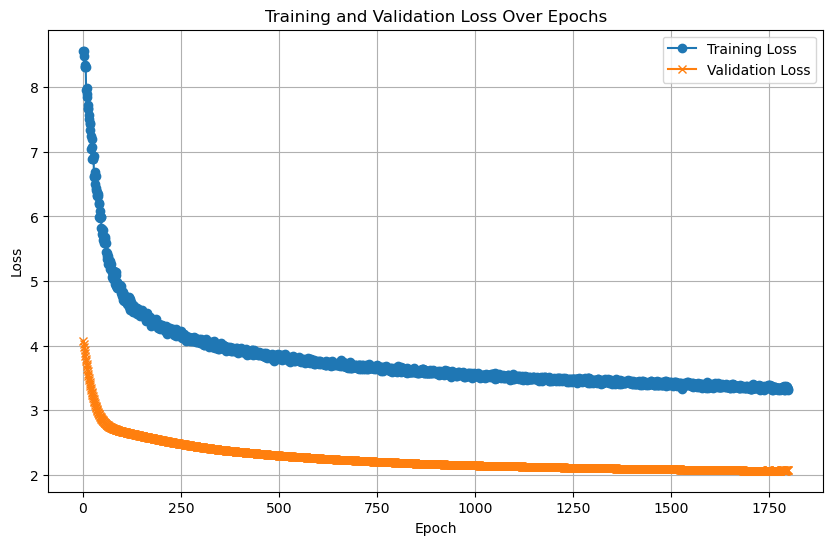

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/578], Loss: 5.2721
Test Batch [20/578], Loss: 5.2080
Test Batch [30/578], Loss: 5.1571
Test Batch [40/578], Loss: 5.0400
Test Batch [50/578], Loss: 5.0709
Test Batch [60/578], Loss: 5.1545
Test Batch [70/578], Loss: 5.1526
Test Batch [80/578], Loss: 5.1686
Test Batch [90/578], Loss: 5.4141
Test Batch [100/578], Loss: 5.3772
Test Batch [110/578], Loss: 5.3348
Test Batch [120/578], Loss: 5.2015
Test Batch [130/578], Loss: 5.1929
Test Batch [140/578], Loss: 5.1565
Test Batch [150/578], Loss: 5.2562
Test Batch [160/578], Loss: 5.1889


Test Batch [170/578], Loss: 5.3103
Test Batch [180/578], Loss: 5.3940
Test Batch [190/578], Loss: 5.1320
Test Batch [200/578], Loss: 5.0647
Test Batch [210/578], Loss: 5.1700
Test Batch [220/578], Loss: 5.0809
Test Batch [230/578], Loss: 5.0518
Test Batch [240/578], Loss: 4.9772
Test Batch [250/578], Loss: 5.0981
Test Batch [260/578], Loss: 5.0559
Test Batch [270/578], Loss: 5.0642
Test Batch [280/578], Loss: 5.4802
Test Batch [290/578], Loss: 4.9712
Test Batch [300/578], Loss: 4.9758
Test Batch [310/578], Loss: 4.9096


Test Batch [320/578], Loss: 5.0198
Test Batch [330/578], Loss: 5.0327
Test Batch [340/578], Loss: 4.9884
Test Batch [350/578], Loss: 5.0096
Test Batch [360/578], Loss: 5.0941
Test Batch [370/578], Loss: 4.8598
Test Batch [380/578], Loss: 5.2494
Test Batch [390/578], Loss: 4.9651
Test Batch [400/578], Loss: 5.1323
Test Batch [410/578], Loss: 5.1501
Test Batch [420/578], Loss: 5.1623


Test Batch [430/578], Loss: 4.9257
Test Batch [440/578], Loss: 4.9889
Test Batch [450/578], Loss: 4.9212
Test Batch [460/578], Loss: 5.1007
Test Batch [470/578], Loss: 5.0254
Test Batch [480/578], Loss: 5.2968
Test Batch [490/578], Loss: 5.1766
Test Batch [500/578], Loss: 5.0274
Test Batch [510/578], Loss: 4.9274
Test Batch [520/578], Loss: 5.0949
Test Batch [530/578], Loss: 5.8674
Test Batch [540/578], Loss: 5.2553
Test Batch [550/578], Loss: 5.3356
Test Batch [560/578], Loss: 5.3105
Test Batch [570/578], Loss: 5.3106

Test Loss: 5.1547


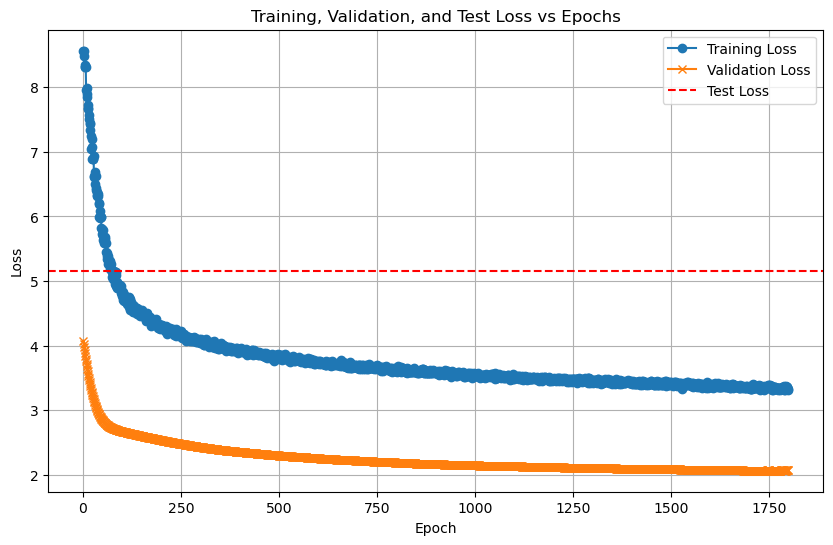

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/578 for test dataset.
  Processed batch 20/578 for test dataset.
  Processed batch 30/578 for test dataset.
  Processed batch 40/578 for test dataset.


  Processed batch 50/578 for test dataset.
  Processed batch 60/578 for test dataset.
  Processed batch 70/578 for test dataset.
  Processed batch 80/578 for test dataset.
  Processed batch 90/578 for test dataset.
  Processed batch 100/578 for test dataset.


  Processed batch 110/578 for test dataset.
  Processed batch 120/578 for test dataset.
  Processed batch 130/578 for test dataset.
  Processed batch 140/578 for test dataset.
  Processed batch 150/578 for test dataset.
  Processed batch 160/578 for test dataset.


  Processed batch 170/578 for test dataset.
  Processed batch 180/578 for test dataset.
  Processed batch 190/578 for test dataset.
  Processed batch 200/578 for test dataset.
  Processed batch 210/578 for test dataset.
  Processed batch 220/578 for test dataset.
  Processed batch 230/578 for test dataset.


  Processed batch 240/578 for test dataset.
  Processed batch 250/578 for test dataset.
  Processed batch 260/578 for test dataset.
  Processed batch 270/578 for test dataset.
  Processed batch 280/578 for test dataset.
  Processed batch 290/578 for test dataset.
  Processed batch 300/578 for test dataset.


  Processed batch 310/578 for test dataset.
  Processed batch 320/578 for test dataset.
  Processed batch 330/578 for test dataset.
  Processed batch 340/578 for test dataset.
  Processed batch 350/578 for test dataset.
  Processed batch 360/578 for test dataset.


  Processed batch 370/578 for test dataset.
  Processed batch 380/578 for test dataset.
  Processed batch 390/578 for test dataset.
  Processed batch 400/578 for test dataset.
  Processed batch 410/578 for test dataset.
  Processed batch 420/578 for test dataset.
  Processed batch 430/578 for test dataset.


  Processed batch 440/578 for test dataset.
  Processed batch 450/578 for test dataset.
  Processed batch 460/578 for test dataset.
  Processed batch 470/578 for test dataset.
  Processed batch 480/578 for test dataset.
  Processed batch 490/578 for test dataset.
  Processed batch 500/578 for test dataset.


  Processed batch 510/578 for test dataset.
  Processed batch 520/578 for test dataset.
  Processed batch 530/578 for test dataset.
  Processed batch 540/578 for test dataset.
  Processed batch 550/578 for test dataset.
  Processed batch 560/578 for test dataset.
  Processed batch 570/578 for test dataset.


Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147927, 128)
Test labels shape: (147927,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 95.56%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.83      1.00      0.91         5
           4       1.00      0.80      0.89         5
           5       1.00      0.80      0.89         5
           6       0.83      1.00      0.91         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45


LOG: Evaluating on the test set...
Test Accuracy: 96.71%



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     65946
           1       0.96      0.91      0.94      7573
           2       0.80      0.88      0.84      3065
           3       0.66      0.89      0.76      2660
           4       0.93      0.89      0.91      6559
           5       0.85      0.94      0.89      9223
           6       0.92      0.86      0.89      7262
           7       1.00      0.98      0.99     42801
           8       0.99      1.00      0.99      2838

    accuracy                           0.97    147927
   macro avg       0.90      0.93      0.91    147927
weighted avg       0.97      0.97      0.97    147927

Saved CAE+LRM predictions and true labels to model_predictions


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147927, 128)
Test labels shape: (147927,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.2219  |  Val Loss: 2.1695
Validation loss improved from inf to 2.1695.
[Epoch 2/1000] Train Loss: 2.1833  |  Val Loss: 2.1338
Validation loss improved from 2.1695 to 2.1338.
[Epoch 3/1000] Train Loss: 2.1454  |  Val Loss: 2.0981
Validation loss improved from 2.1338 to 2.0981.
[Epoch 4/1000] Train Loss: 2.1078  |  Val Loss: 2.0636
Validation loss improved from 2.0981 to 2.0636.
[Epoch 5/1000] Train Loss: 2.0699  |  Val Loss: 2.0299
Validation loss improved from 2.0636 to 2.0299.
[Epoch 6/1000] Train Loss: 2.0336  |  Val Loss: 1.9973
Validation loss improved from 2.0299 to 1.9973.
[Epoch 7/1000] Train Loss: 2.0002  |  Val Loss: 1.9675
Validation loss improved from 1.9973 to 1.9675.
[Epoch 8/1000] Train Loss: 1.9702  |  Val Loss: 1.9385
Validation loss improved from 1.9675 to 1.9385.
[Epoch 9/1000] Train Loss: 1.9392  |  Val Loss: 1.9108
Validation loss improved from 1.9385 to 1.9108.
[Epoch 10/1000] Train Loss: 1.9088  |  Val Loss: 1.8847
Validation loss impr

[Epoch 28/1000] Train Loss: 1.4660  |  Val Loss: 1.4665
Validation loss improved from 1.4881 to 1.4665.
[Epoch 29/1000] Train Loss: 1.4440  |  Val Loss: 1.4453
Validation loss improved from 1.4665 to 1.4453.
[Epoch 30/1000] Train Loss: 1.4235  |  Val Loss: 1.4237
Validation loss improved from 1.4453 to 1.4237.
[Epoch 31/1000] Train Loss: 1.4019  |  Val Loss: 1.4024
Validation loss improved from 1.4237 to 1.4024.
[Epoch 32/1000] Train Loss: 1.3812  |  Val Loss: 1.3808
Validation loss improved from 1.4024 to 1.3808.
[Epoch 33/1000] Train Loss: 1.3597  |  Val Loss: 1.3595
Validation loss improved from 1.3808 to 1.3595.
[Epoch 34/1000] Train Loss: 1.3392  |  Val Loss: 1.3384
Validation loss improved from 1.3595 to 1.3384.
[Epoch 35/1000] Train Loss: 1.3180  |  Val Loss: 1.3178
Validation loss improved from 1.3384 to 1.3178.
[Epoch 36/1000] Train Loss: 1.2976  |  Val Loss: 1.2975
Validation loss improved from 1.3178 to 1.2975.
[Epoch 37/1000] Train Loss: 1.2774  |  Val Loss: 1.2776
Validati

[Epoch 38/1000] Train Loss: 1.2576  |  Val Loss: 1.2580
Validation loss improved from 1.2776 to 1.2580.
[Epoch 39/1000] Train Loss: 1.2381  |  Val Loss: 1.2385
Validation loss improved from 1.2580 to 1.2385.
[Epoch 40/1000] Train Loss: 1.2187  |  Val Loss: 1.2195
Validation loss improved from 1.2385 to 1.2195.
[Epoch 41/1000] Train Loss: 1.1996  |  Val Loss: 1.2009
Validation loss improved from 1.2195 to 1.2009.
[Epoch 42/1000] Train Loss: 1.1809  |  Val Loss: 1.1827
Validation loss improved from 1.2009 to 1.1827.
[Epoch 43/1000] Train Loss: 1.1620  |  Val Loss: 1.1651
Validation loss improved from 1.1827 to 1.1651.
[Epoch 44/1000] Train Loss: 1.1441  |  Val Loss: 1.1474
Validation loss improved from 1.1651 to 1.1474.
[Epoch 45/1000] Train Loss: 1.1258  |  Val Loss: 1.1302
Validation loss improved from 1.1474 to 1.1302.
[Epoch 46/1000] Train Loss: 1.1085  |  Val Loss: 1.1132
Validation loss improved from 1.1302 to 1.1132.
[Epoch 47/1000] Train Loss: 1.0912  |  Val Loss: 1.0967
Validati

[Epoch 59/1000] Train Loss: 0.9123  |  Val Loss: 0.9274
Validation loss improved from 0.9399 to 0.9274.
[Epoch 60/1000] Train Loss: 0.8991  |  Val Loss: 0.9151
Validation loss improved from 0.9274 to 0.9151.
[Epoch 61/1000] Train Loss: 0.8860  |  Val Loss: 0.9028
Validation loss improved from 0.9151 to 0.9028.
[Epoch 62/1000] Train Loss: 0.8732  |  Val Loss: 0.8907
Validation loss improved from 0.9028 to 0.8907.
[Epoch 63/1000] Train Loss: 0.8608  |  Val Loss: 0.8789
Validation loss improved from 0.8907 to 0.8789.
[Epoch 64/1000] Train Loss: 0.8484  |  Val Loss: 0.8674
Validation loss improved from 0.8789 to 0.8674.
[Epoch 65/1000] Train Loss: 0.8366  |  Val Loss: 0.8562
Validation loss improved from 0.8674 to 0.8562.
[Epoch 66/1000] Train Loss: 0.8247  |  Val Loss: 0.8452
Validation loss improved from 0.8562 to 0.8452.
[Epoch 67/1000] Train Loss: 0.8133  |  Val Loss: 0.8344
Validation loss improved from 0.8452 to 0.8344.


[Epoch 68/1000] Train Loss: 0.8019  |  Val Loss: 0.8238
Validation loss improved from 0.8344 to 0.8238.
[Epoch 69/1000] Train Loss: 0.7909  |  Val Loss: 0.8135
Validation loss improved from 0.8238 to 0.8135.
[Epoch 70/1000] Train Loss: 0.7800  |  Val Loss: 0.8033
Validation loss improved from 0.8135 to 0.8033.
[Epoch 71/1000] Train Loss: 0.7692  |  Val Loss: 0.7932
Validation loss improved from 0.8033 to 0.7932.
[Epoch 72/1000] Train Loss: 0.7586  |  Val Loss: 0.7836
Validation loss improved from 0.7932 to 0.7836.
[Epoch 73/1000] Train Loss: 0.7484  |  Val Loss: 0.7737
Validation loss improved from 0.7836 to 0.7737.
[Epoch 74/1000] Train Loss: 0.7383  |  Val Loss: 0.7642
Validation loss improved from 0.7737 to 0.7642.
[Epoch 75/1000] Train Loss: 0.7279  |  Val Loss: 0.7545
Validation loss improved from 0.7642 to 0.7545.
[Epoch 76/1000] Train Loss: 0.7178  |  Val Loss: 0.7451
Validation loss improved from 0.7545 to 0.7451.
[Epoch 77/1000] Train Loss: 0.7078  |  Val Loss: 0.7355
Validati

[Epoch 91/1000] Train Loss: 0.5788  |  Val Loss: 0.6199
Validation loss improved from 0.6273 to 0.6199.
[Epoch 92/1000] Train Loss: 0.5704  |  Val Loss: 0.6124
Validation loss improved from 0.6199 to 0.6124.
[Epoch 93/1000] Train Loss: 0.5624  |  Val Loss: 0.6051
Validation loss improved from 0.6124 to 0.6051.
[Epoch 94/1000] Train Loss: 0.5540  |  Val Loss: 0.5979
Validation loss improved from 0.6051 to 0.5979.
[Epoch 95/1000] Train Loss: 0.5459  |  Val Loss: 0.5907
Validation loss improved from 0.5979 to 0.5907.
[Epoch 96/1000] Train Loss: 0.5378  |  Val Loss: 0.5836
Validation loss improved from 0.5907 to 0.5836.
[Epoch 97/1000] Train Loss: 0.5299  |  Val Loss: 0.5765
Validation loss improved from 0.5836 to 0.5765.
[Epoch 98/1000] Train Loss: 0.5220  |  Val Loss: 0.5695
Validation loss improved from 0.5765 to 0.5695.


[Epoch 99/1000] Train Loss: 0.5143  |  Val Loss: 0.5626
Validation loss improved from 0.5695 to 0.5626.
[Epoch 100/1000] Train Loss: 0.5068  |  Val Loss: 0.5557
Validation loss improved from 0.5626 to 0.5557.
[Epoch 101/1000] Train Loss: 0.4992  |  Val Loss: 0.5486
Validation loss improved from 0.5557 to 0.5486.
[Epoch 102/1000] Train Loss: 0.4920  |  Val Loss: 0.5417
Validation loss improved from 0.5486 to 0.5417.
[Epoch 103/1000] Train Loss: 0.4845  |  Val Loss: 0.5352
Validation loss improved from 0.5417 to 0.5352.
[Epoch 104/1000] Train Loss: 0.4774  |  Val Loss: 0.5287
Validation loss improved from 0.5352 to 0.5287.
[Epoch 105/1000] Train Loss: 0.4701  |  Val Loss: 0.5223
Validation loss improved from 0.5287 to 0.5223.
[Epoch 106/1000] Train Loss: 0.4630  |  Val Loss: 0.5161
Validation loss improved from 0.5223 to 0.5161.
[Epoch 107/1000] Train Loss: 0.4563  |  Val Loss: 0.5098
Validation loss improved from 0.5161 to 0.5098.
[Epoch 108/1000] Train Loss: 0.4493  |  Val Loss: 0.5036

[Epoch 121/1000] Train Loss: 0.3686  |  Val Loss: 0.4281
Validation loss improved from 0.4334 to 0.4281.
[Epoch 122/1000] Train Loss: 0.3630  |  Val Loss: 0.4230
Validation loss improved from 0.4281 to 0.4230.
[Epoch 123/1000] Train Loss: 0.3573  |  Val Loss: 0.4180
Validation loss improved from 0.4230 to 0.4180.
[Epoch 124/1000] Train Loss: 0.3520  |  Val Loss: 0.4130
Validation loss improved from 0.4180 to 0.4130.
[Epoch 125/1000] Train Loss: 0.3466  |  Val Loss: 0.4080
Validation loss improved from 0.4130 to 0.4080.
[Epoch 126/1000] Train Loss: 0.3412  |  Val Loss: 0.4031
Validation loss improved from 0.4080 to 0.4031.
[Epoch 127/1000] Train Loss: 0.3360  |  Val Loss: 0.3983
Validation loss improved from 0.4031 to 0.3983.
[Epoch 128/1000] Train Loss: 0.3308  |  Val Loss: 0.3935
Validation loss improved from 0.3983 to 0.3935.


[Epoch 129/1000] Train Loss: 0.3257  |  Val Loss: 0.3887
Validation loss improved from 0.3935 to 0.3887.
[Epoch 130/1000] Train Loss: 0.3205  |  Val Loss: 0.3842
Validation loss improved from 0.3887 to 0.3842.
[Epoch 131/1000] Train Loss: 0.3151  |  Val Loss: 0.3799
Validation loss improved from 0.3842 to 0.3799.
[Epoch 132/1000] Train Loss: 0.3100  |  Val Loss: 0.3755
Validation loss improved from 0.3799 to 0.3755.
[Epoch 133/1000] Train Loss: 0.3048  |  Val Loss: 0.3714
Validation loss improved from 0.3755 to 0.3714.
[Epoch 134/1000] Train Loss: 0.3004  |  Val Loss: 0.3681
Validation loss improved from 0.3714 to 0.3681.
[Epoch 135/1000] Train Loss: 0.2955  |  Val Loss: 0.3645
Validation loss improved from 0.3681 to 0.3645.
[Epoch 136/1000] Train Loss: 0.2912  |  Val Loss: 0.3611
Validation loss improved from 0.3645 to 0.3611.
[Epoch 137/1000] Train Loss: 0.2871  |  Val Loss: 0.3578
Validation loss improved from 0.3611 to 0.3578.
[Epoch 138/1000] Train Loss: 0.2828  |  Val Loss: 0.354

[Epoch 150/1000] Train Loss: 0.2386  |  Val Loss: 0.3150
Validation loss improved from 0.3179 to 0.3150.
[Epoch 151/1000] Train Loss: 0.2352  |  Val Loss: 0.3123
Validation loss improved from 0.3150 to 0.3123.
[Epoch 152/1000] Train Loss: 0.2323  |  Val Loss: 0.3097
Validation loss improved from 0.3123 to 0.3097.
[Epoch 153/1000] Train Loss: 0.2291  |  Val Loss: 0.3070
Validation loss improved from 0.3097 to 0.3070.
[Epoch 154/1000] Train Loss: 0.2260  |  Val Loss: 0.3046
Validation loss improved from 0.3070 to 0.3046.
[Epoch 155/1000] Train Loss: 0.2230  |  Val Loss: 0.3021
Validation loss improved from 0.3046 to 0.3021.
[Epoch 156/1000] Train Loss: 0.2200  |  Val Loss: 0.2996
Validation loss improved from 0.3021 to 0.2996.
[Epoch 157/1000] Train Loss: 0.2172  |  Val Loss: 0.2976
Validation loss improved from 0.2996 to 0.2976.
[Epoch 158/1000] Train Loss: 0.2143  |  Val Loss: 0.2956
Validation loss improved from 0.2976 to 0.2956.
[Epoch 159/1000] Train Loss: 0.2116  |  Val Loss: 0.293

[Epoch 161/1000] Train Loss: 0.2060  |  Val Loss: 0.2890
Validation loss improved from 0.2912 to 0.2890.
[Epoch 162/1000] Train Loss: 0.2034  |  Val Loss: 0.2870
Validation loss improved from 0.2890 to 0.2870.
[Epoch 163/1000] Train Loss: 0.2010  |  Val Loss: 0.2849
Validation loss improved from 0.2870 to 0.2849.
[Epoch 164/1000] Train Loss: 0.1985  |  Val Loss: 0.2832
Validation loss improved from 0.2849 to 0.2832.
[Epoch 165/1000] Train Loss: 0.1957  |  Val Loss: 0.2811
Validation loss improved from 0.2832 to 0.2811.
[Epoch 166/1000] Train Loss: 0.1934  |  Val Loss: 0.2792
Validation loss improved from 0.2811 to 0.2792.
[Epoch 167/1000] Train Loss: 0.1910  |  Val Loss: 0.2774
Validation loss improved from 0.2792 to 0.2774.
[Epoch 168/1000] Train Loss: 0.1887  |  Val Loss: 0.2757
Validation loss improved from 0.2774 to 0.2757.
[Epoch 169/1000] Train Loss: 0.1862  |  Val Loss: 0.2740
Validation loss improved from 0.2757 to 0.2740.
[Epoch 170/1000] Train Loss: 0.1840  |  Val Loss: 0.272

[Epoch 180/1000] Train Loss: 0.1636  |  Val Loss: 0.2573
Validation loss improved from 0.2587 to 0.2573.
[Epoch 181/1000] Train Loss: 0.1620  |  Val Loss: 0.2556
Validation loss improved from 0.2573 to 0.2556.
[Epoch 182/1000] Train Loss: 0.1599  |  Val Loss: 0.2544
Validation loss improved from 0.2556 to 0.2544.
[Epoch 183/1000] Train Loss: 0.1581  |  Val Loss: 0.2533
Validation loss improved from 0.2544 to 0.2533.
[Epoch 184/1000] Train Loss: 0.1565  |  Val Loss: 0.2525
Validation loss improved from 0.2533 to 0.2525.
[Epoch 185/1000] Train Loss: 0.1548  |  Val Loss: 0.2513
Validation loss improved from 0.2525 to 0.2513.
[Epoch 186/1000] Train Loss: 0.1530  |  Val Loss: 0.2503
Validation loss improved from 0.2513 to 0.2503.
[Epoch 187/1000] Train Loss: 0.1514  |  Val Loss: 0.2485
Validation loss improved from 0.2503 to 0.2485.
[Epoch 188/1000] Train Loss: 0.1496  |  Val Loss: 0.2471
Validation loss improved from 0.2485 to 0.2471.
[Epoch 189/1000] Train Loss: 0.1480  |  Val Loss: 0.246

[Epoch 190/1000] Train Loss: 0.1465  |  Val Loss: 0.2448
Validation loss improved from 0.2464 to 0.2448.
[Epoch 191/1000] Train Loss: 0.1448  |  Val Loss: 0.2438
Validation loss improved from 0.2448 to 0.2438.
[Epoch 192/1000] Train Loss: 0.1434  |  Val Loss: 0.2429
Validation loss improved from 0.2438 to 0.2429.
[Epoch 193/1000] Train Loss: 0.1419  |  Val Loss: 0.2420
Validation loss improved from 0.2429 to 0.2420.
[Epoch 194/1000] Train Loss: 0.1403  |  Val Loss: 0.2407
Validation loss improved from 0.2420 to 0.2407.
[Epoch 195/1000] Train Loss: 0.1388  |  Val Loss: 0.2395
Validation loss improved from 0.2407 to 0.2395.
[Epoch 196/1000] Train Loss: 0.1374  |  Val Loss: 0.2381
Validation loss improved from 0.2395 to 0.2381.
[Epoch 197/1000] Train Loss: 0.1360  |  Val Loss: 0.2371
Validation loss improved from 0.2381 to 0.2371.
[Epoch 198/1000] Train Loss: 0.1347  |  Val Loss: 0.2364
Validation loss improved from 0.2371 to 0.2364.
[Epoch 199/1000] Train Loss: 0.1331  |  Val Loss: 0.235

[Epoch 211/1000] Train Loss: 0.1182  |  Val Loss: 0.2254
Validation loss improved from 0.2262 to 0.2254.
[Epoch 212/1000] Train Loss: 0.1171  |  Val Loss: 0.2248
Validation loss improved from 0.2254 to 0.2248.
[Epoch 213/1000] Train Loss: 0.1159  |  Val Loss: 0.2242
Validation loss improved from 0.2248 to 0.2242.
[Epoch 214/1000] Train Loss: 0.1149  |  Val Loss: 0.2237
Validation loss improved from 0.2242 to 0.2237.
[Epoch 215/1000] Train Loss: 0.1138  |  Val Loss: 0.2233
Validation loss improved from 0.2237 to 0.2233.
[Epoch 216/1000] Train Loss: 0.1126  |  Val Loss: 0.2229
Validation loss improved from 0.2233 to 0.2229.
[Epoch 217/1000] Train Loss: 0.1116  |  Val Loss: 0.2226
Validation loss improved from 0.2229 to 0.2226.
[Epoch 218/1000] Train Loss: 0.1107  |  Val Loss: 0.2223
Validation loss improved from 0.2226 to 0.2223.
[Epoch 219/1000] Train Loss: 0.1095  |  Val Loss: 0.2215
Validation loss improved from 0.2223 to 0.2215.
[Epoch 220/1000] Train Loss: 0.1088  |  Val Loss: 0.220

[Epoch 223/1000] Train Loss: 0.1054  |  Val Loss: 0.2190
Validation loss improved from 0.2194 to 0.2190.
[Epoch 224/1000] Train Loss: 0.1046  |  Val Loss: 0.2187
Validation loss improved from 0.2190 to 0.2187.
[Epoch 225/1000] Train Loss: 0.1037  |  Val Loss: 0.2182
Validation loss improved from 0.2187 to 0.2182.
[Epoch 226/1000] Train Loss: 0.1027  |  Val Loss: 0.2174
Validation loss improved from 0.2182 to 0.2174.
[Epoch 227/1000] Train Loss: 0.1019  |  Val Loss: 0.2166
Validation loss improved from 0.2174 to 0.2166.
[Epoch 228/1000] Train Loss: 0.1008  |  Val Loss: 0.2161
Validation loss improved from 0.2166 to 0.2161.
[Epoch 229/1000] Train Loss: 0.0999  |  Val Loss: 0.2156
Validation loss improved from 0.2161 to 0.2156.
[Epoch 230/1000] Train Loss: 0.0992  |  Val Loss: 0.2153
Validation loss improved from 0.2156 to 0.2153.
[Epoch 231/1000] Train Loss: 0.0981  |  Val Loss: 0.2150
Validation loss improved from 0.2153 to 0.2150.
[Epoch 232/1000] Train Loss: 0.0972  |  Val Loss: 0.214

[Epoch 246/1000] Train Loss: 0.0859  |  Val Loss: 0.2093
Validation loss improved from 0.2095 to 0.2093.
[Epoch 247/1000] Train Loss: 0.0852  |  Val Loss: 0.2091
Validation loss improved from 0.2093 to 0.2091.
[Epoch 248/1000] Train Loss: 0.0844  |  Val Loss: 0.2090
Validation loss improved from 0.2091 to 0.2090.
[Epoch 249/1000] Train Loss: 0.0837  |  Val Loss: 0.2092
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 250/1000] Train Loss: 0.0830  |  Val Loss: 0.2089
Validation loss improved from 0.2090 to 0.2089.
[Epoch 251/1000] Train Loss: 0.0822  |  Val Loss: 0.2085
Validation loss improved from 0.2089 to 0.2085.
[Epoch 252/1000] Train Loss: 0.0816  |  Val Loss: 0.2085
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 253/1000] Train Loss: 0.0808  |  Val Loss: 0.2079
Validation loss improved from 0.2085 to 0.2079.


[Epoch 254/1000] Train Loss: 0.0801  |  Val Loss: 0.2076
Validation loss improved from 0.2079 to 0.2076.
[Epoch 255/1000] Train Loss: 0.0795  |  Val Loss: 0.2074
Validation loss improved from 0.2076 to 0.2074.
[Epoch 256/1000] Train Loss: 0.0788  |  Val Loss: 0.2070
Validation loss improved from 0.2074 to 0.2070.
[Epoch 257/1000] Train Loss: 0.0781  |  Val Loss: 0.2067
Validation loss improved from 0.2070 to 0.2067.
[Epoch 258/1000] Train Loss: 0.0775  |  Val Loss: 0.2067
Validation loss improved from 0.2067 to 0.2067.
[Epoch 259/1000] Train Loss: 0.0769  |  Val Loss: 0.2067
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 260/1000] Train Loss: 0.0762  |  Val Loss: 0.2062
Validation loss improved from 0.2067 to 0.2062.
[Epoch 261/1000] Train Loss: 0.0758  |  Val Loss: 0.2058
Validation loss improved from 0.2062 to 0.2058.
[Epoch 262/1000] Train Loss: 0.0750  |  Val Loss: 0.2060
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 263/1000] Train Loss: 0.0744  |  Val

[Epoch 277/1000] Train Loss: 0.0667  |  Val Loss: 0.2036
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 278/1000] Train Loss: 0.0662  |  Val Loss: 0.2039
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 279/1000] Train Loss: 0.0658  |  Val Loss: 0.2037
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 280/1000] Train Loss: 0.0651  |  Val Loss: 0.2039
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 281/1000] Train Loss: 0.0647  |  Val Loss: 0.2041
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 282/1000] Train Loss: 0.0643  |  Val Loss: 0.2040
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 283/1000] Train Loss: 0.0638  |  Val Loss: 0.2044
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 284/1000] Train Loss: 0.0633  |  Val Loss: 0.2042
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 285/1000] Train Loss: 0.0629  |  Val Loss: 0.2036
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 286/1000] Train Loss: 0.0625  |  Val Loss: 0.2034
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 287/1000] Train Loss: 0.0619  |  Val Loss: 0.2030
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 288/1000] Train Loss: 0.0615  |  Val Loss: 0.2027
Validation loss improved from 0.2029 to 0.2027.
[Epoch 289/1000] Train Loss: 0.0610  |  Val Loss: 0.2028
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 290/1000] Train Loss: 0.0606  |  Val Loss: 0.2028
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 291/1000] Train Loss: 0.0600  |  Val Loss: 0.2029
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 292/1000] Train Loss: 0.0596  |  Val Loss: 0.2033
!! Validation loss did NOT improve !! Patience: 4/100
[Ep

[Epoch 305/1000] Train Loss: 0.0543  |  Val Loss: 0.2035
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 306/1000] Train Loss: 0.0539  |  Val Loss: 0.2036
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 307/1000] Train Loss: 0.0535  |  Val Loss: 0.2033
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 308/1000] Train Loss: 0.0531  |  Val Loss: 0.2033
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 309/1000] Train Loss: 0.0528  |  Val Loss: 0.2030
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 310/1000] Train Loss: 0.0524  |  Val Loss: 0.2030
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 311/1000] Train Loss: 0.0520  |  Val Loss: 0.2029
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 312/1000] Train Loss: 0.0517  |  Val Loss: 0.2030
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 313/1000] Train Loss: 0.0514  |  Val Loss: 0.2032
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 314/1000] Train Loss: 0.0510  |  Val Loss: 0.2032
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 315/1000] Train Loss: 0.0508  |  Val Loss: 0.2039
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 316/1000] Train Loss: 0.0505  |  Val Loss: 0.2043
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 317/1000] Train Loss: 0.0500  |  Val Loss: 0.2040
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 318/1000] Train Loss: 0.0497  |  Val Loss: 0.2036
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 319/1000] Train Loss: 0.0493  |  Val Loss: 0.2035
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 320/1000] Train Loss: 0.0490  |  Val Loss: 0.2035
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 321/1000] Train Loss: 0.0486  |  Val Loss: 0.2037
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 322/1000] Train Loss: 0.0484  |  Val Loss: 0.2046
!! Validation loss did NOT improve !! Patience:

[Epoch 336/1000] Train Loss: 0.0443  |  Val Loss: 0.2059
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 337/1000] Train Loss: 0.0439  |  Val Loss: 0.2064
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 338/1000] Train Loss: 0.0437  |  Val Loss: 0.2069
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 339/1000] Train Loss: 0.0435  |  Val Loss: 0.2071
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 340/1000] Train Loss: 0.0432  |  Val Loss: 0.2071
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 341/1000] Train Loss: 0.0430  |  Val Loss: 0.2066
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 342/1000] Train Loss: 0.0426  |  Val Loss: 0.2066
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 343/1000] Train Loss: 0.0424  |  Val Loss: 0.2069
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 344/1000] Train Loss: 0.0423  |  Val Loss: 0.2076
!! Validation loss did NOT improve !! Patience:

[Epoch 345/1000] Train Loss: 0.0420  |  Val Loss: 0.2071
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 346/1000] Train Loss: 0.0417  |  Val Loss: 0.2077
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 347/1000] Train Loss: 0.0414  |  Val Loss: 0.2079
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 348/1000] Train Loss: 0.0413  |  Val Loss: 0.2076
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 349/1000] Train Loss: 0.0409  |  Val Loss: 0.2080
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 350/1000] Train Loss: 0.0408  |  Val Loss: 0.2080
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 351/1000] Train Loss: 0.0404  |  Val Loss: 0.2082
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 352/1000] Train Loss: 0.0402  |  Val Loss: 0.2085
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 353/1000] Train Loss: 0.0400  |  Val Loss: 0.2087
!! Validation loss did NOT improve !! Patience:

[Epoch 366/1000] Train Loss: 0.0371  |  Val Loss: 0.2110
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 367/1000] Train Loss: 0.0369  |  Val Loss: 0.2112
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 368/1000] Train Loss: 0.0367  |  Val Loss: 0.2122
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 369/1000] Train Loss: 0.0365  |  Val Loss: 0.2124
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 370/1000] Train Loss: 0.0364  |  Val Loss: 0.2126
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 371/1000] Train Loss: 0.0361  |  Val Loss: 0.2128
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 372/1000] Train Loss: 0.0360  |  Val Loss: 0.2124
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 373/1000] Train Loss: 0.0358  |  Val Loss: 0.2124
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 374/1000] Train Loss: 0.0355  |  Val Loss: 0.2127
!! Validation loss did NOT improve !! Patience:

[Epoch 380/1000] Train Loss: 0.0345  |  Val Loss: 0.2133
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 381/1000] Train Loss: 0.0343  |  Val Loss: 0.2136
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 382/1000] Train Loss: 0.0341  |  Val Loss: 0.2138
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 383/1000] Train Loss: 0.0339  |  Val Loss: 0.2139
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 384/1000] Train Loss: 0.0337  |  Val Loss: 0.2144
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 385/1000] Train Loss: 0.0336  |  Val Loss: 0.2152
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 386/1000] Train Loss: 0.0334  |  Val Loss: 0.2156
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 387/1000] Train Loss: 0.0332  |  Val Loss: 0.2159
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 388/1000] Train Loss: 0.0330  |  Val Loss: 0.2164
!! Validation loss did NOT improve !! Patience:

[Epoch 397/1000] Train Loss: 0.0316  |  Val Loss: 0.2175
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 398/1000] Train Loss: 0.0314  |  Val Loss: 0.2179
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 399/1000] Train Loss: 0.0313  |  Val Loss: 0.2186
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 400/1000] Train Loss: 0.0310  |  Val Loss: 0.2189
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 401/1000] Train Loss: 0.0310  |  Val Loss: 0.2185
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 402/1000] Train Loss: 0.0309  |  Val Loss: 0.2189
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 402 !!
No improvement for 100 epochs.


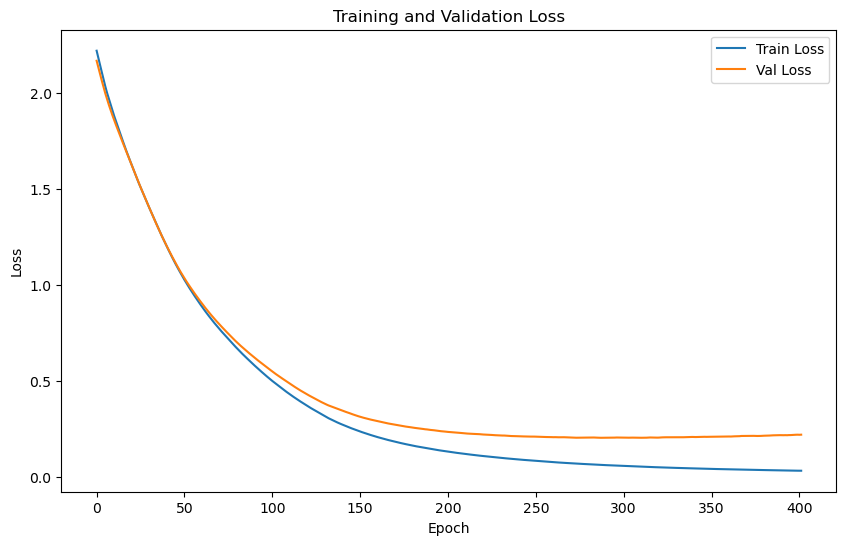

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.1331 | Test Accuracy: 96.64%


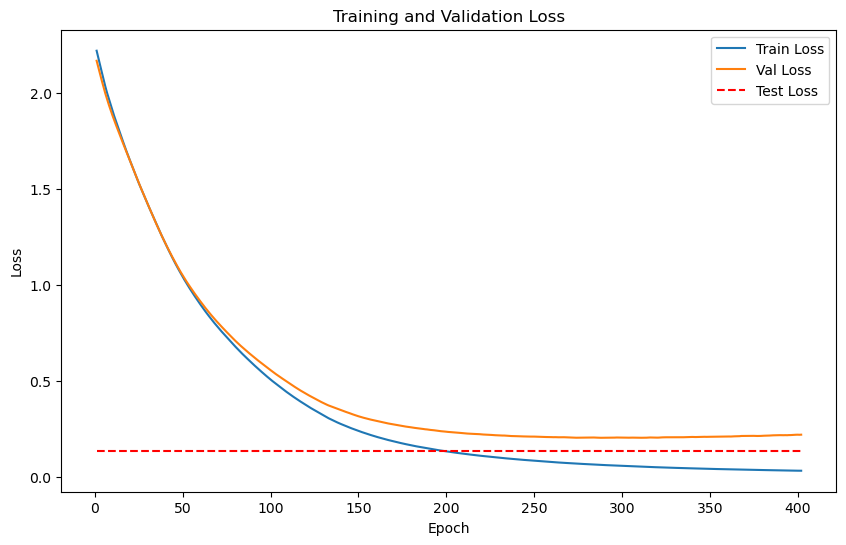

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 147927 samples with 64 features each
LOG: Labels shape: (147927,)


Train embeddings shape: (180, 64), 
Train labels shape: (180,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (147927, 64), 
Test labels shape: (147927,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4591
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.4109
Epoch [1/2000], Avg Train Loss: 0.4591, Avg Val Loss: 0.4109

Validation loss improved from inf to 0.4109. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 0.4581
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.4104
Epoch [2/2000], Avg Train Loss: 0.4581, Avg Val Loss: 0.4104

Validation loss improved from 0.4109 to 0.4104. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4586
LOG: Epoch [3/2000] - Validation
    Batch [1/1], Val Loss: 0.4097
Epoch [3/2000], Avg Train Loss: 0.4586, Avg Val Loss: 0.4097

Validation loss improved from 0.4104 to 0.4097. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.4521
LOG: Epoch [4/2000] - Validation
    Batch [1/1], Val Loss: 0.4089
Epoch [4/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.4089

Validation loss improved from 0.4097 to 0.4089. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4534
LOG: Epoch [5/2000] - Validation
    Batch [1/1], Val Loss: 0.4083
Epoch [5/2000], Avg Train Loss: 0.4534, Avg Val Loss: 0.4083

Validation loss improved from 0.4089 to 0.4083. Saving model...
LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 0.4578
LOG: Epoch [6/2000] - Validation
    Batch [1/1], Val Loss: 0.4083
Epoch [6/2000], Avg Train Loss: 0.4578, Avg Val Loss: 0.4083

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4520
LOG: Epoch [7/2000] - Validation
    Batch [1/1], Val Loss: 0.4083
Epoch [7/2000], Avg Train Loss: 0.4520, Avg Val Loss: 0.4083

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 0.4511
LOG: Epoch [8/2000] - Validation
    Batch [1/1], Val Loss: 0.4080
Epoch [8/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.4080

Validation loss improved from 0.4083 to 0.4080. Saving model...
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.4525
LOG: Epoch [9/2000] - Validation


    Batch [1/1], Val Loss: 0.4075
Epoch [9/2000], Avg Train Loss: 0.4525, Avg Val Loss: 0.4075

Validation loss improved from 0.4080 to 0.4075. Saving model...
LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [10/2000] - Validation
    Batch [1/1], Val Loss: 0.4066
Epoch [10/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.4066

Validation loss improved from 0.4075 to 0.4066. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [11/2000] - Validation
    Batch [1/1], Val Loss: 0.4058
Epoch [11/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.4058

Validation loss improved from 0.4066 to 0.4058. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4507
LOG: Epoch [12/2000] - Validation
    Batch [1/1], Val Loss: 0.4050
Epoch [12/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.4050

Validation loss improved from 0.4058 to 0.4050. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 0.4481
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.4045
Epoch [13/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.4045

Validation loss improved from 0.4050 to 0.4045. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 0.4467
LOG: Epoch [14/2000] - Validation


    Batch [1/1], Val Loss: 0.4041
Epoch [14/2000], Avg Train Loss: 0.4467, Avg Val Loss: 0.4041

Validation loss improved from 0.4045 to 0.4041. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [15/2000] - Validation
    Batch [1/1], Val Loss: 0.4037
Epoch [15/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.4037

Validation loss improved from 0.4041 to 0.4037. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 0.4483
LOG: Epoch [16/2000] - Validation
    Batch [1/1], Val Loss: 0.4033
Epoch [16/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.4033

Validation loss improved from 0.4037 to 0.4033. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4423
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.4028
Epoch [17/2000], Avg Train Loss: 0.4423, Avg Val Loss: 0.4028

Validation loss improved from 0.4033 to 0.4028. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [18/2000] - Validation
    Batch [1/1], Val Loss: 0.4023
Epoch [18/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.4023

Validation loss improved from 0.4028 to 0.4023. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.4388
LOG: Epoch [19/2000] - Validation


    Batch [1/1], Val Loss: 0.4016
Epoch [19/2000], Avg Train Loss: 0.4388, Avg Val Loss: 0.4016

Validation loss improved from 0.4023 to 0.4016. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.4402
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.4008
Epoch [20/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.4008

Validation loss improved from 0.4016 to 0.4008. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.4375
LOG: Epoch [21/2000] - Validation


    Batch [1/1], Val Loss: 0.4000
Epoch [21/2000], Avg Train Loss: 0.4375, Avg Val Loss: 0.4000

Validation loss improved from 0.4008 to 0.4000. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.4389
LOG: Epoch [22/2000] - Validation
    Batch [1/1], Val Loss: 0.3992
Epoch [22/2000], Avg Train Loss: 0.4389, Avg Val Loss: 0.3992

Validation loss improved from 0.4000 to 0.3992. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.3984
Epoch [23/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.3984

Validation loss improved from 0.3992 to 0.3984. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4376
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.3976
Epoch [24/2000], Avg Train Loss: 0.4376, Avg Val Loss: 0.3976

Validation loss improved from 0.3984 to 0.3976. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.4384
LOG: Epoch [25/2000] - Validation
    Batch [1/1], Val Loss: 0.3969
Epoch [25/2000], Avg Train Loss: 0.4384, Avg Val Loss: 0.3969

Validation loss improved from 0.3976 to 0.3969. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.4386
LOG: Epoch [26/2000] - Validation


    Batch [1/1], Val Loss: 0.3961
Epoch [26/2000], Avg Train Loss: 0.4386, Avg Val Loss: 0.3961

Validation loss improved from 0.3969 to 0.3961. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.4336
LOG: Epoch [27/2000] - Validation
    Batch [1/1], Val Loss: 0.3954
Epoch [27/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.3954

Validation loss improved from 0.3961 to 0.3954. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.4401
LOG: Epoch [28/2000] - Validation


    Batch [1/1], Val Loss: 0.3946
Epoch [28/2000], Avg Train Loss: 0.4401, Avg Val Loss: 0.3946

Validation loss improved from 0.3954 to 0.3946. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.4342
LOG: Epoch [29/2000] - Validation
    Batch [1/1], Val Loss: 0.3938
Epoch [29/2000], Avg Train Loss: 0.4342, Avg Val Loss: 0.3938

Validation loss improved from 0.3946 to 0.3938. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.4335
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.3930
Epoch [30/2000], Avg Train Loss: 0.4335, Avg Val Loss: 0.3930

Validation loss improved from 0.3938 to 0.3930. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4332
LOG: Epoch [31/2000] - Validation
    Batch [1/1], Val Loss: 0.3922
Epoch [31/2000], Avg Train Loss: 0.4332, Avg Val Loss: 0.3922

Validation loss improved from 0.3930 to 0.3922. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.4319
LOG: Epoch [32/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [32/2000], Avg Train Loss: 0.4319, Avg Val Loss: 0.3913

Validation loss improved from 0.3922 to 0.3913. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.4305
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.3905
Epoch [33/2000], Avg Train Loss: 0.4305, Avg Val Loss: 0.3905

Validation loss improved from 0.3913 to 0.3905. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4289
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.3897
Epoch [34/2000], Avg Train Loss: 0.4289, Avg Val Loss: 0.3897

Validation loss improved from 0.3905 to 0.3897. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 0.4304
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.3888
Epoch [35/2000], Avg Train Loss: 0.4304, Avg Val Loss: 0.3888

Validation loss improved from 0.3897 to 0.3888. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4216
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.3880
Epoch [36/2000], Avg Train Loss: 0.4216, Avg Val Loss: 0.3880

Validation loss improved from 0.3888 to 0.3880. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.4240
LOG: Epoch [37/2000] - Validation
    Batch [1/1], Val Loss: 0.3871
Epoch [37/2000], Avg Train Loss: 0.4240, Avg Val Loss: 0.3871

Validation loss improved from 0.3880 to 0.3871. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.4245
LOG: Epoch [38/2000] - Validation


    Batch [1/1], Val Loss: 0.3863
Epoch [38/2000], Avg Train Loss: 0.4245, Avg Val Loss: 0.3863

Validation loss improved from 0.3871 to 0.3863. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.4245
LOG: Epoch [39/2000] - Validation
    Batch [1/1], Val Loss: 0.3855
Epoch [39/2000], Avg Train Loss: 0.4245, Avg Val Loss: 0.3855

Validation loss improved from 0.3863 to 0.3855. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.4224
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.3847
Epoch [40/2000], Avg Train Loss: 0.4224, Avg Val Loss: 0.3847

Validation loss improved from 0.3855 to 0.3847. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4198
LOG: Epoch [41/2000] - Validation
    Batch [1/1], Val Loss: 0.3839
Epoch [41/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.3839

Validation loss improved from 0.3847 to 0.3839. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.4208
LOG: Epoch [42/2000] - Validation
    Batch [1/1], Val Loss: 0.3831
Epoch [42/2000], Avg Train Loss: 0.4208, Avg Val Loss: 0.3831

Validation loss improved from 0.3839 to 0.3831. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4222
LOG: Epoch [43/2000] - Validation
    Batch [1/1], Val Loss: 0.3824
Epoch [43/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.3824

Validation loss improved from 0.3831 to 0.3824. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 0.4250
LOG: Epoch [44/2000] - Validation
    Batch [1/1], Val Loss: 0.3816
Epoch [44/2000], Avg Train Loss: 0.4250, Avg Val Loss: 0.3816

Validation loss improved from 0.3824 to 0.3816. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4175
LOG: Epoch [45/2000] - Validation
    Batch [1/1], Val Loss: 0.3808
Epoch [45/2000], Avg Train Loss: 0.4175, Avg Val Loss: 0.3808

Validation loss improved from 0.3816 to 0.3808. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.4131
LOG: Epoch [46/2000] - Validation
    Batch [1/1], Val Loss: 0.3800
Epoch [46/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.3800

Validation loss improved from 0.3808 to 0.3800. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.4163
LOG: Epoch [47/2000] - Validation


    Batch [1/1], Val Loss: 0.3793
Epoch [47/2000], Avg Train Loss: 0.4163, Avg Val Loss: 0.3793

Validation loss improved from 0.3800 to 0.3793. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.4169
LOG: Epoch [48/2000] - Validation
    Batch [1/1], Val Loss: 0.3785
Epoch [48/2000], Avg Train Loss: 0.4169, Avg Val Loss: 0.3785

Validation loss improved from 0.3793 to 0.3785. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.4143
LOG: Epoch [49/2000] - Validation
    Batch [1/1], Val Loss: 0.3777
Epoch [49/2000], Avg Train Loss: 0.4143, Avg Val Loss: 0.3777

Validation loss improved from 0.3785 to 0.3777. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4119
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.3770
Epoch [50/2000], Avg Train Loss: 0.4119, Avg Val Loss: 0.3770

Validation loss improved from 0.3777 to 0.3770. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.4148
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.3762
Epoch [51/2000], Avg Train Loss: 0.4148, Avg Val Loss: 0.3762

Validation loss improved from 0.3770 to 0.3762. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 0.4147
LOG: Epoch [52/2000] - Validation


    Batch [1/1], Val Loss: 0.3754
Epoch [52/2000], Avg Train Loss: 0.4147, Avg Val Loss: 0.3754

Validation loss improved from 0.3762 to 0.3754. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.4160
LOG: Epoch [53/2000] - Validation
    Batch [1/1], Val Loss: 0.3747
Epoch [53/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.3747

Validation loss improved from 0.3754 to 0.3747. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.4123
LOG: Epoch [54/2000] - Validation


    Batch [1/1], Val Loss: 0.3739
Epoch [54/2000], Avg Train Loss: 0.4123, Avg Val Loss: 0.3739

Validation loss improved from 0.3747 to 0.3739. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.3731
Epoch [55/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.3731

Validation loss improved from 0.3739 to 0.3731. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [56/2000] - Validation
    Batch [1/1], Val Loss: 0.3724
Epoch [56/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.3724

Validation loss improved from 0.3731 to 0.3724. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.3716
Epoch [57/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.3716

Validation loss improved from 0.3724 to 0.3716. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.4123
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.3708
Epoch [58/2000], Avg Train Loss: 0.4123, Avg Val Loss: 0.3708

Validation loss improved from 0.3716 to 0.3708. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4117
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.3701
Epoch [59/2000], Avg Train Loss: 0.4117, Avg Val Loss: 0.3701

Validation loss improved from 0.3708 to 0.3701. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [60/2000] - Validation
    Batch [1/1], Val Loss: 0.3694
Epoch [60/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.3694

Validation loss improved from 0.3701 to 0.3694. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.4068
LOG: Epoch [61/2000] - Validation


    Batch [1/1], Val Loss: 0.3687
Epoch [61/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.3687

Validation loss improved from 0.3694 to 0.3687. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.3681
Epoch [62/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.3681

Validation loss improved from 0.3687 to 0.3681. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [63/2000] - Validation


    Batch [1/1], Val Loss: 0.3674
Epoch [63/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.3674

Validation loss improved from 0.3681 to 0.3674. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.4093
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.3667
Epoch [64/2000], Avg Train Loss: 0.4093, Avg Val Loss: 0.3667

Validation loss improved from 0.3674 to 0.3667. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [65/2000] - Validation
    Batch [1/1], Val Loss: 0.3660
Epoch [65/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.3660

Validation loss improved from 0.3667 to 0.3660. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [66/2000] - Validation
    Batch [1/1], Val Loss: 0.3653
Epoch [66/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.3653

Validation loss improved from 0.3660 to 0.3653. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [67/2000] - Validation


    Batch [1/1], Val Loss: 0.3645
Epoch [67/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.3645

Validation loss improved from 0.3653 to 0.3645. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [68/2000] - Validation
    Batch [1/1], Val Loss: 0.3638
Epoch [68/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.3638

Validation loss improved from 0.3645 to 0.3638. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 0.3978
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.3631
Epoch [69/2000], Avg Train Loss: 0.3978, Avg Val Loss: 0.3631

Validation loss improved from 0.3638 to 0.3631. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [70/2000] - Validation
    Batch [1/1], Val Loss: 0.3624
Epoch [70/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.3624

Validation loss improved from 0.3631 to 0.3624. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.3618
Epoch [71/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.3618

Validation loss improved from 0.3624 to 0.3618. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.3611
Epoch [72/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.3611

Validation loss improved from 0.3618 to 0.3611. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 0.3998
LOG: Epoch [73/2000] - Validation
    Batch [1/1], Val Loss: 0.3604
Epoch [73/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.3604

Validation loss improved from 0.3611 to 0.3604. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.3974
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.3597
Epoch [74/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.3597

Validation loss improved from 0.3604 to 0.3597. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.3591
Epoch [75/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.3591

Validation loss improved from 0.3597 to 0.3591. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.3585
Epoch [76/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.3585

Validation loss improved from 0.3591 to 0.3585. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.3578
Epoch [77/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.3578

Validation loss improved from 0.3585 to 0.3578. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.3954
LOG: Epoch [78/2000] - Validation
    Batch [1/1], Val Loss: 0.3572
Epoch [78/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.3572

Validation loss improved from 0.3578 to 0.3572. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.3566
Epoch [79/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.3566

Validation loss improved from 0.3572 to 0.3566. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [80/2000] - Validation
    Batch [1/1], Val Loss: 0.3560
Epoch [80/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.3560

Validation loss improved from 0.3566 to 0.3560. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [81/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.3554

Validation loss improved from 0.3560 to 0.3554. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.3890
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.3548
Epoch [82/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.3548

Validation loss improved from 0.3554 to 0.3548. Saving model...
LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [83/2000] - Validation


    Batch [1/1], Val Loss: 0.3543
Epoch [83/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.3543

Validation loss improved from 0.3548 to 0.3543. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.3537
Epoch [84/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.3537

Validation loss improved from 0.3543 to 0.3537. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [85/2000] - Validation
    Batch [1/1], Val Loss: 0.3531
Epoch [85/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.3531

Validation loss improved from 0.3537 to 0.3531. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [86/2000] - Validation
    Batch [1/1], Val Loss: 0.3525
Epoch [86/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.3525

Validation loss improved from 0.3531 to 0.3525. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.3868
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.3519
Epoch [87/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.3519

Validation loss improved from 0.3525 to 0.3519. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.3823
LOG: Epoch [88/2000] - Validation


    Batch [1/1], Val Loss: 0.3513
Epoch [88/2000], Avg Train Loss: 0.3823, Avg Val Loss: 0.3513

Validation loss improved from 0.3519 to 0.3513. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [89/2000] - Validation
    Batch [1/1], Val Loss: 0.3508
Epoch [89/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.3508

Validation loss improved from 0.3513 to 0.3508. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 0.3866
LOG: Epoch [90/2000] - Validation
    Batch [1/1], Val Loss: 0.3502
Epoch [90/2000], Avg Train Loss: 0.3866, Avg Val Loss: 0.3502

Validation loss improved from 0.3508 to 0.3502. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.3816
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.3496
Epoch [91/2000], Avg Train Loss: 0.3816, Avg Val Loss: 0.3496

Validation loss improved from 0.3502 to 0.3496. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.3836
LOG: Epoch [92/2000] - Validation
    Batch [1/1], Val Loss: 0.3490
Epoch [92/2000], Avg Train Loss: 0.3836, Avg Val Loss: 0.3490

Validation loss improved from 0.3496 to 0.3490. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.3816
LOG: Epoch [93/2000] - Validation


    Batch [1/1], Val Loss: 0.3484
Epoch [93/2000], Avg Train Loss: 0.3816, Avg Val Loss: 0.3484

Validation loss improved from 0.3490 to 0.3484. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.3825
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.3478
Epoch [94/2000], Avg Train Loss: 0.3825, Avg Val Loss: 0.3478

Validation loss improved from 0.3484 to 0.3478. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 0.3788
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.3472
Epoch [95/2000], Avg Train Loss: 0.3788, Avg Val Loss: 0.3472

Validation loss improved from 0.3478 to 0.3472. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.3781
LOG: Epoch [96/2000] - Validation
    Batch [1/1], Val Loss: 0.3466
Epoch [96/2000], Avg Train Loss: 0.3781, Avg Val Loss: 0.3466

Validation loss improved from 0.3472 to 0.3466. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.3810
LOG: Epoch [97/2000] - Validation
    Batch [1/1], Val Loss: 0.3460
Epoch [97/2000], Avg Train Loss: 0.3810, Avg Val Loss: 0.3460

Validation loss improved from 0.3466 to 0.3460. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.3813
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.3454
Epoch [98/2000], Avg Train Loss: 0.3813, Avg Val Loss: 0.3454

Validation loss improved from 0.3460 to 0.3454. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.3785
LOG: Epoch [99/2000] - Validation
    Batch [1/1], Val Loss: 0.3447
Epoch [99/2000], Avg Train Loss: 0.3785, Avg Val Loss: 0.3447

Validation loss improved from 0.3454 to 0.3447. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.3810
LOG: Epoch [100/2000] - Validation
    Batch [1/1], Val Loss: 0.3441
Epoch [100/2000], Avg Train Loss: 0.3810, Avg Val Loss: 0.3441

Validation loss improved from 0.3447 to 0.3441. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [101/2000] - Validation
    Batch [1/1], Val Loss: 0.3435
Epoch [101/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.3435

Validation loss improved from 0.3441 to 0.3435. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.3817
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.3429
Epoch [102/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.3429

Validation loss improved from 0.3435 to 0.3429. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.3688
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.3423
Epoch [103/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.3423

Validation loss improved from 0.3429 to 0.3423. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.3758
LOG: Epoch [104/2000] - Validation
    Batch [1/1], Val Loss: 0.3417
Epoch [104/2000], Avg Train Loss: 0.3758, Avg Val Loss: 0.3417

Validation loss improved from 0.3423 to 0.3417. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.3714
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.3411
Epoch [105/2000], Avg Train Loss: 0.3714, Avg Val Loss: 0.3411

Validation loss improved from 0.3417 to 0.3411. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.3745
LOG: Epoch [106/2000] - Validation
    Batch [1/1], Val Loss: 0.3405
Epoch [106/2000], Avg Train Loss: 0.3745, Avg Val Loss: 0.3405

Validation loss improved from 0.3411 to 0.3405. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.3824
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.3399
Epoch [107/2000], Avg Train Loss: 0.3824, Avg Val Loss: 0.3399

Validation loss improved from 0.3405 to 0.3399. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.3718
LOG: Epoch [108/2000] - Validation


    Batch [1/1], Val Loss: 0.3393
Epoch [108/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.3393

Validation loss improved from 0.3399 to 0.3393. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.3751
LOG: Epoch [109/2000] - Validation
    Batch [1/1], Val Loss: 0.3387
Epoch [109/2000], Avg Train Loss: 0.3751, Avg Val Loss: 0.3387

Validation loss improved from 0.3393 to 0.3387. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.3730
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.3380
Epoch [110/2000], Avg Train Loss: 0.3730, Avg Val Loss: 0.3380

Validation loss improved from 0.3387 to 0.3380. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.3690
LOG: Epoch [111/2000] - Validation
    Batch [1/1], Val Loss: 0.3374
Epoch [111/2000], Avg Train Loss: 0.3690, Avg Val Loss: 0.3374

Validation loss improved from 0.3380 to 0.3374. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.3706
LOG: Epoch [112/2000] - Validation
    Batch [1/1], Val Loss: 0.3368
Epoch [112/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.3368

Validation loss improved from 0.3374 to 0.3368. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.3666
LOG: Epoch [113/2000] - Validation


    Batch [1/1], Val Loss: 0.3361
Epoch [113/2000], Avg Train Loss: 0.3666, Avg Val Loss: 0.3361

Validation loss improved from 0.3368 to 0.3361. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.3746
LOG: Epoch [114/2000] - Validation
    Batch [1/1], Val Loss: 0.3355
Epoch [114/2000], Avg Train Loss: 0.3746, Avg Val Loss: 0.3355

Validation loss improved from 0.3361 to 0.3355. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.3721
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.3349
Epoch [115/2000], Avg Train Loss: 0.3721, Avg Val Loss: 0.3349

Validation loss improved from 0.3355 to 0.3349. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.3667
LOG: Epoch [116/2000] - Validation
    Batch [1/1], Val Loss: 0.3343
Epoch [116/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.3343

Validation loss improved from 0.3349 to 0.3343. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.3679
LOG: Epoch [117/2000] - Validation
    Batch [1/1], Val Loss: 0.3338
Epoch [117/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.3338

Validation loss improved from 0.3343 to 0.3338. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.3682
LOG: Epoch [118/2000] - Validation
    Batch [1/1], Val Loss: 0.3332
Epoch [118/2000], Avg Train Loss: 0.3682, Avg Val Loss: 0.3332

Validation loss improved from 0.3338 to 0.3332. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.3649
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.3327
Epoch [119/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.3327

Validation loss improved from 0.3332 to 0.3327. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.3654
LOG: Epoch [120/2000] - Validation
    Batch [1/1], Val Loss: 0.3321
Epoch [120/2000], Avg Train Loss: 0.3654, Avg Val Loss: 0.3321

Validation loss improved from 0.3327 to 0.3321. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.3696
LOG: Epoch [121/2000] - Validation
    Batch [1/1], Val Loss: 0.3316
Epoch [121/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.3316

Validation loss improved from 0.3321 to 0.3316. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.3595
LOG: Epoch [122/2000] - Validation
    Batch [1/1], Val Loss: 0.3310
Epoch [122/2000], Avg Train Loss: 0.3595, Avg Val Loss: 0.3310

Validation loss improved from 0.3316 to 0.3310. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.3641
LOG: Epoch [123/2000] - Validation


    Batch [1/1], Val Loss: 0.3305
Epoch [123/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.3305

Validation loss improved from 0.3310 to 0.3305. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.3637
LOG: Epoch [124/2000] - Validation
    Batch [1/1], Val Loss: 0.3299
Epoch [124/2000], Avg Train Loss: 0.3637, Avg Val Loss: 0.3299

Validation loss improved from 0.3305 to 0.3299. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.3605
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.3294
Epoch [125/2000], Avg Train Loss: 0.3605, Avg Val Loss: 0.3294

Validation loss improved from 0.3299 to 0.3294. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.3613
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.3288
Epoch [126/2000], Avg Train Loss: 0.3613, Avg Val Loss: 0.3288

Validation loss improved from 0.3294 to 0.3288. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 0.3592
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.3283
Epoch [127/2000], Avg Train Loss: 0.3592, Avg Val Loss: 0.3283

Validation loss improved from 0.3288 to 0.3283. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.3575
LOG: Epoch [128/2000] - Validation
    Batch [1/1], Val Loss: 0.3277
Epoch [128/2000], Avg Train Loss: 0.3575, Avg Val Loss: 0.3277

Validation loss improved from 0.3283 to 0.3277. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.3568
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.3272
Epoch [129/2000], Avg Train Loss: 0.3568, Avg Val Loss: 0.3272

Validation loss improved from 0.3277 to 0.3272. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.3584
LOG: Epoch [130/2000] - Validation
    Batch [1/1], Val Loss: 0.3267
Epoch [130/2000], Avg Train Loss: 0.3584, Avg Val Loss: 0.3267

Validation loss improved from 0.3272 to 0.3267. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.3577
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.3261
Epoch [131/2000], Avg Train Loss: 0.3577, Avg Val Loss: 0.3261

Validation loss improved from 0.3267 to 0.3261. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.3602
LOG: Epoch [132/2000] - Validation


    Batch [1/1], Val Loss: 0.3256
Epoch [132/2000], Avg Train Loss: 0.3602, Avg Val Loss: 0.3256

Validation loss improved from 0.3261 to 0.3256. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 0.3582
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.3250
Epoch [133/2000], Avg Train Loss: 0.3582, Avg Val Loss: 0.3250

Validation loss improved from 0.3256 to 0.3250. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.3617
LOG: Epoch [134/2000] - Validation


    Batch [1/1], Val Loss: 0.3245
Epoch [134/2000], Avg Train Loss: 0.3617, Avg Val Loss: 0.3245

Validation loss improved from 0.3250 to 0.3245. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 0.3622
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.3240
Epoch [135/2000], Avg Train Loss: 0.3622, Avg Val Loss: 0.3240

Validation loss improved from 0.3245 to 0.3240. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 0.3539
LOG: Epoch [136/2000] - Validation


    Batch [1/1], Val Loss: 0.3235
Epoch [136/2000], Avg Train Loss: 0.3539, Avg Val Loss: 0.3235

Validation loss improved from 0.3240 to 0.3235. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.3516
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.3229
Epoch [137/2000], Avg Train Loss: 0.3516, Avg Val Loss: 0.3229

Validation loss improved from 0.3235 to 0.3229. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.3578
LOG: Epoch [138/2000] - Validation
    Batch [1/1], Val Loss: 0.3224
Epoch [138/2000], Avg Train Loss: 0.3578, Avg Val Loss: 0.3224

Validation loss improved from 0.3229 to 0.3224. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.3508
LOG: Epoch [139/2000] - Validation
    Batch [1/1], Val Loss: 0.3219
Epoch [139/2000], Avg Train Loss: 0.3508, Avg Val Loss: 0.3219

Validation loss improved from 0.3224 to 0.3219. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.3555
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.3214
Epoch [140/2000], Avg Train Loss: 0.3555, Avg Val Loss: 0.3214

Validation loss improved from 0.3219 to 0.3214. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.3490
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.3209
Epoch [141/2000], Avg Train Loss: 0.3490, Avg Val Loss: 0.3209

Validation loss improved from 0.3214 to 0.3209. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.3526
LOG: Epoch [142/2000] - Validation
    Batch [1/1], Val Loss: 0.3204
Epoch [142/2000], Avg Train Loss: 0.3526, Avg Val Loss: 0.3204

Validation loss improved from 0.3209 to 0.3204. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.3501
LOG: Epoch [143/2000] - Validation


    Batch [1/1], Val Loss: 0.3198
Epoch [143/2000], Avg Train Loss: 0.3501, Avg Val Loss: 0.3198

Validation loss improved from 0.3204 to 0.3198. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 0.3523
LOG: Epoch [144/2000] - Validation
    Batch [1/1], Val Loss: 0.3193
Epoch [144/2000], Avg Train Loss: 0.3523, Avg Val Loss: 0.3193

Validation loss improved from 0.3198 to 0.3193. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [145/2000] - Validation


    Batch [1/1], Val Loss: 0.3188
Epoch [145/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.3188

Validation loss improved from 0.3193 to 0.3188. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 0.3490
LOG: Epoch [146/2000] - Validation
    Batch [1/1], Val Loss: 0.3182
Epoch [146/2000], Avg Train Loss: 0.3490, Avg Val Loss: 0.3182

Validation loss improved from 0.3188 to 0.3182. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 0.3516
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.3177
Epoch [147/2000], Avg Train Loss: 0.3516, Avg Val Loss: 0.3177

Validation loss improved from 0.3182 to 0.3177. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.3495
LOG: Epoch [148/2000] - Validation
    Batch [1/1], Val Loss: 0.3171
Epoch [148/2000], Avg Train Loss: 0.3495, Avg Val Loss: 0.3171

Validation loss improved from 0.3177 to 0.3171. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 0.3487
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.3166
Epoch [149/2000], Avg Train Loss: 0.3487, Avg Val Loss: 0.3166

Validation loss improved from 0.3171 to 0.3166. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [150/2000] - Validation
    Batch [1/1], Val Loss: 0.3160
Epoch [150/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.3160

Validation loss improved from 0.3166 to 0.3160. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.3497
LOG: Epoch [151/2000] - Validation
    Batch [1/1], Val Loss: 0.3155
Epoch [151/2000], Avg Train Loss: 0.3497, Avg Val Loss: 0.3155

Validation loss improved from 0.3160 to 0.3155. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [152/2000] - Validation
    Batch [1/1], Val Loss: 0.3149
Epoch [152/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.3149

Validation loss improved from 0.3155 to 0.3149. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [153/2000] - Validation
    Batch [1/1], Val Loss: 0.3144
Epoch [153/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.3144

Validation loss improved from 0.3149 to 0.3144. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.3138
Epoch [154/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.3138

Validation loss improved from 0.3144 to 0.3138. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [155/2000] - Validation
    Batch [1/1], Val Loss: 0.3133
Epoch [155/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.3133

Validation loss improved from 0.3138 to 0.3133. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.3418
LOG: Epoch [156/2000] - Validation


    Batch [1/1], Val Loss: 0.3128
Epoch [156/2000], Avg Train Loss: 0.3418, Avg Val Loss: 0.3128

Validation loss improved from 0.3133 to 0.3128. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [157/2000] - Validation
    Batch [1/1], Val Loss: 0.3122
Epoch [157/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.3122

Validation loss improved from 0.3128 to 0.3122. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [158/2000] - Validation


    Batch [1/1], Val Loss: 0.3117
Epoch [158/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.3117

Validation loss improved from 0.3122 to 0.3117. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.3397
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.3112
Epoch [159/2000], Avg Train Loss: 0.3397, Avg Val Loss: 0.3112

Validation loss improved from 0.3117 to 0.3112. Saving model...
LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 0.3411
LOG: Epoch [160/2000] - Validation


    Batch [1/1], Val Loss: 0.3107
Epoch [160/2000], Avg Train Loss: 0.3411, Avg Val Loss: 0.3107

Validation loss improved from 0.3112 to 0.3107. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.3417
LOG: Epoch [161/2000] - Validation
    Batch [1/1], Val Loss: 0.3102
Epoch [161/2000], Avg Train Loss: 0.3417, Avg Val Loss: 0.3102

Validation loss improved from 0.3107 to 0.3102. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.3426
LOG: Epoch [162/2000] - Validation


    Batch [1/1], Val Loss: 0.3097
Epoch [162/2000], Avg Train Loss: 0.3426, Avg Val Loss: 0.3097

Validation loss improved from 0.3102 to 0.3097. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.3369
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.3092
Epoch [163/2000], Avg Train Loss: 0.3369, Avg Val Loss: 0.3092

Validation loss improved from 0.3097 to 0.3092. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.3337
LOG: Epoch [164/2000] - Validation


    Batch [1/1], Val Loss: 0.3087
Epoch [164/2000], Avg Train Loss: 0.3337, Avg Val Loss: 0.3087

Validation loss improved from 0.3092 to 0.3087. Saving model...
LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [165/2000] - Validation
    Batch [1/1], Val Loss: 0.3083
Epoch [165/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.3083

Validation loss improved from 0.3087 to 0.3083. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 0.3394
LOG: Epoch [166/2000] - Validation
    Batch [1/1], Val Loss: 0.3078
Epoch [166/2000], Avg Train Loss: 0.3394, Avg Val Loss: 0.3078

Validation loss improved from 0.3083 to 0.3078. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.3389
LOG: Epoch [167/2000] - Validation
    Batch [1/1], Val Loss: 0.3074
Epoch [167/2000], Avg Train Loss: 0.3389, Avg Val Loss: 0.3074

Validation loss improved from 0.3078 to 0.3074. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 0.3398
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.3070
Epoch [168/2000], Avg Train Loss: 0.3398, Avg Val Loss: 0.3070

Validation loss improved from 0.3074 to 0.3070. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.3420
LOG: Epoch [169/2000] - Validation


    Batch [1/1], Val Loss: 0.3066
Epoch [169/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.3066

Validation loss improved from 0.3070 to 0.3066. Saving model...
LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 0.3356
LOG: Epoch [170/2000] - Validation
    Batch [1/1], Val Loss: 0.3062
Epoch [170/2000], Avg Train Loss: 0.3356, Avg Val Loss: 0.3062

Validation loss improved from 0.3066 to 0.3062. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.3378
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.3057
Epoch [171/2000], Avg Train Loss: 0.3378, Avg Val Loss: 0.3057

Validation loss improved from 0.3062 to 0.3057. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.3338
LOG: Epoch [172/2000] - Validation
    Batch [1/1], Val Loss: 0.3053
Epoch [172/2000], Avg Train Loss: 0.3338, Avg Val Loss: 0.3053

Validation loss improved from 0.3057 to 0.3053. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.3290
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.3050
Epoch [173/2000], Avg Train Loss: 0.3290, Avg Val Loss: 0.3050

Validation loss improved from 0.3053 to 0.3050. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 0.3338
LOG: Epoch [174/2000] - Validation


    Batch [1/1], Val Loss: 0.3046
Epoch [174/2000], Avg Train Loss: 0.3338, Avg Val Loss: 0.3046

Validation loss improved from 0.3050 to 0.3046. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.3347
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [175/2000], Avg Train Loss: 0.3347, Avg Val Loss: 0.3042

Validation loss improved from 0.3046 to 0.3042. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.3311
LOG: Epoch [176/2000] - Validation
    Batch [1/1], Val Loss: 0.3038
Epoch [176/2000], Avg Train Loss: 0.3311, Avg Val Loss: 0.3038

Validation loss improved from 0.3042 to 0.3038. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.3281
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.3033
Epoch [177/2000], Avg Train Loss: 0.3281, Avg Val Loss: 0.3033

Validation loss improved from 0.3038 to 0.3033. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.3334
LOG: Epoch [178/2000] - Validation
    Batch [1/1], Val Loss: 0.3029
Epoch [178/2000], Avg Train Loss: 0.3334, Avg Val Loss: 0.3029

Validation loss improved from 0.3033 to 0.3029. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.3280
LOG: Epoch [179/2000] - Validation
    Batch [1/1], Val Loss: 0.3025
Epoch [179/2000], Avg Train Loss: 0.3280, Avg Val Loss: 0.3025

Validation loss improved from 0.3029 to 0.3025. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.3298
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.3021
Epoch [180/2000], Avg Train Loss: 0.3298, Avg Val Loss: 0.3021

Validation loss improved from 0.3025 to 0.3021. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.3294
LOG: Epoch [181/2000] - Validation


    Batch [1/1], Val Loss: 0.3017
Epoch [181/2000], Avg Train Loss: 0.3294, Avg Val Loss: 0.3017

Validation loss improved from 0.3021 to 0.3017. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.3302
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.3013
Epoch [182/2000], Avg Train Loss: 0.3302, Avg Val Loss: 0.3013

Validation loss improved from 0.3017 to 0.3013. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.3324
LOG: Epoch [183/2000] - Validation


    Batch [1/1], Val Loss: 0.3009
Epoch [183/2000], Avg Train Loss: 0.3324, Avg Val Loss: 0.3009

Validation loss improved from 0.3013 to 0.3009. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.3214
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.3004
Epoch [184/2000], Avg Train Loss: 0.3214, Avg Val Loss: 0.3004

Validation loss improved from 0.3009 to 0.3004. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 0.3216
LOG: Epoch [185/2000] - Validation


    Batch [1/1], Val Loss: 0.3000
Epoch [185/2000], Avg Train Loss: 0.3216, Avg Val Loss: 0.3000

Validation loss improved from 0.3004 to 0.3000. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 0.3332
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.2996
Epoch [186/2000], Avg Train Loss: 0.3332, Avg Val Loss: 0.2996

Validation loss improved from 0.3000 to 0.2996. Saving model...
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.3308
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.2992
Epoch [187/2000], Avg Train Loss: 0.3308, Avg Val Loss: 0.2992

Validation loss improved from 0.2996 to 0.2992. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.3297
LOG: Epoch [188/2000] - Validation
    Batch [1/1], Val Loss: 0.2987
Epoch [188/2000], Avg Train Loss: 0.3297, Avg Val Loss: 0.2987

Validation loss improved from 0.2992 to 0.2987. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 0.3322
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.2983
Epoch [189/2000], Avg Train Loss: 0.3322, Avg Val Loss: 0.2983

Validation loss improved from 0.2987 to 0.2983. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 0.3260
LOG: Epoch [190/2000] - Validation


    Batch [1/1], Val Loss: 0.2979
Epoch [190/2000], Avg Train Loss: 0.3260, Avg Val Loss: 0.2979

Validation loss improved from 0.2983 to 0.2979. Saving model...
LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 0.3230
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.2975
Epoch [191/2000], Avg Train Loss: 0.3230, Avg Val Loss: 0.2975

Validation loss improved from 0.2979 to 0.2975. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.3226
LOG: Epoch [192/2000] - Validation
    Batch [1/1], Val Loss: 0.2970
Epoch [192/2000], Avg Train Loss: 0.3226, Avg Val Loss: 0.2970

Validation loss improved from 0.2975 to 0.2970. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.3217
LOG: Epoch [193/2000] - Validation
    Batch [1/1], Val Loss: 0.2966
Epoch [193/2000], Avg Train Loss: 0.3217, Avg Val Loss: 0.2966

Validation loss improved from 0.2970 to 0.2966. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.3252
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.2962
Epoch [194/2000], Avg Train Loss: 0.3252, Avg Val Loss: 0.2962

Validation loss improved from 0.2966 to 0.2962. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.3262
LOG: Epoch [195/2000] - Validation


    Batch [1/1], Val Loss: 0.2958
Epoch [195/2000], Avg Train Loss: 0.3262, Avg Val Loss: 0.2958

Validation loss improved from 0.2962 to 0.2958. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 0.3198
LOG: Epoch [196/2000] - Validation
    Batch [1/1], Val Loss: 0.2954
Epoch [196/2000], Avg Train Loss: 0.3198, Avg Val Loss: 0.2954

Validation loss improved from 0.2958 to 0.2954. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.3208
LOG: Epoch [197/2000] - Validation


    Batch [1/1], Val Loss: 0.2950
Epoch [197/2000], Avg Train Loss: 0.3208, Avg Val Loss: 0.2950

Validation loss improved from 0.2954 to 0.2950. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.3175
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.2946
Epoch [198/2000], Avg Train Loss: 0.3175, Avg Val Loss: 0.2946

Validation loss improved from 0.2950 to 0.2946. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.3171
LOG: Epoch [199/2000] - Validation


    Batch [1/1], Val Loss: 0.2942
Epoch [199/2000], Avg Train Loss: 0.3171, Avg Val Loss: 0.2942

Validation loss improved from 0.2946 to 0.2942. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 0.3166
LOG: Epoch [200/2000] - Validation
    Batch [1/1], Val Loss: 0.2938
Epoch [200/2000], Avg Train Loss: 0.3166, Avg Val Loss: 0.2938

Validation loss improved from 0.2942 to 0.2938. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.3191
LOG: Epoch [201/2000] - Validation


    Batch [1/1], Val Loss: 0.2934
Epoch [201/2000], Avg Train Loss: 0.3191, Avg Val Loss: 0.2934

Validation loss improved from 0.2938 to 0.2934. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 0.3184
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.2929
Epoch [202/2000], Avg Train Loss: 0.3184, Avg Val Loss: 0.2929

Validation loss improved from 0.2934 to 0.2929. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.3250
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.2926
Epoch [203/2000], Avg Train Loss: 0.3250, Avg Val Loss: 0.2926

Validation loss improved from 0.2929 to 0.2926. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.3221
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.2922
Epoch [204/2000], Avg Train Loss: 0.3221, Avg Val Loss: 0.2922

Validation loss improved from 0.2926 to 0.2922. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 0.3176
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.2918
Epoch [205/2000], Avg Train Loss: 0.3176, Avg Val Loss: 0.2918

Validation loss improved from 0.2922 to 0.2918. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.3186
LOG: Epoch [206/2000] - Validation
    Batch [1/1], Val Loss: 0.2915
Epoch [206/2000], Avg Train Loss: 0.3186, Avg Val Loss: 0.2915

Validation loss improved from 0.2918 to 0.2915. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.3132
LOG: Epoch [207/2000] - Validation
    Batch [1/1], Val Loss: 0.2911
Epoch [207/2000], Avg Train Loss: 0.3132, Avg Val Loss: 0.2911

Validation loss improved from 0.2915 to 0.2911. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.3206
LOG: Epoch [208/2000] - Validation


    Batch [1/1], Val Loss: 0.2908
Epoch [208/2000], Avg Train Loss: 0.3206, Avg Val Loss: 0.2908

Validation loss improved from 0.2911 to 0.2908. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 0.3131
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.2905
Epoch [209/2000], Avg Train Loss: 0.3131, Avg Val Loss: 0.2905

Validation loss improved from 0.2908 to 0.2905. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.3183
LOG: Epoch [210/2000] - Validation


    Batch [1/1], Val Loss: 0.2902
Epoch [210/2000], Avg Train Loss: 0.3183, Avg Val Loss: 0.2902

Validation loss improved from 0.2905 to 0.2902. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.3189
LOG: Epoch [211/2000] - Validation
    Batch [1/1], Val Loss: 0.2899
Epoch [211/2000], Avg Train Loss: 0.3189, Avg Val Loss: 0.2899

Validation loss improved from 0.2902 to 0.2899. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 0.3162
LOG: Epoch [212/2000] - Validation


    Batch [1/1], Val Loss: 0.2897
Epoch [212/2000], Avg Train Loss: 0.3162, Avg Val Loss: 0.2897

Validation loss improved from 0.2899 to 0.2897. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 0.3104
LOG: Epoch [213/2000] - Validation
    Batch [1/1], Val Loss: 0.2893
Epoch [213/2000], Avg Train Loss: 0.3104, Avg Val Loss: 0.2893

Validation loss improved from 0.2897 to 0.2893. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.3130
LOG: Epoch [214/2000] - Validation


    Batch [1/1], Val Loss: 0.2890
Epoch [214/2000], Avg Train Loss: 0.3130, Avg Val Loss: 0.2890

Validation loss improved from 0.2893 to 0.2890. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.3103
LOG: Epoch [215/2000] - Validation
    Batch [1/1], Val Loss: 0.2887
Epoch [215/2000], Avg Train Loss: 0.3103, Avg Val Loss: 0.2887

Validation loss improved from 0.2890 to 0.2887. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 0.3090
LOG: Epoch [216/2000] - Validation


    Batch [1/1], Val Loss: 0.2883
Epoch [216/2000], Avg Train Loss: 0.3090, Avg Val Loss: 0.2883

Validation loss improved from 0.2887 to 0.2883. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 0.3116
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.2880
Epoch [217/2000], Avg Train Loss: 0.3116, Avg Val Loss: 0.2880

Validation loss improved from 0.2883 to 0.2880. Saving model...
LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 0.3164
LOG: Epoch [218/2000] - Validation
    Batch [1/1], Val Loss: 0.2877
Epoch [218/2000], Avg Train Loss: 0.3164, Avg Val Loss: 0.2877

Validation loss improved from 0.2880 to 0.2877. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.3063
LOG: Epoch [219/2000] - Validation
    Batch [1/1], Val Loss: 0.2873
Epoch [219/2000], Avg Train Loss: 0.3063, Avg Val Loss: 0.2873

Validation loss improved from 0.2877 to 0.2873. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 0.3077
LOG: Epoch [220/2000] - Validation
    Batch [1/1], Val Loss: 0.2870
Epoch [220/2000], Avg Train Loss: 0.3077, Avg Val Loss: 0.2870

Validation loss improved from 0.2873 to 0.2870. Saving model...
LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 0.3073
LOG: Epoch [221/2000] - Validation


    Batch [1/1], Val Loss: 0.2866
Epoch [221/2000], Avg Train Loss: 0.3073, Avg Val Loss: 0.2866

Validation loss improved from 0.2870 to 0.2866. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 0.3074
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.2863
Epoch [222/2000], Avg Train Loss: 0.3074, Avg Val Loss: 0.2863

Validation loss improved from 0.2866 to 0.2863. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.3106
LOG: Epoch [223/2000] - Validation
    Batch [1/1], Val Loss: 0.2860
Epoch [223/2000], Avg Train Loss: 0.3106, Avg Val Loss: 0.2860

Validation loss improved from 0.2863 to 0.2860. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.3029
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.2856
Epoch [224/2000], Avg Train Loss: 0.3029, Avg Val Loss: 0.2856

Validation loss improved from 0.2860 to 0.2856. Saving model...
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.3067
LOG: Epoch [225/2000] - Validation
    Batch [1/1], Val Loss: 0.2853
Epoch [225/2000], Avg Train Loss: 0.3067, Avg Val Loss: 0.2853

Validation loss improved from 0.2856 to 0.2853. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.3032
LOG: Epoch [226/2000] - Validation


    Batch [1/1], Val Loss: 0.2849
Epoch [226/2000], Avg Train Loss: 0.3032, Avg Val Loss: 0.2849

Validation loss improved from 0.2853 to 0.2849. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 0.3103
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.2846
Epoch [227/2000], Avg Train Loss: 0.3103, Avg Val Loss: 0.2846

Validation loss improved from 0.2849 to 0.2846. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 0.3069
LOG: Epoch [228/2000] - Validation


    Batch [1/1], Val Loss: 0.2843
Epoch [228/2000], Avg Train Loss: 0.3069, Avg Val Loss: 0.2843

Validation loss improved from 0.2846 to 0.2843. Saving model...
LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 0.3053
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.2839
Epoch [229/2000], Avg Train Loss: 0.3053, Avg Val Loss: 0.2839

Validation loss improved from 0.2843 to 0.2839. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.3120
LOG: Epoch [230/2000] - Validation
    Batch [1/1], Val Loss: 0.2836
Epoch [230/2000], Avg Train Loss: 0.3120, Avg Val Loss: 0.2836

Validation loss improved from 0.2839 to 0.2836. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.2961
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.2832
Epoch [231/2000], Avg Train Loss: 0.2961, Avg Val Loss: 0.2832

Validation loss improved from 0.2836 to 0.2832. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.3059
LOG: Epoch [232/2000] - Validation
    Batch [1/1], Val Loss: 0.2829
Epoch [232/2000], Avg Train Loss: 0.3059, Avg Val Loss: 0.2829

Validation loss improved from 0.2832 to 0.2829. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.3057
LOG: Epoch [233/2000] - Validation
    Batch [1/1], Val Loss: 0.2825
Epoch [233/2000], Avg Train Loss: 0.3057, Avg Val Loss: 0.2825

Validation loss improved from 0.2829 to 0.2825. Saving model...
LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 0.3043
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.2822
Epoch [234/2000], Avg Train Loss: 0.3043, Avg Val Loss: 0.2822

Validation loss improved from 0.2825 to 0.2822. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.2997
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.2818
Epoch [235/2000], Avg Train Loss: 0.2997, Avg Val Loss: 0.2818

Validation loss improved from 0.2822 to 0.2818. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 0.3039
LOG: Epoch [236/2000] - Validation
    Batch [1/1], Val Loss: 0.2814
Epoch [236/2000], Avg Train Loss: 0.3039, Avg Val Loss: 0.2814

Validation loss improved from 0.2818 to 0.2814. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.3055
LOG: Epoch [237/2000] - Validation


    Batch [1/1], Val Loss: 0.2811
Epoch [237/2000], Avg Train Loss: 0.3055, Avg Val Loss: 0.2811

Validation loss improved from 0.2814 to 0.2811. Saving model...
LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 0.2980
LOG: Epoch [238/2000] - Validation
    Batch [1/1], Val Loss: 0.2808
Epoch [238/2000], Avg Train Loss: 0.2980, Avg Val Loss: 0.2808

Validation loss improved from 0.2811 to 0.2808. Saving model...
LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 0.3000
LOG: Epoch [239/2000] - Validation


    Batch [1/1], Val Loss: 0.2805
Epoch [239/2000], Avg Train Loss: 0.3000, Avg Val Loss: 0.2805

Validation loss improved from 0.2808 to 0.2805. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.2981
LOG: Epoch [240/2000] - Validation
    Batch [1/1], Val Loss: 0.2802
Epoch [240/2000], Avg Train Loss: 0.2981, Avg Val Loss: 0.2802

Validation loss improved from 0.2805 to 0.2802. Saving model...
LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 0.2973
LOG: Epoch [241/2000] - Validation


    Batch [1/1], Val Loss: 0.2799
Epoch [241/2000], Avg Train Loss: 0.2973, Avg Val Loss: 0.2799

Validation loss improved from 0.2802 to 0.2799. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.2972
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.2796
Epoch [242/2000], Avg Train Loss: 0.2972, Avg Val Loss: 0.2796

Validation loss improved from 0.2799 to 0.2796. Saving model...
LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 0.2969
LOG: Epoch [243/2000] - Validation


    Batch [1/1], Val Loss: 0.2794
Epoch [243/2000], Avg Train Loss: 0.2969, Avg Val Loss: 0.2794

Validation loss improved from 0.2796 to 0.2794. Saving model...
LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 0.2995
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.2791
Epoch [244/2000], Avg Train Loss: 0.2995, Avg Val Loss: 0.2791

Validation loss improved from 0.2794 to 0.2791. Saving model...
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.2955
LOG: Epoch [245/2000] - Validation
    Batch [1/1], Val Loss: 0.2788
Epoch [245/2000], Avg Train Loss: 0.2955, Avg Val Loss: 0.2788

Validation loss improved from 0.2791 to 0.2788. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.3046
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.2785
Epoch [246/2000], Avg Train Loss: 0.3046, Avg Val Loss: 0.2785

Validation loss improved from 0.2788 to 0.2785. Saving model...
LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 0.2943
LOG: Epoch [247/2000] - Validation
    Batch [1/1], Val Loss: 0.2782
Epoch [247/2000], Avg Train Loss: 0.2943, Avg Val Loss: 0.2782

Validation loss improved from 0.2785 to 0.2782. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.2934
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.2780
Epoch [248/2000], Avg Train Loss: 0.2934, Avg Val Loss: 0.2780

Validation loss improved from 0.2782 to 0.2780. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.2893
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.2777
Epoch [249/2000], Avg Train Loss: 0.2893, Avg Val Loss: 0.2777

Validation loss improved from 0.2780 to 0.2777. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.2896
LOG: Epoch [250/2000] - Validation
    Batch [1/1], Val Loss: 0.2774
Epoch [250/2000], Avg Train Loss: 0.2896, Avg Val Loss: 0.2774

Validation loss improved from 0.2777 to 0.2774. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.2947
LOG: Epoch [251/2000] - Validation
    Batch [1/1], Val Loss: 0.2771
Epoch [251/2000], Avg Train Loss: 0.2947, Avg Val Loss: 0.2771

Validation loss improved from 0.2774 to 0.2771. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.2909
LOG: Epoch [252/2000] - Validation


    Batch [1/1], Val Loss: 0.2769
Epoch [252/2000], Avg Train Loss: 0.2909, Avg Val Loss: 0.2769

Validation loss improved from 0.2771 to 0.2769. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 0.2898
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.2766
Epoch [253/2000], Avg Train Loss: 0.2898, Avg Val Loss: 0.2766

Validation loss improved from 0.2769 to 0.2766. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 0.2946
LOG: Epoch [254/2000] - Validation


    Batch [1/1], Val Loss: 0.2763
Epoch [254/2000], Avg Train Loss: 0.2946, Avg Val Loss: 0.2763

Validation loss improved from 0.2766 to 0.2763. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.2960
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.2761
Epoch [255/2000], Avg Train Loss: 0.2960, Avg Val Loss: 0.2761

Validation loss improved from 0.2763 to 0.2761. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.2971
LOG: Epoch [256/2000] - Validation


    Batch [1/1], Val Loss: 0.2759
Epoch [256/2000], Avg Train Loss: 0.2971, Avg Val Loss: 0.2759

Validation loss improved from 0.2761 to 0.2759. Saving model...
LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 0.2943
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.2756
Epoch [257/2000], Avg Train Loss: 0.2943, Avg Val Loss: 0.2756

Validation loss improved from 0.2759 to 0.2756. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.2917
LOG: Epoch [258/2000] - Validation


    Batch [1/1], Val Loss: 0.2754
Epoch [258/2000], Avg Train Loss: 0.2917, Avg Val Loss: 0.2754

Validation loss improved from 0.2756 to 0.2754. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.2952
LOG: Epoch [259/2000] - Validation
    Batch [1/1], Val Loss: 0.2751
Epoch [259/2000], Avg Train Loss: 0.2952, Avg Val Loss: 0.2751

Validation loss improved from 0.2754 to 0.2751. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.2848
LOG: Epoch [260/2000] - Validation


    Batch [1/1], Val Loss: 0.2748
Epoch [260/2000], Avg Train Loss: 0.2848, Avg Val Loss: 0.2748

Validation loss improved from 0.2751 to 0.2748. Saving model...
LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 0.2866
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.2746
Epoch [261/2000], Avg Train Loss: 0.2866, Avg Val Loss: 0.2746

Validation loss improved from 0.2748 to 0.2746. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.2949
LOG: Epoch [262/2000] - Validation


    Batch [1/1], Val Loss: 0.2743
Epoch [262/2000], Avg Train Loss: 0.2949, Avg Val Loss: 0.2743

Validation loss improved from 0.2746 to 0.2743. Saving model...
LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 0.2957
LOG: Epoch [263/2000] - Validation
    Batch [1/1], Val Loss: 0.2741
Epoch [263/2000], Avg Train Loss: 0.2957, Avg Val Loss: 0.2741

Validation loss improved from 0.2743 to 0.2741. Saving model...
LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 0.2878
LOG: Epoch [264/2000] - Validation


    Batch [1/1], Val Loss: 0.2738
Epoch [264/2000], Avg Train Loss: 0.2878, Avg Val Loss: 0.2738

Validation loss improved from 0.2741 to 0.2738. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.2858
LOG: Epoch [265/2000] - Validation
    Batch [1/1], Val Loss: 0.2736
Epoch [265/2000], Avg Train Loss: 0.2858, Avg Val Loss: 0.2736

Validation loss improved from 0.2738 to 0.2736. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.2847
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.2734
Epoch [266/2000], Avg Train Loss: 0.2847, Avg Val Loss: 0.2734

Validation loss improved from 0.2736 to 0.2734. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.2847
LOG: Epoch [267/2000] - Validation
    Batch [1/1], Val Loss: 0.2732
Epoch [267/2000], Avg Train Loss: 0.2847, Avg Val Loss: 0.2732

Validation loss improved from 0.2734 to 0.2732. Saving model...
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.2729
Epoch [268/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2729

Validation loss improved from 0.2732 to 0.2729. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.2918
LOG: Epoch [269/2000] - Validation
    Batch [1/1], Val Loss: 0.2727


Epoch [269/2000], Avg Train Loss: 0.2918, Avg Val Loss: 0.2727

Validation loss improved from 0.2729 to 0.2727. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.2848
LOG: Epoch [270/2000] - Validation
    Batch [1/1], Val Loss: 0.2725
Epoch [270/2000], Avg Train Loss: 0.2848, Avg Val Loss: 0.2725

Validation loss improved from 0.2727 to 0.2725. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.2889
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.2723
Epoch [271/2000], Avg Train Loss: 0.2889, Avg Val Loss: 0.2723

Validation loss improved from 0.2725 to 0.2723. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [272/2000] - Validation
    Batch [1/1], Val Loss: 0.2721
Epoch [272/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.2721

Validation loss improved from 0.2723 to 0.2721. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.2844
LOG: Epoch [273/2000] - Validation
    Batch [1/1], Val Loss: 0.2719
Epoch [273/2000], Avg Train Loss: 0.2844, Avg Val Loss: 0.2719

Validation loss improved from 0.2721 to 0.2719. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.2842
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.2717
Epoch [274/2000], Avg Train Loss: 0.2842, Avg Val Loss: 0.2717

Validation loss improved from 0.2719 to 0.2717. Saving model...
LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.2715
Epoch [275/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.2715

Validation loss improved from 0.2717 to 0.2715. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [276/2000] - Validation
    Batch [1/1], Val Loss: 0.2713
Epoch [276/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2713

Validation loss improved from 0.2715 to 0.2713. Saving model...
LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 0.2829
LOG: Epoch [277/2000] - Validation
    Batch [1/1], Val Loss: 0.2711
Epoch [277/2000], Avg Train Loss: 0.2829, Avg Val Loss: 0.2711

Validation loss improved from 0.2713 to 0.2711. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.2709
Epoch [278/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.2709

Validation loss improved from 0.2711 to 0.2709. Saving model...
LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [279/2000] - Validation
    Batch [1/1], Val Loss: 0.2706
Epoch [279/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.2706

Validation loss improved from 0.2709 to 0.2706. Saving model...
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.2803
LOG: Epoch [280/2000] - Validation


    Batch [1/1], Val Loss: 0.2704
Epoch [280/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.2704

Validation loss improved from 0.2706 to 0.2704. Saving model...
LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 0.2831
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.2701
Epoch [281/2000], Avg Train Loss: 0.2831, Avg Val Loss: 0.2701

Validation loss improved from 0.2704 to 0.2701. Saving model...
LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [282/2000] - Validation


    Batch [1/1], Val Loss: 0.2699
Epoch [282/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.2699

Validation loss improved from 0.2701 to 0.2699. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.2748
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.2696
Epoch [283/2000], Avg Train Loss: 0.2748, Avg Val Loss: 0.2696

Validation loss improved from 0.2699 to 0.2696. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.2694
Epoch [284/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2694

Validation loss improved from 0.2696 to 0.2694. Saving model...
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.2844
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.2691
Epoch [285/2000], Avg Train Loss: 0.2844, Avg Val Loss: 0.2691

Validation loss improved from 0.2694 to 0.2691. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.2814
LOG: Epoch [286/2000] - Validation
    Batch [1/1], Val Loss: 0.2689
Epoch [286/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.2689

Validation loss improved from 0.2691 to 0.2689. Saving model...
LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 0.2710
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.2687
Epoch [287/2000], Avg Train Loss: 0.2710, Avg Val Loss: 0.2687

Validation loss improved from 0.2689 to 0.2687. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [288/2000] - Validation


    Batch [1/1], Val Loss: 0.2685
Epoch [288/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.2685

Validation loss improved from 0.2687 to 0.2685. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.2683
Epoch [289/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.2683

Validation loss improved from 0.2685 to 0.2683. Saving model...
LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 0.2766
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.2681
Epoch [290/2000], Avg Train Loss: 0.2766, Avg Val Loss: 0.2681

Validation loss improved from 0.2683 to 0.2681. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.2751
LOG: Epoch [291/2000] - Validation
    Batch [1/1], Val Loss: 0.2679
Epoch [291/2000], Avg Train Loss: 0.2751, Avg Val Loss: 0.2679

Validation loss improved from 0.2681 to 0.2679. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [292/2000] - Validation
    Batch [1/1], Val Loss: 0.2677
Epoch [292/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.2677

Validation loss improved from 0.2679 to 0.2677. Saving model...
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.2719
LOG: Epoch [293/2000] - Validation
    Batch [1/1], Val Loss: 0.2675
Epoch [293/2000], Avg Train Loss: 0.2719, Avg Val Loss: 0.2675

Validation loss improved from 0.2677 to 0.2675. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [294/2000] - Validation
    Batch [1/1], Val Loss: 0.2673
Epoch [294/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.2673

Validation loss improved from 0.2675 to 0.2673. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.2728
LOG: Epoch [295/2000] - Validation
    Batch [1/1], Val Loss: 0.2671
Epoch [295/2000], Avg Train Loss: 0.2728, Avg Val Loss: 0.2671

Validation loss improved from 0.2673 to 0.2671. Saving model...
LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [296/2000] - Validation


    Batch [1/1], Val Loss: 0.2669
Epoch [296/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.2669

Validation loss improved from 0.2671 to 0.2669. Saving model...
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.2766
LOG: Epoch [297/2000] - Validation
    Batch [1/1], Val Loss: 0.2667
Epoch [297/2000], Avg Train Loss: 0.2766, Avg Val Loss: 0.2667

Validation loss improved from 0.2669 to 0.2667. Saving model...
LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 0.2770
LOG: Epoch [298/2000] - Validation


    Batch [1/1], Val Loss: 0.2666
Epoch [298/2000], Avg Train Loss: 0.2770, Avg Val Loss: 0.2666

Validation loss improved from 0.2667 to 0.2666. Saving model...
LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 0.2678
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.2664
Epoch [299/2000], Avg Train Loss: 0.2678, Avg Val Loss: 0.2664

Validation loss improved from 0.2666 to 0.2664. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.2696
LOG: Epoch [300/2000] - Validation
    Batch [1/1], Val Loss: 0.2662
Epoch [300/2000], Avg Train Loss: 0.2696, Avg Val Loss: 0.2662

Validation loss improved from 0.2664 to 0.2662. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.2729
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.2660
Epoch [301/2000], Avg Train Loss: 0.2729, Avg Val Loss: 0.2660

Validation loss improved from 0.2662 to 0.2660. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.2695
LOG: Epoch [302/2000] - Validation
    Batch [1/1], Val Loss: 0.2658
Epoch [302/2000], Avg Train Loss: 0.2695, Avg Val Loss: 0.2658

Validation loss improved from 0.2660 to 0.2658. Saving model...
LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [303/2000] - Validation


    Batch [1/1], Val Loss: 0.2656
Epoch [303/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.2656

Validation loss improved from 0.2658 to 0.2656. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.2765
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.2654
Epoch [304/2000], Avg Train Loss: 0.2765, Avg Val Loss: 0.2654

Validation loss improved from 0.2656 to 0.2654. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 0.2761
LOG: Epoch [305/2000] - Validation


    Batch [1/1], Val Loss: 0.2652
Epoch [305/2000], Avg Train Loss: 0.2761, Avg Val Loss: 0.2652

Validation loss improved from 0.2654 to 0.2652. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.2704
LOG: Epoch [306/2000] - Validation
    Batch [1/1], Val Loss: 0.2650
Epoch [306/2000], Avg Train Loss: 0.2704, Avg Val Loss: 0.2650

Validation loss improved from 0.2652 to 0.2650. Saving model...
LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 0.2756
LOG: Epoch [307/2000] - Validation
    Batch [1/1], Val Loss: 0.2648
Epoch [307/2000], Avg Train Loss: 0.2756, Avg Val Loss: 0.2648

Validation loss improved from 0.2650 to 0.2648. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.2696
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.2647
Epoch [308/2000], Avg Train Loss: 0.2696, Avg Val Loss: 0.2647

Validation loss improved from 0.2648 to 0.2647. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.2651
LOG: Epoch [309/2000] - Validation
    Batch [1/1], Val Loss: 0.2645
Epoch [309/2000], Avg Train Loss: 0.2651, Avg Val Loss: 0.2645

Validation loss improved from 0.2647 to 0.2645. Saving model...
LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 0.2724
LOG: Epoch [310/2000] - Validation


    Batch [1/1], Val Loss: 0.2643
Epoch [310/2000], Avg Train Loss: 0.2724, Avg Val Loss: 0.2643

Validation loss improved from 0.2645 to 0.2643. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [311/2000] - Validation
    Batch [1/1], Val Loss: 0.2642
Epoch [311/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.2642

Validation loss improved from 0.2643 to 0.2642. Saving model...
LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 0.2686
LOG: Epoch [312/2000] - Validation
    Batch [1/1], Val Loss: 0.2641
Epoch [312/2000], Avg Train Loss: 0.2686, Avg Val Loss: 0.2641

Validation loss improved from 0.2642 to 0.2641. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.2749
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.2639
Epoch [313/2000], Avg Train Loss: 0.2749, Avg Val Loss: 0.2639

Validation loss improved from 0.2641 to 0.2639. Saving model...
LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 0.2709
LOG: Epoch [314/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [314/2000], Avg Train Loss: 0.2709, Avg Val Loss: 0.2638

Validation loss improved from 0.2639 to 0.2638. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.2719
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.2637
Epoch [315/2000], Avg Train Loss: 0.2719, Avg Val Loss: 0.2637

Validation loss improved from 0.2638 to 0.2637. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.2635
LOG: Epoch [316/2000] - Validation
    Batch [1/1], Val Loss: 0.2635
Epoch [316/2000], Avg Train Loss: 0.2635, Avg Val Loss: 0.2635

Validation loss improved from 0.2637 to 0.2635. Saving model...
LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [317/2000] - Validation


    Batch [1/1], Val Loss: 0.2633
Epoch [317/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2633

Validation loss improved from 0.2635 to 0.2633. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.2559
LOG: Epoch [318/2000] - Validation
    Batch [1/1], Val Loss: 0.2631
Epoch [318/2000], Avg Train Loss: 0.2559, Avg Val Loss: 0.2631

Validation loss improved from 0.2633 to 0.2631. Saving model...
LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 0.2574
LOG: Epoch [319/2000] - Validation
    Batch [1/1], Val Loss: 0.2629
Epoch [319/2000], Avg Train Loss: 0.2574, Avg Val Loss: 0.2629

Validation loss improved from 0.2631 to 0.2629. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.2693
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.2627
Epoch [320/2000], Avg Train Loss: 0.2693, Avg Val Loss: 0.2627

Validation loss improved from 0.2629 to 0.2627. Saving model...
LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 0.2613
LOG: Epoch [321/2000] - Validation
    Batch [1/1], Val Loss: 0.2626
Epoch [321/2000], Avg Train Loss: 0.2613, Avg Val Loss: 0.2626

Validation loss improved from 0.2627 to 0.2626. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.2544
LOG: Epoch [322/2000] - Validation


    Batch [1/1], Val Loss: 0.2624
Epoch [322/2000], Avg Train Loss: 0.2544, Avg Val Loss: 0.2624

Validation loss improved from 0.2626 to 0.2624. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.2642
LOG: Epoch [323/2000] - Validation
    Batch [1/1], Val Loss: 0.2622
Epoch [323/2000], Avg Train Loss: 0.2642, Avg Val Loss: 0.2622

Validation loss improved from 0.2624 to 0.2622. Saving model...
LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [324/2000] - Validation


    Batch [1/1], Val Loss: 0.2620
Epoch [324/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.2620

Validation loss improved from 0.2622 to 0.2620. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.2713
LOG: Epoch [325/2000] - Validation
    Batch [1/1], Val Loss: 0.2617
Epoch [325/2000], Avg Train Loss: 0.2713, Avg Val Loss: 0.2617

Validation loss improved from 0.2620 to 0.2617. Saving model...
LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 0.2649
LOG: Epoch [326/2000] - Validation


    Batch [1/1], Val Loss: 0.2615
Epoch [326/2000], Avg Train Loss: 0.2649, Avg Val Loss: 0.2615

Validation loss improved from 0.2617 to 0.2615. Saving model...
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.2655
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.2613
Epoch [327/2000], Avg Train Loss: 0.2655, Avg Val Loss: 0.2613

Validation loss improved from 0.2615 to 0.2613. Saving model...
LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.2612
Epoch [328/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.2612

Validation loss improved from 0.2613 to 0.2612. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.2618
LOG: Epoch [329/2000] - Validation
    Batch [1/1], Val Loss: 0.2610
Epoch [329/2000], Avg Train Loss: 0.2618, Avg Val Loss: 0.2610

Validation loss improved from 0.2612 to 0.2610. Saving model...
LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 0.2644
LOG: Epoch [330/2000] - Validation
    Batch [1/1], Val Loss: 0.2608
Epoch [330/2000], Avg Train Loss: 0.2644, Avg Val Loss: 0.2608

Validation loss improved from 0.2610 to 0.2608. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.2650
LOG: Epoch [331/2000] - Validation
    Batch [1/1], Val Loss: 0.2607
Epoch [331/2000], Avg Train Loss: 0.2650, Avg Val Loss: 0.2607

Validation loss improved from 0.2608 to 0.2607. Saving model...
LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 0.2617
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.2605
Epoch [332/2000], Avg Train Loss: 0.2617, Avg Val Loss: 0.2605

Validation loss improved from 0.2607 to 0.2605. Saving model...
LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 0.2590
LOG: Epoch [333/2000] - Validation


    Batch [1/1], Val Loss: 0.2604
Epoch [333/2000], Avg Train Loss: 0.2590, Avg Val Loss: 0.2604

Validation loss improved from 0.2605 to 0.2604. Saving model...
LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 0.2582
LOG: Epoch [334/2000] - Validation
    Batch [1/1], Val Loss: 0.2602
Epoch [334/2000], Avg Train Loss: 0.2582, Avg Val Loss: 0.2602

Validation loss improved from 0.2604 to 0.2602. Saving model...
LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 0.2599
LOG: Epoch [335/2000] - Validation


    Batch [1/1], Val Loss: 0.2600
Epoch [335/2000], Avg Train Loss: 0.2599, Avg Val Loss: 0.2600

Validation loss improved from 0.2602 to 0.2600. Saving model...
LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 0.2578
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.2598
Epoch [336/2000], Avg Train Loss: 0.2578, Avg Val Loss: 0.2598

Validation loss improved from 0.2600 to 0.2598. Saving model...
LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 0.2510
LOG: Epoch [337/2000] - Validation
    Batch [1/1], Val Loss: 0.2596
Epoch [337/2000], Avg Train Loss: 0.2510, Avg Val Loss: 0.2596

Validation loss improved from 0.2598 to 0.2596. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.2584
LOG: Epoch [338/2000] - Validation
    Batch [1/1], Val Loss: 0.2595
Epoch [338/2000], Avg Train Loss: 0.2584, Avg Val Loss: 0.2595

Validation loss improved from 0.2596 to 0.2595. Saving model...
LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 0.2631
LOG: Epoch [339/2000] - Validation
    Batch [1/1], Val Loss: 0.2593
Epoch [339/2000], Avg Train Loss: 0.2631, Avg Val Loss: 0.2593

Validation loss improved from 0.2595 to 0.2593. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.2549
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.2591
Epoch [340/2000], Avg Train Loss: 0.2549, Avg Val Loss: 0.2591

Validation loss improved from 0.2593 to 0.2591. Saving model...
LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 0.2609
LOG: Epoch [341/2000] - Validation
    Batch [1/1], Val Loss: 0.2589
Epoch [341/2000], Avg Train Loss: 0.2609, Avg Val Loss: 0.2589

Validation loss improved from 0.2591 to 0.2589. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.2563
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.2588
Epoch [342/2000], Avg Train Loss: 0.2563, Avg Val Loss: 0.2588

Validation loss improved from 0.2589 to 0.2588. Saving model...
LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 0.2501
LOG: Epoch [343/2000] - Validation
    Batch [1/1], Val Loss: 0.2586
Epoch [343/2000], Avg Train Loss: 0.2501, Avg Val Loss: 0.2586

Validation loss improved from 0.2588 to 0.2586. Saving model...
LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 0.2561
LOG: Epoch [344/2000] - Validation


    Batch [1/1], Val Loss: 0.2585
Epoch [344/2000], Avg Train Loss: 0.2561, Avg Val Loss: 0.2585

Validation loss improved from 0.2586 to 0.2585. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.2506
LOG: Epoch [345/2000] - Validation
    Batch [1/1], Val Loss: 0.2584
Epoch [345/2000], Avg Train Loss: 0.2506, Avg Val Loss: 0.2584

Validation loss improved from 0.2585 to 0.2584. Saving model...
LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 0.2602
LOG: Epoch [346/2000] - Validation
    Batch [1/1], Val Loss: 0.2582
Epoch [346/2000], Avg Train Loss: 0.2602, Avg Val Loss: 0.2582

Validation loss improved from 0.2584 to 0.2582. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.2591
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.2581
Epoch [347/2000], Avg Train Loss: 0.2591, Avg Val Loss: 0.2581

Validation loss improved from 0.2582 to 0.2581. Saving model...
LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 0.2506
LOG: Epoch [348/2000] - Validation
    Batch [1/1], Val Loss: 0.2580
Epoch [348/2000], Avg Train Loss: 0.2506, Avg Val Loss: 0.2580

Validation loss improved from 0.2581 to 0.2580. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.2621
LOG: Epoch [349/2000] - Validation
    Batch [1/1], Val Loss: 0.2579
Epoch [349/2000], Avg Train Loss: 0.2621, Avg Val Loss: 0.2579

Validation loss improved from 0.2580 to 0.2579. Saving model...
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.2485
LOG: Epoch [350/2000] - Validation
    Batch [1/1], Val Loss: 0.2578
Epoch [350/2000], Avg Train Loss: 0.2485, Avg Val Loss: 0.2578

Validation loss improved from 0.2579 to 0.2578. Saving model...
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.2504
LOG: Epoch [351/2000] - Validation


    Batch [1/1], Val Loss: 0.2577
Epoch [351/2000], Avg Train Loss: 0.2504, Avg Val Loss: 0.2577

Validation loss improved from 0.2578 to 0.2577. Saving model...
LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 0.2536
LOG: Epoch [352/2000] - Validation
    Batch [1/1], Val Loss: 0.2576
Epoch [352/2000], Avg Train Loss: 0.2536, Avg Val Loss: 0.2576

Validation loss improved from 0.2577 to 0.2576. Saving model...
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.2551
LOG: Epoch [353/2000] - Validation


    Batch [1/1], Val Loss: 0.2575
Epoch [353/2000], Avg Train Loss: 0.2551, Avg Val Loss: 0.2575

Validation loss improved from 0.2576 to 0.2575. Saving model...
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.2651
LOG: Epoch [354/2000] - Validation
    Batch [1/1], Val Loss: 0.2574
Epoch [354/2000], Avg Train Loss: 0.2651, Avg Val Loss: 0.2574

Validation loss improved from 0.2575 to 0.2574. Saving model...
LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 0.2475
LOG: Epoch [355/2000] - Validation


    Batch [1/1], Val Loss: 0.2573
Epoch [355/2000], Avg Train Loss: 0.2475, Avg Val Loss: 0.2573

Validation loss improved from 0.2574 to 0.2573. Saving model...
LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 0.2525
LOG: Epoch [356/2000] - Validation
    Batch [1/1], Val Loss: 0.2573
Epoch [356/2000], Avg Train Loss: 0.2525, Avg Val Loss: 0.2573

Validation loss improved from 0.2573 to 0.2573. Saving model...
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.2500
LOG: Epoch [357/2000] - Validation


    Batch [1/1], Val Loss: 0.2572
Epoch [357/2000], Avg Train Loss: 0.2500, Avg Val Loss: 0.2572

Validation loss improved from 0.2573 to 0.2572. Saving model...
LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 0.2533
LOG: Epoch [358/2000] - Validation
    Batch [1/1], Val Loss: 0.2571
Epoch [358/2000], Avg Train Loss: 0.2533, Avg Val Loss: 0.2571

Validation loss improved from 0.2572 to 0.2571. Saving model...
LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 0.2469
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.2570
Epoch [359/2000], Avg Train Loss: 0.2469, Avg Val Loss: 0.2570

Validation loss improved from 0.2571 to 0.2570. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.2505
LOG: Epoch [360/2000] - Validation
    Batch [1/1], Val Loss: 0.2569
Epoch [360/2000], Avg Train Loss: 0.2505, Avg Val Loss: 0.2569

Validation loss improved from 0.2570 to 0.2569. Saving model...
LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 0.2470
LOG: Epoch [361/2000] - Validation
    Batch [1/1], Val Loss: 0.2568
Epoch [361/2000], Avg Train Loss: 0.2470, Avg Val Loss: 0.2568

Validation loss improved from 0.2569 to 0.2568. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.2481
LOG: Epoch [362/2000] - Validation
    Batch [1/1], Val Loss: 0.2567
Epoch [362/2000], Avg Train Loss: 0.2481, Avg Val Loss: 0.2567

Validation loss improved from 0.2568 to 0.2567. Saving model...
LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 0.2474
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.2566
Epoch [363/2000], Avg Train Loss: 0.2474, Avg Val Loss: 0.2566

Validation loss improved from 0.2567 to 0.2566. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.2542
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.2564
Epoch [364/2000], Avg Train Loss: 0.2542, Avg Val Loss: 0.2564

Validation loss improved from 0.2566 to 0.2564. Saving model...
LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 0.2486
LOG: Epoch [365/2000] - Validation
    Batch [1/1], Val Loss: 0.2563
Epoch [365/2000], Avg Train Loss: 0.2486, Avg Val Loss: 0.2563

Validation loss improved from 0.2564 to 0.2563. Saving model...
LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 0.2515
LOG: Epoch [366/2000] - Validation
    Batch [1/1], Val Loss: 0.2561
Epoch [366/2000], Avg Train Loss: 0.2515, Avg Val Loss: 0.2561

Validation loss improved from 0.2563 to 0.2561. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.2408
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.2559
Epoch [367/2000], Avg Train Loss: 0.2408, Avg Val Loss: 0.2559

Validation loss improved from 0.2561 to 0.2559. Saving model...
LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 0.2418
LOG: Epoch [368/2000] - Validation
    Batch [1/1], Val Loss: 0.2557
Epoch [368/2000], Avg Train Loss: 0.2418, Avg Val Loss: 0.2557

Validation loss improved from 0.2559 to 0.2557. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.2467
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.2555
Epoch [369/2000], Avg Train Loss: 0.2467, Avg Val Loss: 0.2555

Validation loss improved from 0.2557 to 0.2555. Saving model...
LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 0.2518
LOG: Epoch [370/2000] - Validation
    Batch [1/1], Val Loss: 0.2554
Epoch [370/2000], Avg Train Loss: 0.2518, Avg Val Loss: 0.2554

Validation loss improved from 0.2555 to 0.2554. Saving model...
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.2452
LOG: Epoch [371/2000] - Validation


    Batch [1/1], Val Loss: 0.2552
Epoch [371/2000], Avg Train Loss: 0.2452, Avg Val Loss: 0.2552

Validation loss improved from 0.2554 to 0.2552. Saving model...
LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 0.2436
LOG: Epoch [372/2000] - Validation
    Batch [1/1], Val Loss: 0.2551
Epoch [372/2000], Avg Train Loss: 0.2436, Avg Val Loss: 0.2551

Validation loss improved from 0.2552 to 0.2551. Saving model...
LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 0.2430
LOG: Epoch [373/2000] - Validation


    Batch [1/1], Val Loss: 0.2550
Epoch [373/2000], Avg Train Loss: 0.2430, Avg Val Loss: 0.2550

Validation loss improved from 0.2551 to 0.2550. Saving model...
LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 0.2457
LOG: Epoch [374/2000] - Validation
    Batch [1/1], Val Loss: 0.2549
Epoch [374/2000], Avg Train Loss: 0.2457, Avg Val Loss: 0.2549

Validation loss improved from 0.2550 to 0.2549. Saving model...
LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 0.2520
LOG: Epoch [375/2000] - Validation
    Batch [1/1], Val Loss: 0.2548
Epoch [375/2000], Avg Train Loss: 0.2520, Avg Val Loss: 0.2548

Validation loss improved from 0.2549 to 0.2548. Saving model...
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.2460
LOG: Epoch [376/2000] - Validation
    Batch [1/1], Val Loss: 0.2547
Epoch [376/2000], Avg Train Loss: 0.2460, Avg Val Loss: 0.2547

Validation loss improved from 0.2548 to 0.2547. Saving model...
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.2386
LOG: Epoch [377/2000] - Validation
    Batch [1/1], Val Loss: 0.2546
Epoch [377/2000], Avg Train Loss: 0.2386, Avg Val Loss: 0.2546

Validation loss improved from 0.2547 to 0.2546. Saving model...
LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 0.2475
LOG: Epoch [378/2000] - Validation


    Batch [1/1], Val Loss: 0.2545
Epoch [378/2000], Avg Train Loss: 0.2475, Avg Val Loss: 0.2545

Validation loss improved from 0.2546 to 0.2545. Saving model...
LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 0.2389
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.2544
Epoch [379/2000], Avg Train Loss: 0.2389, Avg Val Loss: 0.2544

Validation loss improved from 0.2545 to 0.2544. Saving model...
LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 0.2480
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.2543
Epoch [380/2000], Avg Train Loss: 0.2480, Avg Val Loss: 0.2543

Validation loss improved from 0.2544 to 0.2543. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.2457
LOG: Epoch [381/2000] - Validation
    Batch [1/1], Val Loss: 0.2542
Epoch [381/2000], Avg Train Loss: 0.2457, Avg Val Loss: 0.2542

Validation loss improved from 0.2543 to 0.2542. Saving model...
LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 0.2435
LOG: Epoch [382/2000] - Validation
    Batch [1/1], Val Loss: 0.2541
Epoch [382/2000], Avg Train Loss: 0.2435, Avg Val Loss: 0.2541

Validation loss improved from 0.2542 to 0.2541. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.2409
LOG: Epoch [383/2000] - Validation
    Batch [1/1], Val Loss: 0.2539
Epoch [383/2000], Avg Train Loss: 0.2409, Avg Val Loss: 0.2539

Validation loss improved from 0.2541 to 0.2539. Saving model...
LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 0.2488
LOG: Epoch [384/2000] - Validation
    Batch [1/1], Val Loss: 0.2538
Epoch [384/2000], Avg Train Loss: 0.2488, Avg Val Loss: 0.2538

Validation loss improved from 0.2539 to 0.2538. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.2477
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.2537
Epoch [385/2000], Avg Train Loss: 0.2477, Avg Val Loss: 0.2537

Validation loss improved from 0.2538 to 0.2537. Saving model...
LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 0.2456
LOG: Epoch [386/2000] - Validation
    Batch [1/1], Val Loss: 0.2535
Epoch [386/2000], Avg Train Loss: 0.2456, Avg Val Loss: 0.2535

Validation loss improved from 0.2537 to 0.2535. Saving model...
LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 0.2434
LOG: Epoch [387/2000] - Validation


    Batch [1/1], Val Loss: 0.2533
Epoch [387/2000], Avg Train Loss: 0.2434, Avg Val Loss: 0.2533

Validation loss improved from 0.2535 to 0.2533. Saving model...
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.2454
LOG: Epoch [388/2000] - Validation
    Batch [1/1], Val Loss: 0.2531
Epoch [388/2000], Avg Train Loss: 0.2454, Avg Val Loss: 0.2531

Validation loss improved from 0.2533 to 0.2531. Saving model...
LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 0.2474
LOG: Epoch [389/2000] - Validation


    Batch [1/1], Val Loss: 0.2530
Epoch [389/2000], Avg Train Loss: 0.2474, Avg Val Loss: 0.2530

Validation loss improved from 0.2531 to 0.2530. Saving model...
LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 0.2405
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.2528
Epoch [390/2000], Avg Train Loss: 0.2405, Avg Val Loss: 0.2528

Validation loss improved from 0.2530 to 0.2528. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.2463
LOG: Epoch [391/2000] - Validation
    Batch [1/1], Val Loss: 0.2527
Epoch [391/2000], Avg Train Loss: 0.2463, Avg Val Loss: 0.2527

Validation loss improved from 0.2528 to 0.2527. Saving model...
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.2432
LOG: Epoch [392/2000] - Validation
    Batch [1/1], Val Loss: 0.2526
Epoch [392/2000], Avg Train Loss: 0.2432, Avg Val Loss: 0.2526

Validation loss improved from 0.2527 to 0.2526. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.2392
LOG: Epoch [393/2000] - Validation
    Batch [1/1], Val Loss: 0.2524
Epoch [393/2000], Avg Train Loss: 0.2392, Avg Val Loss: 0.2524

Validation loss improved from 0.2526 to 0.2524. Saving model...
LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 0.2491
LOG: Epoch [394/2000] - Validation
    Batch [1/1], Val Loss: 0.2523
Epoch [394/2000], Avg Train Loss: 0.2491, Avg Val Loss: 0.2523

Validation loss improved from 0.2524 to 0.2523. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.2426
LOG: Epoch [395/2000] - Validation
    Batch [1/1], Val Loss: 0.2522
Epoch [395/2000], Avg Train Loss: 0.2426, Avg Val Loss: 0.2522

Validation loss improved from 0.2523 to 0.2522. Saving model...
LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 0.2392
LOG: Epoch [396/2000] - Validation
    Batch [1/1], Val Loss: 0.2521
Epoch [396/2000], Avg Train Loss: 0.2392, Avg Val Loss: 0.2521

Validation loss improved from 0.2522 to 0.2521. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.2394
LOG: Epoch [397/2000] - Validation
    Batch [1/1], Val Loss: 0.2520
Epoch [397/2000], Avg Train Loss: 0.2394, Avg Val Loss: 0.2520

Validation loss improved from 0.2521 to 0.2520. Saving model...
LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 0.2381
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.2518
Epoch [398/2000], Avg Train Loss: 0.2381, Avg Val Loss: 0.2518

Validation loss improved from 0.2520 to 0.2518. Saving model...
LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 0.2460
LOG: Epoch [399/2000] - Validation


    Batch [1/1], Val Loss: 0.2517
Epoch [399/2000], Avg Train Loss: 0.2460, Avg Val Loss: 0.2517

Validation loss improved from 0.2518 to 0.2517. Saving model...
LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 0.2364
LOG: Epoch [400/2000] - Validation
    Batch [1/1], Val Loss: 0.2516
Epoch [400/2000], Avg Train Loss: 0.2364, Avg Val Loss: 0.2516

Validation loss improved from 0.2517 to 0.2516. Saving model...
LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 0.2364
LOG: Epoch [401/2000] - Validation
    Batch [1/1], Val Loss: 0.2514
Epoch [401/2000], Avg Train Loss: 0.2364, Avg Val Loss: 0.2514

Validation loss improved from 0.2516 to 0.2514. Saving model...
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.2450
LOG: Epoch [402/2000] - Validation
    Batch [1/1], Val Loss: 0.2513
Epoch [402/2000], Avg Train Loss: 0.2450, Avg Val Loss: 0.2513

Validation loss improved from 0.2514 to 0.2513. Saving model...
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.2355
LOG: Epoch [403/2000] - Validation
    Batch [1/1], Val Loss: 0.2511
Epoch [403/2000], Avg Train Loss: 0.2355, Avg Val Loss: 0.2511

Validation loss improved from 0.2513 to 0.2511. Saving model...
LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 0.2314
LOG: Epoch [404/2000] - Validation


    Batch [1/1], Val Loss: 0.2510
Epoch [404/2000], Avg Train Loss: 0.2314, Avg Val Loss: 0.2510

Validation loss improved from 0.2511 to 0.2510. Saving model...
LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 0.2354
LOG: Epoch [405/2000] - Validation
    Batch [1/1], Val Loss: 0.2508
Epoch [405/2000], Avg Train Loss: 0.2354, Avg Val Loss: 0.2508

Validation loss improved from 0.2510 to 0.2508. Saving model...
LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 0.2356
LOG: Epoch [406/2000] - Validation
    Batch [1/1], Val Loss: 0.2507
Epoch [406/2000], Avg Train Loss: 0.2356, Avg Val Loss: 0.2507

Validation loss improved from 0.2508 to 0.2507. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.2370
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.2506
Epoch [407/2000], Avg Train Loss: 0.2370, Avg Val Loss: 0.2506

Validation loss improved from 0.2507 to 0.2506. Saving model...
LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 0.2345
LOG: Epoch [408/2000] - Validation
    Batch [1/1], Val Loss: 0.2505
Epoch [408/2000], Avg Train Loss: 0.2345, Avg Val Loss: 0.2505

Validation loss improved from 0.2506 to 0.2505. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.2318
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.2504
Epoch [409/2000], Avg Train Loss: 0.2318, Avg Val Loss: 0.2504

Validation loss improved from 0.2505 to 0.2504. Saving model...
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.2281
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.2503
Epoch [410/2000], Avg Train Loss: 0.2281, Avg Val Loss: 0.2503

Validation loss improved from 0.2504 to 0.2503. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.2359
LOG: Epoch [411/2000] - Validation
    Batch [1/1], Val Loss: 0.2502
Epoch [411/2000], Avg Train Loss: 0.2359, Avg Val Loss: 0.2502

Validation loss improved from 0.2503 to 0.2502. Saving model...
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.2350
LOG: Epoch [412/2000] - Validation
    Batch [1/1], Val Loss: 0.2500
Epoch [412/2000], Avg Train Loss: 0.2350, Avg Val Loss: 0.2500

Validation loss improved from 0.2502 to 0.2500. Saving model...
LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 0.2310
LOG: Epoch [413/2000] - Validation


    Batch [1/1], Val Loss: 0.2499
Epoch [413/2000], Avg Train Loss: 0.2310, Avg Val Loss: 0.2499

Validation loss improved from 0.2500 to 0.2499. Saving model...
LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 0.2312
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.2498
Epoch [414/2000], Avg Train Loss: 0.2312, Avg Val Loss: 0.2498

Validation loss improved from 0.2499 to 0.2498. Saving model...
LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 0.2306
LOG: Epoch [415/2000] - Validation
    Batch [1/1], Val Loss: 0.2497
Epoch [415/2000], Avg Train Loss: 0.2306, Avg Val Loss: 0.2497

Validation loss improved from 0.2498 to 0.2497. Saving model...
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.2359
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.2495
Epoch [416/2000], Avg Train Loss: 0.2359, Avg Val Loss: 0.2495

Validation loss improved from 0.2497 to 0.2495. Saving model...
LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 0.2284
LOG: Epoch [417/2000] - Validation
    Batch [1/1], Val Loss: 0.2494
Epoch [417/2000], Avg Train Loss: 0.2284, Avg Val Loss: 0.2494

Validation loss improved from 0.2495 to 0.2494. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.2358
LOG: Epoch [418/2000] - Validation
    Batch [1/1], Val Loss: 0.2494
Epoch [418/2000], Avg Train Loss: 0.2358, Avg Val Loss: 0.2494

Validation loss improved from 0.2494 to 0.2494. Saving model...
LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 0.2375
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.2493
Epoch [419/2000], Avg Train Loss: 0.2375, Avg Val Loss: 0.2493

Validation loss improved from 0.2494 to 0.2493. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.2346
LOG: Epoch [420/2000] - Validation
    Batch [1/1], Val Loss: 0.2492
Epoch [420/2000], Avg Train Loss: 0.2346, Avg Val Loss: 0.2492

Validation loss improved from 0.2493 to 0.2492. Saving model...
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.2318
LOG: Epoch [421/2000] - Validation
    Batch [1/1], Val Loss: 0.2492
Epoch [421/2000], Avg Train Loss: 0.2318, Avg Val Loss: 0.2492

Validation loss improved from 0.2492 to 0.2492. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.2289
LOG: Epoch [422/2000] - Validation
    Batch [1/1], Val Loss: 0.2491
Epoch [422/2000], Avg Train Loss: 0.2289, Avg Val Loss: 0.2491

Validation loss improved from 0.2492 to 0.2491. Saving model...
LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 0.2374
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.2489
Epoch [423/2000], Avg Train Loss: 0.2374, Avg Val Loss: 0.2489

Validation loss improved from 0.2491 to 0.2489. Saving model...
LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 0.2256
LOG: Epoch [424/2000] - Validation


    Batch [1/1], Val Loss: 0.2488
Epoch [424/2000], Avg Train Loss: 0.2256, Avg Val Loss: 0.2488

Validation loss improved from 0.2489 to 0.2488. Saving model...
LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 0.2217
LOG: Epoch [425/2000] - Validation
    Batch [1/1], Val Loss: 0.2487
Epoch [425/2000], Avg Train Loss: 0.2217, Avg Val Loss: 0.2487

Validation loss improved from 0.2488 to 0.2487. Saving model...
LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 0.2357
LOG: Epoch [426/2000] - Validation


    Batch [1/1], Val Loss: 0.2485
Epoch [426/2000], Avg Train Loss: 0.2357, Avg Val Loss: 0.2485

Validation loss improved from 0.2487 to 0.2485. Saving model...
LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 0.2318
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.2483
Epoch [427/2000], Avg Train Loss: 0.2318, Avg Val Loss: 0.2483

Validation loss improved from 0.2485 to 0.2483. Saving model...
LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 0.2309
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.2481
Epoch [428/2000], Avg Train Loss: 0.2309, Avg Val Loss: 0.2481

Validation loss improved from 0.2483 to 0.2481. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.2274
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.2480
Epoch [429/2000], Avg Train Loss: 0.2274, Avg Val Loss: 0.2480

Validation loss improved from 0.2481 to 0.2480. Saving model...
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.2227
LOG: Epoch [430/2000] - Validation
    Batch [1/1], Val Loss: 0.2478
Epoch [430/2000], Avg Train Loss: 0.2227, Avg Val Loss: 0.2478

Validation loss improved from 0.2480 to 0.2478. Saving model...
LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 0.2253
LOG: Epoch [431/2000] - Validation


    Batch [1/1], Val Loss: 0.2477
Epoch [431/2000], Avg Train Loss: 0.2253, Avg Val Loss: 0.2477

Validation loss improved from 0.2478 to 0.2477. Saving model...
LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 0.2306
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.2476
Epoch [432/2000], Avg Train Loss: 0.2306, Avg Val Loss: 0.2476

Validation loss improved from 0.2477 to 0.2476. Saving model...
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.2250
LOG: Epoch [433/2000] - Validation
    Batch [1/1], Val Loss: 0.2474
Epoch [433/2000], Avg Train Loss: 0.2250, Avg Val Loss: 0.2474

Validation loss improved from 0.2476 to 0.2474. Saving model...
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.2289
LOG: Epoch [434/2000] - Validation
    Batch [1/1], Val Loss: 0.2473
Epoch [434/2000], Avg Train Loss: 0.2289, Avg Val Loss: 0.2473

Validation loss improved from 0.2474 to 0.2473. Saving model...
LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 0.2332
LOG: Epoch [435/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [435/2000], Avg Train Loss: 0.2332, Avg Val Loss: 0.2471

Validation loss improved from 0.2473 to 0.2471. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.2231
LOG: Epoch [436/2000] - Validation
    Batch [1/1], Val Loss: 0.2470
Epoch [436/2000], Avg Train Loss: 0.2231, Avg Val Loss: 0.2470

Validation loss improved from 0.2471 to 0.2470. Saving model...
LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 0.2285
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.2468
Epoch [437/2000], Avg Train Loss: 0.2285, Avg Val Loss: 0.2468

Validation loss improved from 0.2470 to 0.2468. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.2308
LOG: Epoch [438/2000] - Validation
    Batch [1/1], Val Loss: 0.2467
Epoch [438/2000], Avg Train Loss: 0.2308, Avg Val Loss: 0.2467

Validation loss improved from 0.2468 to 0.2467. Saving model...
LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 0.2247
LOG: Epoch [439/2000] - Validation
    Batch [1/1], Val Loss: 0.2466
Epoch [439/2000], Avg Train Loss: 0.2247, Avg Val Loss: 0.2466

Validation loss improved from 0.2467 to 0.2466. Saving model...
LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 0.2272
LOG: Epoch [440/2000] - Validation


    Batch [1/1], Val Loss: 0.2464
Epoch [440/2000], Avg Train Loss: 0.2272, Avg Val Loss: 0.2464

Validation loss improved from 0.2466 to 0.2464. Saving model...
LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 0.2190
LOG: Epoch [441/2000] - Validation
    Batch [1/1], Val Loss: 0.2462
Epoch [441/2000], Avg Train Loss: 0.2190, Avg Val Loss: 0.2462

Validation loss improved from 0.2464 to 0.2462. Saving model...
LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 0.2223
LOG: Epoch [442/2000] - Validation


    Batch [1/1], Val Loss: 0.2460
Epoch [442/2000], Avg Train Loss: 0.2223, Avg Val Loss: 0.2460

Validation loss improved from 0.2462 to 0.2460. Saving model...
LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 0.2191
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.2458
Epoch [443/2000], Avg Train Loss: 0.2191, Avg Val Loss: 0.2458

Validation loss improved from 0.2460 to 0.2458. Saving model...
LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 0.2264
LOG: Epoch [444/2000] - Validation
    Batch [1/1], Val Loss: 0.2456
Epoch [444/2000], Avg Train Loss: 0.2264, Avg Val Loss: 0.2456

Validation loss improved from 0.2458 to 0.2456. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.2198
LOG: Epoch [445/2000] - Validation
    Batch [1/1], Val Loss: 0.2455
Epoch [445/2000], Avg Train Loss: 0.2198, Avg Val Loss: 0.2455

Validation loss improved from 0.2456 to 0.2455. Saving model...
LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 0.2167
LOG: Epoch [446/2000] - Validation
    Batch [1/1], Val Loss: 0.2453
Epoch [446/2000], Avg Train Loss: 0.2167, Avg Val Loss: 0.2453

Validation loss improved from 0.2455 to 0.2453. Saving model...
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.2229
LOG: Epoch [447/2000] - Validation
    Batch [1/1], Val Loss: 0.2452
Epoch [447/2000], Avg Train Loss: 0.2229, Avg Val Loss: 0.2452

Validation loss improved from 0.2453 to 0.2452. Saving model...
LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 0.2250
LOG: Epoch [448/2000] - Validation
    Batch [1/1], Val Loss: 0.2451
Epoch [448/2000], Avg Train Loss: 0.2250, Avg Val Loss: 0.2451

Validation loss improved from 0.2452 to 0.2451. Saving model...
LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 0.2248
LOG: Epoch [449/2000] - Validation


    Batch [1/1], Val Loss: 0.2450
Epoch [449/2000], Avg Train Loss: 0.2248, Avg Val Loss: 0.2450

Validation loss improved from 0.2451 to 0.2450. Saving model...
LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 0.2225
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.2449
Epoch [450/2000], Avg Train Loss: 0.2225, Avg Val Loss: 0.2449

Validation loss improved from 0.2450 to 0.2449. Saving model...
LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 0.2271
LOG: Epoch [451/2000] - Validation


    Batch [1/1], Val Loss: 0.2448
Epoch [451/2000], Avg Train Loss: 0.2271, Avg Val Loss: 0.2448

Validation loss improved from 0.2449 to 0.2448. Saving model...
LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 0.2247
LOG: Epoch [452/2000] - Validation
    Batch [1/1], Val Loss: 0.2447
Epoch [452/2000], Avg Train Loss: 0.2247, Avg Val Loss: 0.2447

Validation loss improved from 0.2448 to 0.2447. Saving model...
LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 0.2218
LOG: Epoch [453/2000] - Validation
    Batch [1/1], Val Loss: 0.2446
Epoch [453/2000], Avg Train Loss: 0.2218, Avg Val Loss: 0.2446

Validation loss improved from 0.2447 to 0.2446. Saving model...
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.2226
LOG: Epoch [454/2000] - Validation
    Batch [1/1], Val Loss: 0.2446
Epoch [454/2000], Avg Train Loss: 0.2226, Avg Val Loss: 0.2446

Validation loss improved from 0.2446 to 0.2446. Saving model...
LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 0.2199
LOG: Epoch [455/2000] - Validation
    Batch [1/1], Val Loss: 0.2446
Epoch [455/2000], Avg Train Loss: 0.2199, Avg Val Loss: 0.2446

Validation loss improved from 0.2446 to 0.2446. Saving model...
LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 0.2186
LOG: Epoch [456/2000] - Validation


    Batch [1/1], Val Loss: 0.2445
Epoch [456/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.2445

Validation loss improved from 0.2446 to 0.2445. Saving model...
LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 0.2152
LOG: Epoch [457/2000] - Validation
    Batch [1/1], Val Loss: 0.2445
Epoch [457/2000], Avg Train Loss: 0.2152, Avg Val Loss: 0.2445

Validation loss improved from 0.2445 to 0.2445. Saving model...
LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 0.2196
LOG: Epoch [458/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [458/2000], Avg Train Loss: 0.2196, Avg Val Loss: 0.2444

Validation loss improved from 0.2445 to 0.2444. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.2139
LOG: Epoch [459/2000] - Validation
    Batch [1/1], Val Loss: 0.2444
Epoch [459/2000], Avg Train Loss: 0.2139, Avg Val Loss: 0.2444

Validation loss improved from 0.2444 to 0.2444. Saving model...
LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 0.2116
LOG: Epoch [460/2000] - Validation
    Batch [1/1], Val Loss: 0.2443
Epoch [460/2000], Avg Train Loss: 0.2116, Avg Val Loss: 0.2443

Validation loss improved from 0.2444 to 0.2443. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.2232
LOG: Epoch [461/2000] - Validation
    Batch [1/1], Val Loss: 0.2442
Epoch [461/2000], Avg Train Loss: 0.2232, Avg Val Loss: 0.2442

Validation loss improved from 0.2443 to 0.2442. Saving model...
LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 0.2265
LOG: Epoch [462/2000] - Validation
    Batch [1/1], Val Loss: 0.2441
Epoch [462/2000], Avg Train Loss: 0.2265, Avg Val Loss: 0.2441

Validation loss improved from 0.2442 to 0.2441. Saving model...
LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 0.2137
LOG: Epoch [463/2000] - Validation


    Batch [1/1], Val Loss: 0.2440
Epoch [463/2000], Avg Train Loss: 0.2137, Avg Val Loss: 0.2440

Validation loss improved from 0.2441 to 0.2440. Saving model...
LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 0.2153
LOG: Epoch [464/2000] - Validation
    Batch [1/1], Val Loss: 0.2439
Epoch [464/2000], Avg Train Loss: 0.2153, Avg Val Loss: 0.2439

Validation loss improved from 0.2440 to 0.2439. Saving model...
LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 0.2198
LOG: Epoch [465/2000] - Validation
    Batch [1/1], Val Loss: 0.2438
Epoch [465/2000], Avg Train Loss: 0.2198, Avg Val Loss: 0.2438

Validation loss improved from 0.2439 to 0.2438. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.2117
LOG: Epoch [466/2000] - Validation
    Batch [1/1], Val Loss: 0.2437
Epoch [466/2000], Avg Train Loss: 0.2117, Avg Val Loss: 0.2437

Validation loss improved from 0.2438 to 0.2437. Saving model...
LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 0.2130
LOG: Epoch [467/2000] - Validation
    Batch [1/1], Val Loss: 0.2435
Epoch [467/2000], Avg Train Loss: 0.2130, Avg Val Loss: 0.2435

Validation loss improved from 0.2437 to 0.2435. Saving model...
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.2186
LOG: Epoch [468/2000] - Validation
    Batch [1/1], Val Loss: 0.2434
Epoch [468/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.2434

Validation loss improved from 0.2435 to 0.2434. Saving model...
LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 0.2188
LOG: Epoch [469/2000] - Validation
    Batch [1/1], Val Loss: 0.2433
Epoch [469/2000], Avg Train Loss: 0.2188, Avg Val Loss: 0.2433

Validation loss improved from 0.2434 to 0.2433. Saving model...
LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 0.2127
LOG: Epoch [470/2000] - Validation


    Batch [1/1], Val Loss: 0.2432
Epoch [470/2000], Avg Train Loss: 0.2127, Avg Val Loss: 0.2432

Validation loss improved from 0.2433 to 0.2432. Saving model...
LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 0.2198
LOG: Epoch [471/2000] - Validation
    Batch [1/1], Val Loss: 0.2431
Epoch [471/2000], Avg Train Loss: 0.2198, Avg Val Loss: 0.2431

Validation loss improved from 0.2432 to 0.2431. Saving model...
LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 0.2178
LOG: Epoch [472/2000] - Validation


    Batch [1/1], Val Loss: 0.2430
Epoch [472/2000], Avg Train Loss: 0.2178, Avg Val Loss: 0.2430

Validation loss improved from 0.2431 to 0.2430. Saving model...
LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 0.2141
LOG: Epoch [473/2000] - Validation
    Batch [1/1], Val Loss: 0.2430
Epoch [473/2000], Avg Train Loss: 0.2141, Avg Val Loss: 0.2430

Validation loss improved from 0.2430 to 0.2430. Saving model...
LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 0.2080
LOG: Epoch [474/2000] - Validation


    Batch [1/1], Val Loss: 0.2429
Epoch [474/2000], Avg Train Loss: 0.2080, Avg Val Loss: 0.2429

Validation loss improved from 0.2430 to 0.2429. Saving model...
LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 0.2194
LOG: Epoch [475/2000] - Validation
    Batch [1/1], Val Loss: 0.2428
Epoch [475/2000], Avg Train Loss: 0.2194, Avg Val Loss: 0.2428

Validation loss improved from 0.2429 to 0.2428. Saving model...
LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 0.2176
LOG: Epoch [476/2000] - Validation


    Batch [1/1], Val Loss: 0.2427
Epoch [476/2000], Avg Train Loss: 0.2176, Avg Val Loss: 0.2427

Validation loss improved from 0.2428 to 0.2427. Saving model...
LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 0.2173
LOG: Epoch [477/2000] - Validation
    Batch [1/1], Val Loss: 0.2426
Epoch [477/2000], Avg Train Loss: 0.2173, Avg Val Loss: 0.2426

Validation loss improved from 0.2427 to 0.2426. Saving model...
LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 0.2143
LOG: Epoch [478/2000] - Validation


    Batch [1/1], Val Loss: 0.2426
Epoch [478/2000], Avg Train Loss: 0.2143, Avg Val Loss: 0.2426

Validation loss improved from 0.2426 to 0.2426. Saving model...
LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 0.2186
LOG: Epoch [479/2000] - Validation
    Batch [1/1], Val Loss: 0.2425
Epoch [479/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.2425

Validation loss improved from 0.2426 to 0.2425. Saving model...
LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 0.2132
LOG: Epoch [480/2000] - Validation
    Batch [1/1], Val Loss: 0.2424
Epoch [480/2000], Avg Train Loss: 0.2132, Avg Val Loss: 0.2424

Validation loss improved from 0.2425 to 0.2424. Saving model...
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.2155
LOG: Epoch [481/2000] - Validation
    Batch [1/1], Val Loss: 0.2423
Epoch [481/2000], Avg Train Loss: 0.2155, Avg Val Loss: 0.2423

Validation loss improved from 0.2424 to 0.2423. Saving model...
LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 0.2124
LOG: Epoch [482/2000] - Validation
    Batch [1/1], Val Loss: 0.2422
Epoch [482/2000], Avg Train Loss: 0.2124, Avg Val Loss: 0.2422

Validation loss improved from 0.2423 to 0.2422. Saving model...
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.2131
LOG: Epoch [483/2000] - Validation
    Batch [1/1], Val Loss: 0.2421
Epoch [483/2000], Avg Train Loss: 0.2131, Avg Val Loss: 0.2421

Validation loss improved from 0.2422 to 0.2421. Saving model...
LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 0.2072
LOG: Epoch [484/2000] - Validation
    Batch [1/1], Val Loss: 0.2420
Epoch [484/2000], Avg Train Loss: 0.2072, Avg Val Loss: 0.2420

Validation loss improved from 0.2421 to 0.2420. Saving model...
LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 0.2113
LOG: Epoch [485/2000] - Validation


    Batch [1/1], Val Loss: 0.2419
Epoch [485/2000], Avg Train Loss: 0.2113, Avg Val Loss: 0.2419

Validation loss improved from 0.2420 to 0.2419. Saving model...
LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 0.2148
LOG: Epoch [486/2000] - Validation
    Batch [1/1], Val Loss: 0.2418
Epoch [486/2000], Avg Train Loss: 0.2148, Avg Val Loss: 0.2418

Validation loss improved from 0.2419 to 0.2418. Saving model...
LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 0.2123
LOG: Epoch [487/2000] - Validation


    Batch [1/1], Val Loss: 0.2418
Epoch [487/2000], Avg Train Loss: 0.2123, Avg Val Loss: 0.2418

Validation loss improved from 0.2418 to 0.2418. Saving model...
LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 0.2161
LOG: Epoch [488/2000] - Validation
    Batch [1/1], Val Loss: 0.2417
Epoch [488/2000], Avg Train Loss: 0.2161, Avg Val Loss: 0.2417

Validation loss improved from 0.2418 to 0.2417. Saving model...
LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 0.2144
LOG: Epoch [489/2000] - Validation


    Batch [1/1], Val Loss: 0.2417
Epoch [489/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.2417

Validation loss improved from 0.2417 to 0.2417. Saving model...
LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 0.2110
LOG: Epoch [490/2000] - Validation
    Batch [1/1], Val Loss: 0.2416
Epoch [490/2000], Avg Train Loss: 0.2110, Avg Val Loss: 0.2416

Validation loss improved from 0.2417 to 0.2416. Saving model...
LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 0.2067
LOG: Epoch [491/2000] - Validation


    Batch [1/1], Val Loss: 0.2416
Epoch [491/2000], Avg Train Loss: 0.2067, Avg Val Loss: 0.2416

Validation loss improved from 0.2416 to 0.2416. Saving model...
LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 0.2105
LOG: Epoch [492/2000] - Validation
    Batch [1/1], Val Loss: 0.2415
Epoch [492/2000], Avg Train Loss: 0.2105, Avg Val Loss: 0.2415

Validation loss improved from 0.2416 to 0.2415. Saving model...
LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 0.2033
LOG: Epoch [493/2000] - Validation


    Batch [1/1], Val Loss: 0.2414
Epoch [493/2000], Avg Train Loss: 0.2033, Avg Val Loss: 0.2414

Validation loss improved from 0.2415 to 0.2414. Saving model...
LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 0.2069
LOG: Epoch [494/2000] - Validation
    Batch [1/1], Val Loss: 0.2412
Epoch [494/2000], Avg Train Loss: 0.2069, Avg Val Loss: 0.2412

Validation loss improved from 0.2414 to 0.2412. Saving model...
LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 0.2139
LOG: Epoch [495/2000] - Validation
    Batch [1/1], Val Loss: 0.2411
Epoch [495/2000], Avg Train Loss: 0.2139, Avg Val Loss: 0.2411

Validation loss improved from 0.2412 to 0.2411. Saving model...
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.2111
LOG: Epoch [496/2000] - Validation
    Batch [1/1], Val Loss: 0.2410
Epoch [496/2000], Avg Train Loss: 0.2111, Avg Val Loss: 0.2410

Validation loss improved from 0.2411 to 0.2410. Saving model...
LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 0.2087
LOG: Epoch [497/2000] - Validation
    Batch [1/1], Val Loss: 0.2409
Epoch [497/2000], Avg Train Loss: 0.2087, Avg Val Loss: 0.2409

Validation loss improved from 0.2410 to 0.2409. Saving model...
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.2065
LOG: Epoch [498/2000] - Validation
    Batch [1/1], Val Loss: 0.2408
Epoch [498/2000], Avg Train Loss: 0.2065, Avg Val Loss: 0.2408

Validation loss improved from 0.2409 to 0.2408. Saving model...
LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 0.2122
LOG: Epoch [499/2000] - Validation
    Batch [1/1], Val Loss: 0.2407
Epoch [499/2000], Avg Train Loss: 0.2122, Avg Val Loss: 0.2407

Validation loss improved from 0.2408 to 0.2407. Saving model...
LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 0.2100
LOG: Epoch [500/2000] - Validation


    Batch [1/1], Val Loss: 0.2407
Epoch [500/2000], Avg Train Loss: 0.2100, Avg Val Loss: 0.2407

Validation loss improved from 0.2407 to 0.2407. Saving model...
LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 0.2194
LOG: Epoch [501/2000] - Validation
    Batch [1/1], Val Loss: 0.2406
Epoch [501/2000], Avg Train Loss: 0.2194, Avg Val Loss: 0.2406

Validation loss improved from 0.2407 to 0.2406. Saving model...
LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 0.2110
LOG: Epoch [502/2000] - Validation
    Batch [1/1], Val Loss: 0.2405
Epoch [502/2000], Avg Train Loss: 0.2110, Avg Val Loss: 0.2405

Validation loss improved from 0.2406 to 0.2405. Saving model...
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.2053
LOG: Epoch [503/2000] - Validation
    Batch [1/1], Val Loss: 0.2405
Epoch [503/2000], Avg Train Loss: 0.2053, Avg Val Loss: 0.2405

Validation loss improved from 0.2405 to 0.2405. Saving model...
LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 0.2036
LOG: Epoch [504/2000] - Validation
    Batch [1/1], Val Loss: 0.2404
Epoch [504/2000], Avg Train Loss: 0.2036, Avg Val Loss: 0.2404

Validation loss improved from 0.2405 to 0.2404. Saving model...
LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 0.2116
LOG: Epoch [505/2000] - Validation
    Batch [1/1], Val Loss: 0.2405


Epoch [505/2000], Avg Train Loss: 0.2116, Avg Val Loss: 0.2405

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 0.2081
LOG: Epoch [506/2000] - Validation
    Batch [1/1], Val Loss: 0.2405
Epoch [506/2000], Avg Train Loss: 0.2081, Avg Val Loss: 0.2405

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 0.2049
LOG: Epoch [507/2000] - Validation
    Batch [1/1], Val Loss: 0.2406
Epoch [507/2000], Avg Train Loss: 0.2049, Avg Val Loss: 0.2406

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.2092
LOG: Epoch [508/2000] - Validation
    Batch [1/1], Val Loss: 0.2406
Epoch [508/2000], Avg Train Loss: 0.2092, Avg Val Loss: 0.2406

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 0.2164
LOG: Epoch [509/2000] - Validation
    Batch [1/1], Val Loss: 0.2406
Epoch [509/2000], Avg Train Loss: 0.2164, Avg Val Loss: 0.2406

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 0.2017
LOG: Epoch [510/2000] - Validation


    Batch [1/1], Val Loss: 0.2406
Epoch [510/2000], Avg Train Loss: 0.2017, Avg Val Loss: 0.2406

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 0.2104
LOG: Epoch [511/2000] - Validation
    Batch [1/1], Val Loss: 0.2405
Epoch [511/2000], Avg Train Loss: 0.2104, Avg Val Loss: 0.2405

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 0.2036
LOG: Epoch [512/2000] - Validation
    Batch [1/1], Val Loss: 0.2405
Epoch [512/2000], Avg Train Loss: 0.2036, Avg Val Loss: 0.2405

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.2039
LOG: Epoch [513/2000] - Validation
    Batch [1/1], Val Loss: 0.2404
Epoch [513/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.2404

Validation loss improved from 0.2404 to 0.2404. Saving model...
LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 0.2095
LOG: Epoch [514/2000] - Validation
    Batch [1/1], Val Loss: 0.2403
Epoch [514/2000], Avg Train Loss: 0.2095, Avg Val Loss: 0.2403

Validation loss improved from 0.2404 to 0.2403. Saving model...
LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 0.2111
LOG: Epoch [515/2000] - Validation


    Batch [1/1], Val Loss: 0.2402
Epoch [515/2000], Avg Train Loss: 0.2111, Avg Val Loss: 0.2402

Validation loss improved from 0.2403 to 0.2402. Saving model...
LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 0.2105
LOG: Epoch [516/2000] - Validation
    Batch [1/1], Val Loss: 0.2401
Epoch [516/2000], Avg Train Loss: 0.2105, Avg Val Loss: 0.2401

Validation loss improved from 0.2402 to 0.2401. Saving model...
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.2042
LOG: Epoch [517/2000] - Validation
    Batch [1/1], Val Loss: 0.2399
Epoch [517/2000], Avg Train Loss: 0.2042, Avg Val Loss: 0.2399

Validation loss improved from 0.2401 to 0.2399. Saving model...
LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 0.1976
LOG: Epoch [518/2000] - Validation
    Batch [1/1], Val Loss: 0.2398
Epoch [518/2000], Avg Train Loss: 0.1976, Avg Val Loss: 0.2398

Validation loss improved from 0.2399 to 0.2398. Saving model...
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.2120
LOG: Epoch [519/2000] - Validation
    Batch [1/1], Val Loss: 0.2397
Epoch [519/2000], Avg Train Loss: 0.2120, Avg Val Loss: 0.2397

Validation loss improved from 0.2398 to 0.2397. Saving model...
LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [520/2000] - Validation
    Batch [1/1], Val Loss: 0.2396
Epoch [520/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.2396

Validation loss improved from 0.2397 to 0.2396. Saving model...
LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 0.2028
LOG: Epoch [521/2000] - Validation
    Batch [1/1], Val Loss: 0.2395
Epoch [521/2000], Avg Train Loss: 0.2028, Avg Val Loss: 0.2395

Validation loss improved from 0.2396 to 0.2395. Saving model...
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.2044
LOG: Epoch [522/2000] - Validation
    Batch [1/1], Val Loss: 0.2394
Epoch [522/2000], Avg Train Loss: 0.2044, Avg Val Loss: 0.2394

Validation loss improved from 0.2395 to 0.2394. Saving model...
LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 0.2049
LOG: Epoch [523/2000] - Validation
    Batch [1/1], Val Loss: 0.2393
Epoch [523/2000], Avg Train Loss: 0.2049, Avg Val Loss: 0.2393

Validation loss improved from 0.2394 to 0.2393. Saving model...
LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 0.1981
LOG: Epoch [524/2000] - Validation


    Batch [1/1], Val Loss: 0.2392
Epoch [524/2000], Avg Train Loss: 0.1981, Avg Val Loss: 0.2392

Validation loss improved from 0.2393 to 0.2392. Saving model...
LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 0.1952
LOG: Epoch [525/2000] - Validation
    Batch [1/1], Val Loss: 0.2391
Epoch [525/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.2391

Validation loss improved from 0.2392 to 0.2391. Saving model...
LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 0.2046
LOG: Epoch [526/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [526/2000], Avg Train Loss: 0.2046, Avg Val Loss: 0.2390

Validation loss improved from 0.2391 to 0.2390. Saving model...
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.2069
LOG: Epoch [527/2000] - Validation
    Batch [1/1], Val Loss: 0.2389
Epoch [527/2000], Avg Train Loss: 0.2069, Avg Val Loss: 0.2389

Validation loss improved from 0.2390 to 0.2389. Saving model...
LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 0.2017
LOG: Epoch [528/2000] - Validation
    Batch [1/1], Val Loss: 0.2388
Epoch [528/2000], Avg Train Loss: 0.2017, Avg Val Loss: 0.2388

Validation loss improved from 0.2389 to 0.2388. Saving model...
LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 0.2056
LOG: Epoch [529/2000] - Validation


    Batch [1/1], Val Loss: 0.2388
Epoch [529/2000], Avg Train Loss: 0.2056, Avg Val Loss: 0.2388

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 0.2061
LOG: Epoch [530/2000] - Validation
    Batch [1/1], Val Loss: 0.2389
Epoch [530/2000], Avg Train Loss: 0.2061, Avg Val Loss: 0.2389

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 0.2001
LOG: Epoch [531/2000] - Validation
    Batch [1/1], Val Loss: 0.2389
Epoch [531/2000], Avg Train Loss: 0.2001, Avg Val Loss: 0.2389

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.2058
LOG: Epoch [532/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [532/2000], Avg Train Loss: 0.2058, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 0.1998
LOG: Epoch [533/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [533/2000], Avg Train Loss: 0.1998, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 0.1965
LOG: Epoch [534/2000] - Validation


    Batch [1/1], Val Loss: 0.2390
Epoch [534/2000], Avg Train Loss: 0.1965, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 0.2000
LOG: Epoch [535/2000] - Validation
    Batch [1/1], Val Loss: 0.2390
Epoch [535/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [536/2000] - Training
    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [536/2000] - Validation


    Batch [1/1], Val Loss: 0.2389
Epoch [536/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.2389

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 0.1999
LOG: Epoch [537/2000] - Validation
    Batch [1/1], Val Loss: 0.2389
Epoch [537/2000], Avg Train Loss: 0.1999, Avg Val Loss: 0.2389

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 0.2044
LOG: Epoch [538/2000] - Validation
    Batch [1/1], Val Loss: 0.2389
Epoch [538/2000], Avg Train Loss: 0.2044, Avg Val Loss: 0.2389

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.2003
LOG: Epoch [539/2000] - Validation
    Batch [1/1], Val Loss: 0.2388
Epoch [539/2000], Avg Train Loss: 0.2003, Avg Val Loss: 0.2388

Validation loss improved from 0.2388 to 0.2388. Saving model...
LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 0.1991
LOG: Epoch [540/2000] - Validation
    Batch [1/1], Val Loss: 0.2388
Epoch [540/2000], Avg Train Loss: 0.1991, Avg Val Loss: 0.2388

Validation loss improved from 0.2388 to 0.2388. Saving model...
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.1985
LOG: Epoch [541/2000] - Validation
    Batch [1/1], Val Loss: 0.2387
Epoch [541/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.2387

Validation loss improved from 0.2388 to 0.2387. Saving model...
LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 0.2039
LOG: Epoch [542/2000] - Validation
    Batch [1/1], Val Loss: 0.2386
Epoch [542/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.2386

Validation loss improved from 0.2387 to 0.2386. Saving model...
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.1926
LOG: Epoch [543/2000] - Validation
    Batch [1/1], Val Loss: 0.2385
Epoch [543/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.2385

Validation loss improved from 0.2386 to 0.2385. Saving model...
LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 0.1877
LOG: Epoch [544/2000] - Validation
    Batch [1/1], Val Loss: 0.2384
Epoch [544/2000], Avg Train Loss: 0.1877, Avg Val Loss: 0.2384

Validation loss improved from 0.2385 to 0.2384. Saving model...
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.1995
LOG: Epoch [545/2000] - Validation
    Batch [1/1], Val Loss: 0.2383
Epoch [545/2000], Avg Train Loss: 0.1995, Avg Val Loss: 0.2383

Validation loss improved from 0.2384 to 0.2383. Saving model...
LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 0.1995
LOG: Epoch [546/2000] - Validation
    Batch [1/1], Val Loss: 0.2381
Epoch [546/2000], Avg Train Loss: 0.1995, Avg Val Loss: 0.2381

Validation loss improved from 0.2383 to 0.2381. Saving model...
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.1963
LOG: Epoch [547/2000] - Validation
    Batch [1/1], Val Loss: 0.2380
Epoch [547/2000], Avg Train Loss: 0.1963, Avg Val Loss: 0.2380

Validation loss improved from 0.2381 to 0.2380. Saving model...
LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 0.1948
LOG: Epoch [548/2000] - Validation
    Batch [1/1], Val Loss: 0.2379
Epoch [548/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.2379

Validation loss improved from 0.2380 to 0.2379. Saving model...
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [549/2000] - Validation
    Batch [1/1], Val Loss: 0.2378
Epoch [549/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.2378

Validation loss improved from 0.2379 to 0.2378. Saving model...
LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 0.1957
LOG: Epoch [550/2000] - Validation
    Batch [1/1], Val Loss: 0.2377
Epoch [550/2000], Avg Train Loss: 0.1957, Avg Val Loss: 0.2377

Validation loss improved from 0.2378 to 0.2377. Saving model...
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.1984
LOG: Epoch [551/2000] - Validation
    Batch [1/1], Val Loss: 0.2376
Epoch [551/2000], Avg Train Loss: 0.1984, Avg Val Loss: 0.2376

Validation loss improved from 0.2377 to 0.2376. Saving model...
LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 0.1933
LOG: Epoch [552/2000] - Validation
    Batch [1/1], Val Loss: 0.2376
Epoch [552/2000], Avg Train Loss: 0.1933, Avg Val Loss: 0.2376

Validation loss improved from 0.2376 to 0.2376. Saving model...
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.1921
LOG: Epoch [553/2000] - Validation
    Batch [1/1], Val Loss: 0.2375
Epoch [553/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.2375

Validation loss improved from 0.2376 to 0.2375. Saving model...
LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [554/2000] - Validation
    Batch [1/1], Val Loss: 0.2374
Epoch [554/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.2374

Validation loss improved from 0.2375 to 0.2374. Saving model...
LOG: Epoch [555/2000] - Training
    Batch [1/1], Train Loss: 0.1864
LOG: Epoch [555/2000] - Validation


    Batch [1/1], Val Loss: 0.2373
Epoch [555/2000], Avg Train Loss: 0.1864, Avg Val Loss: 0.2373

Validation loss improved from 0.2374 to 0.2373. Saving model...
LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 0.2025
LOG: Epoch [556/2000] - Validation
    Batch [1/1], Val Loss: 0.2373
Epoch [556/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.2373

Validation loss improved from 0.2373 to 0.2373. Saving model...
LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [557/2000] - Validation


    Batch [1/1], Val Loss: 0.2373
Epoch [557/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.2373

Validation loss improved from 0.2373 to 0.2373. Saving model...
LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 0.1930
LOG: Epoch [558/2000] - Validation
    Batch [1/1], Val Loss: 0.2372
Epoch [558/2000], Avg Train Loss: 0.1930, Avg Val Loss: 0.2372

Validation loss improved from 0.2373 to 0.2372. Saving model...
LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 0.1960
LOG: Epoch [559/2000] - Validation
    Batch [1/1], Val Loss: 0.2372
Epoch [559/2000], Avg Train Loss: 0.1960, Avg Val Loss: 0.2372

Validation loss improved from 0.2372 to 0.2372. Saving model...
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.1970
LOG: Epoch [560/2000] - Validation
    Batch [1/1], Val Loss: 0.2371
Epoch [560/2000], Avg Train Loss: 0.1970, Avg Val Loss: 0.2371

Validation loss improved from 0.2372 to 0.2371. Saving model...
LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 0.1889
LOG: Epoch [561/2000] - Validation
    Batch [1/1], Val Loss: 0.2371
Epoch [561/2000], Avg Train Loss: 0.1889, Avg Val Loss: 0.2371

Validation loss improved from 0.2371 to 0.2371. Saving model...
LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 0.1979
LOG: Epoch [562/2000] - Validation


    Batch [1/1], Val Loss: 0.2371
Epoch [562/2000], Avg Train Loss: 0.1979, Avg Val Loss: 0.2371

Validation loss improved from 0.2371 to 0.2371. Saving model...
LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 0.1866
LOG: Epoch [563/2000] - Validation
    Batch [1/1], Val Loss: 0.2370
Epoch [563/2000], Avg Train Loss: 0.1866, Avg Val Loss: 0.2370

Validation loss improved from 0.2371 to 0.2370. Saving model...
LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 0.1948
LOG: Epoch [564/2000] - Validation


    Batch [1/1], Val Loss: 0.2370
Epoch [564/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.2370

Validation loss improved from 0.2370 to 0.2370. Saving model...
LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 0.1934
LOG: Epoch [565/2000] - Validation
    Batch [1/1], Val Loss: 0.2369
Epoch [565/2000], Avg Train Loss: 0.1934, Avg Val Loss: 0.2369

Validation loss improved from 0.2370 to 0.2369. Saving model...
LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 0.1991
LOG: Epoch [566/2000] - Validation


    Batch [1/1], Val Loss: 0.2368
Epoch [566/2000], Avg Train Loss: 0.1991, Avg Val Loss: 0.2368

Validation loss improved from 0.2369 to 0.2368. Saving model...
LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [567/2000] - Validation
    Batch [1/1], Val Loss: 0.2366
Epoch [567/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.2366

Validation loss improved from 0.2368 to 0.2366. Saving model...
LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 0.1915
LOG: Epoch [568/2000] - Validation
    Batch [1/1], Val Loss: 0.2365
Epoch [568/2000], Avg Train Loss: 0.1915, Avg Val Loss: 0.2365

Validation loss improved from 0.2366 to 0.2365. Saving model...
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.1923
LOG: Epoch [569/2000] - Validation
    Batch [1/1], Val Loss: 0.2364
Epoch [569/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.2364

Validation loss improved from 0.2365 to 0.2364. Saving model...
LOG: Epoch [570/2000] - Training
    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [570/2000] - Validation
    Batch [1/1], Val Loss: 0.2363
Epoch [570/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.2363

Validation loss improved from 0.2364 to 0.2363. Saving model...
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.1970
LOG: Epoch [571/2000] - Validation
    Batch [1/1], Val Loss: 0.2362
Epoch [571/2000], Avg Train Loss: 0.1970, Avg Val Loss: 0.2362

Validation loss improved from 0.2363 to 0.2362. Saving model...
LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 0.1949
LOG: Epoch [572/2000] - Validation
    Batch [1/1], Val Loss: 0.2361
Epoch [572/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.2361

Validation loss improved from 0.2362 to 0.2361. Saving model...
LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 0.1903
LOG: Epoch [573/2000] - Validation


    Batch [1/1], Val Loss: 0.2361
Epoch [573/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.2361

Validation loss improved from 0.2361 to 0.2361. Saving model...
LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 0.1891
LOG: Epoch [574/2000] - Validation
    Batch [1/1], Val Loss: 0.2360
Epoch [574/2000], Avg Train Loss: 0.1891, Avg Val Loss: 0.2360

Validation loss improved from 0.2361 to 0.2360. Saving model...
LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 0.1940
LOG: Epoch [575/2000] - Validation
    Batch [1/1], Val Loss: 0.2359
Epoch [575/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.2359

Validation loss improved from 0.2360 to 0.2359. Saving model...
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [576/2000] - Validation
    Batch [1/1], Val Loss: 0.2359
Epoch [576/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.2359

Validation loss improved from 0.2359 to 0.2359. Saving model...
LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 0.1892
LOG: Epoch [577/2000] - Validation
    Batch [1/1], Val Loss: 0.2357
Epoch [577/2000], Avg Train Loss: 0.1892, Avg Val Loss: 0.2357

Validation loss improved from 0.2359 to 0.2357. Saving model...
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.1915
LOG: Epoch [578/2000] - Validation
    Batch [1/1], Val Loss: 0.2356
Epoch [578/2000], Avg Train Loss: 0.1915, Avg Val Loss: 0.2356

Validation loss improved from 0.2357 to 0.2356. Saving model...
LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 0.1854
LOG: Epoch [579/2000] - Validation
    Batch [1/1], Val Loss: 0.2355
Epoch [579/2000], Avg Train Loss: 0.1854, Avg Val Loss: 0.2355

Validation loss improved from 0.2356 to 0.2355. Saving model...
LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 0.1841
LOG: Epoch [580/2000] - Validation


    Batch [1/1], Val Loss: 0.2353
Epoch [580/2000], Avg Train Loss: 0.1841, Avg Val Loss: 0.2353

Validation loss improved from 0.2355 to 0.2353. Saving model...
LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [581/2000] - Validation
    Batch [1/1], Val Loss: 0.2352
Epoch [581/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.2352

Validation loss improved from 0.2353 to 0.2352. Saving model...
LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 0.1910
LOG: Epoch [582/2000] - Validation
    Batch [1/1], Val Loss: 0.2351
Epoch [582/2000], Avg Train Loss: 0.1910, Avg Val Loss: 0.2351

Validation loss improved from 0.2352 to 0.2351. Saving model...
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.1914
LOG: Epoch [583/2000] - Validation
    Batch [1/1], Val Loss: 0.2350
Epoch [583/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.2350

Validation loss improved from 0.2351 to 0.2350. Saving model...
LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 0.1904
LOG: Epoch [584/2000] - Validation
    Batch [1/1], Val Loss: 0.2348
Epoch [584/2000], Avg Train Loss: 0.1904, Avg Val Loss: 0.2348

Validation loss improved from 0.2350 to 0.2348. Saving model...
LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 0.1873
LOG: Epoch [585/2000] - Validation


    Batch [1/1], Val Loss: 0.2347
Epoch [585/2000], Avg Train Loss: 0.1873, Avg Val Loss: 0.2347

Validation loss improved from 0.2348 to 0.2347. Saving model...
LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 0.1870
LOG: Epoch [586/2000] - Validation
    Batch [1/1], Val Loss: 0.2346
Epoch [586/2000], Avg Train Loss: 0.1870, Avg Val Loss: 0.2346

Validation loss improved from 0.2347 to 0.2346. Saving model...
LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 0.1889
LOG: Epoch [587/2000] - Validation


    Batch [1/1], Val Loss: 0.2346
Epoch [587/2000], Avg Train Loss: 0.1889, Avg Val Loss: 0.2346

Validation loss improved from 0.2346 to 0.2346. Saving model...
LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 0.1888
LOG: Epoch [588/2000] - Validation
    Batch [1/1], Val Loss: 0.2345
Epoch [588/2000], Avg Train Loss: 0.1888, Avg Val Loss: 0.2345

Validation loss improved from 0.2346 to 0.2345. Saving model...
LOG: Epoch [589/2000] - Training
    Batch [1/1], Train Loss: 0.1899
LOG: Epoch [589/2000] - Validation
    Batch [1/1], Val Loss: 0.2344
Epoch [589/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.2344

Validation loss improved from 0.2345 to 0.2344. Saving model...
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.1816
LOG: Epoch [590/2000] - Validation
    Batch [1/1], Val Loss: 0.2344
Epoch [590/2000], Avg Train Loss: 0.1816, Avg Val Loss: 0.2344

Validation loss improved from 0.2344 to 0.2344. Saving model...
LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 0.1897
LOG: Epoch [591/2000] - Validation
    Batch [1/1], Val Loss: 0.2344
Epoch [591/2000], Avg Train Loss: 0.1897, Avg Val Loss: 0.2344

Validation loss improved from 0.2344 to 0.2344. Saving model...
LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 0.1912
LOG: Epoch [592/2000] - Validation


    Batch [1/1], Val Loss: 0.2344
Epoch [592/2000], Avg Train Loss: 0.1912, Avg Val Loss: 0.2344

Validation loss improved from 0.2344 to 0.2344. Saving model...
LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 0.1838
LOG: Epoch [593/2000] - Validation
    Batch [1/1], Val Loss: 0.2343
Epoch [593/2000], Avg Train Loss: 0.1838, Avg Val Loss: 0.2343

Validation loss improved from 0.2344 to 0.2343. Saving model...
LOG: Epoch [594/2000] - Training
    Batch [1/1], Train Loss: 0.1891
LOG: Epoch [594/2000] - Validation


    Batch [1/1], Val Loss: 0.2344
Epoch [594/2000], Avg Train Loss: 0.1891, Avg Val Loss: 0.2344

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 0.1930
LOG: Epoch [595/2000] - Validation
    Batch [1/1], Val Loss: 0.2344
Epoch [595/2000], Avg Train Loss: 0.1930, Avg Val Loss: 0.2344

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 0.1817
LOG: Epoch [596/2000] - Validation


    Batch [1/1], Val Loss: 0.2344
Epoch [596/2000], Avg Train Loss: 0.1817, Avg Val Loss: 0.2344

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 0.1892
LOG: Epoch [597/2000] - Validation
    Batch [1/1], Val Loss: 0.2344
Epoch [597/2000], Avg Train Loss: 0.1892, Avg Val Loss: 0.2344

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 0.1848
LOG: Epoch [598/2000] - Validation
    Batch [1/1], Val Loss: 0.2344
Epoch [598/2000], Avg Train Loss: 0.1848, Avg Val Loss: 0.2344

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.1827
LOG: Epoch [599/2000] - Validation
    Batch [1/1], Val Loss: 0.2344
Epoch [599/2000], Avg Train Loss: 0.1827, Avg Val Loss: 0.2344

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 0.1905
LOG: Epoch [600/2000] - Validation
    Batch [1/1], Val Loss: 0.2344
Epoch [600/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.2344

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.1780
LOG: Epoch [601/2000] - Validation
    Batch [1/1], Val Loss: 0.2344
Epoch [601/2000], Avg Train Loss: 0.1780, Avg Val Loss: 0.2344

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 0.1893
LOG: Epoch [602/2000] - Validation
    Batch [1/1], Val Loss: 0.2344
Epoch [602/2000], Avg Train Loss: 0.1893, Avg Val Loss: 0.2344

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.1868
LOG: Epoch [603/2000] - Validation
    Batch [1/1], Val Loss: 0.2343
Epoch [603/2000], Avg Train Loss: 0.1868, Avg Val Loss: 0.2343

Validation loss improved from 0.2343 to 0.2343. Saving model...
LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 0.1931
LOG: Epoch [604/2000] - Validation
    Batch [1/1], Val Loss: 0.2343
Epoch [604/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.2343

Validation loss improved from 0.2343 to 0.2343. Saving model...
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [605/2000] - Validation
    Batch [1/1], Val Loss: 0.2343
Epoch [605/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.2343

Validation loss improved from 0.2343 to 0.2343. Saving model...
LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 0.1895
LOG: Epoch [606/2000] - Validation
    Batch [1/1], Val Loss: 0.2343
Epoch [606/2000], Avg Train Loss: 0.1895, Avg Val Loss: 0.2343

Validation loss improved from 0.2343 to 0.2343. Saving model...
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.1920
LOG: Epoch [607/2000] - Validation
    Batch [1/1], Val Loss: 0.2342
Epoch [607/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.2342

Validation loss improved from 0.2343 to 0.2342. Saving model...
LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 0.1804
LOG: Epoch [608/2000] - Validation
    Batch [1/1], Val Loss: 0.2342
Epoch [608/2000], Avg Train Loss: 0.1804, Avg Val Loss: 0.2342

Validation loss improved from 0.2342 to 0.2342. Saving model...
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.1874
LOG: Epoch [609/2000] - Validation
    Batch [1/1], Val Loss: 0.2342
Epoch [609/2000], Avg Train Loss: 0.1874, Avg Val Loss: 0.2342

Validation loss improved from 0.2342 to 0.2342. Saving model...
LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 0.1843
LOG: Epoch [610/2000] - Validation
    Batch [1/1], Val Loss: 0.2341
Epoch [610/2000], Avg Train Loss: 0.1843, Avg Val Loss: 0.2341

Validation loss improved from 0.2342 to 0.2341. Saving model...
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.1934
LOG: Epoch [611/2000] - Validation
    Batch [1/1], Val Loss: 0.2341
Epoch [611/2000], Avg Train Loss: 0.1934, Avg Val Loss: 0.2341

Validation loss improved from 0.2341 to 0.2341. Saving model...
LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 0.1797
LOG: Epoch [612/2000] - Validation
    Batch [1/1], Val Loss: 0.2340
Epoch [612/2000], Avg Train Loss: 0.1797, Avg Val Loss: 0.2340

Validation loss improved from 0.2341 to 0.2340. Saving model...
LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 0.1813
LOG: Epoch [613/2000] - Validation


    Batch [1/1], Val Loss: 0.2340
Epoch [613/2000], Avg Train Loss: 0.1813, Avg Val Loss: 0.2340

Validation loss improved from 0.2340 to 0.2340. Saving model...
LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 0.1851
LOG: Epoch [614/2000] - Validation
    Batch [1/1], Val Loss: 0.2339
Epoch [614/2000], Avg Train Loss: 0.1851, Avg Val Loss: 0.2339

Validation loss improved from 0.2340 to 0.2339. Saving model...
LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 0.1824
LOG: Epoch [615/2000] - Validation
    Batch [1/1], Val Loss: 0.2338
Epoch [615/2000], Avg Train Loss: 0.1824, Avg Val Loss: 0.2338

Validation loss improved from 0.2339 to 0.2338. Saving model...
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.1851
LOG: Epoch [616/2000] - Validation
    Batch [1/1], Val Loss: 0.2338
Epoch [616/2000], Avg Train Loss: 0.1851, Avg Val Loss: 0.2338

Validation loss improved from 0.2338 to 0.2338. Saving model...
LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 0.1918
LOG: Epoch [617/2000] - Validation
    Batch [1/1], Val Loss: 0.2337
Epoch [617/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.2337

Validation loss improved from 0.2338 to 0.2337. Saving model...
LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 0.1801
LOG: Epoch [618/2000] - Validation


    Batch [1/1], Val Loss: 0.2336
Epoch [618/2000], Avg Train Loss: 0.1801, Avg Val Loss: 0.2336

Validation loss improved from 0.2337 to 0.2336. Saving model...
LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 0.1793
LOG: Epoch [619/2000] - Validation
    Batch [1/1], Val Loss: 0.2335
Epoch [619/2000], Avg Train Loss: 0.1793, Avg Val Loss: 0.2335

Validation loss improved from 0.2336 to 0.2335. Saving model...
LOG: Epoch [620/2000] - Training
    Batch [1/1], Train Loss: 0.1823
LOG: Epoch [620/2000] - Validation


    Batch [1/1], Val Loss: 0.2334
Epoch [620/2000], Avg Train Loss: 0.1823, Avg Val Loss: 0.2334

Validation loss improved from 0.2335 to 0.2334. Saving model...
LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 0.1823
LOG: Epoch [621/2000] - Validation
    Batch [1/1], Val Loss: 0.2333
Epoch [621/2000], Avg Train Loss: 0.1823, Avg Val Loss: 0.2333

Validation loss improved from 0.2334 to 0.2333. Saving model...
LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 0.1766
LOG: Epoch [622/2000] - Validation
    Batch [1/1], Val Loss: 0.2331
Epoch [622/2000], Avg Train Loss: 0.1766, Avg Val Loss: 0.2331

Validation loss improved from 0.2333 to 0.2331. Saving model...
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.1815
LOG: Epoch [623/2000] - Validation
    Batch [1/1], Val Loss: 0.2330
Epoch [623/2000], Avg Train Loss: 0.1815, Avg Val Loss: 0.2330

Validation loss improved from 0.2331 to 0.2330. Saving model...
LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 0.1814
LOG: Epoch [624/2000] - Validation
    Batch [1/1], Val Loss: 0.2328
Epoch [624/2000], Avg Train Loss: 0.1814, Avg Val Loss: 0.2328

Validation loss improved from 0.2330 to 0.2328. Saving model...
LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 0.1807
LOG: Epoch [625/2000] - Validation


    Batch [1/1], Val Loss: 0.2327
Epoch [625/2000], Avg Train Loss: 0.1807, Avg Val Loss: 0.2327

Validation loss improved from 0.2328 to 0.2327. Saving model...
LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 0.1818
LOG: Epoch [626/2000] - Validation
    Batch [1/1], Val Loss: 0.2325
Epoch [626/2000], Avg Train Loss: 0.1818, Avg Val Loss: 0.2325

Validation loss improved from 0.2327 to 0.2325. Saving model...
LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 0.1805
LOG: Epoch [627/2000] - Validation
    Batch [1/1], Val Loss: 0.2324
Epoch [627/2000], Avg Train Loss: 0.1805, Avg Val Loss: 0.2324

Validation loss improved from 0.2325 to 0.2324. Saving model...
LOG: Epoch [628/2000] - Training


    Batch [1/1], Train Loss: 0.1827
LOG: Epoch [628/2000] - Validation
    Batch [1/1], Val Loss: 0.2323
Epoch [628/2000], Avg Train Loss: 0.1827, Avg Val Loss: 0.2323

Validation loss improved from 0.2324 to 0.2323. Saving model...
LOG: Epoch [629/2000] - Training
    Batch [1/1], Train Loss: 0.1820
LOG: Epoch [629/2000] - Validation
    Batch [1/1], Val Loss: 0.2322
Epoch [629/2000], Avg Train Loss: 0.1820, Avg Val Loss: 0.2322

Validation loss improved from 0.2323 to 0.2322. Saving model...
LOG: Epoch [630/2000] - Training
    Batch [1/1], Train Loss: 0.1775
LOG: Epoch [630/2000] - Validation


    Batch [1/1], Val Loss: 0.2321
Epoch [630/2000], Avg Train Loss: 0.1775, Avg Val Loss: 0.2321

Validation loss improved from 0.2322 to 0.2321. Saving model...
LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 0.1824
LOG: Epoch [631/2000] - Validation
    Batch [1/1], Val Loss: 0.2320
Epoch [631/2000], Avg Train Loss: 0.1824, Avg Val Loss: 0.2320

Validation loss improved from 0.2321 to 0.2320. Saving model...
LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 0.1758
LOG: Epoch [632/2000] - Validation


    Batch [1/1], Val Loss: 0.2320
Epoch [632/2000], Avg Train Loss: 0.1758, Avg Val Loss: 0.2320

Validation loss improved from 0.2320 to 0.2320. Saving model...
LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 0.1785
LOG: Epoch [633/2000] - Validation
    Batch [1/1], Val Loss: 0.2319
Epoch [633/2000], Avg Train Loss: 0.1785, Avg Val Loss: 0.2319

Validation loss improved from 0.2320 to 0.2319. Saving model...
LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 0.1763
LOG: Epoch [634/2000] - Validation


    Batch [1/1], Val Loss: 0.2319
Epoch [634/2000], Avg Train Loss: 0.1763, Avg Val Loss: 0.2319

Validation loss improved from 0.2319 to 0.2319. Saving model...
LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 0.1765
LOG: Epoch [635/2000] - Validation
    Batch [1/1], Val Loss: 0.2319
Epoch [635/2000], Avg Train Loss: 0.1765, Avg Val Loss: 0.2319

Validation loss improved from 0.2319 to 0.2319. Saving model...
LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 0.1749
LOG: Epoch [636/2000] - Validation


    Batch [1/1], Val Loss: 0.2319
Epoch [636/2000], Avg Train Loss: 0.1749, Avg Val Loss: 0.2319

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 0.1823
LOG: Epoch [637/2000] - Validation
    Batch [1/1], Val Loss: 0.2319
Epoch [637/2000], Avg Train Loss: 0.1823, Avg Val Loss: 0.2319

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 0.1854
LOG: Epoch [638/2000] - Validation


    Batch [1/1], Val Loss: 0.2319
Epoch [638/2000], Avg Train Loss: 0.1854, Avg Val Loss: 0.2319

Validation loss improved from 0.2319 to 0.2319. Saving model...
LOG: Epoch [639/2000] - Training
    Batch [1/1], Train Loss: 0.1755
LOG: Epoch [639/2000] - Validation
    Batch [1/1], Val Loss: 0.2319
Epoch [639/2000], Avg Train Loss: 0.1755, Avg Val Loss: 0.2319

Validation loss improved from 0.2319 to 0.2319. Saving model...
LOG: Epoch [640/2000] - Training
    Batch [1/1], Train Loss: 0.1770
LOG: Epoch [640/2000] - Validation
    Batch [1/1], Val Loss: 0.2319
Epoch [640/2000], Avg Train Loss: 0.1770, Avg Val Loss: 0.2319

Validation loss improved from 0.2319 to 0.2319. Saving model...
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.1832
LOG: Epoch [641/2000] - Validation
    Batch [1/1], Val Loss: 0.2318
Epoch [641/2000], Avg Train Loss: 0.1832, Avg Val Loss: 0.2318

Validation loss improved from 0.2319 to 0.2318. Saving model...
LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 0.1784
LOG: Epoch [642/2000] - Validation
    Batch [1/1], Val Loss: 0.2318
Epoch [642/2000], Avg Train Loss: 0.1784, Avg Val Loss: 0.2318

Validation loss improved from 0.2318 to 0.2318. Saving model...
LOG: Epoch [643/2000] - Training


    Batch [1/1], Train Loss: 0.1735
LOG: Epoch [643/2000] - Validation
    Batch [1/1], Val Loss: 0.2318
Epoch [643/2000], Avg Train Loss: 0.1735, Avg Val Loss: 0.2318

Validation loss improved from 0.2318 to 0.2318. Saving model...
LOG: Epoch [644/2000] - Training
    Batch [1/1], Train Loss: 0.1703
LOG: Epoch [644/2000] - Validation
    Batch [1/1], Val Loss: 0.2318
Epoch [644/2000], Avg Train Loss: 0.1703, Avg Val Loss: 0.2318

Validation loss improved from 0.2318 to 0.2318. Saving model...
LOG: Epoch [645/2000] - Training
    Batch [1/1], Train Loss: 0.1762
LOG: Epoch [645/2000] - Validation


    Batch [1/1], Val Loss: 0.2317
Epoch [645/2000], Avg Train Loss: 0.1762, Avg Val Loss: 0.2317

Validation loss improved from 0.2318 to 0.2317. Saving model...
LOG: Epoch [646/2000] - Training
    Batch [1/1], Train Loss: 0.1749
LOG: Epoch [646/2000] - Validation
    Batch [1/1], Val Loss: 0.2317
Epoch [646/2000], Avg Train Loss: 0.1749, Avg Val Loss: 0.2317

Validation loss improved from 0.2317 to 0.2317. Saving model...
LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 0.1826
LOG: Epoch [647/2000] - Validation


    Batch [1/1], Val Loss: 0.2315
Epoch [647/2000], Avg Train Loss: 0.1826, Avg Val Loss: 0.2315

Validation loss improved from 0.2317 to 0.2315. Saving model...
LOG: Epoch [648/2000] - Training
    Batch [1/1], Train Loss: 0.1793
LOG: Epoch [648/2000] - Validation
    Batch [1/1], Val Loss: 0.2314
Epoch [648/2000], Avg Train Loss: 0.1793, Avg Val Loss: 0.2314

Validation loss improved from 0.2315 to 0.2314. Saving model...
LOG: Epoch [649/2000] - Training
    Batch [1/1], Train Loss: 0.1808
LOG: Epoch [649/2000] - Validation
    Batch [1/1], Val Loss: 0.2313
Epoch [649/2000], Avg Train Loss: 0.1808, Avg Val Loss: 0.2313

Validation loss improved from 0.2314 to 0.2313. Saving model...
LOG: Epoch [650/2000] - Training


    Batch [1/1], Train Loss: 0.1742
LOG: Epoch [650/2000] - Validation
    Batch [1/1], Val Loss: 0.2313
Epoch [650/2000], Avg Train Loss: 0.1742, Avg Val Loss: 0.2313

Validation loss improved from 0.2313 to 0.2313. Saving model...
LOG: Epoch [651/2000] - Training
    Batch [1/1], Train Loss: 0.1769
LOG: Epoch [651/2000] - Validation
    Batch [1/1], Val Loss: 0.2312
Epoch [651/2000], Avg Train Loss: 0.1769, Avg Val Loss: 0.2312

Validation loss improved from 0.2313 to 0.2312. Saving model...
LOG: Epoch [652/2000] - Training
    Batch [1/1], Train Loss: 0.1804
LOG: Epoch [652/2000] - Validation


    Batch [1/1], Val Loss: 0.2311
Epoch [652/2000], Avg Train Loss: 0.1804, Avg Val Loss: 0.2311

Validation loss improved from 0.2312 to 0.2311. Saving model...
LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 0.1792
LOG: Epoch [653/2000] - Validation
    Batch [1/1], Val Loss: 0.2311
Epoch [653/2000], Avg Train Loss: 0.1792, Avg Val Loss: 0.2311

Validation loss improved from 0.2311 to 0.2311. Saving model...
LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 0.1815
LOG: Epoch [654/2000] - Validation


    Batch [1/1], Val Loss: 0.2311
Epoch [654/2000], Avg Train Loss: 0.1815, Avg Val Loss: 0.2311

Validation loss improved from 0.2311 to 0.2311. Saving model...
LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 0.1754
LOG: Epoch [655/2000] - Validation
    Batch [1/1], Val Loss: 0.2311
Epoch [655/2000], Avg Train Loss: 0.1754, Avg Val Loss: 0.2311

Validation loss improved from 0.2311 to 0.2311. Saving model...
LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 0.1763
LOG: Epoch [656/2000] - Validation


    Batch [1/1], Val Loss: 0.2310
Epoch [656/2000], Avg Train Loss: 0.1763, Avg Val Loss: 0.2310

Validation loss improved from 0.2311 to 0.2310. Saving model...
LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 0.1768
LOG: Epoch [657/2000] - Validation
    Batch [1/1], Val Loss: 0.2310
Epoch [657/2000], Avg Train Loss: 0.1768, Avg Val Loss: 0.2310

Validation loss improved from 0.2310 to 0.2310. Saving model...
LOG: Epoch [658/2000] - Training
    Batch [1/1], Train Loss: 0.1810
LOG: Epoch [658/2000] - Validation


    Batch [1/1], Val Loss: 0.2309
Epoch [658/2000], Avg Train Loss: 0.1810, Avg Val Loss: 0.2309

Validation loss improved from 0.2310 to 0.2309. Saving model...
LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 0.1761
LOG: Epoch [659/2000] - Validation
    Batch [1/1], Val Loss: 0.2308
Epoch [659/2000], Avg Train Loss: 0.1761, Avg Val Loss: 0.2308

Validation loss improved from 0.2309 to 0.2308. Saving model...
LOG: Epoch [660/2000] - Training
    Batch [1/1], Train Loss: 0.1714
LOG: Epoch [660/2000] - Validation


    Batch [1/1], Val Loss: 0.2307
Epoch [660/2000], Avg Train Loss: 0.1714, Avg Val Loss: 0.2307

Validation loss improved from 0.2308 to 0.2307. Saving model...
LOG: Epoch [661/2000] - Training
    Batch [1/1], Train Loss: 0.1768
LOG: Epoch [661/2000] - Validation
    Batch [1/1], Val Loss: 0.2307
Epoch [661/2000], Avg Train Loss: 0.1768, Avg Val Loss: 0.2307

Validation loss improved from 0.2307 to 0.2307. Saving model...
LOG: Epoch [662/2000] - Training


    Batch [1/1], Train Loss: 0.1691
LOG: Epoch [662/2000] - Validation
    Batch [1/1], Val Loss: 0.2306
Epoch [662/2000], Avg Train Loss: 0.1691, Avg Val Loss: 0.2306

Validation loss improved from 0.2307 to 0.2306. Saving model...
LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 0.1714
LOG: Epoch [663/2000] - Validation
    Batch [1/1], Val Loss: 0.2305
Epoch [663/2000], Avg Train Loss: 0.1714, Avg Val Loss: 0.2305

Validation loss improved from 0.2306 to 0.2305. Saving model...
LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 0.1721
LOG: Epoch [664/2000] - Validation


    Batch [1/1], Val Loss: 0.2304
Epoch [664/2000], Avg Train Loss: 0.1721, Avg Val Loss: 0.2304

Validation loss improved from 0.2305 to 0.2304. Saving model...
LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 0.1803
LOG: Epoch [665/2000] - Validation
    Batch [1/1], Val Loss: 0.2303
Epoch [665/2000], Avg Train Loss: 0.1803, Avg Val Loss: 0.2303

Validation loss improved from 0.2304 to 0.2303. Saving model...
LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 0.1751
LOG: Epoch [666/2000] - Validation
    Batch [1/1], Val Loss: 0.2302
Epoch [666/2000], Avg Train Loss: 0.1751, Avg Val Loss: 0.2302

Validation loss improved from 0.2303 to 0.2302. Saving model...
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.1717
LOG: Epoch [667/2000] - Validation
    Batch [1/1], Val Loss: 0.2301
Epoch [667/2000], Avg Train Loss: 0.1717, Avg Val Loss: 0.2301

Validation loss improved from 0.2302 to 0.2301. Saving model...
LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 0.1764
LOG: Epoch [668/2000] - Validation
    Batch [1/1], Val Loss: 0.2301
Epoch [668/2000], Avg Train Loss: 0.1764, Avg Val Loss: 0.2301

Validation loss improved from 0.2301 to 0.2301. Saving model...
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.1709
LOG: Epoch [669/2000] - Validation
    Batch [1/1], Val Loss: 0.2300
Epoch [669/2000], Avg Train Loss: 0.1709, Avg Val Loss: 0.2300

Validation loss improved from 0.2301 to 0.2300. Saving model...
LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 0.1723
LOG: Epoch [670/2000] - Validation
    Batch [1/1], Val Loss: 0.2300
Epoch [670/2000], Avg Train Loss: 0.1723, Avg Val Loss: 0.2300

Validation loss improved from 0.2300 to 0.2300. Saving model...
LOG: Epoch [671/2000] - Training


    Batch [1/1], Train Loss: 0.1724
LOG: Epoch [671/2000] - Validation
    Batch [1/1], Val Loss: 0.2300
Epoch [671/2000], Avg Train Loss: 0.1724, Avg Val Loss: 0.2300

Validation loss improved from 0.2300 to 0.2300. Saving model...
LOG: Epoch [672/2000] - Training
    Batch [1/1], Train Loss: 0.1687
LOG: Epoch [672/2000] - Validation
    Batch [1/1], Val Loss: 0.2299
Epoch [672/2000], Avg Train Loss: 0.1687, Avg Val Loss: 0.2299

Validation loss improved from 0.2300 to 0.2299. Saving model...
LOG: Epoch [673/2000] - Training
    Batch [1/1], Train Loss: 0.1738
LOG: Epoch [673/2000] - Validation


    Batch [1/1], Val Loss: 0.2299
Epoch [673/2000], Avg Train Loss: 0.1738, Avg Val Loss: 0.2299

Validation loss improved from 0.2299 to 0.2299. Saving model...
LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 0.1696
LOG: Epoch [674/2000] - Validation
    Batch [1/1], Val Loss: 0.2299
Epoch [674/2000], Avg Train Loss: 0.1696, Avg Val Loss: 0.2299

Validation loss improved from 0.2299 to 0.2299. Saving model...
LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 0.1759
LOG: Epoch [675/2000] - Validation
    Batch [1/1], Val Loss: 0.2299
Epoch [675/2000], Avg Train Loss: 0.1759, Avg Val Loss: 0.2299

Validation loss improved from 0.2299 to 0.2299. Saving model...
LOG: Epoch [676/2000] - Training


    Batch [1/1], Train Loss: 0.1726
LOG: Epoch [676/2000] - Validation
    Batch [1/1], Val Loss: 0.2298
Epoch [676/2000], Avg Train Loss: 0.1726, Avg Val Loss: 0.2298

Validation loss improved from 0.2299 to 0.2298. Saving model...
LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 0.1723
LOG: Epoch [677/2000] - Validation
    Batch [1/1], Val Loss: 0.2298
Epoch [677/2000], Avg Train Loss: 0.1723, Avg Val Loss: 0.2298

Validation loss improved from 0.2298 to 0.2298. Saving model...
LOG: Epoch [678/2000] - Training
    Batch [1/1], Train Loss: 0.1808
LOG: Epoch [678/2000] - Validation


    Batch [1/1], Val Loss: 0.2297
Epoch [678/2000], Avg Train Loss: 0.1808, Avg Val Loss: 0.2297

Validation loss improved from 0.2298 to 0.2297. Saving model...
LOG: Epoch [679/2000] - Training
    Batch [1/1], Train Loss: 0.1672
LOG: Epoch [679/2000] - Validation
    Batch [1/1], Val Loss: 0.2297
Epoch [679/2000], Avg Train Loss: 0.1672, Avg Val Loss: 0.2297

Validation loss improved from 0.2297 to 0.2297. Saving model...
LOG: Epoch [680/2000] - Training
    Batch [1/1], Train Loss: 0.1748
LOG: Epoch [680/2000] - Validation


    Batch [1/1], Val Loss: 0.2297
Epoch [680/2000], Avg Train Loss: 0.1748, Avg Val Loss: 0.2297

Validation loss improved from 0.2297 to 0.2297. Saving model...
LOG: Epoch [681/2000] - Training
    Batch [1/1], Train Loss: 0.1724
LOG: Epoch [681/2000] - Validation
    Batch [1/1], Val Loss: 0.2296
Epoch [681/2000], Avg Train Loss: 0.1724, Avg Val Loss: 0.2296

Validation loss improved from 0.2297 to 0.2296. Saving model...
LOG: Epoch [682/2000] - Training
    Batch [1/1], Train Loss: 0.1687
LOG: Epoch [682/2000] - Validation


    Batch [1/1], Val Loss: 0.2295
Epoch [682/2000], Avg Train Loss: 0.1687, Avg Val Loss: 0.2295

Validation loss improved from 0.2296 to 0.2295. Saving model...
LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 0.1689
LOG: Epoch [683/2000] - Validation
    Batch [1/1], Val Loss: 0.2294
Epoch [683/2000], Avg Train Loss: 0.1689, Avg Val Loss: 0.2294

Validation loss improved from 0.2295 to 0.2294. Saving model...
LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 0.1715
LOG: Epoch [684/2000] - Validation
    Batch [1/1], Val Loss: 0.2294
Epoch [684/2000], Avg Train Loss: 0.1715, Avg Val Loss: 0.2294

Validation loss improved from 0.2294 to 0.2294. Saving model...
LOG: Epoch [685/2000] - Training


    Batch [1/1], Train Loss: 0.1691
LOG: Epoch [685/2000] - Validation
    Batch [1/1], Val Loss: 0.2293
Epoch [685/2000], Avg Train Loss: 0.1691, Avg Val Loss: 0.2293

Validation loss improved from 0.2294 to 0.2293. Saving model...
LOG: Epoch [686/2000] - Training
    Batch [1/1], Train Loss: 0.1685
LOG: Epoch [686/2000] - Validation
    Batch [1/1], Val Loss: 0.2293
Epoch [686/2000], Avg Train Loss: 0.1685, Avg Val Loss: 0.2293

Validation loss improved from 0.2293 to 0.2293. Saving model...
LOG: Epoch [687/2000] - Training
    Batch [1/1], Train Loss: 0.1753
LOG: Epoch [687/2000] - Validation


    Batch [1/1], Val Loss: 0.2292
Epoch [687/2000], Avg Train Loss: 0.1753, Avg Val Loss: 0.2292

Validation loss improved from 0.2293 to 0.2292. Saving model...
LOG: Epoch [688/2000] - Training
    Batch [1/1], Train Loss: 0.1630
LOG: Epoch [688/2000] - Validation
    Batch [1/1], Val Loss: 0.2292
Epoch [688/2000], Avg Train Loss: 0.1630, Avg Val Loss: 0.2292

Validation loss improved from 0.2292 to 0.2292. Saving model...
LOG: Epoch [689/2000] - Training
    Batch [1/1], Train Loss: 0.1725
LOG: Epoch [689/2000] - Validation


    Batch [1/1], Val Loss: 0.2291
Epoch [689/2000], Avg Train Loss: 0.1725, Avg Val Loss: 0.2291

Validation loss improved from 0.2292 to 0.2291. Saving model...
LOG: Epoch [690/2000] - Training
    Batch [1/1], Train Loss: 0.1722
LOG: Epoch [690/2000] - Validation
    Batch [1/1], Val Loss: 0.2291
Epoch [690/2000], Avg Train Loss: 0.1722, Avg Val Loss: 0.2291

Validation loss improved from 0.2291 to 0.2291. Saving model...
LOG: Epoch [691/2000] - Training
    Batch [1/1], Train Loss: 0.1722
LOG: Epoch [691/2000] - Validation


    Batch [1/1], Val Loss: 0.2290
Epoch [691/2000], Avg Train Loss: 0.1722, Avg Val Loss: 0.2290

Validation loss improved from 0.2291 to 0.2290. Saving model...
LOG: Epoch [692/2000] - Training
    Batch [1/1], Train Loss: 0.1655
LOG: Epoch [692/2000] - Validation
    Batch [1/1], Val Loss: 0.2289
Epoch [692/2000], Avg Train Loss: 0.1655, Avg Val Loss: 0.2289

Validation loss improved from 0.2290 to 0.2289. Saving model...
LOG: Epoch [693/2000] - Training
    Batch [1/1], Train Loss: 0.1693
LOG: Epoch [693/2000] - Validation
    Batch [1/1], Val Loss: 0.2289
Epoch [693/2000], Avg Train Loss: 0.1693, Avg Val Loss: 0.2289

Validation loss improved from 0.2289 to 0.2289. Saving model...
LOG: Epoch [694/2000] - Training


    Batch [1/1], Train Loss: 0.1722
LOG: Epoch [694/2000] - Validation
    Batch [1/1], Val Loss: 0.2288
Epoch [694/2000], Avg Train Loss: 0.1722, Avg Val Loss: 0.2288

Validation loss improved from 0.2289 to 0.2288. Saving model...
LOG: Epoch [695/2000] - Training
    Batch [1/1], Train Loss: 0.1634
LOG: Epoch [695/2000] - Validation
    Batch [1/1], Val Loss: 0.2287
Epoch [695/2000], Avg Train Loss: 0.1634, Avg Val Loss: 0.2287

Validation loss improved from 0.2288 to 0.2287. Saving model...
LOG: Epoch [696/2000] - Training
    Batch [1/1], Train Loss: 0.1653
LOG: Epoch [696/2000] - Validation


    Batch [1/1], Val Loss: 0.2286
Epoch [696/2000], Avg Train Loss: 0.1653, Avg Val Loss: 0.2286

Validation loss improved from 0.2287 to 0.2286. Saving model...
LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 0.1600
LOG: Epoch [697/2000] - Validation
    Batch [1/1], Val Loss: 0.2284
Epoch [697/2000], Avg Train Loss: 0.1600, Avg Val Loss: 0.2284

Validation loss improved from 0.2286 to 0.2284. Saving model...
LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 0.1679
LOG: Epoch [698/2000] - Validation
    Batch [1/1], Val Loss: 0.2283
Epoch [698/2000], Avg Train Loss: 0.1679, Avg Val Loss: 0.2283

Validation loss improved from 0.2284 to 0.2283. Saving model...
LOG: Epoch [699/2000] - Training


    Batch [1/1], Train Loss: 0.1740
LOG: Epoch [699/2000] - Validation
    Batch [1/1], Val Loss: 0.2282
Epoch [699/2000], Avg Train Loss: 0.1740, Avg Val Loss: 0.2282

Validation loss improved from 0.2283 to 0.2282. Saving model...
LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 0.1709
LOG: Epoch [700/2000] - Validation
    Batch [1/1], Val Loss: 0.2281
Epoch [700/2000], Avg Train Loss: 0.1709, Avg Val Loss: 0.2281

Validation loss improved from 0.2282 to 0.2281. Saving model...
LOG: Epoch [701/2000] - Training


    Batch [1/1], Train Loss: 0.1626
LOG: Epoch [701/2000] - Validation
    Batch [1/1], Val Loss: 0.2280
Epoch [701/2000], Avg Train Loss: 0.1626, Avg Val Loss: 0.2280

Validation loss improved from 0.2281 to 0.2280. Saving model...
LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 0.1605
LOG: Epoch [702/2000] - Validation
    Batch [1/1], Val Loss: 0.2279
Epoch [702/2000], Avg Train Loss: 0.1605, Avg Val Loss: 0.2279

Validation loss improved from 0.2280 to 0.2279. Saving model...
LOG: Epoch [703/2000] - Training


    Batch [1/1], Train Loss: 0.1652
LOG: Epoch [703/2000] - Validation
    Batch [1/1], Val Loss: 0.2278
Epoch [703/2000], Avg Train Loss: 0.1652, Avg Val Loss: 0.2278

Validation loss improved from 0.2279 to 0.2278. Saving model...
LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 0.1695
LOG: Epoch [704/2000] - Validation
    Batch [1/1], Val Loss: 0.2277
Epoch [704/2000], Avg Train Loss: 0.1695, Avg Val Loss: 0.2277

Validation loss improved from 0.2278 to 0.2277. Saving model...
LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 0.1695
LOG: Epoch [705/2000] - Validation


    Batch [1/1], Val Loss: 0.2276
Epoch [705/2000], Avg Train Loss: 0.1695, Avg Val Loss: 0.2276

Validation loss improved from 0.2277 to 0.2276. Saving model...
LOG: Epoch [706/2000] - Training
    Batch [1/1], Train Loss: 0.1691
LOG: Epoch [706/2000] - Validation
    Batch [1/1], Val Loss: 0.2276
Epoch [706/2000], Avg Train Loss: 0.1691, Avg Val Loss: 0.2276

Validation loss improved from 0.2276 to 0.2276. Saving model...
LOG: Epoch [707/2000] - Training
    Batch [1/1], Train Loss: 0.1723
LOG: Epoch [707/2000] - Validation
    Batch [1/1], Val Loss: 0.2275
Epoch [707/2000], Avg Train Loss: 0.1723, Avg Val Loss: 0.2275

Validation loss improved from 0.2276 to 0.2275. Saving model...
LOG: Epoch [708/2000] - Training


    Batch [1/1], Train Loss: 0.1617
LOG: Epoch [708/2000] - Validation
    Batch [1/1], Val Loss: 0.2275
Epoch [708/2000], Avg Train Loss: 0.1617, Avg Val Loss: 0.2275

Validation loss improved from 0.2275 to 0.2275. Saving model...
LOG: Epoch [709/2000] - Training
    Batch [1/1], Train Loss: 0.1640
LOG: Epoch [709/2000] - Validation
    Batch [1/1], Val Loss: 0.2275
Epoch [709/2000], Avg Train Loss: 0.1640, Avg Val Loss: 0.2275

Validation loss improved from 0.2275 to 0.2275. Saving model...
LOG: Epoch [710/2000] - Training
    Batch [1/1], Train Loss: 0.1669
LOG: Epoch [710/2000] - Validation


    Batch [1/1], Val Loss: 0.2274
Epoch [710/2000], Avg Train Loss: 0.1669, Avg Val Loss: 0.2274

Validation loss improved from 0.2275 to 0.2274. Saving model...
LOG: Epoch [711/2000] - Training
    Batch [1/1], Train Loss: 0.1662
LOG: Epoch [711/2000] - Validation
    Batch [1/1], Val Loss: 0.2274
Epoch [711/2000], Avg Train Loss: 0.1662, Avg Val Loss: 0.2274

Validation loss improved from 0.2274 to 0.2274. Saving model...
LOG: Epoch [712/2000] - Training
    Batch [1/1], Train Loss: 0.1641
LOG: Epoch [712/2000] - Validation
    Batch [1/1], Val Loss: 0.2273
Epoch [712/2000], Avg Train Loss: 0.1641, Avg Val Loss: 0.2273

Validation loss improved from 0.2274 to 0.2273. Saving model...
LOG: Epoch [713/2000] - Training


    Batch [1/1], Train Loss: 0.1663
LOG: Epoch [713/2000] - Validation
    Batch [1/1], Val Loss: 0.2273
Epoch [713/2000], Avg Train Loss: 0.1663, Avg Val Loss: 0.2273

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 0.1606
LOG: Epoch [714/2000] - Validation
    Batch [1/1], Val Loss: 0.2273
Epoch [714/2000], Avg Train Loss: 0.1606, Avg Val Loss: 0.2273

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [715/2000] - Training


    Batch [1/1], Train Loss: 0.1635
LOG: Epoch [715/2000] - Validation
    Batch [1/1], Val Loss: 0.2273
Epoch [715/2000], Avg Train Loss: 0.1635, Avg Val Loss: 0.2273

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [716/2000] - Training
    Batch [1/1], Train Loss: 0.1643
LOG: Epoch [716/2000] - Validation
    Batch [1/1], Val Loss: 0.2274
Epoch [716/2000], Avg Train Loss: 0.1643, Avg Val Loss: 0.2274

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [717/2000] - Training
    Batch [1/1], Train Loss: 0.1602
LOG: Epoch [717/2000] - Validation


    Batch [1/1], Val Loss: 0.2274
Epoch [717/2000], Avg Train Loss: 0.1602, Avg Val Loss: 0.2274

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [718/2000] - Training
    Batch [1/1], Train Loss: 0.1690
LOG: Epoch [718/2000] - Validation
    Batch [1/1], Val Loss: 0.2274
Epoch [718/2000], Avg Train Loss: 0.1690, Avg Val Loss: 0.2274

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [719/2000] - Training
    Batch [1/1], Train Loss: 0.1631
LOG: Epoch [719/2000] - Validation


    Batch [1/1], Val Loss: 0.2273
Epoch [719/2000], Avg Train Loss: 0.1631, Avg Val Loss: 0.2273

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [720/2000] - Training
    Batch [1/1], Train Loss: 0.1644
LOG: Epoch [720/2000] - Validation
    Batch [1/1], Val Loss: 0.2273
Epoch [720/2000], Avg Train Loss: 0.1644, Avg Val Loss: 0.2273

Validation loss improved from 0.2273 to 0.2273. Saving model...
LOG: Epoch [721/2000] - Training
    Batch [1/1], Train Loss: 0.1625
LOG: Epoch [721/2000] - Validation
    Batch [1/1], Val Loss: 0.2273
Epoch [721/2000], Avg Train Loss: 0.1625, Avg Val Loss: 0.2273

Validation loss improved from 0.2273 to 0.2273. Saving model...
LOG: Epoch [722/2000] - Training


    Batch [1/1], Train Loss: 0.1625
LOG: Epoch [722/2000] - Validation
    Batch [1/1], Val Loss: 0.2272
Epoch [722/2000], Avg Train Loss: 0.1625, Avg Val Loss: 0.2272

Validation loss improved from 0.2273 to 0.2272. Saving model...
LOG: Epoch [723/2000] - Training
    Batch [1/1], Train Loss: 0.1662
LOG: Epoch [723/2000] - Validation
    Batch [1/1], Val Loss: 0.2271
Epoch [723/2000], Avg Train Loss: 0.1662, Avg Val Loss: 0.2271

Validation loss improved from 0.2272 to 0.2271. Saving model...
LOG: Epoch [724/2000] - Training
    Batch [1/1], Train Loss: 0.1619
LOG: Epoch [724/2000] - Validation


    Batch [1/1], Val Loss: 0.2270
Epoch [724/2000], Avg Train Loss: 0.1619, Avg Val Loss: 0.2270

Validation loss improved from 0.2271 to 0.2270. Saving model...
LOG: Epoch [725/2000] - Training
    Batch [1/1], Train Loss: 0.1731
LOG: Epoch [725/2000] - Validation
    Batch [1/1], Val Loss: 0.2268
Epoch [725/2000], Avg Train Loss: 0.1731, Avg Val Loss: 0.2268

Validation loss improved from 0.2270 to 0.2268. Saving model...
LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 0.1633
LOG: Epoch [726/2000] - Validation
    Batch [1/1], Val Loss: 0.2267
Epoch [726/2000], Avg Train Loss: 0.1633, Avg Val Loss: 0.2267

Validation loss improved from 0.2268 to 0.2267. Saving model...
LOG: Epoch [727/2000] - Training


    Batch [1/1], Train Loss: 0.1591
LOG: Epoch [727/2000] - Validation
    Batch [1/1], Val Loss: 0.2265
Epoch [727/2000], Avg Train Loss: 0.1591, Avg Val Loss: 0.2265

Validation loss improved from 0.2267 to 0.2265. Saving model...
LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 0.1660
LOG: Epoch [728/2000] - Validation
    Batch [1/1], Val Loss: 0.2264
Epoch [728/2000], Avg Train Loss: 0.1660, Avg Val Loss: 0.2264

Validation loss improved from 0.2265 to 0.2264. Saving model...
LOG: Epoch [729/2000] - Training


    Batch [1/1], Train Loss: 0.1655
LOG: Epoch [729/2000] - Validation
    Batch [1/1], Val Loss: 0.2264
Epoch [729/2000], Avg Train Loss: 0.1655, Avg Val Loss: 0.2264

Validation loss improved from 0.2264 to 0.2264. Saving model...
LOG: Epoch [730/2000] - Training
    Batch [1/1], Train Loss: 0.1608
LOG: Epoch [730/2000] - Validation
    Batch [1/1], Val Loss: 0.2263
Epoch [730/2000], Avg Train Loss: 0.1608, Avg Val Loss: 0.2263

Validation loss improved from 0.2264 to 0.2263. Saving model...
LOG: Epoch [731/2000] - Training


    Batch [1/1], Train Loss: 0.1685
LOG: Epoch [731/2000] - Validation
    Batch [1/1], Val Loss: 0.2264
Epoch [731/2000], Avg Train Loss: 0.1685, Avg Val Loss: 0.2264

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [732/2000] - Training
    Batch [1/1], Train Loss: 0.1611
LOG: Epoch [732/2000] - Validation
    Batch [1/1], Val Loss: 0.2264
Epoch [732/2000], Avg Train Loss: 0.1611, Avg Val Loss: 0.2264

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [733/2000] - Training


    Batch [1/1], Train Loss: 0.1597
LOG: Epoch [733/2000] - Validation
    Batch [1/1], Val Loss: 0.2264
Epoch [733/2000], Avg Train Loss: 0.1597, Avg Val Loss: 0.2264

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [734/2000] - Training
    Batch [1/1], Train Loss: 0.1621
LOG: Epoch [734/2000] - Validation
    Batch [1/1], Val Loss: 0.2264
Epoch [734/2000], Avg Train Loss: 0.1621, Avg Val Loss: 0.2264

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [735/2000] - Training


    Batch [1/1], Train Loss: 0.1618
LOG: Epoch [735/2000] - Validation
    Batch [1/1], Val Loss: 0.2264
Epoch [735/2000], Avg Train Loss: 0.1618, Avg Val Loss: 0.2264

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [736/2000] - Training
    Batch [1/1], Train Loss: 0.1620
LOG: Epoch [736/2000] - Validation
    Batch [1/1], Val Loss: 0.2265
Epoch [736/2000], Avg Train Loss: 0.1620, Avg Val Loss: 0.2265

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [737/2000] - Training


    Batch [1/1], Train Loss: 0.1685
LOG: Epoch [737/2000] - Validation
    Batch [1/1], Val Loss: 0.2265
Epoch [737/2000], Avg Train Loss: 0.1685, Avg Val Loss: 0.2265

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [738/2000] - Training
    Batch [1/1], Train Loss: 0.1611
LOG: Epoch [738/2000] - Validation
    Batch [1/1], Val Loss: 0.2265
Epoch [738/2000], Avg Train Loss: 0.1611, Avg Val Loss: 0.2265

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [739/2000] - Training
    Batch [1/1], Train Loss: 0.1672
LOG: Epoch [739/2000] - Validation
    Batch [1/1], Val Loss: 0.2265
Epoch [739/2000], Avg Train Loss: 0.1672, Avg Val Loss: 0.2265

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [740/2000] - Training


    Batch [1/1], Train Loss: 0.1632
LOG: Epoch [740/2000] - Validation
    Batch [1/1], Val Loss: 0.2264
Epoch [740/2000], Avg Train Loss: 0.1632, Avg Val Loss: 0.2264

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 0.1606
LOG: Epoch [741/2000] - Validation
    Batch [1/1], Val Loss: 0.2264
Epoch [741/2000], Avg Train Loss: 0.1606, Avg Val Loss: 0.2264

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [742/2000] - Training


    Batch [1/1], Train Loss: 0.1597
LOG: Epoch [742/2000] - Validation
    Batch [1/1], Val Loss: 0.2263
Epoch [742/2000], Avg Train Loss: 0.1597, Avg Val Loss: 0.2263

Validation loss improved from 0.2263 to 0.2263. Saving model...
LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 0.1659
LOG: Epoch [743/2000] - Validation
    Batch [1/1], Val Loss: 0.2261
Epoch [743/2000], Avg Train Loss: 0.1659, Avg Val Loss: 0.2261

Validation loss improved from 0.2263 to 0.2261. Saving model...
LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 0.1612
LOG: Epoch [744/2000] - Validation


    Batch [1/1], Val Loss: 0.2260
Epoch [744/2000], Avg Train Loss: 0.1612, Avg Val Loss: 0.2260

Validation loss improved from 0.2261 to 0.2260. Saving model...
LOG: Epoch [745/2000] - Training
    Batch [1/1], Train Loss: 0.1598
LOG: Epoch [745/2000] - Validation
    Batch [1/1], Val Loss: 0.2259
Epoch [745/2000], Avg Train Loss: 0.1598, Avg Val Loss: 0.2259

Validation loss improved from 0.2260 to 0.2259. Saving model...
LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 0.1648
LOG: Epoch [746/2000] - Validation


    Batch [1/1], Val Loss: 0.2259
Epoch [746/2000], Avg Train Loss: 0.1648, Avg Val Loss: 0.2259

Validation loss improved from 0.2259 to 0.2259. Saving model...
LOG: Epoch [747/2000] - Training
    Batch [1/1], Train Loss: 0.1636
LOG: Epoch [747/2000] - Validation
    Batch [1/1], Val Loss: 0.2259
Epoch [747/2000], Avg Train Loss: 0.1636, Avg Val Loss: 0.2259

Validation loss improved from 0.2259 to 0.2259. Saving model...
LOG: Epoch [748/2000] - Training
    Batch [1/1], Train Loss: 0.1610
LOG: Epoch [748/2000] - Validation


    Batch [1/1], Val Loss: 0.2258
Epoch [748/2000], Avg Train Loss: 0.1610, Avg Val Loss: 0.2258

Validation loss improved from 0.2259 to 0.2258. Saving model...
LOG: Epoch [749/2000] - Training
    Batch [1/1], Train Loss: 0.1612
LOG: Epoch [749/2000] - Validation
    Batch [1/1], Val Loss: 0.2258
Epoch [749/2000], Avg Train Loss: 0.1612, Avg Val Loss: 0.2258

Validation loss improved from 0.2258 to 0.2258. Saving model...
LOG: Epoch [750/2000] - Training
    Batch [1/1], Train Loss: 0.1611
LOG: Epoch [750/2000] - Validation


    Batch [1/1], Val Loss: 0.2258
Epoch [750/2000], Avg Train Loss: 0.1611, Avg Val Loss: 0.2258

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [751/2000] - Training
    Batch [1/1], Train Loss: 0.1577
LOG: Epoch [751/2000] - Validation
    Batch [1/1], Val Loss: 0.2258
Epoch [751/2000], Avg Train Loss: 0.1577, Avg Val Loss: 0.2258

Validation loss improved from 0.2258 to 0.2258. Saving model...
LOG: Epoch [752/2000] - Training
    Batch [1/1], Train Loss: 0.1581
LOG: Epoch [752/2000] - Validation


    Batch [1/1], Val Loss: 0.2258
Epoch [752/2000], Avg Train Loss: 0.1581, Avg Val Loss: 0.2258

Validation loss improved from 0.2258 to 0.2258. Saving model...
LOG: Epoch [753/2000] - Training
    Batch [1/1], Train Loss: 0.1661
LOG: Epoch [753/2000] - Validation
    Batch [1/1], Val Loss: 0.2258
Epoch [753/2000], Avg Train Loss: 0.1661, Avg Val Loss: 0.2258

Validation loss improved from 0.2258 to 0.2258. Saving model...
LOG: Epoch [754/2000] - Training
    Batch [1/1], Train Loss: 0.1608
LOG: Epoch [754/2000] - Validation
    Batch [1/1], Val Loss: 0.2258
Epoch [754/2000], Avg Train Loss: 0.1608, Avg Val Loss: 0.2258

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [755/2000] - Training


    Batch [1/1], Train Loss: 0.1616
LOG: Epoch [755/2000] - Validation
    Batch [1/1], Val Loss: 0.2257
Epoch [755/2000], Avg Train Loss: 0.1616, Avg Val Loss: 0.2257

Validation loss improved from 0.2258 to 0.2257. Saving model...
LOG: Epoch [756/2000] - Training
    Batch [1/1], Train Loss: 0.1622
LOG: Epoch [756/2000] - Validation
    Batch [1/1], Val Loss: 0.2257
Epoch [756/2000], Avg Train Loss: 0.1622, Avg Val Loss: 0.2257

Validation loss improved from 0.2257 to 0.2257. Saving model...
LOG: Epoch [757/2000] - Training


    Batch [1/1], Train Loss: 0.1584
LOG: Epoch [757/2000] - Validation
    Batch [1/1], Val Loss: 0.2257
Epoch [757/2000], Avg Train Loss: 0.1584, Avg Val Loss: 0.2257

Validation loss improved from 0.2257 to 0.2257. Saving model...
LOG: Epoch [758/2000] - Training
    Batch [1/1], Train Loss: 0.1573
LOG: Epoch [758/2000] - Validation
    Batch [1/1], Val Loss: 0.2256
Epoch [758/2000], Avg Train Loss: 0.1573, Avg Val Loss: 0.2256

Validation loss improved from 0.2257 to 0.2256. Saving model...
LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 0.1615
LOG: Epoch [759/2000] - Validation


    Batch [1/1], Val Loss: 0.2255
Epoch [759/2000], Avg Train Loss: 0.1615, Avg Val Loss: 0.2255

Validation loss improved from 0.2256 to 0.2255. Saving model...
LOG: Epoch [760/2000] - Training
    Batch [1/1], Train Loss: 0.1630
LOG: Epoch [760/2000] - Validation
    Batch [1/1], Val Loss: 0.2254
Epoch [760/2000], Avg Train Loss: 0.1630, Avg Val Loss: 0.2254

Validation loss improved from 0.2255 to 0.2254. Saving model...
LOG: Epoch [761/2000] - Training
    Batch [1/1], Train Loss: 0.1561
LOG: Epoch [761/2000] - Validation
    Batch [1/1], Val Loss: 0.2253
Epoch [761/2000], Avg Train Loss: 0.1561, Avg Val Loss: 0.2253

Validation loss improved from 0.2254 to 0.2253. Saving model...
LOG: Epoch [762/2000] - Training


    Batch [1/1], Train Loss: 0.1523
LOG: Epoch [762/2000] - Validation
    Batch [1/1], Val Loss: 0.2251
Epoch [762/2000], Avg Train Loss: 0.1523, Avg Val Loss: 0.2251

Validation loss improved from 0.2253 to 0.2251. Saving model...
LOG: Epoch [763/2000] - Training
    Batch [1/1], Train Loss: 0.1559
LOG: Epoch [763/2000] - Validation
    Batch [1/1], Val Loss: 0.2250
Epoch [763/2000], Avg Train Loss: 0.1559, Avg Val Loss: 0.2250

Validation loss improved from 0.2251 to 0.2250. Saving model...
LOG: Epoch [764/2000] - Training
    Batch [1/1], Train Loss: 0.1549
LOG: Epoch [764/2000] - Validation


    Batch [1/1], Val Loss: 0.2249
Epoch [764/2000], Avg Train Loss: 0.1549, Avg Val Loss: 0.2249

Validation loss improved from 0.2250 to 0.2249. Saving model...
LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 0.1613
LOG: Epoch [765/2000] - Validation
    Batch [1/1], Val Loss: 0.2248
Epoch [765/2000], Avg Train Loss: 0.1613, Avg Val Loss: 0.2248

Validation loss improved from 0.2249 to 0.2248. Saving model...
LOG: Epoch [766/2000] - Training


    Batch [1/1], Train Loss: 0.1602
LOG: Epoch [766/2000] - Validation
    Batch [1/1], Val Loss: 0.2246
Epoch [766/2000], Avg Train Loss: 0.1602, Avg Val Loss: 0.2246

Validation loss improved from 0.2248 to 0.2246. Saving model...
LOG: Epoch [767/2000] - Training
    Batch [1/1], Train Loss: 0.1598
LOG: Epoch [767/2000] - Validation
    Batch [1/1], Val Loss: 0.2245
Epoch [767/2000], Avg Train Loss: 0.1598, Avg Val Loss: 0.2245

Validation loss improved from 0.2246 to 0.2245. Saving model...
LOG: Epoch [768/2000] - Training
    Batch [1/1], Train Loss: 0.1569
LOG: Epoch [768/2000] - Validation


    Batch [1/1], Val Loss: 0.2244
Epoch [768/2000], Avg Train Loss: 0.1569, Avg Val Loss: 0.2244

Validation loss improved from 0.2245 to 0.2244. Saving model...
LOG: Epoch [769/2000] - Training
    Batch [1/1], Train Loss: 0.1647
LOG: Epoch [769/2000] - Validation
    Batch [1/1], Val Loss: 0.2244
Epoch [769/2000], Avg Train Loss: 0.1647, Avg Val Loss: 0.2244

Validation loss improved from 0.2244 to 0.2244. Saving model...
LOG: Epoch [770/2000] - Training
    Batch [1/1], Train Loss: 0.1568
LOG: Epoch [770/2000] - Validation


    Batch [1/1], Val Loss: 0.2244
Epoch [770/2000], Avg Train Loss: 0.1568, Avg Val Loss: 0.2244

Validation loss improved from 0.2244 to 0.2244. Saving model...
LOG: Epoch [771/2000] - Training
    Batch [1/1], Train Loss: 0.1545
LOG: Epoch [771/2000] - Validation
    Batch [1/1], Val Loss: 0.2244
Epoch [771/2000], Avg Train Loss: 0.1545, Avg Val Loss: 0.2244

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [772/2000] - Training
    Batch [1/1], Train Loss: 0.1553
LOG: Epoch [772/2000] - Validation


    Batch [1/1], Val Loss: 0.2244
Epoch [772/2000], Avg Train Loss: 0.1553, Avg Val Loss: 0.2244

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [773/2000] - Training
    Batch [1/1], Train Loss: 0.1506
LOG: Epoch [773/2000] - Validation
    Batch [1/1], Val Loss: 0.2244
Epoch [773/2000], Avg Train Loss: 0.1506, Avg Val Loss: 0.2244

Validation loss improved from 0.2244 to 0.2244. Saving model...
LOG: Epoch [774/2000] - Training


    Batch [1/1], Train Loss: 0.1550
LOG: Epoch [774/2000] - Validation
    Batch [1/1], Val Loss: 0.2243
Epoch [774/2000], Avg Train Loss: 0.1550, Avg Val Loss: 0.2243

Validation loss improved from 0.2244 to 0.2243. Saving model...
LOG: Epoch [775/2000] - Training
    Batch [1/1], Train Loss: 0.1444
LOG: Epoch [775/2000] - Validation
    Batch [1/1], Val Loss: 0.2241
Epoch [775/2000], Avg Train Loss: 0.1444, Avg Val Loss: 0.2241

Validation loss improved from 0.2243 to 0.2241. Saving model...
LOG: Epoch [776/2000] - Training


    Batch [1/1], Train Loss: 0.1611
LOG: Epoch [776/2000] - Validation
    Batch [1/1], Val Loss: 0.2240
Epoch [776/2000], Avg Train Loss: 0.1611, Avg Val Loss: 0.2240

Validation loss improved from 0.2241 to 0.2240. Saving model...
LOG: Epoch [777/2000] - Training
    Batch [1/1], Train Loss: 0.1528
LOG: Epoch [777/2000] - Validation
    Batch [1/1], Val Loss: 0.2239
Epoch [777/2000], Avg Train Loss: 0.1528, Avg Val Loss: 0.2239

Validation loss improved from 0.2240 to 0.2239. Saving model...
LOG: Epoch [778/2000] - Training
    Batch [1/1], Train Loss: 0.1565
LOG: Epoch [778/2000] - Validation


    Batch [1/1], Val Loss: 0.2238
Epoch [778/2000], Avg Train Loss: 0.1565, Avg Val Loss: 0.2238

Validation loss improved from 0.2239 to 0.2238. Saving model...
LOG: Epoch [779/2000] - Training
    Batch [1/1], Train Loss: 0.1509
LOG: Epoch [779/2000] - Validation
    Batch [1/1], Val Loss: 0.2237
Epoch [779/2000], Avg Train Loss: 0.1509, Avg Val Loss: 0.2237

Validation loss improved from 0.2238 to 0.2237. Saving model...
LOG: Epoch [780/2000] - Training


    Batch [1/1], Train Loss: 0.1551
LOG: Epoch [780/2000] - Validation
    Batch [1/1], Val Loss: 0.2236
Epoch [780/2000], Avg Train Loss: 0.1551, Avg Val Loss: 0.2236

Validation loss improved from 0.2237 to 0.2236. Saving model...
LOG: Epoch [781/2000] - Training
    Batch [1/1], Train Loss: 0.1526
LOG: Epoch [781/2000] - Validation
    Batch [1/1], Val Loss: 0.2236
Epoch [781/2000], Avg Train Loss: 0.1526, Avg Val Loss: 0.2236

Validation loss improved from 0.2236 to 0.2236. Saving model...
LOG: Epoch [782/2000] - Training


    Batch [1/1], Train Loss: 0.1565
LOG: Epoch [782/2000] - Validation
    Batch [1/1], Val Loss: 0.2235
Epoch [782/2000], Avg Train Loss: 0.1565, Avg Val Loss: 0.2235

Validation loss improved from 0.2236 to 0.2235. Saving model...
LOG: Epoch [783/2000] - Training
    Batch [1/1], Train Loss: 0.1607
LOG: Epoch [783/2000] - Validation
    Batch [1/1], Val Loss: 0.2234
Epoch [783/2000], Avg Train Loss: 0.1607, Avg Val Loss: 0.2234

Validation loss improved from 0.2235 to 0.2234. Saving model...
LOG: Epoch [784/2000] - Training


    Batch [1/1], Train Loss: 0.1514
LOG: Epoch [784/2000] - Validation
    Batch [1/1], Val Loss: 0.2233
Epoch [784/2000], Avg Train Loss: 0.1514, Avg Val Loss: 0.2233

Validation loss improved from 0.2234 to 0.2233. Saving model...
LOG: Epoch [785/2000] - Training
    Batch [1/1], Train Loss: 0.1577
LOG: Epoch [785/2000] - Validation
    Batch [1/1], Val Loss: 0.2232
Epoch [785/2000], Avg Train Loss: 0.1577, Avg Val Loss: 0.2232

Validation loss improved from 0.2233 to 0.2232. Saving model...
LOG: Epoch [786/2000] - Training


    Batch [1/1], Train Loss: 0.1503
LOG: Epoch [786/2000] - Validation
    Batch [1/1], Val Loss: 0.2232
Epoch [786/2000], Avg Train Loss: 0.1503, Avg Val Loss: 0.2232

Validation loss improved from 0.2232 to 0.2232. Saving model...
LOG: Epoch [787/2000] - Training
    Batch [1/1], Train Loss: 0.1488
LOG: Epoch [787/2000] - Validation
    Batch [1/1], Val Loss: 0.2231
Epoch [787/2000], Avg Train Loss: 0.1488, Avg Val Loss: 0.2231

Validation loss improved from 0.2232 to 0.2231. Saving model...
LOG: Epoch [788/2000] - Training


    Batch [1/1], Train Loss: 0.1579
LOG: Epoch [788/2000] - Validation
    Batch [1/1], Val Loss: 0.2231
Epoch [788/2000], Avg Train Loss: 0.1579, Avg Val Loss: 0.2231

Validation loss improved from 0.2231 to 0.2231. Saving model...
LOG: Epoch [789/2000] - Training
    Batch [1/1], Train Loss: 0.1487
LOG: Epoch [789/2000] - Validation
    Batch [1/1], Val Loss: 0.2229
Epoch [789/2000], Avg Train Loss: 0.1487, Avg Val Loss: 0.2229

Validation loss improved from 0.2231 to 0.2229. Saving model...
LOG: Epoch [790/2000] - Training
    Batch [1/1], Train Loss: 0.1543
LOG: Epoch [790/2000] - Validation


    Batch [1/1], Val Loss: 0.2228
Epoch [790/2000], Avg Train Loss: 0.1543, Avg Val Loss: 0.2228

Validation loss improved from 0.2229 to 0.2228. Saving model...
LOG: Epoch [791/2000] - Training
    Batch [1/1], Train Loss: 0.1609
LOG: Epoch [791/2000] - Validation
    Batch [1/1], Val Loss: 0.2227
Epoch [791/2000], Avg Train Loss: 0.1609, Avg Val Loss: 0.2227

Validation loss improved from 0.2228 to 0.2227. Saving model...
LOG: Epoch [792/2000] - Training
    Batch [1/1], Train Loss: 0.1611
LOG: Epoch [792/2000] - Validation
    Batch [1/1], Val Loss: 0.2226
Epoch [792/2000], Avg Train Loss: 0.1611, Avg Val Loss: 0.2226

Validation loss improved from 0.2227 to 0.2226. Saving model...
LOG: Epoch [793/2000] - Training


    Batch [1/1], Train Loss: 0.1483
LOG: Epoch [793/2000] - Validation
    Batch [1/1], Val Loss: 0.2226
Epoch [793/2000], Avg Train Loss: 0.1483, Avg Val Loss: 0.2226

Validation loss improved from 0.2226 to 0.2226. Saving model...
LOG: Epoch [794/2000] - Training
    Batch [1/1], Train Loss: 0.1485
LOG: Epoch [794/2000] - Validation
    Batch [1/1], Val Loss: 0.2225
Epoch [794/2000], Avg Train Loss: 0.1485, Avg Val Loss: 0.2225

Validation loss improved from 0.2226 to 0.2225. Saving model...
LOG: Epoch [795/2000] - Training


    Batch [1/1], Train Loss: 0.1475
LOG: Epoch [795/2000] - Validation
    Batch [1/1], Val Loss: 0.2224
Epoch [795/2000], Avg Train Loss: 0.1475, Avg Val Loss: 0.2224

Validation loss improved from 0.2225 to 0.2224. Saving model...
LOG: Epoch [796/2000] - Training
    Batch [1/1], Train Loss: 0.1568
LOG: Epoch [796/2000] - Validation
    Batch [1/1], Val Loss: 0.2224
Epoch [796/2000], Avg Train Loss: 0.1568, Avg Val Loss: 0.2224

Validation loss improved from 0.2224 to 0.2224. Saving model...
LOG: Epoch [797/2000] - Training


    Batch [1/1], Train Loss: 0.1470
LOG: Epoch [797/2000] - Validation
    Batch [1/1], Val Loss: 0.2224
Epoch [797/2000], Avg Train Loss: 0.1470, Avg Val Loss: 0.2224

Validation loss improved from 0.2224 to 0.2224. Saving model...
LOG: Epoch [798/2000] - Training
    Batch [1/1], Train Loss: 0.1466
LOG: Epoch [798/2000] - Validation
    Batch [1/1], Val Loss: 0.2224
Epoch [798/2000], Avg Train Loss: 0.1466, Avg Val Loss: 0.2224

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [799/2000] - Training
    Batch [1/1], Train Loss: 0.1529
LOG: Epoch [799/2000] - Validation


    Batch [1/1], Val Loss: 0.2224
Epoch [799/2000], Avg Train Loss: 0.1529, Avg Val Loss: 0.2224

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [800/2000] - Training
    Batch [1/1], Train Loss: 0.1540
LOG: Epoch [800/2000] - Validation
    Batch [1/1], Val Loss: 0.2224
Epoch [800/2000], Avg Train Loss: 0.1540, Avg Val Loss: 0.2224

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [801/2000] - Training
    Batch [1/1], Train Loss: 0.1567
LOG: Epoch [801/2000] - Validation


    Batch [1/1], Val Loss: 0.2223
Epoch [801/2000], Avg Train Loss: 0.1567, Avg Val Loss: 0.2223

Validation loss improved from 0.2224 to 0.2223. Saving model...
LOG: Epoch [802/2000] - Training
    Batch [1/1], Train Loss: 0.1552
LOG: Epoch [802/2000] - Validation
    Batch [1/1], Val Loss: 0.2223
Epoch [802/2000], Avg Train Loss: 0.1552, Avg Val Loss: 0.2223

Validation loss improved from 0.2223 to 0.2223. Saving model...
LOG: Epoch [803/2000] - Training
    Batch [1/1], Train Loss: 0.1554
LOG: Epoch [803/2000] - Validation


    Batch [1/1], Val Loss: 0.2222
Epoch [803/2000], Avg Train Loss: 0.1554, Avg Val Loss: 0.2222

Validation loss improved from 0.2223 to 0.2222. Saving model...
LOG: Epoch [804/2000] - Training
    Batch [1/1], Train Loss: 0.1523
LOG: Epoch [804/2000] - Validation
    Batch [1/1], Val Loss: 0.2221
Epoch [804/2000], Avg Train Loss: 0.1523, Avg Val Loss: 0.2221

Validation loss improved from 0.2222 to 0.2221. Saving model...
LOG: Epoch [805/2000] - Training
    Batch [1/1], Train Loss: 0.1529
LOG: Epoch [805/2000] - Validation
    Batch [1/1], Val Loss: 0.2221
Epoch [805/2000], Avg Train Loss: 0.1529, Avg Val Loss: 0.2221

Validation loss improved from 0.2221 to 0.2221. Saving model...
LOG: Epoch [806/2000] - Training


    Batch [1/1], Train Loss: 0.1438
LOG: Epoch [806/2000] - Validation
    Batch [1/1], Val Loss: 0.2221
Epoch [806/2000], Avg Train Loss: 0.1438, Avg Val Loss: 0.2221

Validation loss improved from 0.2221 to 0.2221. Saving model...
LOG: Epoch [807/2000] - Training
    Batch [1/1], Train Loss: 0.1484
LOG: Epoch [807/2000] - Validation
    Batch [1/1], Val Loss: 0.2221
Epoch [807/2000], Avg Train Loss: 0.1484, Avg Val Loss: 0.2221

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [808/2000] - Training


    Batch [1/1], Train Loss: 0.1527
LOG: Epoch [808/2000] - Validation
    Batch [1/1], Val Loss: 0.2221
Epoch [808/2000], Avg Train Loss: 0.1527, Avg Val Loss: 0.2221

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [809/2000] - Training
    Batch [1/1], Train Loss: 0.1488
LOG: Epoch [809/2000] - Validation
    Batch [1/1], Val Loss: 0.2221
Epoch [809/2000], Avg Train Loss: 0.1488, Avg Val Loss: 0.2221

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [810/2000] - Training


    Batch [1/1], Train Loss: 0.1500
LOG: Epoch [810/2000] - Validation
    Batch [1/1], Val Loss: 0.2222
Epoch [810/2000], Avg Train Loss: 0.1500, Avg Val Loss: 0.2222

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [811/2000] - Training
    Batch [1/1], Train Loss: 0.1511
LOG: Epoch [811/2000] - Validation
    Batch [1/1], Val Loss: 0.2222
Epoch [811/2000], Avg Train Loss: 0.1511, Avg Val Loss: 0.2222

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [812/2000] - Training
    Batch [1/1], Train Loss: 0.1481
LOG: Epoch [812/2000] - Validation


    Batch [1/1], Val Loss: 0.2221
Epoch [812/2000], Avg Train Loss: 0.1481, Avg Val Loss: 0.2221

Validation loss improved from 0.2221 to 0.2221. Saving model...
LOG: Epoch [813/2000] - Training
    Batch [1/1], Train Loss: 0.1470
LOG: Epoch [813/2000] - Validation
    Batch [1/1], Val Loss: 0.2220
Epoch [813/2000], Avg Train Loss: 0.1470, Avg Val Loss: 0.2220

Validation loss improved from 0.2221 to 0.2220. Saving model...
LOG: Epoch [814/2000] - Training


    Batch [1/1], Train Loss: 0.1517
LOG: Epoch [814/2000] - Validation
    Batch [1/1], Val Loss: 0.2219
Epoch [814/2000], Avg Train Loss: 0.1517, Avg Val Loss: 0.2219

Validation loss improved from 0.2220 to 0.2219. Saving model...
LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 0.1501
LOG: Epoch [815/2000] - Validation
    Batch [1/1], Val Loss: 0.2218
Epoch [815/2000], Avg Train Loss: 0.1501, Avg Val Loss: 0.2218

Validation loss improved from 0.2219 to 0.2218. Saving model...
LOG: Epoch [816/2000] - Training


    Batch [1/1], Train Loss: 0.1492
LOG: Epoch [816/2000] - Validation
    Batch [1/1], Val Loss: 0.2216
Epoch [816/2000], Avg Train Loss: 0.1492, Avg Val Loss: 0.2216

Validation loss improved from 0.2218 to 0.2216. Saving model...
LOG: Epoch [817/2000] - Training
    Batch [1/1], Train Loss: 0.1476
LOG: Epoch [817/2000] - Validation
    Batch [1/1], Val Loss: 0.2216
Epoch [817/2000], Avg Train Loss: 0.1476, Avg Val Loss: 0.2216

Validation loss improved from 0.2216 to 0.2216. Saving model...
LOG: Epoch [818/2000] - Training


    Batch [1/1], Train Loss: 0.1440
LOG: Epoch [818/2000] - Validation
    Batch [1/1], Val Loss: 0.2215
Epoch [818/2000], Avg Train Loss: 0.1440, Avg Val Loss: 0.2215

Validation loss improved from 0.2216 to 0.2215. Saving model...
LOG: Epoch [819/2000] - Training
    Batch [1/1], Train Loss: 0.1503
LOG: Epoch [819/2000] - Validation
    Batch [1/1], Val Loss: 0.2214
Epoch [819/2000], Avg Train Loss: 0.1503, Avg Val Loss: 0.2214

Validation loss improved from 0.2215 to 0.2214. Saving model...
LOG: Epoch [820/2000] - Training


    Batch [1/1], Train Loss: 0.1535
LOG: Epoch [820/2000] - Validation
    Batch [1/1], Val Loss: 0.2213
Epoch [820/2000], Avg Train Loss: 0.1535, Avg Val Loss: 0.2213

Validation loss improved from 0.2214 to 0.2213. Saving model...
LOG: Epoch [821/2000] - Training
    Batch [1/1], Train Loss: 0.1523
LOG: Epoch [821/2000] - Validation
    Batch [1/1], Val Loss: 0.2211
Epoch [821/2000], Avg Train Loss: 0.1523, Avg Val Loss: 0.2211

Validation loss improved from 0.2213 to 0.2211. Saving model...
LOG: Epoch [822/2000] - Training


    Batch [1/1], Train Loss: 0.1440
LOG: Epoch [822/2000] - Validation
    Batch [1/1], Val Loss: 0.2210
Epoch [822/2000], Avg Train Loss: 0.1440, Avg Val Loss: 0.2210

Validation loss improved from 0.2211 to 0.2210. Saving model...
LOG: Epoch [823/2000] - Training
    Batch [1/1], Train Loss: 0.1454
LOG: Epoch [823/2000] - Validation
    Batch [1/1], Val Loss: 0.2208
Epoch [823/2000], Avg Train Loss: 0.1454, Avg Val Loss: 0.2208

Validation loss improved from 0.2210 to 0.2208. Saving model...
LOG: Epoch [824/2000] - Training


    Batch [1/1], Train Loss: 0.1508
LOG: Epoch [824/2000] - Validation
    Batch [1/1], Val Loss: 0.2207
Epoch [824/2000], Avg Train Loss: 0.1508, Avg Val Loss: 0.2207

Validation loss improved from 0.2208 to 0.2207. Saving model...
LOG: Epoch [825/2000] - Training
    Batch [1/1], Train Loss: 0.1430
LOG: Epoch [825/2000] - Validation
    Batch [1/1], Val Loss: 0.2207
Epoch [825/2000], Avg Train Loss: 0.1430, Avg Val Loss: 0.2207

Validation loss improved from 0.2207 to 0.2207. Saving model...
LOG: Epoch [826/2000] - Training
    Batch [1/1], Train Loss: 0.1470
LOG: Epoch [826/2000] - Validation


    Batch [1/1], Val Loss: 0.2207
Epoch [826/2000], Avg Train Loss: 0.1470, Avg Val Loss: 0.2207

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [827/2000] - Training
    Batch [1/1], Train Loss: 0.1516
LOG: Epoch [827/2000] - Validation
    Batch [1/1], Val Loss: 0.2208
Epoch [827/2000], Avg Train Loss: 0.1516, Avg Val Loss: 0.2208

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [828/2000] - Training
    Batch [1/1], Train Loss: 0.1435
LOG: Epoch [828/2000] - Validation


    Batch [1/1], Val Loss: 0.2207
Epoch [828/2000], Avg Train Loss: 0.1435, Avg Val Loss: 0.2207

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [829/2000] - Training
    Batch [1/1], Train Loss: 0.1423
LOG: Epoch [829/2000] - Validation
    Batch [1/1], Val Loss: 0.2208
Epoch [829/2000], Avg Train Loss: 0.1423, Avg Val Loss: 0.2208

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [830/2000] - Training
    Batch [1/1], Train Loss: 0.1511
LOG: Epoch [830/2000] - Validation


    Batch [1/1], Val Loss: 0.2208
Epoch [830/2000], Avg Train Loss: 0.1511, Avg Val Loss: 0.2208

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [831/2000] - Training
    Batch [1/1], Train Loss: 0.1512
LOG: Epoch [831/2000] - Validation
    Batch [1/1], Val Loss: 0.2209
Epoch [831/2000], Avg Train Loss: 0.1512, Avg Val Loss: 0.2209

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [832/2000] - Training
    Batch [1/1], Train Loss: 0.1549
LOG: Epoch [832/2000] - Validation
    Batch [1/1], Val Loss: 0.2209
Epoch [832/2000], Avg Train Loss: 0.1549, Avg Val Loss: 0.2209

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [833/2000] - Training


    Batch [1/1], Train Loss: 0.1455
LOG: Epoch [833/2000] - Validation
    Batch [1/1], Val Loss: 0.2210
Epoch [833/2000], Avg Train Loss: 0.1455, Avg Val Loss: 0.2210

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [834/2000] - Training
    Batch [1/1], Train Loss: 0.1398
LOG: Epoch [834/2000] - Validation
    Batch [1/1], Val Loss: 0.2211
Epoch [834/2000], Avg Train Loss: 0.1398, Avg Val Loss: 0.2211

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [835/2000] - Training
    Batch [1/1], Train Loss: 0.1474
LOG: Epoch [835/2000] - Validation


    Batch [1/1], Val Loss: 0.2211
Epoch [835/2000], Avg Train Loss: 0.1474, Avg Val Loss: 0.2211

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [836/2000] - Training
    Batch [1/1], Train Loss: 0.1516
LOG: Epoch [836/2000] - Validation
    Batch [1/1], Val Loss: 0.2212
Epoch [836/2000], Avg Train Loss: 0.1516, Avg Val Loss: 0.2212

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [837/2000] - Training
    Batch [1/1], Train Loss: 0.1483
LOG: Epoch [837/2000] - Validation


    Batch [1/1], Val Loss: 0.2212
Epoch [837/2000], Avg Train Loss: 0.1483, Avg Val Loss: 0.2212

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [838/2000] - Training
    Batch [1/1], Train Loss: 0.1438
LOG: Epoch [838/2000] - Validation
    Batch [1/1], Val Loss: 0.2213
Epoch [838/2000], Avg Train Loss: 0.1438, Avg Val Loss: 0.2213

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [839/2000] - Training
    Batch [1/1], Train Loss: 0.1437
LOG: Epoch [839/2000] - Validation


    Batch [1/1], Val Loss: 0.2214
Epoch [839/2000], Avg Train Loss: 0.1437, Avg Val Loss: 0.2214

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [840/2000] - Training
    Batch [1/1], Train Loss: 0.1441
LOG: Epoch [840/2000] - Validation
    Batch [1/1], Val Loss: 0.2214
Epoch [840/2000], Avg Train Loss: 0.1441, Avg Val Loss: 0.2214

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [841/2000] - Training
    Batch [1/1], Train Loss: 0.1463
LOG: Epoch [841/2000] - Validation


    Batch [1/1], Val Loss: 0.2213
Epoch [841/2000], Avg Train Loss: 0.1463, Avg Val Loss: 0.2213

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [842/2000] - Training
    Batch [1/1], Train Loss: 0.1463
LOG: Epoch [842/2000] - Validation
    Batch [1/1], Val Loss: 0.2212
Epoch [842/2000], Avg Train Loss: 0.1463, Avg Val Loss: 0.2212

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [843/2000] - Training
    Batch [1/1], Train Loss: 0.1492
LOG: Epoch [843/2000] - Validation


    Batch [1/1], Val Loss: 0.2211
Epoch [843/2000], Avg Train Loss: 0.1492, Avg Val Loss: 0.2211

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [844/2000] - Training
    Batch [1/1], Train Loss: 0.1445
LOG: Epoch [844/2000] - Validation
    Batch [1/1], Val Loss: 0.2209
Epoch [844/2000], Avg Train Loss: 0.1445, Avg Val Loss: 0.2209

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [845/2000] - Training
    Batch [1/1], Train Loss: 0.1427
LOG: Epoch [845/2000] - Validation


    Batch [1/1], Val Loss: 0.2208
Epoch [845/2000], Avg Train Loss: 0.1427, Avg Val Loss: 0.2208

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [846/2000] - Training
    Batch [1/1], Train Loss: 0.1431
LOG: Epoch [846/2000] - Validation
    Batch [1/1], Val Loss: 0.2207
Epoch [846/2000], Avg Train Loss: 0.1431, Avg Val Loss: 0.2207

Validation loss improved from 0.2207 to 0.2207. Saving model...
LOG: Epoch [847/2000] - Training
    Batch [1/1], Train Loss: 0.1540
LOG: Epoch [847/2000] - Validation


    Batch [1/1], Val Loss: 0.2206
Epoch [847/2000], Avg Train Loss: 0.1540, Avg Val Loss: 0.2206

Validation loss improved from 0.2207 to 0.2206. Saving model...
LOG: Epoch [848/2000] - Training
    Batch [1/1], Train Loss: 0.1412
LOG: Epoch [848/2000] - Validation
    Batch [1/1], Val Loss: 0.2205
Epoch [848/2000], Avg Train Loss: 0.1412, Avg Val Loss: 0.2205

Validation loss improved from 0.2206 to 0.2205. Saving model...
LOG: Epoch [849/2000] - Training


    Batch [1/1], Train Loss: 0.1435
LOG: Epoch [849/2000] - Validation
    Batch [1/1], Val Loss: 0.2204
Epoch [849/2000], Avg Train Loss: 0.1435, Avg Val Loss: 0.2204

Validation loss improved from 0.2205 to 0.2204. Saving model...
LOG: Epoch [850/2000] - Training
    Batch [1/1], Train Loss: 0.1444
LOG: Epoch [850/2000] - Validation
    Batch [1/1], Val Loss: 0.2203
Epoch [850/2000], Avg Train Loss: 0.1444, Avg Val Loss: 0.2203

Validation loss improved from 0.2204 to 0.2203. Saving model...
LOG: Epoch [851/2000] - Training


    Batch [1/1], Train Loss: 0.1475
LOG: Epoch [851/2000] - Validation
    Batch [1/1], Val Loss: 0.2202
Epoch [851/2000], Avg Train Loss: 0.1475, Avg Val Loss: 0.2202

Validation loss improved from 0.2203 to 0.2202. Saving model...
LOG: Epoch [852/2000] - Training
    Batch [1/1], Train Loss: 0.1488
LOG: Epoch [852/2000] - Validation
    Batch [1/1], Val Loss: 0.2200
Epoch [852/2000], Avg Train Loss: 0.1488, Avg Val Loss: 0.2200

Validation loss improved from 0.2202 to 0.2200. Saving model...
LOG: Epoch [853/2000] - Training


    Batch [1/1], Train Loss: 0.1393
LOG: Epoch [853/2000] - Validation
    Batch [1/1], Val Loss: 0.2199
Epoch [853/2000], Avg Train Loss: 0.1393, Avg Val Loss: 0.2199

Validation loss improved from 0.2200 to 0.2199. Saving model...
LOG: Epoch [854/2000] - Training
    Batch [1/1], Train Loss: 0.1401
LOG: Epoch [854/2000] - Validation
    Batch [1/1], Val Loss: 0.2198
Epoch [854/2000], Avg Train Loss: 0.1401, Avg Val Loss: 0.2198

Validation loss improved from 0.2199 to 0.2198. Saving model...
LOG: Epoch [855/2000] - Training


    Batch [1/1], Train Loss: 0.1411
LOG: Epoch [855/2000] - Validation
    Batch [1/1], Val Loss: 0.2197
Epoch [855/2000], Avg Train Loss: 0.1411, Avg Val Loss: 0.2197

Validation loss improved from 0.2198 to 0.2197. Saving model...
LOG: Epoch [856/2000] - Training
    Batch [1/1], Train Loss: 0.1394
LOG: Epoch [856/2000] - Validation
    Batch [1/1], Val Loss: 0.2196
Epoch [856/2000], Avg Train Loss: 0.1394, Avg Val Loss: 0.2196

Validation loss improved from 0.2197 to 0.2196. Saving model...
LOG: Epoch [857/2000] - Training


    Batch [1/1], Train Loss: 0.1416
LOG: Epoch [857/2000] - Validation
    Batch [1/1], Val Loss: 0.2195
Epoch [857/2000], Avg Train Loss: 0.1416, Avg Val Loss: 0.2195

Validation loss improved from 0.2196 to 0.2195. Saving model...
LOG: Epoch [858/2000] - Training
    Batch [1/1], Train Loss: 0.1464
LOG: Epoch [858/2000] - Validation
    Batch [1/1], Val Loss: 0.2195
Epoch [858/2000], Avg Train Loss: 0.1464, Avg Val Loss: 0.2195

Validation loss improved from 0.2195 to 0.2195. Saving model...
LOG: Epoch [859/2000] - Training


    Batch [1/1], Train Loss: 0.1486
LOG: Epoch [859/2000] - Validation
    Batch [1/1], Val Loss: 0.2196
Epoch [859/2000], Avg Train Loss: 0.1486, Avg Val Loss: 0.2196

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [860/2000] - Training
    Batch [1/1], Train Loss: 0.1462
LOG: Epoch [860/2000] - Validation
    Batch [1/1], Val Loss: 0.2197
Epoch [860/2000], Avg Train Loss: 0.1462, Avg Val Loss: 0.2197

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [861/2000] - Training
    Batch [1/1], Train Loss: 0.1396
LOG: Epoch [861/2000] - Validation


    Batch [1/1], Val Loss: 0.2199
Epoch [861/2000], Avg Train Loss: 0.1396, Avg Val Loss: 0.2199

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [862/2000] - Training
    Batch [1/1], Train Loss: 0.1501
LOG: Epoch [862/2000] - Validation
    Batch [1/1], Val Loss: 0.2200
Epoch [862/2000], Avg Train Loss: 0.1501, Avg Val Loss: 0.2200

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [863/2000] - Training
    Batch [1/1], Train Loss: 0.1440
LOG: Epoch [863/2000] - Validation
    Batch [1/1], Val Loss: 0.2202
Epoch [863/2000], Avg Train Loss: 0.1440, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [864/2000] - Training


    Batch [1/1], Train Loss: 0.1400
LOG: Epoch [864/2000] - Validation
    Batch [1/1], Val Loss: 0.2202
Epoch [864/2000], Avg Train Loss: 0.1400, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [865/2000] - Training
    Batch [1/1], Train Loss: 0.1396
LOG: Epoch [865/2000] - Validation
    Batch [1/1], Val Loss: 0.2201
Epoch [865/2000], Avg Train Loss: 0.1396, Avg Val Loss: 0.2201

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [866/2000] - Training
    Batch [1/1], Train Loss: 0.1447
LOG: Epoch [866/2000] - Validation


    Batch [1/1], Val Loss: 0.2201
Epoch [866/2000], Avg Train Loss: 0.1447, Avg Val Loss: 0.2201

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [867/2000] - Training
    Batch [1/1], Train Loss: 0.1450
LOG: Epoch [867/2000] - Validation
    Batch [1/1], Val Loss: 0.2201
Epoch [867/2000], Avg Train Loss: 0.1450, Avg Val Loss: 0.2201

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [868/2000] - Training
    Batch [1/1], Train Loss: 0.1463
LOG: Epoch [868/2000] - Validation
    Batch [1/1], Val Loss: 0.2200
Epoch [868/2000], Avg Train Loss: 0.1463, Avg Val Loss: 0.2200

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [869/2000] - Training


    Batch [1/1], Train Loss: 0.1411
LOG: Epoch [869/2000] - Validation
    Batch [1/1], Val Loss: 0.2199
Epoch [869/2000], Avg Train Loss: 0.1411, Avg Val Loss: 0.2199

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [870/2000] - Training
    Batch [1/1], Train Loss: 0.1433
LOG: Epoch [870/2000] - Validation
    Batch [1/1], Val Loss: 0.2198
Epoch [870/2000], Avg Train Loss: 0.1433, Avg Val Loss: 0.2198

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [871/2000] - Training
    Batch [1/1], Train Loss: 0.1444
LOG: Epoch [871/2000] - Validation


    Batch [1/1], Val Loss: 0.2198
Epoch [871/2000], Avg Train Loss: 0.1444, Avg Val Loss: 0.2198

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [872/2000] - Training
    Batch [1/1], Train Loss: 0.1413
LOG: Epoch [872/2000] - Validation
    Batch [1/1], Val Loss: 0.2198
Epoch [872/2000], Avg Train Loss: 0.1413, Avg Val Loss: 0.2198

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [873/2000] - Training
    Batch [1/1], Train Loss: 0.1434
LOG: Epoch [873/2000] - Validation
    Batch [1/1], Val Loss: 0.2197
Epoch [873/2000], Avg Train Loss: 0.1434, Avg Val Loss: 0.2197

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [874/2000] - Training


    Batch [1/1], Train Loss: 0.1330
LOG: Epoch [874/2000] - Validation
    Batch [1/1], Val Loss: 0.2196
Epoch [874/2000], Avg Train Loss: 0.1330, Avg Val Loss: 0.2196

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [875/2000] - Training
    Batch [1/1], Train Loss: 0.1463
LOG: Epoch [875/2000] - Validation
    Batch [1/1], Val Loss: 0.2195
Epoch [875/2000], Avg Train Loss: 0.1463, Avg Val Loss: 0.2195

Validation loss improved from 0.2195 to 0.2195. Saving model...
LOG: Epoch [876/2000] - Training


    Batch [1/1], Train Loss: 0.1444
LOG: Epoch [876/2000] - Validation
    Batch [1/1], Val Loss: 0.2194
Epoch [876/2000], Avg Train Loss: 0.1444, Avg Val Loss: 0.2194

Validation loss improved from 0.2195 to 0.2194. Saving model...
LOG: Epoch [877/2000] - Training
    Batch [1/1], Train Loss: 0.1420
LOG: Epoch [877/2000] - Validation
    Batch [1/1], Val Loss: 0.2192
Epoch [877/2000], Avg Train Loss: 0.1420, Avg Val Loss: 0.2192

Validation loss improved from 0.2194 to 0.2192. Saving model...
LOG: Epoch [878/2000] - Training
    Batch [1/1], Train Loss: 0.1345
LOG: Epoch [878/2000] - Validation


    Batch [1/1], Val Loss: 0.2191
Epoch [878/2000], Avg Train Loss: 0.1345, Avg Val Loss: 0.2191

Validation loss improved from 0.2192 to 0.2191. Saving model...
LOG: Epoch [879/2000] - Training
    Batch [1/1], Train Loss: 0.1410
LOG: Epoch [879/2000] - Validation
    Batch [1/1], Val Loss: 0.2190
Epoch [879/2000], Avg Train Loss: 0.1410, Avg Val Loss: 0.2190

Validation loss improved from 0.2191 to 0.2190. Saving model...
LOG: Epoch [880/2000] - Training
    Batch [1/1], Train Loss: 0.1394
LOG: Epoch [880/2000] - Validation
    Batch [1/1], Val Loss: 0.2189
Epoch [880/2000], Avg Train Loss: 0.1394, Avg Val Loss: 0.2189

Validation loss improved from 0.2190 to 0.2189. Saving model...
LOG: Epoch [881/2000] - Training


    Batch [1/1], Train Loss: 0.1377
LOG: Epoch [881/2000] - Validation
    Batch [1/1], Val Loss: 0.2188
Epoch [881/2000], Avg Train Loss: 0.1377, Avg Val Loss: 0.2188

Validation loss improved from 0.2189 to 0.2188. Saving model...
LOG: Epoch [882/2000] - Training
    Batch [1/1], Train Loss: 0.1428
LOG: Epoch [882/2000] - Validation
    Batch [1/1], Val Loss: 0.2188
Epoch [882/2000], Avg Train Loss: 0.1428, Avg Val Loss: 0.2188

Validation loss improved from 0.2188 to 0.2188. Saving model...
LOG: Epoch [883/2000] - Training
    Batch [1/1], Train Loss: 0.1401
LOG: Epoch [883/2000] - Validation


    Batch [1/1], Val Loss: 0.2187
Epoch [883/2000], Avg Train Loss: 0.1401, Avg Val Loss: 0.2187

Validation loss improved from 0.2188 to 0.2187. Saving model...
LOG: Epoch [884/2000] - Training
    Batch [1/1], Train Loss: 0.1407
LOG: Epoch [884/2000] - Validation
    Batch [1/1], Val Loss: 0.2185
Epoch [884/2000], Avg Train Loss: 0.1407, Avg Val Loss: 0.2185

Validation loss improved from 0.2187 to 0.2185. Saving model...
LOG: Epoch [885/2000] - Training
    Batch [1/1], Train Loss: 0.1398
LOG: Epoch [885/2000] - Validation
    Batch [1/1], Val Loss: 0.2184
Epoch [885/2000], Avg Train Loss: 0.1398, Avg Val Loss: 0.2184

Validation loss improved from 0.2185 to 0.2184. Saving model...
LOG: Epoch [886/2000] - Training


    Batch [1/1], Train Loss: 0.1404
LOG: Epoch [886/2000] - Validation
    Batch [1/1], Val Loss: 0.2183
Epoch [886/2000], Avg Train Loss: 0.1404, Avg Val Loss: 0.2183

Validation loss improved from 0.2184 to 0.2183. Saving model...
LOG: Epoch [887/2000] - Training
    Batch [1/1], Train Loss: 0.1375
LOG: Epoch [887/2000] - Validation
    Batch [1/1], Val Loss: 0.2182
Epoch [887/2000], Avg Train Loss: 0.1375, Avg Val Loss: 0.2182

Validation loss improved from 0.2183 to 0.2182. Saving model...
LOG: Epoch [888/2000] - Training


    Batch [1/1], Train Loss: 0.1420
LOG: Epoch [888/2000] - Validation
    Batch [1/1], Val Loss: 0.2182
Epoch [888/2000], Avg Train Loss: 0.1420, Avg Val Loss: 0.2182

Validation loss improved from 0.2182 to 0.2182. Saving model...
LOG: Epoch [889/2000] - Training
    Batch [1/1], Train Loss: 0.1408
LOG: Epoch [889/2000] - Validation
    Batch [1/1], Val Loss: 0.2182
Epoch [889/2000], Avg Train Loss: 0.1408, Avg Val Loss: 0.2182

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [890/2000] - Training


    Batch [1/1], Train Loss: 0.1385
LOG: Epoch [890/2000] - Validation
    Batch [1/1], Val Loss: 0.2182
Epoch [890/2000], Avg Train Loss: 0.1385, Avg Val Loss: 0.2182

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [891/2000] - Training
    Batch [1/1], Train Loss: 0.1367
LOG: Epoch [891/2000] - Validation
    Batch [1/1], Val Loss: 0.2182
Epoch [891/2000], Avg Train Loss: 0.1367, Avg Val Loss: 0.2182

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [892/2000] - Training
    Batch [1/1], Train Loss: 0.1341
LOG: Epoch [892/2000] - Validation


    Batch [1/1], Val Loss: 0.2182
Epoch [892/2000], Avg Train Loss: 0.1341, Avg Val Loss: 0.2182

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [893/2000] - Training
    Batch [1/1], Train Loss: 0.1362
LOG: Epoch [893/2000] - Validation
    Batch [1/1], Val Loss: 0.2182
Epoch [893/2000], Avg Train Loss: 0.1362, Avg Val Loss: 0.2182

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [894/2000] - Training
    Batch [1/1], Train Loss: 0.1429
LOG: Epoch [894/2000] - Validation


    Batch [1/1], Val Loss: 0.2183
Epoch [894/2000], Avg Train Loss: 0.1429, Avg Val Loss: 0.2183

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [895/2000] - Training
    Batch [1/1], Train Loss: 0.1363
LOG: Epoch [895/2000] - Validation
    Batch [1/1], Val Loss: 0.2183
Epoch [895/2000], Avg Train Loss: 0.1363, Avg Val Loss: 0.2183

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [896/2000] - Training
    Batch [1/1], Train Loss: 0.1380
LOG: Epoch [896/2000] - Validation
    Batch [1/1], Val Loss: 0.2184
Epoch [896/2000], Avg Train Loss: 0.1380, Avg Val Loss: 0.2184

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [897/2000] - Training


    Batch [1/1], Train Loss: 0.1488
LOG: Epoch [897/2000] - Validation
    Batch [1/1], Val Loss: 0.2183
Epoch [897/2000], Avg Train Loss: 0.1488, Avg Val Loss: 0.2183

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [898/2000] - Training
    Batch [1/1], Train Loss: 0.1361
LOG: Epoch [898/2000] - Validation
    Batch [1/1], Val Loss: 0.2184
Epoch [898/2000], Avg Train Loss: 0.1361, Avg Val Loss: 0.2184

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [899/2000] - Training


    Batch [1/1], Train Loss: 0.1317
LOG: Epoch [899/2000] - Validation
    Batch [1/1], Val Loss: 0.2186
Epoch [899/2000], Avg Train Loss: 0.1317, Avg Val Loss: 0.2186

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [900/2000] - Training
    Batch [1/1], Train Loss: 0.1292
LOG: Epoch [900/2000] - Validation
    Batch [1/1], Val Loss: 0.2186
Epoch [900/2000], Avg Train Loss: 0.1292, Avg Val Loss: 0.2186

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [901/2000] - Training
    Batch [1/1], Train Loss: 0.1431
LOG: Epoch [901/2000] - Validation


    Batch [1/1], Val Loss: 0.2185
Epoch [901/2000], Avg Train Loss: 0.1431, Avg Val Loss: 0.2185

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [902/2000] - Training
    Batch [1/1], Train Loss: 0.1365
LOG: Epoch [902/2000] - Validation
    Batch [1/1], Val Loss: 0.2185
Epoch [902/2000], Avg Train Loss: 0.1365, Avg Val Loss: 0.2185

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [903/2000] - Training
    Batch [1/1], Train Loss: 0.1345
LOG: Epoch [903/2000] - Validation


    Batch [1/1], Val Loss: 0.2184
Epoch [903/2000], Avg Train Loss: 0.1345, Avg Val Loss: 0.2184

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [904/2000] - Training
    Batch [1/1], Train Loss: 0.1296
LOG: Epoch [904/2000] - Validation
    Batch [1/1], Val Loss: 0.2183
Epoch [904/2000], Avg Train Loss: 0.1296, Avg Val Loss: 0.2183

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [905/2000] - Training
    Batch [1/1], Train Loss: 0.1409
LOG: Epoch [905/2000] - Validation
    Batch [1/1], Val Loss: 0.2182
Epoch [905/2000], Avg Train Loss: 0.1409, Avg Val Loss: 0.2182

Validation loss improved from 0.2182 to 0.2182. Saving model...
LOG: Epoch [906/2000] - Training


    Batch [1/1], Train Loss: 0.1358
LOG: Epoch [906/2000] - Validation
    Batch [1/1], Val Loss: 0.2180
Epoch [906/2000], Avg Train Loss: 0.1358, Avg Val Loss: 0.2180

Validation loss improved from 0.2182 to 0.2180. Saving model...
LOG: Epoch [907/2000] - Training
    Batch [1/1], Train Loss: 0.1357
LOG: Epoch [907/2000] - Validation
    Batch [1/1], Val Loss: 0.2178
Epoch [907/2000], Avg Train Loss: 0.1357, Avg Val Loss: 0.2178

Validation loss improved from 0.2180 to 0.2178. Saving model...
LOG: Epoch [908/2000] - Training


    Batch [1/1], Train Loss: 0.1329
LOG: Epoch [908/2000] - Validation
    Batch [1/1], Val Loss: 0.2178
Epoch [908/2000], Avg Train Loss: 0.1329, Avg Val Loss: 0.2178

Validation loss improved from 0.2178 to 0.2178. Saving model...
LOG: Epoch [909/2000] - Training
    Batch [1/1], Train Loss: 0.1387
LOG: Epoch [909/2000] - Validation
    Batch [1/1], Val Loss: 0.2177
Epoch [909/2000], Avg Train Loss: 0.1387, Avg Val Loss: 0.2177

Validation loss improved from 0.2178 to 0.2177. Saving model...
LOG: Epoch [910/2000] - Training
    Batch [1/1], Train Loss: 0.1310
LOG: Epoch [910/2000] - Validation


    Batch [1/1], Val Loss: 0.2177
Epoch [910/2000], Avg Train Loss: 0.1310, Avg Val Loss: 0.2177

Validation loss improved from 0.2177 to 0.2177. Saving model...
LOG: Epoch [911/2000] - Training
    Batch [1/1], Train Loss: 0.1392
LOG: Epoch [911/2000] - Validation
    Batch [1/1], Val Loss: 0.2177
Epoch [911/2000], Avg Train Loss: 0.1392, Avg Val Loss: 0.2177

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [912/2000] - Training
    Batch [1/1], Train Loss: 0.1351
LOG: Epoch [912/2000] - Validation


    Batch [1/1], Val Loss: 0.2178
Epoch [912/2000], Avg Train Loss: 0.1351, Avg Val Loss: 0.2178

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [913/2000] - Training
    Batch [1/1], Train Loss: 0.1331
LOG: Epoch [913/2000] - Validation
    Batch [1/1], Val Loss: 0.2178
Epoch [913/2000], Avg Train Loss: 0.1331, Avg Val Loss: 0.2178

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [914/2000] - Training
    Batch [1/1], Train Loss: 0.1389
LOG: Epoch [914/2000] - Validation


    Batch [1/1], Val Loss: 0.2179
Epoch [914/2000], Avg Train Loss: 0.1389, Avg Val Loss: 0.2179

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [915/2000] - Training
    Batch [1/1], Train Loss: 0.1358
LOG: Epoch [915/2000] - Validation
    Batch [1/1], Val Loss: 0.2179
Epoch [915/2000], Avg Train Loss: 0.1358, Avg Val Loss: 0.2179

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [916/2000] - Training


    Batch [1/1], Train Loss: 0.1336
LOG: Epoch [916/2000] - Validation
    Batch [1/1], Val Loss: 0.2180
Epoch [916/2000], Avg Train Loss: 0.1336, Avg Val Loss: 0.2180

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [917/2000] - Training
    Batch [1/1], Train Loss: 0.1350
LOG: Epoch [917/2000] - Validation
    Batch [1/1], Val Loss: 0.2180
Epoch [917/2000], Avg Train Loss: 0.1350, Avg Val Loss: 0.2180

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [918/2000] - Training
    Batch [1/1], Train Loss: 0.1426
LOG: Epoch [918/2000] - Validation


    Batch [1/1], Val Loss: 0.2180
Epoch [918/2000], Avg Train Loss: 0.1426, Avg Val Loss: 0.2180

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [919/2000] - Training
    Batch [1/1], Train Loss: 0.1442
LOG: Epoch [919/2000] - Validation
    Batch [1/1], Val Loss: 0.2180
Epoch [919/2000], Avg Train Loss: 0.1442, Avg Val Loss: 0.2180

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [920/2000] - Training
    Batch [1/1], Train Loss: 0.1364
LOG: Epoch [920/2000] - Validation
    Batch [1/1], Val Loss: 0.2181
Epoch [920/2000], Avg Train Loss: 0.1364, Avg Val Loss: 0.2181

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [921/2000] - Training


    Batch [1/1], Train Loss: 0.1346
LOG: Epoch [921/2000] - Validation
    Batch [1/1], Val Loss: 0.2181
Epoch [921/2000], Avg Train Loss: 0.1346, Avg Val Loss: 0.2181

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [922/2000] - Training
    Batch [1/1], Train Loss: 0.1373
LOG: Epoch [922/2000] - Validation
    Batch [1/1], Val Loss: 0.2182
Epoch [922/2000], Avg Train Loss: 0.1373, Avg Val Loss: 0.2182

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [923/2000] - Training
    Batch [1/1], Train Loss: 0.1356
LOG: Epoch [923/2000] - Validation


    Batch [1/1], Val Loss: 0.2182
Epoch [923/2000], Avg Train Loss: 0.1356, Avg Val Loss: 0.2182

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [924/2000] - Training
    Batch [1/1], Train Loss: 0.1289
LOG: Epoch [924/2000] - Validation
    Batch [1/1], Val Loss: 0.2182
Epoch [924/2000], Avg Train Loss: 0.1289, Avg Val Loss: 0.2182

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [925/2000] - Training
    Batch [1/1], Train Loss: 0.1323
LOG: Epoch [925/2000] - Validation
    Batch [1/1], Val Loss: 0.2181
Epoch [925/2000], Avg Train Loss: 0.1323, Avg Val Loss: 0.2181

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [926/2000] - Training


    Batch [1/1], Train Loss: 0.1357
LOG: Epoch [926/2000] - Validation
    Batch [1/1], Val Loss: 0.2181
Epoch [926/2000], Avg Train Loss: 0.1357, Avg Val Loss: 0.2181

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [927/2000] - Training
    Batch [1/1], Train Loss: 0.1283
LOG: Epoch [927/2000] - Validation
    Batch [1/1], Val Loss: 0.2181
Epoch [927/2000], Avg Train Loss: 0.1283, Avg Val Loss: 0.2181

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [928/2000] - Training
    Batch [1/1], Train Loss: 0.1361
LOG: Epoch [928/2000] - Validation


    Batch [1/1], Val Loss: 0.2179
Epoch [928/2000], Avg Train Loss: 0.1361, Avg Val Loss: 0.2179

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [929/2000] - Training
    Batch [1/1], Train Loss: 0.1303
LOG: Epoch [929/2000] - Validation
    Batch [1/1], Val Loss: 0.2177
Epoch [929/2000], Avg Train Loss: 0.1303, Avg Val Loss: 0.2177

Validation loss improved from 0.2177 to 0.2177. Saving model...
LOG: Epoch [930/2000] - Training
    Batch [1/1], Train Loss: 0.1339
LOG: Epoch [930/2000] - Validation
    Batch [1/1], Val Loss: 0.2175
Epoch [930/2000], Avg Train Loss: 0.1339, Avg Val Loss: 0.2175

Validation loss improved from 0.2177 to 0.2175. Saving model...
LOG: Epoch [931/2000] - Training


    Batch [1/1], Train Loss: 0.1326
LOG: Epoch [931/2000] - Validation
    Batch [1/1], Val Loss: 0.2172
Epoch [931/2000], Avg Train Loss: 0.1326, Avg Val Loss: 0.2172

Validation loss improved from 0.2175 to 0.2172. Saving model...
LOG: Epoch [932/2000] - Training
    Batch [1/1], Train Loss: 0.1282
LOG: Epoch [932/2000] - Validation
    Batch [1/1], Val Loss: 0.2171
Epoch [932/2000], Avg Train Loss: 0.1282, Avg Val Loss: 0.2171

Validation loss improved from 0.2172 to 0.2171. Saving model...
LOG: Epoch [933/2000] - Training
    Batch [1/1], Train Loss: 0.1274
LOG: Epoch [933/2000] - Validation


    Batch [1/1], Val Loss: 0.2169
Epoch [933/2000], Avg Train Loss: 0.1274, Avg Val Loss: 0.2169

Validation loss improved from 0.2171 to 0.2169. Saving model...
LOG: Epoch [934/2000] - Training
    Batch [1/1], Train Loss: 0.1277
LOG: Epoch [934/2000] - Validation
    Batch [1/1], Val Loss: 0.2167
Epoch [934/2000], Avg Train Loss: 0.1277, Avg Val Loss: 0.2167

Validation loss improved from 0.2169 to 0.2167. Saving model...
LOG: Epoch [935/2000] - Training
    Batch [1/1], Train Loss: 0.1362
LOG: Epoch [935/2000] - Validation


    Batch [1/1], Val Loss: 0.2164
Epoch [935/2000], Avg Train Loss: 0.1362, Avg Val Loss: 0.2164

Validation loss improved from 0.2167 to 0.2164. Saving model...
LOG: Epoch [936/2000] - Training
    Batch [1/1], Train Loss: 0.1323
LOG: Epoch [936/2000] - Validation
    Batch [1/1], Val Loss: 0.2162
Epoch [936/2000], Avg Train Loss: 0.1323, Avg Val Loss: 0.2162

Validation loss improved from 0.2164 to 0.2162. Saving model...
LOG: Epoch [937/2000] - Training
    Batch [1/1], Train Loss: 0.1317
LOG: Epoch [937/2000] - Validation


    Batch [1/1], Val Loss: 0.2160
Epoch [937/2000], Avg Train Loss: 0.1317, Avg Val Loss: 0.2160

Validation loss improved from 0.2162 to 0.2160. Saving model...
LOG: Epoch [938/2000] - Training
    Batch [1/1], Train Loss: 0.1293
LOG: Epoch [938/2000] - Validation
    Batch [1/1], Val Loss: 0.2159
Epoch [938/2000], Avg Train Loss: 0.1293, Avg Val Loss: 0.2159

Validation loss improved from 0.2160 to 0.2159. Saving model...
LOG: Epoch [939/2000] - Training
    Batch [1/1], Train Loss: 0.1393
LOG: Epoch [939/2000] - Validation


    Batch [1/1], Val Loss: 0.2158
Epoch [939/2000], Avg Train Loss: 0.1393, Avg Val Loss: 0.2158

Validation loss improved from 0.2159 to 0.2158. Saving model...
LOG: Epoch [940/2000] - Training
    Batch [1/1], Train Loss: 0.1307
LOG: Epoch [940/2000] - Validation
    Batch [1/1], Val Loss: 0.2158
Epoch [940/2000], Avg Train Loss: 0.1307, Avg Val Loss: 0.2158

Validation loss improved from 0.2158 to 0.2158. Saving model...
LOG: Epoch [941/2000] - Training
    Batch [1/1], Train Loss: 0.1352
LOG: Epoch [941/2000] - Validation
    Batch [1/1], Val Loss: 0.2158
Epoch [941/2000], Avg Train Loss: 0.1352, Avg Val Loss: 0.2158

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [942/2000] - Training


    Batch [1/1], Train Loss: 0.1312
LOG: Epoch [942/2000] - Validation
    Batch [1/1], Val Loss: 0.2158
Epoch [942/2000], Avg Train Loss: 0.1312, Avg Val Loss: 0.2158

Validation loss improved from 0.2158 to 0.2158. Saving model...
LOG: Epoch [943/2000] - Training
    Batch [1/1], Train Loss: 0.1308
LOG: Epoch [943/2000] - Validation
    Batch [1/1], Val Loss: 0.2157
Epoch [943/2000], Avg Train Loss: 0.1308, Avg Val Loss: 0.2157

Validation loss improved from 0.2158 to 0.2157. Saving model...
LOG: Epoch [944/2000] - Training
    Batch [1/1], Train Loss: 0.1358
LOG: Epoch [944/2000] - Validation


    Batch [1/1], Val Loss: 0.2158
Epoch [944/2000], Avg Train Loss: 0.1358, Avg Val Loss: 0.2158

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [945/2000] - Training
    Batch [1/1], Train Loss: 0.1315
LOG: Epoch [945/2000] - Validation
    Batch [1/1], Val Loss: 0.2158
Epoch [945/2000], Avg Train Loss: 0.1315, Avg Val Loss: 0.2158

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [946/2000] - Training
    Batch [1/1], Train Loss: 0.1362
LOG: Epoch [946/2000] - Validation
    Batch [1/1], Val Loss: 0.2159
Epoch [946/2000], Avg Train Loss: 0.1362, Avg Val Loss: 0.2159

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [947/2000] - Training


    Batch [1/1], Train Loss: 0.1272
LOG: Epoch [947/2000] - Validation
    Batch [1/1], Val Loss: 0.2160
Epoch [947/2000], Avg Train Loss: 0.1272, Avg Val Loss: 0.2160

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [948/2000] - Training
    Batch [1/1], Train Loss: 0.1290
LOG: Epoch [948/2000] - Validation
    Batch [1/1], Val Loss: 0.2161
Epoch [948/2000], Avg Train Loss: 0.1290, Avg Val Loss: 0.2161

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [949/2000] - Training


    Batch [1/1], Train Loss: 0.1267
LOG: Epoch [949/2000] - Validation
    Batch [1/1], Val Loss: 0.2162
Epoch [949/2000], Avg Train Loss: 0.1267, Avg Val Loss: 0.2162

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [950/2000] - Training
    Batch [1/1], Train Loss: 0.1330
LOG: Epoch [950/2000] - Validation
    Batch [1/1], Val Loss: 0.2163
Epoch [950/2000], Avg Train Loss: 0.1330, Avg Val Loss: 0.2163

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [951/2000] - Training


    Batch [1/1], Train Loss: 0.1263
LOG: Epoch [951/2000] - Validation
    Batch [1/1], Val Loss: 0.2165
Epoch [951/2000], Avg Train Loss: 0.1263, Avg Val Loss: 0.2165

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [952/2000] - Training
    Batch [1/1], Train Loss: 0.1294
LOG: Epoch [952/2000] - Validation
    Batch [1/1], Val Loss: 0.2166
Epoch [952/2000], Avg Train Loss: 0.1294, Avg Val Loss: 0.2166

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [953/2000] - Training


    Batch [1/1], Train Loss: 0.1239
LOG: Epoch [953/2000] - Validation
    Batch [1/1], Val Loss: 0.2167
Epoch [953/2000], Avg Train Loss: 0.1239, Avg Val Loss: 0.2167

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [954/2000] - Training
    Batch [1/1], Train Loss: 0.1271
LOG: Epoch [954/2000] - Validation
    Batch [1/1], Val Loss: 0.2168
Epoch [954/2000], Avg Train Loss: 0.1271, Avg Val Loss: 0.2168

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [955/2000] - Training
    Batch [1/1], Train Loss: 0.1342
LOG: Epoch [955/2000] - Validation


    Batch [1/1], Val Loss: 0.2168
Epoch [955/2000], Avg Train Loss: 0.1342, Avg Val Loss: 0.2168

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [956/2000] - Training
    Batch [1/1], Train Loss: 0.1262
LOG: Epoch [956/2000] - Validation
    Batch [1/1], Val Loss: 0.2168
Epoch [956/2000], Avg Train Loss: 0.1262, Avg Val Loss: 0.2168

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [957/2000] - Training
    Batch [1/1], Train Loss: 0.1294
LOG: Epoch [957/2000] - Validation


    Batch [1/1], Val Loss: 0.2167
Epoch [957/2000], Avg Train Loss: 0.1294, Avg Val Loss: 0.2167

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [958/2000] - Training
    Batch [1/1], Train Loss: 0.1287
LOG: Epoch [958/2000] - Validation
    Batch [1/1], Val Loss: 0.2167
Epoch [958/2000], Avg Train Loss: 0.1287, Avg Val Loss: 0.2167

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [959/2000] - Training
    Batch [1/1], Train Loss: 0.1293
LOG: Epoch [959/2000] - Validation


    Batch [1/1], Val Loss: 0.2167
Epoch [959/2000], Avg Train Loss: 0.1293, Avg Val Loss: 0.2167

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [960/2000] - Training
    Batch [1/1], Train Loss: 0.1234
LOG: Epoch [960/2000] - Validation
    Batch [1/1], Val Loss: 0.2167
Epoch [960/2000], Avg Train Loss: 0.1234, Avg Val Loss: 0.2167

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [961/2000] - Training
    Batch [1/1], Train Loss: 0.1282
LOG: Epoch [961/2000] - Validation
    Batch [1/1], Val Loss: 0.2167
Epoch [961/2000], Avg Train Loss: 0.1282, Avg Val Loss: 0.2167

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [962/2000] - Training


    Batch [1/1], Train Loss: 0.1187
LOG: Epoch [962/2000] - Validation
    Batch [1/1], Val Loss: 0.2167
Epoch [962/2000], Avg Train Loss: 0.1187, Avg Val Loss: 0.2167

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [963/2000] - Training
    Batch [1/1], Train Loss: 0.1266
LOG: Epoch [963/2000] - Validation
    Batch [1/1], Val Loss: 0.2167
Epoch [963/2000], Avg Train Loss: 0.1266, Avg Val Loss: 0.2167

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [964/2000] - Training


    Batch [1/1], Train Loss: 0.1272
LOG: Epoch [964/2000] - Validation
    Batch [1/1], Val Loss: 0.2167
Epoch [964/2000], Avg Train Loss: 0.1272, Avg Val Loss: 0.2167

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [965/2000] - Training
    Batch [1/1], Train Loss: 0.1277
LOG: Epoch [965/2000] - Validation
    Batch [1/1], Val Loss: 0.2166
Epoch [965/2000], Avg Train Loss: 0.1277, Avg Val Loss: 0.2166

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [966/2000] - Training


    Batch [1/1], Train Loss: 0.1314
LOG: Epoch [966/2000] - Validation
    Batch [1/1], Val Loss: 0.2166
Epoch [966/2000], Avg Train Loss: 0.1314, Avg Val Loss: 0.2166

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [967/2000] - Training
    Batch [1/1], Train Loss: 0.1233
LOG: Epoch [967/2000] - Validation
    Batch [1/1], Val Loss: 0.2165
Epoch [967/2000], Avg Train Loss: 0.1233, Avg Val Loss: 0.2165

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [968/2000] - Training
    Batch [1/1], Train Loss: 0.1292
LOG: Epoch [968/2000] - Validation


    Batch [1/1], Val Loss: 0.2165
Epoch [968/2000], Avg Train Loss: 0.1292, Avg Val Loss: 0.2165

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [969/2000] - Training
    Batch [1/1], Train Loss: 0.1230
LOG: Epoch [969/2000] - Validation
    Batch [1/1], Val Loss: 0.2163
Epoch [969/2000], Avg Train Loss: 0.1230, Avg Val Loss: 0.2163

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [970/2000] - Training
    Batch [1/1], Train Loss: 0.1283
LOG: Epoch [970/2000] - Validation
    Batch [1/1], Val Loss: 0.2163
Epoch [970/2000], Avg Train Loss: 0.1283, Avg Val Loss: 0.2163

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [971/2000] - Training


    Batch [1/1], Train Loss: 0.1334
LOG: Epoch [971/2000] - Validation
    Batch [1/1], Val Loss: 0.2162
Epoch [971/2000], Avg Train Loss: 0.1334, Avg Val Loss: 0.2162

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [972/2000] - Training
    Batch [1/1], Train Loss: 0.1281
LOG: Epoch [972/2000] - Validation
    Batch [1/1], Val Loss: 0.2161
Epoch [972/2000], Avg Train Loss: 0.1281, Avg Val Loss: 0.2161

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [973/2000] - Training
    Batch [1/1], Train Loss: 0.1231
LOG: Epoch [973/2000] - Validation


    Batch [1/1], Val Loss: 0.2161
Epoch [973/2000], Avg Train Loss: 0.1231, Avg Val Loss: 0.2161

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [974/2000] - Training
    Batch [1/1], Train Loss: 0.1292
LOG: Epoch [974/2000] - Validation
    Batch [1/1], Val Loss: 0.2160
Epoch [974/2000], Avg Train Loss: 0.1292, Avg Val Loss: 0.2160

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [975/2000] - Training
    Batch [1/1], Train Loss: 0.1300
LOG: Epoch [975/2000] - Validation
    Batch [1/1], Val Loss: 0.2159
Epoch [975/2000], Avg Train Loss: 0.1300, Avg Val Loss: 0.2159

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [976/2000] - Training


    Batch [1/1], Train Loss: 0.1256
LOG: Epoch [976/2000] - Validation
    Batch [1/1], Val Loss: 0.2158
Epoch [976/2000], Avg Train Loss: 0.1256, Avg Val Loss: 0.2158

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [977/2000] - Training
    Batch [1/1], Train Loss: 0.1273
LOG: Epoch [977/2000] - Validation
    Batch [1/1], Val Loss: 0.2158
Epoch [977/2000], Avg Train Loss: 0.1273, Avg Val Loss: 0.2158

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [978/2000] - Training


    Batch [1/1], Train Loss: 0.1293
LOG: Epoch [978/2000] - Validation
    Batch [1/1], Val Loss: 0.2157
Epoch [978/2000], Avg Train Loss: 0.1293, Avg Val Loss: 0.2157

Validation loss improved from 0.2157 to 0.2157. Saving model...
LOG: Epoch [979/2000] - Training
    Batch [1/1], Train Loss: 0.1266
LOG: Epoch [979/2000] - Validation
    Batch [1/1], Val Loss: 0.2156
Epoch [979/2000], Avg Train Loss: 0.1266, Avg Val Loss: 0.2156

Validation loss improved from 0.2157 to 0.2156. Saving model...
LOG: Epoch [980/2000] - Training
    Batch [1/1], Train Loss: 0.1218
LOG: Epoch [980/2000] - Validation


    Batch [1/1], Val Loss: 0.2156
Epoch [980/2000], Avg Train Loss: 0.1218, Avg Val Loss: 0.2156

Validation loss improved from 0.2156 to 0.2156. Saving model...
LOG: Epoch [981/2000] - Training
    Batch [1/1], Train Loss: 0.1373
LOG: Epoch [981/2000] - Validation
    Batch [1/1], Val Loss: 0.2155
Epoch [981/2000], Avg Train Loss: 0.1373, Avg Val Loss: 0.2155

Validation loss improved from 0.2156 to 0.2155. Saving model...
LOG: Epoch [982/2000] - Training
    Batch [1/1], Train Loss: 0.1256
LOG: Epoch [982/2000] - Validation


    Batch [1/1], Val Loss: 0.2155
Epoch [982/2000], Avg Train Loss: 0.1256, Avg Val Loss: 0.2155

Validation loss improved from 0.2155 to 0.2155. Saving model...
LOG: Epoch [983/2000] - Training
    Batch [1/1], Train Loss: 0.1270
LOG: Epoch [983/2000] - Validation
    Batch [1/1], Val Loss: 0.2155
Epoch [983/2000], Avg Train Loss: 0.1270, Avg Val Loss: 0.2155

Validation loss improved from 0.2155 to 0.2155. Saving model...
LOG: Epoch [984/2000] - Training


    Batch [1/1], Train Loss: 0.1240
LOG: Epoch [984/2000] - Validation
    Batch [1/1], Val Loss: 0.2154
Epoch [984/2000], Avg Train Loss: 0.1240, Avg Val Loss: 0.2154

Validation loss improved from 0.2155 to 0.2154. Saving model...
LOG: Epoch [985/2000] - Training
    Batch [1/1], Train Loss: 0.1317
LOG: Epoch [985/2000] - Validation
    Batch [1/1], Val Loss: 0.2154
Epoch [985/2000], Avg Train Loss: 0.1317, Avg Val Loss: 0.2154

Validation loss improved from 0.2154 to 0.2154. Saving model...
LOG: Epoch [986/2000] - Training
    Batch [1/1], Train Loss: 0.1260
LOG: Epoch [986/2000] - Validation


    Batch [1/1], Val Loss: 0.2154
Epoch [986/2000], Avg Train Loss: 0.1260, Avg Val Loss: 0.2154

Validation loss improved from 0.2154 to 0.2154. Saving model...
LOG: Epoch [987/2000] - Training
    Batch [1/1], Train Loss: 0.1351
LOG: Epoch [987/2000] - Validation
    Batch [1/1], Val Loss: 0.2153
Epoch [987/2000], Avg Train Loss: 0.1351, Avg Val Loss: 0.2153

Validation loss improved from 0.2154 to 0.2153. Saving model...
LOG: Epoch [988/2000] - Training


    Batch [1/1], Train Loss: 0.1242
LOG: Epoch [988/2000] - Validation
    Batch [1/1], Val Loss: 0.2153
Epoch [988/2000], Avg Train Loss: 0.1242, Avg Val Loss: 0.2153

Validation loss improved from 0.2153 to 0.2153. Saving model...
LOG: Epoch [989/2000] - Training
    Batch [1/1], Train Loss: 0.1320
LOG: Epoch [989/2000] - Validation
    Batch [1/1], Val Loss: 0.2153
Epoch [989/2000], Avg Train Loss: 0.1320, Avg Val Loss: 0.2153

Validation loss improved from 0.2153 to 0.2153. Saving model...
LOG: Epoch [990/2000] - Training
    Batch [1/1], Train Loss: 0.1212
LOG: Epoch [990/2000] - Validation


    Batch [1/1], Val Loss: 0.2153
Epoch [990/2000], Avg Train Loss: 0.1212, Avg Val Loss: 0.2153

Validation loss improved from 0.2153 to 0.2153. Saving model...
LOG: Epoch [991/2000] - Training
    Batch [1/1], Train Loss: 0.1335
LOG: Epoch [991/2000] - Validation
    Batch [1/1], Val Loss: 0.2153
Epoch [991/2000], Avg Train Loss: 0.1335, Avg Val Loss: 0.2153

Validation loss improved from 0.2153 to 0.2153. Saving model...
LOG: Epoch [992/2000] - Training
    Batch [1/1], Train Loss: 0.1340
LOG: Epoch [992/2000] - Validation


    Batch [1/1], Val Loss: 0.2153
Epoch [992/2000], Avg Train Loss: 0.1340, Avg Val Loss: 0.2153

Validation loss improved from 0.2153 to 0.2153. Saving model...
LOG: Epoch [993/2000] - Training
    Batch [1/1], Train Loss: 0.1338
LOG: Epoch [993/2000] - Validation
    Batch [1/1], Val Loss: 0.2153
Epoch [993/2000], Avg Train Loss: 0.1338, Avg Val Loss: 0.2153

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [994/2000] - Training
    Batch [1/1], Train Loss: 0.1262
LOG: Epoch [994/2000] - Validation


    Batch [1/1], Val Loss: 0.2153
Epoch [994/2000], Avg Train Loss: 0.1262, Avg Val Loss: 0.2153

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [995/2000] - Training
    Batch [1/1], Train Loss: 0.1281
LOG: Epoch [995/2000] - Validation
    Batch [1/1], Val Loss: 0.2153
Epoch [995/2000], Avg Train Loss: 0.1281, Avg Val Loss: 0.2153

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [996/2000] - Training
    Batch [1/1], Train Loss: 0.1330
LOG: Epoch [996/2000] - Validation
    Batch [1/1], Val Loss: 0.2153
Epoch [996/2000], Avg Train Loss: 0.1330, Avg Val Loss: 0.2153

Validation loss improved from 0.2153 to 0.2153. Saving model...
LOG: Epoch [997/2000] - Training


    Batch [1/1], Train Loss: 0.1220
LOG: Epoch [997/2000] - Validation
    Batch [1/1], Val Loss: 0.2153
Epoch [997/2000], Avg Train Loss: 0.1220, Avg Val Loss: 0.2153

Validation loss improved from 0.2153 to 0.2153. Saving model...
LOG: Epoch [998/2000] - Training
    Batch [1/1], Train Loss: 0.1206
LOG: Epoch [998/2000] - Validation
    Batch [1/1], Val Loss: 0.2152
Epoch [998/2000], Avg Train Loss: 0.1206, Avg Val Loss: 0.2152

Validation loss improved from 0.2153 to 0.2152. Saving model...
LOG: Epoch [999/2000] - Training
    Batch [1/1], Train Loss: 0.1245
LOG: Epoch [999/2000] - Validation
    Batch [1/1], Val Loss: 0.2152
Epoch [999/2000], Avg Train Loss: 0.1245, Avg Val Loss: 0.2152

Validation loss improved from 0.2152 to 0.2152. Saving model...
LOG: Epoch [1000/2000] - Training


    Batch [1/1], Train Loss: 0.1259
LOG: Epoch [1000/2000] - Validation
    Batch [1/1], Val Loss: 0.2152
Epoch [1000/2000], Avg Train Loss: 0.1259, Avg Val Loss: 0.2152

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1001/2000] - Training
    Batch [1/1], Train Loss: 0.1284
LOG: Epoch [1001/2000] - Validation
    Batch [1/1], Val Loss: 0.2152
Epoch [1001/2000], Avg Train Loss: 0.1284, Avg Val Loss: 0.2152

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1002/2000] - Training
    Batch [1/1], Train Loss: 0.1326
LOG: Epoch [1002/2000] - Validation
    Batch [1/1], Val Loss: 0.2152
Epoch [1002/2000], Avg Train Loss: 0.1326, Avg Val Loss: 0.2152

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1003/2000] - Training


    Batch [1/1], Train Loss: 0.1239
LOG: Epoch [1003/2000] - Validation
    Batch [1/1], Val Loss: 0.2152
Epoch [1003/2000], Avg Train Loss: 0.1239, Avg Val Loss: 0.2152

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1004/2000] - Training
    Batch [1/1], Train Loss: 0.1263
LOG: Epoch [1004/2000] - Validation
    Batch [1/1], Val Loss: 0.2152
Epoch [1004/2000], Avg Train Loss: 0.1263, Avg Val Loss: 0.2152

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1005/2000] - Training


    Batch [1/1], Train Loss: 0.1315
LOG: Epoch [1005/2000] - Validation
    Batch [1/1], Val Loss: 0.2152
Epoch [1005/2000], Avg Train Loss: 0.1315, Avg Val Loss: 0.2152

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1006/2000] - Training
    Batch [1/1], Train Loss: 0.1255
LOG: Epoch [1006/2000] - Validation
    Batch [1/1], Val Loss: 0.2152
Epoch [1006/2000], Avg Train Loss: 0.1255, Avg Val Loss: 0.2152

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1007/2000] - Training
    Batch [1/1], Train Loss: 0.1227
LOG: Epoch [1007/2000] - Validation


    Batch [1/1], Val Loss: 0.2152
Epoch [1007/2000], Avg Train Loss: 0.1227, Avg Val Loss: 0.2152

Validation loss improved from 0.2152 to 0.2152. Saving model...
LOG: Epoch [1008/2000] - Training
    Batch [1/1], Train Loss: 0.1266
LOG: Epoch [1008/2000] - Validation
    Batch [1/1], Val Loss: 0.2152
Epoch [1008/2000], Avg Train Loss: 0.1266, Avg Val Loss: 0.2152

Validation loss improved from 0.2152 to 0.2152. Saving model...
LOG: Epoch [1009/2000] - Training
    Batch [1/1], Train Loss: 0.1238
LOG: Epoch [1009/2000] - Validation


    Batch [1/1], Val Loss: 0.2152
Epoch [1009/2000], Avg Train Loss: 0.1238, Avg Val Loss: 0.2152

Validation loss improved from 0.2152 to 0.2152. Saving model...
LOG: Epoch [1010/2000] - Training
    Batch [1/1], Train Loss: 0.1232
LOG: Epoch [1010/2000] - Validation
    Batch [1/1], Val Loss: 0.2152
Epoch [1010/2000], Avg Train Loss: 0.1232, Avg Val Loss: 0.2152

Validation loss improved from 0.2152 to 0.2152. Saving model...
LOG: Epoch [1011/2000] - Training
    Batch [1/1], Train Loss: 0.1262
LOG: Epoch [1011/2000] - Validation
    Batch [1/1], Val Loss: 0.2152
Epoch [1011/2000], Avg Train Loss: 0.1262, Avg Val Loss: 0.2152

Validation loss improved from 0.2152 to 0.2152. Saving model...
LOG: Epoch [1012/2000] - Training


    Batch [1/1], Train Loss: 0.1307
LOG: Epoch [1012/2000] - Validation
    Batch [1/1], Val Loss: 0.2152
Epoch [1012/2000], Avg Train Loss: 0.1307, Avg Val Loss: 0.2152

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1013/2000] - Training
    Batch [1/1], Train Loss: 0.1268
LOG: Epoch [1013/2000] - Validation
    Batch [1/1], Val Loss: 0.2152
Epoch [1013/2000], Avg Train Loss: 0.1268, Avg Val Loss: 0.2152

Validation loss improved from 0.2152 to 0.2152. Saving model...
LOG: Epoch [1014/2000] - Training


    Batch [1/1], Train Loss: 0.1265
LOG: Epoch [1014/2000] - Validation
    Batch [1/1], Val Loss: 0.2152
Epoch [1014/2000], Avg Train Loss: 0.1265, Avg Val Loss: 0.2152

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1015/2000] - Training
    Batch [1/1], Train Loss: 0.1272
LOG: Epoch [1015/2000] - Validation
    Batch [1/1], Val Loss: 0.2152
Epoch [1015/2000], Avg Train Loss: 0.1272, Avg Val Loss: 0.2152

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1016/2000] - Training
    Batch [1/1], Train Loss: 0.1285
LOG: Epoch [1016/2000] - Validation


    Batch [1/1], Val Loss: 0.2152
Epoch [1016/2000], Avg Train Loss: 0.1285, Avg Val Loss: 0.2152

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1017/2000] - Training
    Batch [1/1], Train Loss: 0.1221
LOG: Epoch [1017/2000] - Validation
    Batch [1/1], Val Loss: 0.2152
Epoch [1017/2000], Avg Train Loss: 0.1221, Avg Val Loss: 0.2152

Validation loss improved from 0.2152 to 0.2152. Saving model...
LOG: Epoch [1018/2000] - Training
    Batch [1/1], Train Loss: 0.1247
LOG: Epoch [1018/2000] - Validation
    Batch [1/1], Val Loss: 0.2152
Epoch [1018/2000], Avg Train Loss: 0.1247, Avg Val Loss: 0.2152

Validation loss improved from 0.2152 to 0.2152. Saving model...
LOG: Epoch [1019/2000] - Training


    Batch [1/1], Train Loss: 0.1220
LOG: Epoch [1019/2000] - Validation
    Batch [1/1], Val Loss: 0.2152
Epoch [1019/2000], Avg Train Loss: 0.1220, Avg Val Loss: 0.2152

Validation loss improved from 0.2152 to 0.2152. Saving model...
LOG: Epoch [1020/2000] - Training
    Batch [1/1], Train Loss: 0.1255
LOG: Epoch [1020/2000] - Validation
    Batch [1/1], Val Loss: 0.2152
Epoch [1020/2000], Avg Train Loss: 0.1255, Avg Val Loss: 0.2152

Validation loss improved from 0.2152 to 0.2152. Saving model...
LOG: Epoch [1021/2000] - Training


    Batch [1/1], Train Loss: 0.1318
LOG: Epoch [1021/2000] - Validation
    Batch [1/1], Val Loss: 0.2152
Epoch [1021/2000], Avg Train Loss: 0.1318, Avg Val Loss: 0.2152

Validation loss improved from 0.2152 to 0.2152. Saving model...
LOG: Epoch [1022/2000] - Training
    Batch [1/1], Train Loss: 0.1381
LOG: Epoch [1022/2000] - Validation
    Batch [1/1], Val Loss: 0.2151
Epoch [1022/2000], Avg Train Loss: 0.1381, Avg Val Loss: 0.2151

Validation loss improved from 0.2152 to 0.2151. Saving model...
LOG: Epoch [1023/2000] - Training
    Batch [1/1], Train Loss: 0.1226
LOG: Epoch [1023/2000] - Validation


    Batch [1/1], Val Loss: 0.2151
Epoch [1023/2000], Avg Train Loss: 0.1226, Avg Val Loss: 0.2151

Validation loss improved from 0.2151 to 0.2151. Saving model...
LOG: Epoch [1024/2000] - Training
    Batch [1/1], Train Loss: 0.1289
LOG: Epoch [1024/2000] - Validation
    Batch [1/1], Val Loss: 0.2151
Epoch [1024/2000], Avg Train Loss: 0.1289, Avg Val Loss: 0.2151

Validation loss improved from 0.2151 to 0.2151. Saving model...
LOG: Epoch [1025/2000] - Training


    Batch [1/1], Train Loss: 0.1227
LOG: Epoch [1025/2000] - Validation
    Batch [1/1], Val Loss: 0.2151
Epoch [1025/2000], Avg Train Loss: 0.1227, Avg Val Loss: 0.2151

Validation loss improved from 0.2151 to 0.2151. Saving model...
LOG: Epoch [1026/2000] - Training
    Batch [1/1], Train Loss: 0.1285
LOG: Epoch [1026/2000] - Validation
    Batch [1/1], Val Loss: 0.2151
Epoch [1026/2000], Avg Train Loss: 0.1285, Avg Val Loss: 0.2151

Validation loss improved from 0.2151 to 0.2151. Saving model...
LOG: Epoch [1027/2000] - Training


    Batch [1/1], Train Loss: 0.1190
LOG: Epoch [1027/2000] - Validation
    Batch [1/1], Val Loss: 0.2151
Epoch [1027/2000], Avg Train Loss: 0.1190, Avg Val Loss: 0.2151

Validation loss improved from 0.2151 to 0.2151. Saving model...
LOG: Epoch [1028/2000] - Training
    Batch [1/1], Train Loss: 0.1233
LOG: Epoch [1028/2000] - Validation
    Batch [1/1], Val Loss: 0.2151
Epoch [1028/2000], Avg Train Loss: 0.1233, Avg Val Loss: 0.2151

Validation loss improved from 0.2151 to 0.2151. Saving model...
LOG: Epoch [1029/2000] - Training


    Batch [1/1], Train Loss: 0.1217
LOG: Epoch [1029/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1029/2000], Avg Train Loss: 0.1217, Avg Val Loss: 0.2150

Validation loss improved from 0.2151 to 0.2150. Saving model...
LOG: Epoch [1030/2000] - Training
    Batch [1/1], Train Loss: 0.1308
LOG: Epoch [1030/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1030/2000], Avg Train Loss: 0.1308, Avg Val Loss: 0.2150

Validation loss improved from 0.2150 to 0.2150. Saving model...
LOG: Epoch [1031/2000] - Training


    Batch [1/1], Train Loss: 0.1271
LOG: Epoch [1031/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1031/2000], Avg Train Loss: 0.1271, Avg Val Loss: 0.2150

Validation loss improved from 0.2150 to 0.2150. Saving model...
LOG: Epoch [1032/2000] - Training
    Batch [1/1], Train Loss: 0.1239
LOG: Epoch [1032/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1032/2000], Avg Train Loss: 0.1239, Avg Val Loss: 0.2150

Validation loss improved from 0.2150 to 0.2150. Saving model...
LOG: Epoch [1033/2000] - Training


    Batch [1/1], Train Loss: 0.1247
LOG: Epoch [1033/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1033/2000], Avg Train Loss: 0.1247, Avg Val Loss: 0.2150

Validation loss improved from 0.2150 to 0.2150. Saving model...
LOG: Epoch [1034/2000] - Training
    Batch [1/1], Train Loss: 0.1302
LOG: Epoch [1034/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1034/2000], Avg Train Loss: 0.1302, Avg Val Loss: 0.2150

Validation loss improved from 0.2150 to 0.2150. Saving model...
LOG: Epoch [1035/2000] - Training


    Batch [1/1], Train Loss: 0.1259
LOG: Epoch [1035/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1035/2000], Avg Train Loss: 0.1259, Avg Val Loss: 0.2150

Validation loss improved from 0.2150 to 0.2150. Saving model...
LOG: Epoch [1036/2000] - Training
    Batch [1/1], Train Loss: 0.1267
LOG: Epoch [1036/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1036/2000], Avg Train Loss: 0.1267, Avg Val Loss: 0.2150

Validation loss improved from 0.2150 to 0.2150. Saving model...
LOG: Epoch [1037/2000] - Training
    Batch [1/1], Train Loss: 0.1257
LOG: Epoch [1037/2000] - Validation


    Batch [1/1], Val Loss: 0.2150
Epoch [1037/2000], Avg Train Loss: 0.1257, Avg Val Loss: 0.2150

Validation loss improved from 0.2150 to 0.2150. Saving model...
LOG: Epoch [1038/2000] - Training
    Batch [1/1], Train Loss: 0.1212
LOG: Epoch [1038/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1038/2000], Avg Train Loss: 0.1212, Avg Val Loss: 0.2150

Validation loss improved from 0.2150 to 0.2150. Saving model...
LOG: Epoch [1039/2000] - Training
    Batch [1/1], Train Loss: 0.1330
LOG: Epoch [1039/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1039/2000], Avg Train Loss: 0.1330, Avg Val Loss: 0.2150

Validation loss improved from 0.2150 to 0.2150. Saving model...
LOG: Epoch [1040/2000] - Training


    Batch [1/1], Train Loss: 0.1223
LOG: Epoch [1040/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1040/2000], Avg Train Loss: 0.1223, Avg Val Loss: 0.2150

Validation loss improved from 0.2150 to 0.2150. Saving model...
LOG: Epoch [1041/2000] - Training
    Batch [1/1], Train Loss: 0.1278
LOG: Epoch [1041/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1041/2000], Avg Train Loss: 0.1278, Avg Val Loss: 0.2149

Validation loss improved from 0.2150 to 0.2149. Saving model...
LOG: Epoch [1042/2000] - Training
    Batch [1/1], Train Loss: 0.1239
LOG: Epoch [1042/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1042/2000], Avg Train Loss: 0.1239, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1043/2000] - Training
    Batch [1/1], Train Loss: 0.1264
LOG: Epoch [1043/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1043/2000], Avg Train Loss: 0.1264, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1044/2000] - Training
    Batch [1/1], Train Loss: 0.1279
LOG: Epoch [1044/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1044/2000], Avg Train Loss: 0.1279, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1045/2000] - Training
    Batch [1/1], Train Loss: 0.1228
LOG: Epoch [1045/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1045/2000], Avg Train Loss: 0.1228, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1046/2000] - Training
    Batch [1/1], Train Loss: 0.1264
LOG: Epoch [1046/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1046/2000], Avg Train Loss: 0.1264, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1047/2000] - Training


    Batch [1/1], Train Loss: 0.1303
LOG: Epoch [1047/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1047/2000], Avg Train Loss: 0.1303, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1048/2000] - Training
    Batch [1/1], Train Loss: 0.1270
LOG: Epoch [1048/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1048/2000], Avg Train Loss: 0.1270, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1049/2000] - Training


    Batch [1/1], Train Loss: 0.1263
LOG: Epoch [1049/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1049/2000], Avg Train Loss: 0.1263, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1050/2000] - Training
    Batch [1/1], Train Loss: 0.1293
LOG: Epoch [1050/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1050/2000], Avg Train Loss: 0.1293, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1051/2000] - Training
    Batch [1/1], Train Loss: 0.1265
LOG: Epoch [1051/2000] - Validation


    Batch [1/1], Val Loss: 0.2150
Epoch [1051/2000], Avg Train Loss: 0.1265, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1052/2000] - Training
    Batch [1/1], Train Loss: 0.1188
LOG: Epoch [1052/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1052/2000], Avg Train Loss: 0.1188, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1053/2000] - Training


    Batch [1/1], Train Loss: 0.1209
LOG: Epoch [1053/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1053/2000], Avg Train Loss: 0.1209, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1054/2000] - Training
    Batch [1/1], Train Loss: 0.1230
LOG: Epoch [1054/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1054/2000], Avg Train Loss: 0.1230, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1055/2000] - Training


    Batch [1/1], Train Loss: 0.1253
LOG: Epoch [1055/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1055/2000], Avg Train Loss: 0.1253, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1056/2000] - Training
    Batch [1/1], Train Loss: 0.1260
LOG: Epoch [1056/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1056/2000], Avg Train Loss: 0.1260, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1057/2000] - Training


    Batch [1/1], Train Loss: 0.1266
LOG: Epoch [1057/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1057/2000], Avg Train Loss: 0.1266, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1058/2000] - Training
    Batch [1/1], Train Loss: 0.1309
LOG: Epoch [1058/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1058/2000], Avg Train Loss: 0.1309, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1059/2000] - Training
    Batch [1/1], Train Loss: 0.1191
LOG: Epoch [1059/2000] - Validation


    Batch [1/1], Val Loss: 0.2150
Epoch [1059/2000], Avg Train Loss: 0.1191, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1060/2000] - Training
    Batch [1/1], Train Loss: 0.1223
LOG: Epoch [1060/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1060/2000], Avg Train Loss: 0.1223, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1061/2000] - Training


    Batch [1/1], Train Loss: 0.1223
LOG: Epoch [1061/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1061/2000], Avg Train Loss: 0.1223, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1062/2000] - Training
    Batch [1/1], Train Loss: 0.1261
LOG: Epoch [1062/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1062/2000], Avg Train Loss: 0.1261, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1063/2000] - Training


    Batch [1/1], Train Loss: 0.1300
LOG: Epoch [1063/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1063/2000], Avg Train Loss: 0.1300, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1064/2000] - Training
    Batch [1/1], Train Loss: 0.1256
LOG: Epoch [1064/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1064/2000], Avg Train Loss: 0.1256, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1065/2000] - Training
    Batch [1/1], Train Loss: 0.1244
LOG: Epoch [1065/2000] - Validation


    Batch [1/1], Val Loss: 0.2150
Epoch [1065/2000], Avg Train Loss: 0.1244, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1066/2000] - Training
    Batch [1/1], Train Loss: 0.1211
LOG: Epoch [1066/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1066/2000], Avg Train Loss: 0.1211, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1067/2000] - Training


    Batch [1/1], Train Loss: 0.1242
LOG: Epoch [1067/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1067/2000], Avg Train Loss: 0.1242, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1068/2000] - Training
    Batch [1/1], Train Loss: 0.1234
LOG: Epoch [1068/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1068/2000], Avg Train Loss: 0.1234, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1069/2000] - Training


    Batch [1/1], Train Loss: 0.1243
LOG: Epoch [1069/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1069/2000], Avg Train Loss: 0.1243, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1070/2000] - Training
    Batch [1/1], Train Loss: 0.1264
LOG: Epoch [1070/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1070/2000], Avg Train Loss: 0.1264, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1071/2000] - Training
    Batch [1/1], Train Loss: 0.1234
LOG: Epoch [1071/2000] - Validation


    Batch [1/1], Val Loss: 0.2150
Epoch [1071/2000], Avg Train Loss: 0.1234, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1072/2000] - Training
    Batch [1/1], Train Loss: 0.1280
LOG: Epoch [1072/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1072/2000], Avg Train Loss: 0.1280, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1073/2000] - Training
    Batch [1/1], Train Loss: 0.1174
LOG: Epoch [1073/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1073/2000], Avg Train Loss: 0.1174, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1074/2000] - Training


    Batch [1/1], Train Loss: 0.1249
LOG: Epoch [1074/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1074/2000], Avg Train Loss: 0.1249, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1075/2000] - Training
    Batch [1/1], Train Loss: 0.1273
LOG: Epoch [1075/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1075/2000], Avg Train Loss: 0.1273, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1076/2000] - Training


    Batch [1/1], Train Loss: 0.1281
LOG: Epoch [1076/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1076/2000], Avg Train Loss: 0.1281, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1077/2000] - Training
    Batch [1/1], Train Loss: 0.1211
LOG: Epoch [1077/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1077/2000], Avg Train Loss: 0.1211, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1078/2000] - Training
    Batch [1/1], Train Loss: 0.1268
LOG: Epoch [1078/2000] - Validation


    Batch [1/1], Val Loss: 0.2150
Epoch [1078/2000], Avg Train Loss: 0.1268, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1079/2000] - Training
    Batch [1/1], Train Loss: 0.1293
LOG: Epoch [1079/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1079/2000], Avg Train Loss: 0.1293, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1080/2000] - Training
    Batch [1/1], Train Loss: 0.1268
LOG: Epoch [1080/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1080/2000], Avg Train Loss: 0.1268, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1081/2000] - Training


    Batch [1/1], Train Loss: 0.1265
LOG: Epoch [1081/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1081/2000], Avg Train Loss: 0.1265, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [1082/2000] - Training
    Batch [1/1], Train Loss: 0.1209
LOG: Epoch [1082/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1082/2000], Avg Train Loss: 0.1209, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [1083/2000] - Training


    Batch [1/1], Train Loss: 0.1264
LOG: Epoch [1083/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1083/2000], Avg Train Loss: 0.1264, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [1084/2000] - Training
    Batch [1/1], Train Loss: 0.1277
LOG: Epoch [1084/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1084/2000], Avg Train Loss: 0.1277, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [1085/2000] - Training


    Batch [1/1], Train Loss: 0.1311
LOG: Epoch [1085/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1085/2000], Avg Train Loss: 0.1311, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [1086/2000] - Training
    Batch [1/1], Train Loss: 0.1237
LOG: Epoch [1086/2000] - Validation
    Batch [1/1], Val Loss: 0.2150
Epoch [1086/2000], Avg Train Loss: 0.1237, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [1087/2000] - Training
    Batch [1/1], Train Loss: 0.1293
LOG: Epoch [1087/2000] - Validation


    Batch [1/1], Val Loss: 0.2150
Epoch [1087/2000], Avg Train Loss: 0.1293, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [1088/2000] - Training
    Batch [1/1], Train Loss: 0.1295
LOG: Epoch [1088/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1088/2000], Avg Train Loss: 0.1295, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [1089/2000] - Training
    Batch [1/1], Train Loss: 0.1248
LOG: Epoch [1089/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1089/2000], Avg Train Loss: 0.1248, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [1090/2000] - Training


    Batch [1/1], Train Loss: 0.1239
LOG: Epoch [1090/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1090/2000], Avg Train Loss: 0.1239, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [1091/2000] - Training
    Batch [1/1], Train Loss: 0.1242
LOG: Epoch [1091/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1091/2000], Avg Train Loss: 0.1242, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [1092/2000] - Training


    Batch [1/1], Train Loss: 0.1266
LOG: Epoch [1092/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1092/2000], Avg Train Loss: 0.1266, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [1093/2000] - Training
    Batch [1/1], Train Loss: 0.1267
LOG: Epoch [1093/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1093/2000], Avg Train Loss: 0.1267, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [1094/2000] - Training


    Batch [1/1], Train Loss: 0.1235
LOG: Epoch [1094/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1094/2000], Avg Train Loss: 0.1235, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [1095/2000] - Training
    Batch [1/1], Train Loss: 0.1191
LOG: Epoch [1095/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1095/2000], Avg Train Loss: 0.1191, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [1096/2000] - Training
    Batch [1/1], Train Loss: 0.1207
LOG: Epoch [1096/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1096/2000], Avg Train Loss: 0.1207, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [1097/2000] - Training
    Batch [1/1], Train Loss: 0.1254
LOG: Epoch [1097/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1097/2000], Avg Train Loss: 0.1254, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [1098/2000] - Training
    Batch [1/1], Train Loss: 0.1256
LOG: Epoch [1098/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1098/2000], Avg Train Loss: 0.1256, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [1099/2000] - Training


    Batch [1/1], Train Loss: 0.1270
LOG: Epoch [1099/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1099/2000], Avg Train Loss: 0.1270, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [1100/2000] - Training
    Batch [1/1], Train Loss: 0.1218
LOG: Epoch [1100/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1100/2000], Avg Train Loss: 0.1218, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [1101/2000] - Training


    Batch [1/1], Train Loss: 0.1260
LOG: Epoch [1101/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1101/2000], Avg Train Loss: 0.1260, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1102/2000] - Training
    Batch [1/1], Train Loss: 0.1263
LOG: Epoch [1102/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1102/2000], Avg Train Loss: 0.1263, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1103/2000] - Training


    Batch [1/1], Train Loss: 0.1258
LOG: Epoch [1103/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1103/2000], Avg Train Loss: 0.1258, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1104/2000] - Training
    Batch [1/1], Train Loss: 0.1266
LOG: Epoch [1104/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1104/2000], Avg Train Loss: 0.1266, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1105/2000] - Training
    Batch [1/1], Train Loss: 0.1256
LOG: Epoch [1105/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1105/2000], Avg Train Loss: 0.1256, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1106/2000] - Training
    Batch [1/1], Train Loss: 0.1256
LOG: Epoch [1106/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1106/2000], Avg Train Loss: 0.1256, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1107/2000] - Training
    Batch [1/1], Train Loss: 0.1280
LOG: Epoch [1107/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1107/2000], Avg Train Loss: 0.1280, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1108/2000] - Training


    Batch [1/1], Train Loss: 0.1274
LOG: Epoch [1108/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1108/2000], Avg Train Loss: 0.1274, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1109/2000] - Training
    Batch [1/1], Train Loss: 0.1259
LOG: Epoch [1109/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1109/2000], Avg Train Loss: 0.1259, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1110/2000] - Training


    Batch [1/1], Train Loss: 0.1324
LOG: Epoch [1110/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1110/2000], Avg Train Loss: 0.1324, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1111/2000] - Training
    Batch [1/1], Train Loss: 0.1219
LOG: Epoch [1111/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1111/2000], Avg Train Loss: 0.1219, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1112/2000] - Training
    Batch [1/1], Train Loss: 0.1319
LOG: Epoch [1112/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1112/2000], Avg Train Loss: 0.1319, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1113/2000] - Training
    Batch [1/1], Train Loss: 0.1216
LOG: Epoch [1113/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1113/2000], Avg Train Loss: 0.1216, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1114/2000] - Training
    Batch [1/1], Train Loss: 0.1222
LOG: Epoch [1114/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1114/2000], Avg Train Loss: 0.1222, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1115/2000] - Training


    Batch [1/1], Train Loss: 0.1290
LOG: Epoch [1115/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1115/2000], Avg Train Loss: 0.1290, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1116/2000] - Training
    Batch [1/1], Train Loss: 0.1317
LOG: Epoch [1116/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1116/2000], Avg Train Loss: 0.1317, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1117/2000] - Training
    Batch [1/1], Train Loss: 0.1350
LOG: Epoch [1117/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1117/2000], Avg Train Loss: 0.1350, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1118/2000] - Training
    Batch [1/1], Train Loss: 0.1286
LOG: Epoch [1118/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1118/2000], Avg Train Loss: 0.1286, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1119/2000] - Training
    Batch [1/1], Train Loss: 0.1179
LOG: Epoch [1119/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1119/2000], Avg Train Loss: 0.1179, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1120/2000] - Training


    Batch [1/1], Train Loss: 0.1189
LOG: Epoch [1120/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1120/2000], Avg Train Loss: 0.1189, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1121/2000] - Training
    Batch [1/1], Train Loss: 0.1217
LOG: Epoch [1121/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1121/2000], Avg Train Loss: 0.1217, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1122/2000] - Training
    Batch [1/1], Train Loss: 0.1263
LOG: Epoch [1122/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1122/2000], Avg Train Loss: 0.1263, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1123/2000] - Training
    Batch [1/1], Train Loss: 0.1286
LOG: Epoch [1123/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1123/2000], Avg Train Loss: 0.1286, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1124/2000] - Training
    Batch [1/1], Train Loss: 0.1259
LOG: Epoch [1124/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1124/2000], Avg Train Loss: 0.1259, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1125/2000] - Training


    Batch [1/1], Train Loss: 0.1269
LOG: Epoch [1125/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1125/2000], Avg Train Loss: 0.1269, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1126/2000] - Training
    Batch [1/1], Train Loss: 0.1324
LOG: Epoch [1126/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1126/2000], Avg Train Loss: 0.1324, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1127/2000] - Training


    Batch [1/1], Train Loss: 0.1161
LOG: Epoch [1127/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1127/2000], Avg Train Loss: 0.1161, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1128/2000] - Training
    Batch [1/1], Train Loss: 0.1267
LOG: Epoch [1128/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1128/2000], Avg Train Loss: 0.1267, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1129/2000] - Training


    Batch [1/1], Train Loss: 0.1234
LOG: Epoch [1129/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1129/2000], Avg Train Loss: 0.1234, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1130/2000] - Training
    Batch [1/1], Train Loss: 0.1237
LOG: Epoch [1130/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1130/2000], Avg Train Loss: 0.1237, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1131/2000] - Training


    Batch [1/1], Train Loss: 0.1250
LOG: Epoch [1131/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1131/2000], Avg Train Loss: 0.1250, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1132/2000] - Training
    Batch [1/1], Train Loss: 0.1243
LOG: Epoch [1132/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1132/2000], Avg Train Loss: 0.1243, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1133/2000] - Training


    Batch [1/1], Train Loss: 0.1197
LOG: Epoch [1133/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1133/2000], Avg Train Loss: 0.1197, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1134/2000] - Training
    Batch [1/1], Train Loss: 0.1256
LOG: Epoch [1134/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1134/2000], Avg Train Loss: 0.1256, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1135/2000] - Training


    Batch [1/1], Train Loss: 0.1271
LOG: Epoch [1135/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1135/2000], Avg Train Loss: 0.1271, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1136/2000] - Training
    Batch [1/1], Train Loss: 0.1310
LOG: Epoch [1136/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1136/2000], Avg Train Loss: 0.1310, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1137/2000] - Training
    Batch [1/1], Train Loss: 0.1279
LOG: Epoch [1137/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1137/2000], Avg Train Loss: 0.1279, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1138/2000] - Training
    Batch [1/1], Train Loss: 0.1241
LOG: Epoch [1138/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1138/2000], Avg Train Loss: 0.1241, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1139/2000] - Training
    Batch [1/1], Train Loss: 0.1217
LOG: Epoch [1139/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1139/2000], Avg Train Loss: 0.1217, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1140/2000] - Training


    Batch [1/1], Train Loss: 0.1256
LOG: Epoch [1140/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1140/2000], Avg Train Loss: 0.1256, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1141/2000] - Training
    Batch [1/1], Train Loss: 0.1264
LOG: Epoch [1141/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1141/2000], Avg Train Loss: 0.1264, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1142/2000] - Training
    Batch [1/1], Train Loss: 0.1257
LOG: Epoch [1142/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1142/2000], Avg Train Loss: 0.1257, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1143/2000] - Training
    Batch [1/1], Train Loss: 0.1258
LOG: Epoch [1143/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1143/2000], Avg Train Loss: 0.1258, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1144/2000] - Training
    Batch [1/1], Train Loss: 0.1250
LOG: Epoch [1144/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1144/2000], Avg Train Loss: 0.1250, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1145/2000] - Training
    Batch [1/1], Train Loss: 0.1298
LOG: Epoch [1145/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1145/2000], Avg Train Loss: 0.1298, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1146/2000] - Training
    Batch [1/1], Train Loss: 0.1214
LOG: Epoch [1146/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1146/2000], Avg Train Loss: 0.1214, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1147/2000] - Training


    Batch [1/1], Train Loss: 0.1249
LOG: Epoch [1147/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1147/2000], Avg Train Loss: 0.1249, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1148/2000] - Training
    Batch [1/1], Train Loss: 0.1333
LOG: Epoch [1148/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1148/2000], Avg Train Loss: 0.1333, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1149/2000] - Training
    Batch [1/1], Train Loss: 0.1234
LOG: Epoch [1149/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1149/2000], Avg Train Loss: 0.1234, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1150/2000] - Training
    Batch [1/1], Train Loss: 0.1247
LOG: Epoch [1150/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1150/2000], Avg Train Loss: 0.1247, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1151/2000] - Training
    Batch [1/1], Train Loss: 0.1265
LOG: Epoch [1151/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1151/2000], Avg Train Loss: 0.1265, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1152/2000] - Training


    Batch [1/1], Train Loss: 0.1241
LOG: Epoch [1152/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1152/2000], Avg Train Loss: 0.1241, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1153/2000] - Training
    Batch [1/1], Train Loss: 0.1186
LOG: Epoch [1153/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1153/2000], Avg Train Loss: 0.1186, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1154/2000] - Training


    Batch [1/1], Train Loss: 0.1207
LOG: Epoch [1154/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1154/2000], Avg Train Loss: 0.1207, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1155/2000] - Training
    Batch [1/1], Train Loss: 0.1263
LOG: Epoch [1155/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1155/2000], Avg Train Loss: 0.1263, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1156/2000] - Training


    Batch [1/1], Train Loss: 0.1203
LOG: Epoch [1156/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1156/2000], Avg Train Loss: 0.1203, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1157/2000] - Training
    Batch [1/1], Train Loss: 0.1216
LOG: Epoch [1157/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1157/2000], Avg Train Loss: 0.1216, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1158/2000] - Training


    Batch [1/1], Train Loss: 0.1213
LOG: Epoch [1158/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1158/2000], Avg Train Loss: 0.1213, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1159/2000] - Training
    Batch [1/1], Train Loss: 0.1222
LOG: Epoch [1159/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1159/2000], Avg Train Loss: 0.1222, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1160/2000] - Training


    Batch [1/1], Train Loss: 0.1244
LOG: Epoch [1160/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1160/2000], Avg Train Loss: 0.1244, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1161/2000] - Training
    Batch [1/1], Train Loss: 0.1264
LOG: Epoch [1161/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1161/2000], Avg Train Loss: 0.1264, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1162/2000] - Training


    Batch [1/1], Train Loss: 0.1261
LOG: Epoch [1162/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1162/2000], Avg Train Loss: 0.1261, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1163/2000] - Training
    Batch [1/1], Train Loss: 0.1221
LOG: Epoch [1163/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1163/2000], Avg Train Loss: 0.1221, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1164/2000] - Training


    Batch [1/1], Train Loss: 0.1282
LOG: Epoch [1164/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1164/2000], Avg Train Loss: 0.1282, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1165/2000] - Training
    Batch [1/1], Train Loss: 0.1273
LOG: Epoch [1165/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1165/2000], Avg Train Loss: 0.1273, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1166/2000] - Training
    Batch [1/1], Train Loss: 0.1222
LOG: Epoch [1166/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1166/2000], Avg Train Loss: 0.1222, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1167/2000] - Training
    Batch [1/1], Train Loss: 0.1231
LOG: Epoch [1167/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1167/2000], Avg Train Loss: 0.1231, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1168/2000] - Training
    Batch [1/1], Train Loss: 0.1231
LOG: Epoch [1168/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1168/2000], Avg Train Loss: 0.1231, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1169/2000] - Training
    Batch [1/1], Train Loss: 0.1256
LOG: Epoch [1169/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1169/2000], Avg Train Loss: 0.1256, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1170/2000] - Training
    Batch [1/1], Train Loss: 0.1190
LOG: Epoch [1170/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1170/2000], Avg Train Loss: 0.1190, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1171/2000] - Training
    Batch [1/1], Train Loss: 0.1294
LOG: Epoch [1171/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1171/2000], Avg Train Loss: 0.1294, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1172/2000] - Training
    Batch [1/1], Train Loss: 0.1275
LOG: Epoch [1172/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1172/2000], Avg Train Loss: 0.1275, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1173/2000] - Training


    Batch [1/1], Train Loss: 0.1266
LOG: Epoch [1173/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1173/2000], Avg Train Loss: 0.1266, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1174/2000] - Training
    Batch [1/1], Train Loss: 0.1220
LOG: Epoch [1174/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1174/2000], Avg Train Loss: 0.1220, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1175/2000] - Training
    Batch [1/1], Train Loss: 0.1200
LOG: Epoch [1175/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1175/2000], Avg Train Loss: 0.1200, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1176/2000] - Training
    Batch [1/1], Train Loss: 0.1270
LOG: Epoch [1176/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1176/2000], Avg Train Loss: 0.1270, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1177/2000] - Training
    Batch [1/1], Train Loss: 0.1243
LOG: Epoch [1177/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1177/2000], Avg Train Loss: 0.1243, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1178/2000] - Training
    Batch [1/1], Train Loss: 0.1254
LOG: Epoch [1178/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1178/2000], Avg Train Loss: 0.1254, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1179/2000] - Training
    Batch [1/1], Train Loss: 0.1271
LOG: Epoch [1179/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1179/2000], Avg Train Loss: 0.1271, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1180/2000] - Training


    Batch [1/1], Train Loss: 0.1290
LOG: Epoch [1180/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1180/2000], Avg Train Loss: 0.1290, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1181/2000] - Training
    Batch [1/1], Train Loss: 0.1232
LOG: Epoch [1181/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1181/2000], Avg Train Loss: 0.1232, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1182/2000] - Training
    Batch [1/1], Train Loss: 0.1217
LOG: Epoch [1182/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1182/2000], Avg Train Loss: 0.1217, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1183/2000] - Training
    Batch [1/1], Train Loss: 0.1277
LOG: Epoch [1183/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1183/2000], Avg Train Loss: 0.1277, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1184/2000] - Training
    Batch [1/1], Train Loss: 0.1296
LOG: Epoch [1184/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1184/2000], Avg Train Loss: 0.1296, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1185/2000] - Training


    Batch [1/1], Train Loss: 0.1256
LOG: Epoch [1185/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1185/2000], Avg Train Loss: 0.1256, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1186/2000] - Training
    Batch [1/1], Train Loss: 0.1192
LOG: Epoch [1186/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1186/2000], Avg Train Loss: 0.1192, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1187/2000] - Training


    Batch [1/1], Train Loss: 0.1189
LOG: Epoch [1187/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1187/2000], Avg Train Loss: 0.1189, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1188/2000] - Training
    Batch [1/1], Train Loss: 0.1204
LOG: Epoch [1188/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1188/2000], Avg Train Loss: 0.1204, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1189/2000] - Training


    Batch [1/1], Train Loss: 0.1292
LOG: Epoch [1189/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1189/2000], Avg Train Loss: 0.1292, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1190/2000] - Training
    Batch [1/1], Train Loss: 0.1224
LOG: Epoch [1190/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1190/2000], Avg Train Loss: 0.1224, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1191/2000] - Training


    Batch [1/1], Train Loss: 0.1212
LOG: Epoch [1191/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1191/2000], Avg Train Loss: 0.1212, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1192/2000] - Training
    Batch [1/1], Train Loss: 0.1285
LOG: Epoch [1192/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1192/2000], Avg Train Loss: 0.1285, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1193/2000] - Training


    Batch [1/1], Train Loss: 0.1281
LOG: Epoch [1193/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1193/2000], Avg Train Loss: 0.1281, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1194/2000] - Training
    Batch [1/1], Train Loss: 0.1177
LOG: Epoch [1194/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1194/2000], Avg Train Loss: 0.1177, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1195/2000] - Training


    Batch [1/1], Train Loss: 0.1195
LOG: Epoch [1195/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1195/2000], Avg Train Loss: 0.1195, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1196/2000] - Training
    Batch [1/1], Train Loss: 0.1316
LOG: Epoch [1196/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1196/2000], Avg Train Loss: 0.1316, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1197/2000] - Training


    Batch [1/1], Train Loss: 0.1216
LOG: Epoch [1197/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1197/2000], Avg Train Loss: 0.1216, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1198/2000] - Training
    Batch [1/1], Train Loss: 0.1274
LOG: Epoch [1198/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1198/2000], Avg Train Loss: 0.1274, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1199/2000] - Training
    Batch [1/1], Train Loss: 0.1234
LOG: Epoch [1199/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1199/2000], Avg Train Loss: 0.1234, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1200/2000] - Training
    Batch [1/1], Train Loss: 0.1257
LOG: Epoch [1200/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1200/2000], Avg Train Loss: 0.1257, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1201/2000] - Training
    Batch [1/1], Train Loss: 0.1264
LOG: Epoch [1201/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1201/2000], Avg Train Loss: 0.1264, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1202/2000] - Training


    Batch [1/1], Train Loss: 0.1288
LOG: Epoch [1202/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1202/2000], Avg Train Loss: 0.1288, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1203/2000] - Training
    Batch [1/1], Train Loss: 0.1234
LOG: Epoch [1203/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1203/2000], Avg Train Loss: 0.1234, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1204/2000] - Training
    Batch [1/1], Train Loss: 0.1318
LOG: Epoch [1204/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1204/2000], Avg Train Loss: 0.1318, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1205/2000] - Training
    Batch [1/1], Train Loss: 0.1208
LOG: Epoch [1205/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1205/2000], Avg Train Loss: 0.1208, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1206/2000] - Training
    Batch [1/1], Train Loss: 0.1199
LOG: Epoch [1206/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1206/2000], Avg Train Loss: 0.1199, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1207/2000] - Training
    Batch [1/1], Train Loss: 0.1254
LOG: Epoch [1207/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1207/2000], Avg Train Loss: 0.1254, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1208/2000] - Training
    Batch [1/1], Train Loss: 0.1291
LOG: Epoch [1208/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1208/2000], Avg Train Loss: 0.1291, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1209/2000] - Training
    Batch [1/1], Train Loss: 0.1241
LOG: Epoch [1209/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1209/2000], Avg Train Loss: 0.1241, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1210/2000] - Training
    Batch [1/1], Train Loss: 0.1245
LOG: Epoch [1210/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1210/2000], Avg Train Loss: 0.1245, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1211/2000] - Training


    Batch [1/1], Train Loss: 0.1291
LOG: Epoch [1211/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1211/2000], Avg Train Loss: 0.1291, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1212/2000] - Training
    Batch [1/1], Train Loss: 0.1267
LOG: Epoch [1212/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1212/2000], Avg Train Loss: 0.1267, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1213/2000] - Training
    Batch [1/1], Train Loss: 0.1292
LOG: Epoch [1213/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1213/2000], Avg Train Loss: 0.1292, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1214/2000] - Training
    Batch [1/1], Train Loss: 0.1237
LOG: Epoch [1214/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1214/2000], Avg Train Loss: 0.1237, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1215/2000] - Training
    Batch [1/1], Train Loss: 0.1292
LOG: Epoch [1215/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1215/2000], Avg Train Loss: 0.1292, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1216/2000] - Training


    Batch [1/1], Train Loss: 0.1224
LOG: Epoch [1216/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1216/2000], Avg Train Loss: 0.1224, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1217/2000] - Training
    Batch [1/1], Train Loss: 0.1263
LOG: Epoch [1217/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1217/2000], Avg Train Loss: 0.1263, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1218/2000] - Training


    Batch [1/1], Train Loss: 0.1207
LOG: Epoch [1218/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1218/2000], Avg Train Loss: 0.1207, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1219/2000] - Training
    Batch [1/1], Train Loss: 0.1254
LOG: Epoch [1219/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1219/2000], Avg Train Loss: 0.1254, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1220/2000] - Training
    Batch [1/1], Train Loss: 0.1256
LOG: Epoch [1220/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1220/2000], Avg Train Loss: 0.1256, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1221/2000] - Training
    Batch [1/1], Train Loss: 0.1274
LOG: Epoch [1221/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1221/2000], Avg Train Loss: 0.1274, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1222/2000] - Training
    Batch [1/1], Train Loss: 0.1272
LOG: Epoch [1222/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1222/2000], Avg Train Loss: 0.1272, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1223/2000] - Training


    Batch [1/1], Train Loss: 0.1267
LOG: Epoch [1223/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1223/2000], Avg Train Loss: 0.1267, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1224/2000] - Training
    Batch [1/1], Train Loss: 0.1264
LOG: Epoch [1224/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1224/2000], Avg Train Loss: 0.1264, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1225/2000] - Training


    Batch [1/1], Train Loss: 0.1264
LOG: Epoch [1225/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1225/2000], Avg Train Loss: 0.1264, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1226/2000] - Training
    Batch [1/1], Train Loss: 0.1256
LOG: Epoch [1226/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1226/2000], Avg Train Loss: 0.1256, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1227/2000] - Training
    Batch [1/1], Train Loss: 0.1242
LOG: Epoch [1227/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1227/2000], Avg Train Loss: 0.1242, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1228/2000] - Training
    Batch [1/1], Train Loss: 0.1227
LOG: Epoch [1228/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1228/2000], Avg Train Loss: 0.1227, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1229/2000] - Training
    Batch [1/1], Train Loss: 0.1284
LOG: Epoch [1229/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1229/2000], Avg Train Loss: 0.1284, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1230/2000] - Training


    Batch [1/1], Train Loss: 0.1311
LOG: Epoch [1230/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1230/2000], Avg Train Loss: 0.1311, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1231/2000] - Training
    Batch [1/1], Train Loss: 0.1249
LOG: Epoch [1231/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1231/2000], Avg Train Loss: 0.1249, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1232/2000] - Training
    Batch [1/1], Train Loss: 0.1227
LOG: Epoch [1232/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1232/2000], Avg Train Loss: 0.1227, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1233/2000] - Training
    Batch [1/1], Train Loss: 0.1239
LOG: Epoch [1233/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1233/2000], Avg Train Loss: 0.1239, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1234/2000] - Training
    Batch [1/1], Train Loss: 0.1299
LOG: Epoch [1234/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1234/2000], Avg Train Loss: 0.1299, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1235/2000] - Training


    Batch [1/1], Train Loss: 0.1298
LOG: Epoch [1235/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1235/2000], Avg Train Loss: 0.1298, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1236/2000] - Training
    Batch [1/1], Train Loss: 0.1243
LOG: Epoch [1236/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1236/2000], Avg Train Loss: 0.1243, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1237/2000] - Training


    Batch [1/1], Train Loss: 0.1220
LOG: Epoch [1237/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1237/2000], Avg Train Loss: 0.1220, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1238/2000] - Training
    Batch [1/1], Train Loss: 0.1284
LOG: Epoch [1238/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1238/2000], Avg Train Loss: 0.1284, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1239/2000] - Training
    Batch [1/1], Train Loss: 0.1183
LOG: Epoch [1239/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1239/2000], Avg Train Loss: 0.1183, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1240/2000] - Training
    Batch [1/1], Train Loss: 0.1299
LOG: Epoch [1240/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1240/2000], Avg Train Loss: 0.1299, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1241/2000] - Training
    Batch [1/1], Train Loss: 0.1231
LOG: Epoch [1241/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1241/2000], Avg Train Loss: 0.1231, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1242/2000] - Training


    Batch [1/1], Train Loss: 0.1282
LOG: Epoch [1242/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1242/2000], Avg Train Loss: 0.1282, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1243/2000] - Training
    Batch [1/1], Train Loss: 0.1238
LOG: Epoch [1243/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1243/2000], Avg Train Loss: 0.1238, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1244/2000] - Training


    Batch [1/1], Train Loss: 0.1233
LOG: Epoch [1244/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1244/2000], Avg Train Loss: 0.1233, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1245/2000] - Training
    Batch [1/1], Train Loss: 0.1212
LOG: Epoch [1245/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1245/2000], Avg Train Loss: 0.1212, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1246/2000] - Training


    Batch [1/1], Train Loss: 0.1233
LOG: Epoch [1246/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1246/2000], Avg Train Loss: 0.1233, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1247/2000] - Training
    Batch [1/1], Train Loss: 0.1307
LOG: Epoch [1247/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1247/2000], Avg Train Loss: 0.1307, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1248/2000] - Training
    Batch [1/1], Train Loss: 0.1209
LOG: Epoch [1248/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1248/2000], Avg Train Loss: 0.1209, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1249/2000] - Training
    Batch [1/1], Train Loss: 0.1251
LOG: Epoch [1249/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1249/2000], Avg Train Loss: 0.1251, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1250/2000] - Training
    Batch [1/1], Train Loss: 0.1226
LOG: Epoch [1250/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1250/2000], Avg Train Loss: 0.1226, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1251/2000] - Training


    Batch [1/1], Train Loss: 0.1287
LOG: Epoch [1251/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1251/2000], Avg Train Loss: 0.1287, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1252/2000] - Training
    Batch [1/1], Train Loss: 0.1232
LOG: Epoch [1252/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1252/2000], Avg Train Loss: 0.1232, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1253/2000] - Training


    Batch [1/1], Train Loss: 0.1182
LOG: Epoch [1253/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1253/2000], Avg Train Loss: 0.1182, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1254/2000] - Training
    Batch [1/1], Train Loss: 0.1251
LOG: Epoch [1254/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1254/2000], Avg Train Loss: 0.1251, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1255/2000] - Training
    Batch [1/1], Train Loss: 0.1189
LOG: Epoch [1255/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1255/2000], Avg Train Loss: 0.1189, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1256/2000] - Training
    Batch [1/1], Train Loss: 0.1267
LOG: Epoch [1256/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1256/2000], Avg Train Loss: 0.1267, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1257/2000] - Training
    Batch [1/1], Train Loss: 0.1375
LOG: Epoch [1257/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1257/2000], Avg Train Loss: 0.1375, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1258/2000] - Training


    Batch [1/1], Train Loss: 0.1309
LOG: Epoch [1258/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1258/2000], Avg Train Loss: 0.1309, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1259/2000] - Training
    Batch [1/1], Train Loss: 0.1252
LOG: Epoch [1259/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1259/2000], Avg Train Loss: 0.1252, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1260/2000] - Training
    Batch [1/1], Train Loss: 0.1209
LOG: Epoch [1260/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1260/2000], Avg Train Loss: 0.1209, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1261/2000] - Training
    Batch [1/1], Train Loss: 0.1275
LOG: Epoch [1261/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1261/2000], Avg Train Loss: 0.1275, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1262/2000] - Training
    Batch [1/1], Train Loss: 0.1298
LOG: Epoch [1262/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1262/2000], Avg Train Loss: 0.1298, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1263/2000] - Training
    Batch [1/1], Train Loss: 0.1252
LOG: Epoch [1263/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1263/2000], Avg Train Loss: 0.1252, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1264/2000] - Training
    Batch [1/1], Train Loss: 0.1294
LOG: Epoch [1264/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1264/2000], Avg Train Loss: 0.1294, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1265/2000] - Training
    Batch [1/1], Train Loss: 0.1269
LOG: Epoch [1265/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1265/2000], Avg Train Loss: 0.1269, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1266/2000] - Training
    Batch [1/1], Train Loss: 0.1202
LOG: Epoch [1266/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1266/2000], Avg Train Loss: 0.1202, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1267/2000] - Training


    Batch [1/1], Train Loss: 0.1304
LOG: Epoch [1267/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1267/2000], Avg Train Loss: 0.1304, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1268/2000] - Training
    Batch [1/1], Train Loss: 0.1285
LOG: Epoch [1268/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1268/2000], Avg Train Loss: 0.1285, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1269/2000] - Training
    Batch [1/1], Train Loss: 0.1256
LOG: Epoch [1269/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1269/2000], Avg Train Loss: 0.1256, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1270/2000] - Training
    Batch [1/1], Train Loss: 0.1251
LOG: Epoch [1270/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1270/2000], Avg Train Loss: 0.1251, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1271/2000] - Training
    Batch [1/1], Train Loss: 0.1263
LOG: Epoch [1271/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1271/2000], Avg Train Loss: 0.1263, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1272/2000] - Training
    Batch [1/1], Train Loss: 0.1251
LOG: Epoch [1272/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1272/2000], Avg Train Loss: 0.1251, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1273/2000] - Training
    Batch [1/1], Train Loss: 0.1205
LOG: Epoch [1273/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1273/2000], Avg Train Loss: 0.1205, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1274/2000] - Training


    Batch [1/1], Train Loss: 0.1272
LOG: Epoch [1274/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1274/2000], Avg Train Loss: 0.1272, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1275/2000] - Training
    Batch [1/1], Train Loss: 0.1232
LOG: Epoch [1275/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1275/2000], Avg Train Loss: 0.1232, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1276/2000] - Training


    Batch [1/1], Train Loss: 0.1281
LOG: Epoch [1276/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1276/2000], Avg Train Loss: 0.1281, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1277/2000] - Training
    Batch [1/1], Train Loss: 0.1267
LOG: Epoch [1277/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1277/2000], Avg Train Loss: 0.1267, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1278/2000] - Training


    Batch [1/1], Train Loss: 0.1333
LOG: Epoch [1278/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1278/2000], Avg Train Loss: 0.1333, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1279/2000] - Training
    Batch [1/1], Train Loss: 0.1311
LOG: Epoch [1279/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1279/2000], Avg Train Loss: 0.1311, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1280/2000] - Training


    Batch [1/1], Train Loss: 0.1219
LOG: Epoch [1280/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1280/2000], Avg Train Loss: 0.1219, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1281/2000] - Training
    Batch [1/1], Train Loss: 0.1212
LOG: Epoch [1281/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1281/2000], Avg Train Loss: 0.1212, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1282/2000] - Training
    Batch [1/1], Train Loss: 0.1233
LOG: Epoch [1282/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1282/2000], Avg Train Loss: 0.1233, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1283/2000] - Training
    Batch [1/1], Train Loss: 0.1214
LOG: Epoch [1283/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1283/2000], Avg Train Loss: 0.1214, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1284/2000] - Training


    Batch [1/1], Train Loss: 0.1275
LOG: Epoch [1284/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1284/2000], Avg Train Loss: 0.1275, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1285/2000] - Training
    Batch [1/1], Train Loss: 0.1207
LOG: Epoch [1285/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1285/2000], Avg Train Loss: 0.1207, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1286/2000] - Training


    Batch [1/1], Train Loss: 0.1194
LOG: Epoch [1286/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1286/2000], Avg Train Loss: 0.1194, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1287/2000] - Training
    Batch [1/1], Train Loss: 0.1311
LOG: Epoch [1287/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1287/2000], Avg Train Loss: 0.1311, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1288/2000] - Training
    Batch [1/1], Train Loss: 0.1180
LOG: Epoch [1288/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1288/2000], Avg Train Loss: 0.1180, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1289/2000] - Training
    Batch [1/1], Train Loss: 0.1175
LOG: Epoch [1289/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1289/2000], Avg Train Loss: 0.1175, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1290/2000] - Training
    Batch [1/1], Train Loss: 0.1297
LOG: Epoch [1290/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1290/2000], Avg Train Loss: 0.1297, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1291/2000] - Training
    Batch [1/1], Train Loss: 0.1266
LOG: Epoch [1291/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1291/2000], Avg Train Loss: 0.1266, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1292/2000] - Training
    Batch [1/1], Train Loss: 0.1252
LOG: Epoch [1292/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1292/2000], Avg Train Loss: 0.1252, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1293/2000] - Training


    Batch [1/1], Train Loss: 0.1321
LOG: Epoch [1293/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1293/2000], Avg Train Loss: 0.1321, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1294/2000] - Training
    Batch [1/1], Train Loss: 0.1254
LOG: Epoch [1294/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1294/2000], Avg Train Loss: 0.1254, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1295/2000] - Training


    Batch [1/1], Train Loss: 0.1276
LOG: Epoch [1295/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1295/2000], Avg Train Loss: 0.1276, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1296/2000] - Training
    Batch [1/1], Train Loss: 0.1172
LOG: Epoch [1296/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1296/2000], Avg Train Loss: 0.1172, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1297/2000] - Training
    Batch [1/1], Train Loss: 0.1252
LOG: Epoch [1297/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1297/2000], Avg Train Loss: 0.1252, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1298/2000] - Training
    Batch [1/1], Train Loss: 0.1278
LOG: Epoch [1298/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1298/2000], Avg Train Loss: 0.1278, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1299/2000] - Training
    Batch [1/1], Train Loss: 0.1250
LOG: Epoch [1299/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1299/2000], Avg Train Loss: 0.1250, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1300/2000] - Training
    Batch [1/1], Train Loss: 0.1324
LOG: Epoch [1300/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1300/2000], Avg Train Loss: 0.1324, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1301/2000] - Training
    Batch [1/1], Train Loss: 0.1241
LOG: Epoch [1301/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1301/2000], Avg Train Loss: 0.1241, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1302/2000] - Training


    Batch [1/1], Train Loss: 0.1289
LOG: Epoch [1302/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1302/2000], Avg Train Loss: 0.1289, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1303/2000] - Training
    Batch [1/1], Train Loss: 0.1271
LOG: Epoch [1303/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1303/2000], Avg Train Loss: 0.1271, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1304/2000] - Training
    Batch [1/1], Train Loss: 0.1195
LOG: Epoch [1304/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1304/2000], Avg Train Loss: 0.1195, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1305/2000] - Training
    Batch [1/1], Train Loss: 0.1257
LOG: Epoch [1305/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1305/2000], Avg Train Loss: 0.1257, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1306/2000] - Training


    Batch [1/1], Train Loss: 0.1260
LOG: Epoch [1306/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1306/2000], Avg Train Loss: 0.1260, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1307/2000] - Training
    Batch [1/1], Train Loss: 0.1224
LOG: Epoch [1307/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1307/2000], Avg Train Loss: 0.1224, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1308/2000] - Training
    Batch [1/1], Train Loss: 0.1196
LOG: Epoch [1308/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1308/2000], Avg Train Loss: 0.1196, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1309/2000] - Training
    Batch [1/1], Train Loss: 0.1301
LOG: Epoch [1309/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1309/2000], Avg Train Loss: 0.1301, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1310/2000] - Training
    Batch [1/1], Train Loss: 0.1275
LOG: Epoch [1310/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1310/2000], Avg Train Loss: 0.1275, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1311/2000] - Training
    Batch [1/1], Train Loss: 0.1257
LOG: Epoch [1311/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1311/2000], Avg Train Loss: 0.1257, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1312/2000] - Training
    Batch [1/1], Train Loss: 0.1257
LOG: Epoch [1312/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1312/2000], Avg Train Loss: 0.1257, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1313/2000] - Training


    Batch [1/1], Train Loss: 0.1285
LOG: Epoch [1313/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1313/2000], Avg Train Loss: 0.1285, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1314/2000] - Training
    Batch [1/1], Train Loss: 0.1236
LOG: Epoch [1314/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1314/2000], Avg Train Loss: 0.1236, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1315/2000] - Training
    Batch [1/1], Train Loss: 0.1274
LOG: Epoch [1315/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1315/2000], Avg Train Loss: 0.1274, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1316/2000] - Training


    Batch [1/1], Train Loss: 0.1254
LOG: Epoch [1316/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1316/2000], Avg Train Loss: 0.1254, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1317/2000] - Training
    Batch [1/1], Train Loss: 0.1166
LOG: Epoch [1317/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1317/2000], Avg Train Loss: 0.1166, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1318/2000] - Training
    Batch [1/1], Train Loss: 0.1267
LOG: Epoch [1318/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1318/2000], Avg Train Loss: 0.1267, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1319/2000] - Training
    Batch [1/1], Train Loss: 0.1258
LOG: Epoch [1319/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1319/2000], Avg Train Loss: 0.1258, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1320/2000] - Training
    Batch [1/1], Train Loss: 0.1282
LOG: Epoch [1320/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1320/2000], Avg Train Loss: 0.1282, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1321/2000] - Training
    Batch [1/1], Train Loss: 0.1217
LOG: Epoch [1321/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1321/2000], Avg Train Loss: 0.1217, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1322/2000] - Training
    Batch [1/1], Train Loss: 0.1192
LOG: Epoch [1322/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1322/2000], Avg Train Loss: 0.1192, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1323/2000] - Training


    Batch [1/1], Train Loss: 0.1308
LOG: Epoch [1323/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1323/2000], Avg Train Loss: 0.1308, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1324/2000] - Training
    Batch [1/1], Train Loss: 0.1257
LOG: Epoch [1324/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1324/2000], Avg Train Loss: 0.1257, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1325/2000] - Training
    Batch [1/1], Train Loss: 0.1226
LOG: Epoch [1325/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1325/2000], Avg Train Loss: 0.1226, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1326/2000] - Training
    Batch [1/1], Train Loss: 0.1249
LOG: Epoch [1326/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1326/2000], Avg Train Loss: 0.1249, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1327/2000] - Training
    Batch [1/1], Train Loss: 0.1242
LOG: Epoch [1327/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1327/2000], Avg Train Loss: 0.1242, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1328/2000] - Training


    Batch [1/1], Train Loss: 0.1285
LOG: Epoch [1328/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1328/2000], Avg Train Loss: 0.1285, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1329/2000] - Training
    Batch [1/1], Train Loss: 0.1279
LOG: Epoch [1329/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1329/2000], Avg Train Loss: 0.1279, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1330/2000] - Training
    Batch [1/1], Train Loss: 0.1180
LOG: Epoch [1330/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1330/2000], Avg Train Loss: 0.1180, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1331/2000] - Training
    Batch [1/1], Train Loss: 0.1244
LOG: Epoch [1331/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1331/2000], Avg Train Loss: 0.1244, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1332/2000] - Training
    Batch [1/1], Train Loss: 0.1224
LOG: Epoch [1332/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1332/2000], Avg Train Loss: 0.1224, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1333/2000] - Training


    Batch [1/1], Train Loss: 0.1214
LOG: Epoch [1333/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1333/2000], Avg Train Loss: 0.1214, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1334/2000] - Training
    Batch [1/1], Train Loss: 0.1254
LOG: Epoch [1334/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1334/2000], Avg Train Loss: 0.1254, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1335/2000] - Training
    Batch [1/1], Train Loss: 0.1324
LOG: Epoch [1335/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1335/2000], Avg Train Loss: 0.1324, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1336/2000] - Training


    Batch [1/1], Train Loss: 0.1283
LOG: Epoch [1336/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1336/2000], Avg Train Loss: 0.1283, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1337/2000] - Training
    Batch [1/1], Train Loss: 0.1187
LOG: Epoch [1337/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1337/2000], Avg Train Loss: 0.1187, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1338/2000] - Training
    Batch [1/1], Train Loss: 0.1275
LOG: Epoch [1338/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1338/2000], Avg Train Loss: 0.1275, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1339/2000] - Training
    Batch [1/1], Train Loss: 0.1282
LOG: Epoch [1339/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1339/2000], Avg Train Loss: 0.1282, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1340/2000] - Training
    Batch [1/1], Train Loss: 0.1287
LOG: Epoch [1340/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1340/2000], Avg Train Loss: 0.1287, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1341/2000] - Training
    Batch [1/1], Train Loss: 0.1268
LOG: Epoch [1341/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1341/2000], Avg Train Loss: 0.1268, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [1342/2000] - Training
    Batch [1/1], Train Loss: 0.1294
LOG: Epoch [1342/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1342/2000], Avg Train Loss: 0.1294, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [1343/2000] - Training


    Batch [1/1], Train Loss: 0.1251
LOG: Epoch [1343/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1343/2000], Avg Train Loss: 0.1251, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [1344/2000] - Training
    Batch [1/1], Train Loss: 0.1273
LOG: Epoch [1344/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1344/2000], Avg Train Loss: 0.1273, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [1345/2000] - Training
    Batch [1/1], Train Loss: 0.1206
LOG: Epoch [1345/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1345/2000], Avg Train Loss: 0.1206, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [1346/2000] - Training


    Batch [1/1], Train Loss: 0.1228
LOG: Epoch [1346/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1346/2000], Avg Train Loss: 0.1228, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [1347/2000] - Training
    Batch [1/1], Train Loss: 0.1254
LOG: Epoch [1347/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1347/2000], Avg Train Loss: 0.1254, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [1348/2000] - Training


    Batch [1/1], Train Loss: 0.1252
LOG: Epoch [1348/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1348/2000], Avg Train Loss: 0.1252, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [1349/2000] - Training
    Batch [1/1], Train Loss: 0.1229
LOG: Epoch [1349/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1349/2000], Avg Train Loss: 0.1229, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [1350/2000] - Training
    Batch [1/1], Train Loss: 0.1309
LOG: Epoch [1350/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1350/2000], Avg Train Loss: 0.1309, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [1351/2000] - Training
    Batch [1/1], Train Loss: 0.1259
LOG: Epoch [1351/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1351/2000], Avg Train Loss: 0.1259, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [1352/2000] - Training
    Batch [1/1], Train Loss: 0.1206
LOG: Epoch [1352/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1352/2000], Avg Train Loss: 0.1206, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [1353/2000] - Training
    Batch [1/1], Train Loss: 0.1272
LOG: Epoch [1353/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1353/2000], Avg Train Loss: 0.1272, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [1354/2000] - Training
    Batch [1/1], Train Loss: 0.1226
LOG: Epoch [1354/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1354/2000], Avg Train Loss: 0.1226, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [1355/2000] - Training


    Batch [1/1], Train Loss: 0.1212
LOG: Epoch [1355/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1355/2000], Avg Train Loss: 0.1212, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [1356/2000] - Training
    Batch [1/1], Train Loss: 0.1244
LOG: Epoch [1356/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1356/2000], Avg Train Loss: 0.1244, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [1357/2000] - Training


    Batch [1/1], Train Loss: 0.1234
LOG: Epoch [1357/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1357/2000], Avg Train Loss: 0.1234, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [1358/2000] - Training
    Batch [1/1], Train Loss: 0.1264
LOG: Epoch [1358/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1358/2000], Avg Train Loss: 0.1264, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [1359/2000] - Training
    Batch [1/1], Train Loss: 0.1308
LOG: Epoch [1359/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1359/2000], Avg Train Loss: 0.1308, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [1360/2000] - Training
    Batch [1/1], Train Loss: 0.1245
LOG: Epoch [1360/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1360/2000], Avg Train Loss: 0.1245, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [1361/2000] - Training
    Batch [1/1], Train Loss: 0.1247
LOG: Epoch [1361/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1361/2000], Avg Train Loss: 0.1247, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [1362/2000] - Training


    Batch [1/1], Train Loss: 0.1173
LOG: Epoch [1362/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1362/2000], Avg Train Loss: 0.1173, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [1363/2000] - Training
    Batch [1/1], Train Loss: 0.1212
LOG: Epoch [1363/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1363/2000], Avg Train Loss: 0.1212, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [1364/2000] - Training


    Batch [1/1], Train Loss: 0.1221
LOG: Epoch [1364/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1364/2000], Avg Train Loss: 0.1221, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [1365/2000] - Training
    Batch [1/1], Train Loss: 0.1241
LOG: Epoch [1365/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1365/2000], Avg Train Loss: 0.1241, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [1366/2000] - Training
    Batch [1/1], Train Loss: 0.1223
LOG: Epoch [1366/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1366/2000], Avg Train Loss: 0.1223, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [1367/2000] - Training
    Batch [1/1], Train Loss: 0.1289
LOG: Epoch [1367/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1367/2000], Avg Train Loss: 0.1289, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [1368/2000] - Training
    Batch [1/1], Train Loss: 0.1167
LOG: Epoch [1368/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1368/2000], Avg Train Loss: 0.1167, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [1369/2000] - Training
    Batch [1/1], Train Loss: 0.1318
LOG: Epoch [1369/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1369/2000], Avg Train Loss: 0.1318, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [1370/2000] - Training
    Batch [1/1], Train Loss: 0.1295
LOG: Epoch [1370/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1370/2000], Avg Train Loss: 0.1295, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [1371/2000] - Training


    Batch [1/1], Train Loss: 0.1220
LOG: Epoch [1371/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1371/2000], Avg Train Loss: 0.1220, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [1372/2000] - Training
    Batch [1/1], Train Loss: 0.1241
LOG: Epoch [1372/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1372/2000], Avg Train Loss: 0.1241, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1373/2000] - Training


    Batch [1/1], Train Loss: 0.1222
LOG: Epoch [1373/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1373/2000], Avg Train Loss: 0.1222, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1374/2000] - Training
    Batch [1/1], Train Loss: 0.1258
LOG: Epoch [1374/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1374/2000], Avg Train Loss: 0.1258, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1375/2000] - Training


    Batch [1/1], Train Loss: 0.1218
LOG: Epoch [1375/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1375/2000], Avg Train Loss: 0.1218, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1376/2000] - Training
    Batch [1/1], Train Loss: 0.1217
LOG: Epoch [1376/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1376/2000], Avg Train Loss: 0.1217, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1377/2000] - Training


    Batch [1/1], Train Loss: 0.1315
LOG: Epoch [1377/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1377/2000], Avg Train Loss: 0.1315, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1378/2000] - Training
    Batch [1/1], Train Loss: 0.1320
LOG: Epoch [1378/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1378/2000], Avg Train Loss: 0.1320, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1379/2000] - Training


    Batch [1/1], Train Loss: 0.1224
LOG: Epoch [1379/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1379/2000], Avg Train Loss: 0.1224, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1380/2000] - Training
    Batch [1/1], Train Loss: 0.1221
LOG: Epoch [1380/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1380/2000], Avg Train Loss: 0.1221, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1381/2000] - Training
    Batch [1/1], Train Loss: 0.1321
LOG: Epoch [1381/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1381/2000], Avg Train Loss: 0.1321, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1382/2000] - Training
    Batch [1/1], Train Loss: 0.1162
LOG: Epoch [1382/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1382/2000], Avg Train Loss: 0.1162, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1383/2000] - Training
    Batch [1/1], Train Loss: 0.1242
LOG: Epoch [1383/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1383/2000], Avg Train Loss: 0.1242, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1384/2000] - Training
    Batch [1/1], Train Loss: 0.1257
LOG: Epoch [1384/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1384/2000], Avg Train Loss: 0.1257, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1385/2000] - Training
    Batch [1/1], Train Loss: 0.1271
LOG: Epoch [1385/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1385/2000], Avg Train Loss: 0.1271, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1386/2000] - Training


    Batch [1/1], Train Loss: 0.1284
LOG: Epoch [1386/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1386/2000], Avg Train Loss: 0.1284, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1387/2000] - Training
    Batch [1/1], Train Loss: 0.1235
LOG: Epoch [1387/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1387/2000], Avg Train Loss: 0.1235, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1388/2000] - Training
    Batch [1/1], Train Loss: 0.1267
LOG: Epoch [1388/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1388/2000], Avg Train Loss: 0.1267, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1389/2000] - Training
    Batch [1/1], Train Loss: 0.1175
LOG: Epoch [1389/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1389/2000], Avg Train Loss: 0.1175, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1390/2000] - Training
    Batch [1/1], Train Loss: 0.1262
LOG: Epoch [1390/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1390/2000], Avg Train Loss: 0.1262, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1391/2000] - Training
    Batch [1/1], Train Loss: 0.1229
LOG: Epoch [1391/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1391/2000], Avg Train Loss: 0.1229, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1392/2000] - Training
    Batch [1/1], Train Loss: 0.1239
LOG: Epoch [1392/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1392/2000], Avg Train Loss: 0.1239, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1393/2000] - Training
    Batch [1/1], Train Loss: 0.1275
LOG: Epoch [1393/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1393/2000], Avg Train Loss: 0.1275, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1394/2000] - Training
    Batch [1/1], Train Loss: 0.1308
LOG: Epoch [1394/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1394/2000], Avg Train Loss: 0.1308, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1395/2000] - Training
    Batch [1/1], Train Loss: 0.1224
LOG: Epoch [1395/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1395/2000], Avg Train Loss: 0.1224, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1396/2000] - Training
    Batch [1/1], Train Loss: 0.1288
LOG: Epoch [1396/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1396/2000], Avg Train Loss: 0.1288, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1397/2000] - Training


    Batch [1/1], Train Loss: 0.1240
LOG: Epoch [1397/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1397/2000], Avg Train Loss: 0.1240, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1398/2000] - Training
    Batch [1/1], Train Loss: 0.1339
LOG: Epoch [1398/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1398/2000], Avg Train Loss: 0.1339, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1399/2000] - Training
    Batch [1/1], Train Loss: 0.1241
LOG: Epoch [1399/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1399/2000], Avg Train Loss: 0.1241, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1400/2000] - Training


    Batch [1/1], Train Loss: 0.1221
LOG: Epoch [1400/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1400/2000], Avg Train Loss: 0.1221, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1401/2000] - Training
    Batch [1/1], Train Loss: 0.1226
LOG: Epoch [1401/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1401/2000], Avg Train Loss: 0.1226, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1402/2000] - Training


    Batch [1/1], Train Loss: 0.1239
LOG: Epoch [1402/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1402/2000], Avg Train Loss: 0.1239, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1403/2000] - Training
    Batch [1/1], Train Loss: 0.1213
LOG: Epoch [1403/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1403/2000], Avg Train Loss: 0.1213, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1404/2000] - Training


    Batch [1/1], Train Loss: 0.1311
LOG: Epoch [1404/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1404/2000], Avg Train Loss: 0.1311, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1405/2000] - Training
    Batch [1/1], Train Loss: 0.1156
LOG: Epoch [1405/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1405/2000], Avg Train Loss: 0.1156, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1406/2000] - Training
    Batch [1/1], Train Loss: 0.1212
LOG: Epoch [1406/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1406/2000], Avg Train Loss: 0.1212, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1407/2000] - Training
    Batch [1/1], Train Loss: 0.1239
LOG: Epoch [1407/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1407/2000], Avg Train Loss: 0.1239, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1408/2000] - Training
    Batch [1/1], Train Loss: 0.1216
LOG: Epoch [1408/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1408/2000], Avg Train Loss: 0.1216, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1409/2000] - Training
    Batch [1/1], Train Loss: 0.1255
LOG: Epoch [1409/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1409/2000], Avg Train Loss: 0.1255, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1410/2000] - Training
    Batch [1/1], Train Loss: 0.1274
LOG: Epoch [1410/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1410/2000], Avg Train Loss: 0.1274, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1411/2000] - Training
    Batch [1/1], Train Loss: 0.1253
LOG: Epoch [1411/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1411/2000], Avg Train Loss: 0.1253, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1412/2000] - Training
    Batch [1/1], Train Loss: 0.1240
LOG: Epoch [1412/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1412/2000], Avg Train Loss: 0.1240, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1413/2000] - Training


    Batch [1/1], Train Loss: 0.1282
LOG: Epoch [1413/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1413/2000], Avg Train Loss: 0.1282, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1414/2000] - Training
    Batch [1/1], Train Loss: 0.1159
LOG: Epoch [1414/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1414/2000], Avg Train Loss: 0.1159, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1415/2000] - Training
    Batch [1/1], Train Loss: 0.1362
LOG: Epoch [1415/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1415/2000], Avg Train Loss: 0.1362, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1416/2000] - Training


    Batch [1/1], Train Loss: 0.1241
LOG: Epoch [1416/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1416/2000], Avg Train Loss: 0.1241, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1417/2000] - Training
    Batch [1/1], Train Loss: 0.1258
LOG: Epoch [1417/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1417/2000], Avg Train Loss: 0.1258, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1418/2000] - Training


    Batch [1/1], Train Loss: 0.1265
LOG: Epoch [1418/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1418/2000], Avg Train Loss: 0.1265, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1419/2000] - Training
    Batch [1/1], Train Loss: 0.1309
LOG: Epoch [1419/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1419/2000], Avg Train Loss: 0.1309, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1420/2000] - Training
    Batch [1/1], Train Loss: 0.1217
LOG: Epoch [1420/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1420/2000], Avg Train Loss: 0.1217, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1421/2000] - Training


    Batch [1/1], Train Loss: 0.1254
LOG: Epoch [1421/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1421/2000], Avg Train Loss: 0.1254, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1422/2000] - Training
    Batch [1/1], Train Loss: 0.1280
LOG: Epoch [1422/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1422/2000], Avg Train Loss: 0.1280, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1423/2000] - Training
    Batch [1/1], Train Loss: 0.1257
LOG: Epoch [1423/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1423/2000], Avg Train Loss: 0.1257, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1424/2000] - Training
    Batch [1/1], Train Loss: 0.1239
LOG: Epoch [1424/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1424/2000], Avg Train Loss: 0.1239, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1425/2000] - Training
    Batch [1/1], Train Loss: 0.1261
LOG: Epoch [1425/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1425/2000], Avg Train Loss: 0.1261, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1426/2000] - Training
    Batch [1/1], Train Loss: 0.1254
LOG: Epoch [1426/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1426/2000], Avg Train Loss: 0.1254, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1427/2000] - Training
    Batch [1/1], Train Loss: 0.1263
LOG: Epoch [1427/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1427/2000], Avg Train Loss: 0.1263, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1428/2000] - Training
    Batch [1/1], Train Loss: 0.1277
LOG: Epoch [1428/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1428/2000], Avg Train Loss: 0.1277, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1429/2000] - Training
    Batch [1/1], Train Loss: 0.1239
LOG: Epoch [1429/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1429/2000], Avg Train Loss: 0.1239, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1430/2000] - Training


    Batch [1/1], Train Loss: 0.1341
LOG: Epoch [1430/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1430/2000], Avg Train Loss: 0.1341, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1431/2000] - Training
    Batch [1/1], Train Loss: 0.1205
LOG: Epoch [1431/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1431/2000], Avg Train Loss: 0.1205, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1432/2000] - Training


    Batch [1/1], Train Loss: 0.1270
LOG: Epoch [1432/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1432/2000], Avg Train Loss: 0.1270, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1433/2000] - Training
    Batch [1/1], Train Loss: 0.1394
LOG: Epoch [1433/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1433/2000], Avg Train Loss: 0.1394, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1434/2000] - Training


    Batch [1/1], Train Loss: 0.1211
LOG: Epoch [1434/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1434/2000], Avg Train Loss: 0.1211, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1435/2000] - Training
    Batch [1/1], Train Loss: 0.1326
LOG: Epoch [1435/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1435/2000], Avg Train Loss: 0.1326, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1436/2000] - Training


    Batch [1/1], Train Loss: 0.1362
LOG: Epoch [1436/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1436/2000], Avg Train Loss: 0.1362, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1437/2000] - Training
    Batch [1/1], Train Loss: 0.1342
LOG: Epoch [1437/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1437/2000], Avg Train Loss: 0.1342, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1438/2000] - Training
    Batch [1/1], Train Loss: 0.1222
LOG: Epoch [1438/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1438/2000], Avg Train Loss: 0.1222, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1439/2000] - Training
    Batch [1/1], Train Loss: 0.1276
LOG: Epoch [1439/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1439/2000], Avg Train Loss: 0.1276, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1440/2000] - Training
    Batch [1/1], Train Loss: 0.1369
LOG: Epoch [1440/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1440/2000], Avg Train Loss: 0.1369, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1441/2000] - Training
    Batch [1/1], Train Loss: 0.1236
LOG: Epoch [1441/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1441/2000], Avg Train Loss: 0.1236, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1442/2000] - Training


    Batch [1/1], Train Loss: 0.1232
LOG: Epoch [1442/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1442/2000], Avg Train Loss: 0.1232, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1443/2000] - Training
    Batch [1/1], Train Loss: 0.1284
LOG: Epoch [1443/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1443/2000], Avg Train Loss: 0.1284, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1444/2000] - Training
    Batch [1/1], Train Loss: 0.1293
LOG: Epoch [1444/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1444/2000], Avg Train Loss: 0.1293, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1445/2000] - Training
    Batch [1/1], Train Loss: 0.1212
LOG: Epoch [1445/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1445/2000], Avg Train Loss: 0.1212, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1446/2000] - Training
    Batch [1/1], Train Loss: 0.1262
LOG: Epoch [1446/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1446/2000], Avg Train Loss: 0.1262, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1447/2000] - Training
    Batch [1/1], Train Loss: 0.1249
LOG: Epoch [1447/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1447/2000], Avg Train Loss: 0.1249, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1448/2000] - Training
    Batch [1/1], Train Loss: 0.1200
LOG: Epoch [1448/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1448/2000], Avg Train Loss: 0.1200, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1449/2000] - Training
    Batch [1/1], Train Loss: 0.1288
LOG: Epoch [1449/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1449/2000], Avg Train Loss: 0.1288, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1450/2000] - Training
    Batch [1/1], Train Loss: 0.1218
LOG: Epoch [1450/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1450/2000], Avg Train Loss: 0.1218, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1451/2000] - Training


    Batch [1/1], Train Loss: 0.1286
LOG: Epoch [1451/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1451/2000], Avg Train Loss: 0.1286, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1452/2000] - Training
    Batch [1/1], Train Loss: 0.1172
LOG: Epoch [1452/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1452/2000], Avg Train Loss: 0.1172, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1453/2000] - Training
    Batch [1/1], Train Loss: 0.1234
LOG: Epoch [1453/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1453/2000], Avg Train Loss: 0.1234, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1454/2000] - Training
    Batch [1/1], Train Loss: 0.1202
LOG: Epoch [1454/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1454/2000], Avg Train Loss: 0.1202, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1455/2000] - Training
    Batch [1/1], Train Loss: 0.1298
LOG: Epoch [1455/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1455/2000], Avg Train Loss: 0.1298, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1456/2000] - Training


    Batch [1/1], Train Loss: 0.1282
LOG: Epoch [1456/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1456/2000], Avg Train Loss: 0.1282, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1457/2000] - Training
    Batch [1/1], Train Loss: 0.1246
LOG: Epoch [1457/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1457/2000], Avg Train Loss: 0.1246, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1458/2000] - Training


    Batch [1/1], Train Loss: 0.1335
LOG: Epoch [1458/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1458/2000], Avg Train Loss: 0.1335, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1459/2000] - Training
    Batch [1/1], Train Loss: 0.1208
LOG: Epoch [1459/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1459/2000], Avg Train Loss: 0.1208, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1460/2000] - Training
    Batch [1/1], Train Loss: 0.1255
LOG: Epoch [1460/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1460/2000], Avg Train Loss: 0.1255, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1461/2000] - Training
    Batch [1/1], Train Loss: 0.1223
LOG: Epoch [1461/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1461/2000], Avg Train Loss: 0.1223, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1462/2000] - Training
    Batch [1/1], Train Loss: 0.1278
LOG: Epoch [1462/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1462/2000], Avg Train Loss: 0.1278, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1463/2000] - Training


    Batch [1/1], Train Loss: 0.1163
LOG: Epoch [1463/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1463/2000], Avg Train Loss: 0.1163, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1464/2000] - Training
    Batch [1/1], Train Loss: 0.1222
LOG: Epoch [1464/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1464/2000], Avg Train Loss: 0.1222, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1465/2000] - Training


    Batch [1/1], Train Loss: 0.1301
LOG: Epoch [1465/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1465/2000], Avg Train Loss: 0.1301, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1466/2000] - Training
    Batch [1/1], Train Loss: 0.1219
LOG: Epoch [1466/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1466/2000], Avg Train Loss: 0.1219, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1467/2000] - Training
    Batch [1/1], Train Loss: 0.1272
LOG: Epoch [1467/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1467/2000], Avg Train Loss: 0.1272, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1468/2000] - Training
    Batch [1/1], Train Loss: 0.1156
LOG: Epoch [1468/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1468/2000], Avg Train Loss: 0.1156, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1469/2000] - Training
    Batch [1/1], Train Loss: 0.1329
LOG: Epoch [1469/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1469/2000], Avg Train Loss: 0.1329, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1470/2000] - Training
    Batch [1/1], Train Loss: 0.1232
LOG: Epoch [1470/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1470/2000], Avg Train Loss: 0.1232, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1471/2000] - Training
    Batch [1/1], Train Loss: 0.1266
LOG: Epoch [1471/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1471/2000], Avg Train Loss: 0.1266, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1472/2000] - Training
    Batch [1/1], Train Loss: 0.1244
LOG: Epoch [1472/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1472/2000], Avg Train Loss: 0.1244, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1473/2000] - Training
    Batch [1/1], Train Loss: 0.1248
LOG: Epoch [1473/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1473/2000], Avg Train Loss: 0.1248, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1474/2000] - Training
    Batch [1/1], Train Loss: 0.1246
LOG: Epoch [1474/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1474/2000], Avg Train Loss: 0.1246, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1475/2000] - Training
    Batch [1/1], Train Loss: 0.1234
LOG: Epoch [1475/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1475/2000], Avg Train Loss: 0.1234, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1476/2000] - Training


    Batch [1/1], Train Loss: 0.1253
LOG: Epoch [1476/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1476/2000], Avg Train Loss: 0.1253, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1477/2000] - Training
    Batch [1/1], Train Loss: 0.1309
LOG: Epoch [1477/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1477/2000], Avg Train Loss: 0.1309, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1478/2000] - Training
    Batch [1/1], Train Loss: 0.1342
LOG: Epoch [1478/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1478/2000], Avg Train Loss: 0.1342, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1479/2000] - Training
    Batch [1/1], Train Loss: 0.1256
LOG: Epoch [1479/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1479/2000], Avg Train Loss: 0.1256, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1480/2000] - Training
    Batch [1/1], Train Loss: 0.1236
LOG: Epoch [1480/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1480/2000], Avg Train Loss: 0.1236, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1481/2000] - Training
    Batch [1/1], Train Loss: 0.1299
LOG: Epoch [1481/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1481/2000], Avg Train Loss: 0.1299, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1482/2000] - Training
    Batch [1/1], Train Loss: 0.1258
LOG: Epoch [1482/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1482/2000], Avg Train Loss: 0.1258, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1483/2000] - Training
    Batch [1/1], Train Loss: 0.1315
LOG: Epoch [1483/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1483/2000], Avg Train Loss: 0.1315, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1484/2000] - Training
    Batch [1/1], Train Loss: 0.1180
LOG: Epoch [1484/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1484/2000], Avg Train Loss: 0.1180, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1485/2000] - Training
    Batch [1/1], Train Loss: 0.1193
LOG: Epoch [1485/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1485/2000], Avg Train Loss: 0.1193, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1486/2000] - Training
    Batch [1/1], Train Loss: 0.1323
LOG: Epoch [1486/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1486/2000], Avg Train Loss: 0.1323, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1487/2000] - Training
    Batch [1/1], Train Loss: 0.1230
LOG: Epoch [1487/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1487/2000], Avg Train Loss: 0.1230, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1488/2000] - Training
    Batch [1/1], Train Loss: 0.1235
LOG: Epoch [1488/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1488/2000], Avg Train Loss: 0.1235, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1489/2000] - Training


    Batch [1/1], Train Loss: 0.1189
LOG: Epoch [1489/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1489/2000], Avg Train Loss: 0.1189, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1490/2000] - Training
    Batch [1/1], Train Loss: 0.1282
LOG: Epoch [1490/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1490/2000], Avg Train Loss: 0.1282, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1491/2000] - Training
    Batch [1/1], Train Loss: 0.1186
LOG: Epoch [1491/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1491/2000], Avg Train Loss: 0.1186, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1492/2000] - Training
    Batch [1/1], Train Loss: 0.1234
LOG: Epoch [1492/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1492/2000], Avg Train Loss: 0.1234, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1493/2000] - Training
    Batch [1/1], Train Loss: 0.1325
LOG: Epoch [1493/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1493/2000], Avg Train Loss: 0.1325, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1494/2000] - Training
    Batch [1/1], Train Loss: 0.1248
LOG: Epoch [1494/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1494/2000], Avg Train Loss: 0.1248, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1495/2000] - Training
    Batch [1/1], Train Loss: 0.1271
LOG: Epoch [1495/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1495/2000], Avg Train Loss: 0.1271, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1496/2000] - Training


    Batch [1/1], Train Loss: 0.1277
LOG: Epoch [1496/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1496/2000], Avg Train Loss: 0.1277, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1497/2000] - Training
    Batch [1/1], Train Loss: 0.1250
LOG: Epoch [1497/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1497/2000], Avg Train Loss: 0.1250, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1498/2000] - Training
    Batch [1/1], Train Loss: 0.1201
LOG: Epoch [1498/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1498/2000], Avg Train Loss: 0.1201, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1499/2000] - Training
    Batch [1/1], Train Loss: 0.1227
LOG: Epoch [1499/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1499/2000], Avg Train Loss: 0.1227, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1500/2000] - Training
    Batch [1/1], Train Loss: 0.1226
LOG: Epoch [1500/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1500/2000], Avg Train Loss: 0.1226, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1501/2000] - Training
    Batch [1/1], Train Loss: 0.1207
LOG: Epoch [1501/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1501/2000], Avg Train Loss: 0.1207, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1502/2000] - Training
    Batch [1/1], Train Loss: 0.1260
LOG: Epoch [1502/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1502/2000], Avg Train Loss: 0.1260, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1503/2000] - Training


    Batch [1/1], Train Loss: 0.1244
LOG: Epoch [1503/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1503/2000], Avg Train Loss: 0.1244, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1504/2000] - Training
    Batch [1/1], Train Loss: 0.1186
LOG: Epoch [1504/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1504/2000], Avg Train Loss: 0.1186, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1505/2000] - Training
    Batch [1/1], Train Loss: 0.1298
LOG: Epoch [1505/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1505/2000], Avg Train Loss: 0.1298, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1506/2000] - Training
    Batch [1/1], Train Loss: 0.1224
LOG: Epoch [1506/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1506/2000], Avg Train Loss: 0.1224, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1507/2000] - Training
    Batch [1/1], Train Loss: 0.1225
LOG: Epoch [1507/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1507/2000], Avg Train Loss: 0.1225, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1508/2000] - Training


    Batch [1/1], Train Loss: 0.1283
LOG: Epoch [1508/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1508/2000], Avg Train Loss: 0.1283, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1509/2000] - Training
    Batch [1/1], Train Loss: 0.1281
LOG: Epoch [1509/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1509/2000], Avg Train Loss: 0.1281, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1510/2000] - Training


    Batch [1/1], Train Loss: 0.1231
LOG: Epoch [1510/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1510/2000], Avg Train Loss: 0.1231, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1511/2000] - Training
    Batch [1/1], Train Loss: 0.1234
LOG: Epoch [1511/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1511/2000], Avg Train Loss: 0.1234, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1512/2000] - Training
    Batch [1/1], Train Loss: 0.1292
LOG: Epoch [1512/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1512/2000], Avg Train Loss: 0.1292, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1513/2000] - Training
    Batch [1/1], Train Loss: 0.1257
LOG: Epoch [1513/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1513/2000], Avg Train Loss: 0.1257, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1514/2000] - Training
    Batch [1/1], Train Loss: 0.1254
LOG: Epoch [1514/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1514/2000], Avg Train Loss: 0.1254, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1515/2000] - Training


    Batch [1/1], Train Loss: 0.1304
LOG: Epoch [1515/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1515/2000], Avg Train Loss: 0.1304, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1516/2000] - Training
    Batch [1/1], Train Loss: 0.1210
LOG: Epoch [1516/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1516/2000], Avg Train Loss: 0.1210, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1517/2000] - Training


    Batch [1/1], Train Loss: 0.1248
LOG: Epoch [1517/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1517/2000], Avg Train Loss: 0.1248, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1518/2000] - Training
    Batch [1/1], Train Loss: 0.1249
LOG: Epoch [1518/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1518/2000], Avg Train Loss: 0.1249, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1519/2000] - Training
    Batch [1/1], Train Loss: 0.1323
LOG: Epoch [1519/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1519/2000], Avg Train Loss: 0.1323, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1520/2000] - Training
    Batch [1/1], Train Loss: 0.1220
LOG: Epoch [1520/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1520/2000], Avg Train Loss: 0.1220, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1521/2000] - Training
    Batch [1/1], Train Loss: 0.1230
LOG: Epoch [1521/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1521/2000], Avg Train Loss: 0.1230, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1522/2000] - Training
    Batch [1/1], Train Loss: 0.1285
LOG: Epoch [1522/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1522/2000], Avg Train Loss: 0.1285, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1523/2000] - Training
    Batch [1/1], Train Loss: 0.1281
LOG: Epoch [1523/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1523/2000], Avg Train Loss: 0.1281, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1524/2000] - Training
    Batch [1/1], Train Loss: 0.1258
LOG: Epoch [1524/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1524/2000], Avg Train Loss: 0.1258, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1525/2000] - Training
    Batch [1/1], Train Loss: 0.1260
LOG: Epoch [1525/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1525/2000], Avg Train Loss: 0.1260, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1526/2000] - Training
    Batch [1/1], Train Loss: 0.1320
LOG: Epoch [1526/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1526/2000], Avg Train Loss: 0.1320, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1527/2000] - Training


    Batch [1/1], Train Loss: 0.1272
LOG: Epoch [1527/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1527/2000], Avg Train Loss: 0.1272, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1528/2000] - Training
    Batch [1/1], Train Loss: 0.1271
LOG: Epoch [1528/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1528/2000], Avg Train Loss: 0.1271, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1529/2000] - Training
    Batch [1/1], Train Loss: 0.1260
LOG: Epoch [1529/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1529/2000], Avg Train Loss: 0.1260, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1530/2000] - Training
    Batch [1/1], Train Loss: 0.1203
LOG: Epoch [1530/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1530/2000], Avg Train Loss: 0.1203, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1531/2000] - Training
    Batch [1/1], Train Loss: 0.1267
LOG: Epoch [1531/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1531/2000], Avg Train Loss: 0.1267, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1532/2000] - Training
    Batch [1/1], Train Loss: 0.1322
LOG: Epoch [1532/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1532/2000], Avg Train Loss: 0.1322, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1533/2000] - Training


    Batch [1/1], Train Loss: 0.1246
LOG: Epoch [1533/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1533/2000], Avg Train Loss: 0.1246, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1534/2000] - Training
    Batch [1/1], Train Loss: 0.1273
LOG: Epoch [1534/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1534/2000], Avg Train Loss: 0.1273, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1535/2000] - Training


    Batch [1/1], Train Loss: 0.1282
LOG: Epoch [1535/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1535/2000], Avg Train Loss: 0.1282, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1536/2000] - Training
    Batch [1/1], Train Loss: 0.1229
LOG: Epoch [1536/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1536/2000], Avg Train Loss: 0.1229, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1537/2000] - Training
    Batch [1/1], Train Loss: 0.1195
LOG: Epoch [1537/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1537/2000], Avg Train Loss: 0.1195, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1538/2000] - Training
    Batch [1/1], Train Loss: 0.1285
LOG: Epoch [1538/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1538/2000], Avg Train Loss: 0.1285, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1539/2000] - Training


    Batch [1/1], Train Loss: 0.1262
LOG: Epoch [1539/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1539/2000], Avg Train Loss: 0.1262, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1540/2000] - Training
    Batch [1/1], Train Loss: 0.1285
LOG: Epoch [1540/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1540/2000], Avg Train Loss: 0.1285, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1541/2000] - Training
    Batch [1/1], Train Loss: 0.1250
LOG: Epoch [1541/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1541/2000], Avg Train Loss: 0.1250, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1542/2000] - Training
    Batch [1/1], Train Loss: 0.1176
LOG: Epoch [1542/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1542/2000], Avg Train Loss: 0.1176, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1543/2000] - Training
    Batch [1/1], Train Loss: 0.1238
LOG: Epoch [1543/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1543/2000], Avg Train Loss: 0.1238, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1544/2000] - Training
    Batch [1/1], Train Loss: 0.1248
LOG: Epoch [1544/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1544/2000], Avg Train Loss: 0.1248, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1545/2000] - Training
    Batch [1/1], Train Loss: 0.1261
LOG: Epoch [1545/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1545/2000], Avg Train Loss: 0.1261, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1546/2000] - Training


    Batch [1/1], Train Loss: 0.1278
LOG: Epoch [1546/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1546/2000], Avg Train Loss: 0.1278, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1547/2000] - Training
    Batch [1/1], Train Loss: 0.1221
LOG: Epoch [1547/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1547/2000], Avg Train Loss: 0.1221, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1548/2000] - Training


    Batch [1/1], Train Loss: 0.1268
LOG: Epoch [1548/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1548/2000], Avg Train Loss: 0.1268, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1549/2000] - Training
    Batch [1/1], Train Loss: 0.1189
LOG: Epoch [1549/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1549/2000], Avg Train Loss: 0.1189, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1550/2000] - Training
    Batch [1/1], Train Loss: 0.1218
LOG: Epoch [1550/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1550/2000], Avg Train Loss: 0.1218, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1551/2000] - Training
    Batch [1/1], Train Loss: 0.1255
LOG: Epoch [1551/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1551/2000], Avg Train Loss: 0.1255, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1552/2000] - Training
    Batch [1/1], Train Loss: 0.1205
LOG: Epoch [1552/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1552/2000], Avg Train Loss: 0.1205, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1553/2000] - Training
    Batch [1/1], Train Loss: 0.1258
LOG: Epoch [1553/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1553/2000], Avg Train Loss: 0.1258, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1554/2000] - Training
    Batch [1/1], Train Loss: 0.1191
LOG: Epoch [1554/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1554/2000], Avg Train Loss: 0.1191, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1555/2000] - Training


    Batch [1/1], Train Loss: 0.1254
LOG: Epoch [1555/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1555/2000], Avg Train Loss: 0.1254, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1556/2000] - Training
    Batch [1/1], Train Loss: 0.1249
LOG: Epoch [1556/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1556/2000], Avg Train Loss: 0.1249, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1557/2000] - Training


    Batch [1/1], Train Loss: 0.1246
LOG: Epoch [1557/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1557/2000], Avg Train Loss: 0.1246, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1558/2000] - Training
    Batch [1/1], Train Loss: 0.1190
LOG: Epoch [1558/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1558/2000], Avg Train Loss: 0.1190, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1559/2000] - Training
    Batch [1/1], Train Loss: 0.1225
LOG: Epoch [1559/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1559/2000], Avg Train Loss: 0.1225, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1560/2000] - Training


    Batch [1/1], Train Loss: 0.1190
LOG: Epoch [1560/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1560/2000], Avg Train Loss: 0.1190, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1561/2000] - Training
    Batch [1/1], Train Loss: 0.1229
LOG: Epoch [1561/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1561/2000], Avg Train Loss: 0.1229, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1562/2000] - Training


    Batch [1/1], Train Loss: 0.1247
LOG: Epoch [1562/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1562/2000], Avg Train Loss: 0.1247, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1563/2000] - Training
    Batch [1/1], Train Loss: 0.1221
LOG: Epoch [1563/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1563/2000], Avg Train Loss: 0.1221, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1564/2000] - Training


    Batch [1/1], Train Loss: 0.1264
LOG: Epoch [1564/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1564/2000], Avg Train Loss: 0.1264, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1565/2000] - Training
    Batch [1/1], Train Loss: 0.1214
LOG: Epoch [1565/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1565/2000], Avg Train Loss: 0.1214, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1566/2000] - Training
    Batch [1/1], Train Loss: 0.1304
LOG: Epoch [1566/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1566/2000], Avg Train Loss: 0.1304, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1567/2000] - Training
    Batch [1/1], Train Loss: 0.1273
LOG: Epoch [1567/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1567/2000], Avg Train Loss: 0.1273, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1568/2000] - Training
    Batch [1/1], Train Loss: 0.1240
LOG: Epoch [1568/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1568/2000], Avg Train Loss: 0.1240, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1569/2000] - Training


    Batch [1/1], Train Loss: 0.1251
LOG: Epoch [1569/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1569/2000], Avg Train Loss: 0.1251, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1570/2000] - Training
    Batch [1/1], Train Loss: 0.1305
LOG: Epoch [1570/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1570/2000], Avg Train Loss: 0.1305, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1571/2000] - Training


    Batch [1/1], Train Loss: 0.1244
LOG: Epoch [1571/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1571/2000], Avg Train Loss: 0.1244, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1572/2000] - Training
    Batch [1/1], Train Loss: 0.1289
LOG: Epoch [1572/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1572/2000], Avg Train Loss: 0.1289, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1573/2000] - Training
    Batch [1/1], Train Loss: 0.1264
LOG: Epoch [1573/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1573/2000], Avg Train Loss: 0.1264, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1574/2000] - Training
    Batch [1/1], Train Loss: 0.1275
LOG: Epoch [1574/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1574/2000], Avg Train Loss: 0.1275, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1575/2000] - Training
    Batch [1/1], Train Loss: 0.1250
LOG: Epoch [1575/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1575/2000], Avg Train Loss: 0.1250, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1576/2000] - Training
    Batch [1/1], Train Loss: 0.1304
LOG: Epoch [1576/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1576/2000], Avg Train Loss: 0.1304, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1577/2000] - Training
    Batch [1/1], Train Loss: 0.1194
LOG: Epoch [1577/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1577/2000], Avg Train Loss: 0.1194, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1578/2000] - Training


    Batch [1/1], Train Loss: 0.1267
LOG: Epoch [1578/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1578/2000], Avg Train Loss: 0.1267, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1579/2000] - Training
    Batch [1/1], Train Loss: 0.1187
LOG: Epoch [1579/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1579/2000], Avg Train Loss: 0.1187, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1580/2000] - Training


    Batch [1/1], Train Loss: 0.1311
LOG: Epoch [1580/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1580/2000], Avg Train Loss: 0.1311, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1581/2000] - Training
    Batch [1/1], Train Loss: 0.1264
LOG: Epoch [1581/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1581/2000], Avg Train Loss: 0.1264, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1582/2000] - Training
    Batch [1/1], Train Loss: 0.1341
LOG: Epoch [1582/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1582/2000], Avg Train Loss: 0.1341, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1583/2000] - Training
    Batch [1/1], Train Loss: 0.1247
LOG: Epoch [1583/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1583/2000], Avg Train Loss: 0.1247, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1584/2000] - Training


    Batch [1/1], Train Loss: 0.1357
LOG: Epoch [1584/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1584/2000], Avg Train Loss: 0.1357, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1585/2000] - Training
    Batch [1/1], Train Loss: 0.1257
LOG: Epoch [1585/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1585/2000], Avg Train Loss: 0.1257, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1586/2000] - Training
    Batch [1/1], Train Loss: 0.1251
LOG: Epoch [1586/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1586/2000], Avg Train Loss: 0.1251, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1587/2000] - Training
    Batch [1/1], Train Loss: 0.1230
LOG: Epoch [1587/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1587/2000], Avg Train Loss: 0.1230, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1588/2000] - Training
    Batch [1/1], Train Loss: 0.1247
LOG: Epoch [1588/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1588/2000], Avg Train Loss: 0.1247, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1589/2000] - Training


    Batch [1/1], Train Loss: 0.1229
LOG: Epoch [1589/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1589/2000], Avg Train Loss: 0.1229, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1590/2000] - Training
    Batch [1/1], Train Loss: 0.1309
LOG: Epoch [1590/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1590/2000], Avg Train Loss: 0.1309, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1591/2000] - Training
    Batch [1/1], Train Loss: 0.1273
LOG: Epoch [1591/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1591/2000], Avg Train Loss: 0.1273, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1592/2000] - Training
    Batch [1/1], Train Loss: 0.1248
LOG: Epoch [1592/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1592/2000], Avg Train Loss: 0.1248, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1593/2000] - Training
    Batch [1/1], Train Loss: 0.1256
LOG: Epoch [1593/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1593/2000], Avg Train Loss: 0.1256, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1594/2000] - Training


    Batch [1/1], Train Loss: 0.1265
LOG: Epoch [1594/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1594/2000], Avg Train Loss: 0.1265, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1595/2000] - Training
    Batch [1/1], Train Loss: 0.1266
LOG: Epoch [1595/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1595/2000], Avg Train Loss: 0.1266, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1596/2000] - Training
    Batch [1/1], Train Loss: 0.1334
LOG: Epoch [1596/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1596/2000], Avg Train Loss: 0.1334, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1597/2000] - Training
    Batch [1/1], Train Loss: 0.1213
LOG: Epoch [1597/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1597/2000], Avg Train Loss: 0.1213, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1598/2000] - Training
    Batch [1/1], Train Loss: 0.1237
LOG: Epoch [1598/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1598/2000], Avg Train Loss: 0.1237, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1599/2000] - Training


    Batch [1/1], Train Loss: 0.1272
LOG: Epoch [1599/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1599/2000], Avg Train Loss: 0.1272, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1600/2000] - Training
    Batch [1/1], Train Loss: 0.1216
LOG: Epoch [1600/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1600/2000], Avg Train Loss: 0.1216, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1601/2000] - Training


    Batch [1/1], Train Loss: 0.1181
LOG: Epoch [1601/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1601/2000], Avg Train Loss: 0.1181, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1602/2000] - Training
    Batch [1/1], Train Loss: 0.1265
LOG: Epoch [1602/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1602/2000], Avg Train Loss: 0.1265, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1603/2000] - Training


    Batch [1/1], Train Loss: 0.1285
LOG: Epoch [1603/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1603/2000], Avg Train Loss: 0.1285, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1604/2000] - Training
    Batch [1/1], Train Loss: 0.1161
LOG: Epoch [1604/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1604/2000], Avg Train Loss: 0.1161, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1605/2000] - Training


    Batch [1/1], Train Loss: 0.1285
LOG: Epoch [1605/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1605/2000], Avg Train Loss: 0.1285, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1606/2000] - Training
    Batch [1/1], Train Loss: 0.1306
LOG: Epoch [1606/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1606/2000], Avg Train Loss: 0.1306, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1607/2000] - Training
    Batch [1/1], Train Loss: 0.1171
LOG: Epoch [1607/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1607/2000], Avg Train Loss: 0.1171, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1608/2000] - Training
    Batch [1/1], Train Loss: 0.1212
LOG: Epoch [1608/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1608/2000], Avg Train Loss: 0.1212, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1609/2000] - Training


    Batch [1/1], Train Loss: 0.1186
LOG: Epoch [1609/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1609/2000], Avg Train Loss: 0.1186, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1610/2000] - Training
    Batch [1/1], Train Loss: 0.1231
LOG: Epoch [1610/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1610/2000], Avg Train Loss: 0.1231, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1611/2000] - Training
    Batch [1/1], Train Loss: 0.1235
LOG: Epoch [1611/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1611/2000], Avg Train Loss: 0.1235, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1612/2000] - Training
    Batch [1/1], Train Loss: 0.1268
LOG: Epoch [1612/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1612/2000], Avg Train Loss: 0.1268, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1613/2000] - Training
    Batch [1/1], Train Loss: 0.1225
LOG: Epoch [1613/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1613/2000], Avg Train Loss: 0.1225, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1614/2000] - Training


    Batch [1/1], Train Loss: 0.1229
LOG: Epoch [1614/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1614/2000], Avg Train Loss: 0.1229, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1615/2000] - Training
    Batch [1/1], Train Loss: 0.1351
LOG: Epoch [1615/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1615/2000], Avg Train Loss: 0.1351, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1616/2000] - Training


    Batch [1/1], Train Loss: 0.1265
LOG: Epoch [1616/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1616/2000], Avg Train Loss: 0.1265, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1617/2000] - Training
    Batch [1/1], Train Loss: 0.1231
LOG: Epoch [1617/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1617/2000], Avg Train Loss: 0.1231, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1618/2000] - Training


    Batch [1/1], Train Loss: 0.1290
LOG: Epoch [1618/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1618/2000], Avg Train Loss: 0.1290, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1619/2000] - Training
    Batch [1/1], Train Loss: 0.1277
LOG: Epoch [1619/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1619/2000], Avg Train Loss: 0.1277, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1620/2000] - Training


    Batch [1/1], Train Loss: 0.1297
LOG: Epoch [1620/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1620/2000], Avg Train Loss: 0.1297, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1621/2000] - Training
    Batch [1/1], Train Loss: 0.1298
LOG: Epoch [1621/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1621/2000], Avg Train Loss: 0.1298, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1622/2000] - Training


    Batch [1/1], Train Loss: 0.1227
LOG: Epoch [1622/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1622/2000], Avg Train Loss: 0.1227, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1623/2000] - Training
    Batch [1/1], Train Loss: 0.1202
LOG: Epoch [1623/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1623/2000], Avg Train Loss: 0.1202, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1624/2000] - Training
    Batch [1/1], Train Loss: 0.1224
LOG: Epoch [1624/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1624/2000], Avg Train Loss: 0.1224, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1625/2000] - Training
    Batch [1/1], Train Loss: 0.1242
LOG: Epoch [1625/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1625/2000], Avg Train Loss: 0.1242, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1626/2000] - Training
    Batch [1/1], Train Loss: 0.1263
LOG: Epoch [1626/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1626/2000], Avg Train Loss: 0.1263, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1627/2000] - Training


    Batch [1/1], Train Loss: 0.1270
LOG: Epoch [1627/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1627/2000], Avg Train Loss: 0.1270, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1628/2000] - Training
    Batch [1/1], Train Loss: 0.1216
LOG: Epoch [1628/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1628/2000], Avg Train Loss: 0.1216, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1629/2000] - Training
    Batch [1/1], Train Loss: 0.1187
LOG: Epoch [1629/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1629/2000], Avg Train Loss: 0.1187, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1630/2000] - Training
    Batch [1/1], Train Loss: 0.1259
LOG: Epoch [1630/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1630/2000], Avg Train Loss: 0.1259, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1631/2000] - Training
    Batch [1/1], Train Loss: 0.1231
LOG: Epoch [1631/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1631/2000], Avg Train Loss: 0.1231, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1632/2000] - Training


    Batch [1/1], Train Loss: 0.1259
LOG: Epoch [1632/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1632/2000], Avg Train Loss: 0.1259, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1633/2000] - Training
    Batch [1/1], Train Loss: 0.1264
LOG: Epoch [1633/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1633/2000], Avg Train Loss: 0.1264, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1634/2000] - Training


    Batch [1/1], Train Loss: 0.1227
LOG: Epoch [1634/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1634/2000], Avg Train Loss: 0.1227, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1635/2000] - Training
    Batch [1/1], Train Loss: 0.1224
LOG: Epoch [1635/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1635/2000], Avg Train Loss: 0.1224, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1636/2000] - Training


    Batch [1/1], Train Loss: 0.1256
LOG: Epoch [1636/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1636/2000], Avg Train Loss: 0.1256, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1637/2000] - Training
    Batch [1/1], Train Loss: 0.1270
LOG: Epoch [1637/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1637/2000], Avg Train Loss: 0.1270, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1638/2000] - Training
    Batch [1/1], Train Loss: 0.1248
LOG: Epoch [1638/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1638/2000], Avg Train Loss: 0.1248, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1639/2000] - Training
    Batch [1/1], Train Loss: 0.1265
LOG: Epoch [1639/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1639/2000], Avg Train Loss: 0.1265, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1640/2000] - Training
    Batch [1/1], Train Loss: 0.1217
LOG: Epoch [1640/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1640/2000], Avg Train Loss: 0.1217, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1641/2000] - Training
    Batch [1/1], Train Loss: 0.1268
LOG: Epoch [1641/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1641/2000], Avg Train Loss: 0.1268, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1642/2000] - Training
    Batch [1/1], Train Loss: 0.1217
LOG: Epoch [1642/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1642/2000], Avg Train Loss: 0.1217, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1643/2000] - Training
    Batch [1/1], Train Loss: 0.1305
LOG: Epoch [1643/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1643/2000], Avg Train Loss: 0.1305, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1644/2000] - Training
    Batch [1/1], Train Loss: 0.1237
LOG: Epoch [1644/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1644/2000], Avg Train Loss: 0.1237, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1645/2000] - Training


    Batch [1/1], Train Loss: 0.1247
LOG: Epoch [1645/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1645/2000], Avg Train Loss: 0.1247, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1646/2000] - Training
    Batch [1/1], Train Loss: 0.1205
LOG: Epoch [1646/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1646/2000], Avg Train Loss: 0.1205, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1647/2000] - Training
    Batch [1/1], Train Loss: 0.1285
LOG: Epoch [1647/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1647/2000], Avg Train Loss: 0.1285, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1648/2000] - Training
    Batch [1/1], Train Loss: 0.1224
LOG: Epoch [1648/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1648/2000], Avg Train Loss: 0.1224, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1649/2000] - Training
    Batch [1/1], Train Loss: 0.1228
LOG: Epoch [1649/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1649/2000], Avg Train Loss: 0.1228, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1650/2000] - Training
    Batch [1/1], Train Loss: 0.1225
LOG: Epoch [1650/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1650/2000], Avg Train Loss: 0.1225, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1651/2000] - Training
    Batch [1/1], Train Loss: 0.1203
LOG: Epoch [1651/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1651/2000], Avg Train Loss: 0.1203, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1652/2000] - Training


    Batch [1/1], Train Loss: 0.1256
LOG: Epoch [1652/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1652/2000], Avg Train Loss: 0.1256, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1653/2000] - Training
    Batch [1/1], Train Loss: 0.1267
LOG: Epoch [1653/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1653/2000], Avg Train Loss: 0.1267, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1654/2000] - Training
    Batch [1/1], Train Loss: 0.1278
LOG: Epoch [1654/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1654/2000], Avg Train Loss: 0.1278, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1655/2000] - Training
    Batch [1/1], Train Loss: 0.1288
LOG: Epoch [1655/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1655/2000], Avg Train Loss: 0.1288, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1656/2000] - Training
    Batch [1/1], Train Loss: 0.1247
LOG: Epoch [1656/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1656/2000], Avg Train Loss: 0.1247, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1657/2000] - Training
    Batch [1/1], Train Loss: 0.1248
LOG: Epoch [1657/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1657/2000], Avg Train Loss: 0.1248, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1658/2000] - Training
    Batch [1/1], Train Loss: 0.1254
LOG: Epoch [1658/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1658/2000], Avg Train Loss: 0.1254, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1659/2000] - Training


    Batch [1/1], Train Loss: 0.1262
LOG: Epoch [1659/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1659/2000], Avg Train Loss: 0.1262, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1660/2000] - Training
    Batch [1/1], Train Loss: 0.1247
LOG: Epoch [1660/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1660/2000], Avg Train Loss: 0.1247, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1661/2000] - Training


    Batch [1/1], Train Loss: 0.1246
LOG: Epoch [1661/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1661/2000], Avg Train Loss: 0.1246, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1662/2000] - Training
    Batch [1/1], Train Loss: 0.1290
LOG: Epoch [1662/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1662/2000], Avg Train Loss: 0.1290, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1663/2000] - Training


    Batch [1/1], Train Loss: 0.1262
LOG: Epoch [1663/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1663/2000], Avg Train Loss: 0.1262, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1664/2000] - Training
    Batch [1/1], Train Loss: 0.1259
LOG: Epoch [1664/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1664/2000], Avg Train Loss: 0.1259, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1665/2000] - Training


    Batch [1/1], Train Loss: 0.1250
LOG: Epoch [1665/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1665/2000], Avg Train Loss: 0.1250, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1666/2000] - Training
    Batch [1/1], Train Loss: 0.1234
LOG: Epoch [1666/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1666/2000], Avg Train Loss: 0.1234, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1667/2000] - Training
    Batch [1/1], Train Loss: 0.1302
LOG: Epoch [1667/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1667/2000], Avg Train Loss: 0.1302, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1668/2000] - Training
    Batch [1/1], Train Loss: 0.1238
LOG: Epoch [1668/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1668/2000], Avg Train Loss: 0.1238, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1669/2000] - Training
    Batch [1/1], Train Loss: 0.1271
LOG: Epoch [1669/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1669/2000], Avg Train Loss: 0.1271, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1670/2000] - Training


    Batch [1/1], Train Loss: 0.1258
LOG: Epoch [1670/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1670/2000], Avg Train Loss: 0.1258, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1671/2000] - Training
    Batch [1/1], Train Loss: 0.1244
LOG: Epoch [1671/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1671/2000], Avg Train Loss: 0.1244, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1672/2000] - Training
    Batch [1/1], Train Loss: 0.1235
LOG: Epoch [1672/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1672/2000], Avg Train Loss: 0.1235, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1673/2000] - Training


    Batch [1/1], Train Loss: 0.1307
LOG: Epoch [1673/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1673/2000], Avg Train Loss: 0.1307, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1674/2000] - Training
    Batch [1/1], Train Loss: 0.1216
LOG: Epoch [1674/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1674/2000], Avg Train Loss: 0.1216, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1675/2000] - Training
    Batch [1/1], Train Loss: 0.1197
LOG: Epoch [1675/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1675/2000], Avg Train Loss: 0.1197, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1676/2000] - Training
    Batch [1/1], Train Loss: 0.1208
LOG: Epoch [1676/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1676/2000], Avg Train Loss: 0.1208, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1677/2000] - Training
    Batch [1/1], Train Loss: 0.1292
LOG: Epoch [1677/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1677/2000], Avg Train Loss: 0.1292, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1678/2000] - Training


    Batch [1/1], Train Loss: 0.1302
LOG: Epoch [1678/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1678/2000], Avg Train Loss: 0.1302, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1679/2000] - Training
    Batch [1/1], Train Loss: 0.1316
LOG: Epoch [1679/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1679/2000], Avg Train Loss: 0.1316, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1680/2000] - Training
    Batch [1/1], Train Loss: 0.1265
LOG: Epoch [1680/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1680/2000], Avg Train Loss: 0.1265, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1681/2000] - Training
    Batch [1/1], Train Loss: 0.1262
LOG: Epoch [1681/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1681/2000], Avg Train Loss: 0.1262, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1682/2000] - Training
    Batch [1/1], Train Loss: 0.1189
LOG: Epoch [1682/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1682/2000], Avg Train Loss: 0.1189, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1683/2000] - Training


    Batch [1/1], Train Loss: 0.1230
LOG: Epoch [1683/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1683/2000], Avg Train Loss: 0.1230, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1684/2000] - Training
    Batch [1/1], Train Loss: 0.1247
LOG: Epoch [1684/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1684/2000], Avg Train Loss: 0.1247, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1685/2000] - Training


    Batch [1/1], Train Loss: 0.1228
LOG: Epoch [1685/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1685/2000], Avg Train Loss: 0.1228, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1686/2000] - Training
    Batch [1/1], Train Loss: 0.1287
LOG: Epoch [1686/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1686/2000], Avg Train Loss: 0.1287, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1687/2000] - Training


    Batch [1/1], Train Loss: 0.1320
LOG: Epoch [1687/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1687/2000], Avg Train Loss: 0.1320, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1688/2000] - Training
    Batch [1/1], Train Loss: 0.1331
LOG: Epoch [1688/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1688/2000], Avg Train Loss: 0.1331, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1689/2000] - Training


    Batch [1/1], Train Loss: 0.1231
LOG: Epoch [1689/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1689/2000], Avg Train Loss: 0.1231, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1690/2000] - Training
    Batch [1/1], Train Loss: 0.1256
LOG: Epoch [1690/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1690/2000], Avg Train Loss: 0.1256, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1691/2000] - Training
    Batch [1/1], Train Loss: 0.1246
LOG: Epoch [1691/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1691/2000], Avg Train Loss: 0.1246, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1692/2000] - Training
    Batch [1/1], Train Loss: 0.1252
LOG: Epoch [1692/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1692/2000], Avg Train Loss: 0.1252, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1693/2000] - Training
    Batch [1/1], Train Loss: 0.1202
LOG: Epoch [1693/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1693/2000], Avg Train Loss: 0.1202, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1694/2000] - Training
    Batch [1/1], Train Loss: 0.1305
LOG: Epoch [1694/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1694/2000], Avg Train Loss: 0.1305, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1695/2000] - Training
    Batch [1/1], Train Loss: 0.1197
LOG: Epoch [1695/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1695/2000], Avg Train Loss: 0.1197, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1696/2000] - Training


    Batch [1/1], Train Loss: 0.1231
LOG: Epoch [1696/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1696/2000], Avg Train Loss: 0.1231, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1697/2000] - Training
    Batch [1/1], Train Loss: 0.1338
LOG: Epoch [1697/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1697/2000], Avg Train Loss: 0.1338, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1698/2000] - Training


    Batch [1/1], Train Loss: 0.1247
LOG: Epoch [1698/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1698/2000], Avg Train Loss: 0.1247, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1699/2000] - Training
    Batch [1/1], Train Loss: 0.1216
LOG: Epoch [1699/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1699/2000], Avg Train Loss: 0.1216, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1700/2000] - Training
    Batch [1/1], Train Loss: 0.1265
LOG: Epoch [1700/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1700/2000], Avg Train Loss: 0.1265, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1701/2000] - Training
    Batch [1/1], Train Loss: 0.1263
LOG: Epoch [1701/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1701/2000], Avg Train Loss: 0.1263, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1702/2000] - Training


    Batch [1/1], Train Loss: 0.1187
LOG: Epoch [1702/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1702/2000], Avg Train Loss: 0.1187, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1703/2000] - Training
    Batch [1/1], Train Loss: 0.1230
LOG: Epoch [1703/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1703/2000], Avg Train Loss: 0.1230, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1704/2000] - Training


    Batch [1/1], Train Loss: 0.1333
LOG: Epoch [1704/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1704/2000], Avg Train Loss: 0.1333, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1705/2000] - Training
    Batch [1/1], Train Loss: 0.1258
LOG: Epoch [1705/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1705/2000], Avg Train Loss: 0.1258, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1706/2000] - Training


    Batch [1/1], Train Loss: 0.1254
LOG: Epoch [1706/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1706/2000], Avg Train Loss: 0.1254, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1707/2000] - Training
    Batch [1/1], Train Loss: 0.1252
LOG: Epoch [1707/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1707/2000], Avg Train Loss: 0.1252, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1708/2000] - Training
    Batch [1/1], Train Loss: 0.1265
LOG: Epoch [1708/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1708/2000], Avg Train Loss: 0.1265, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1709/2000] - Training
    Batch [1/1], Train Loss: 0.1227
LOG: Epoch [1709/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1709/2000], Avg Train Loss: 0.1227, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1710/2000] - Training
    Batch [1/1], Train Loss: 0.1289
LOG: Epoch [1710/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1710/2000], Avg Train Loss: 0.1289, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1711/2000] - Training
    Batch [1/1], Train Loss: 0.1272
LOG: Epoch [1711/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1711/2000], Avg Train Loss: 0.1272, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1712/2000] - Training
    Batch [1/1], Train Loss: 0.1255
LOG: Epoch [1712/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1712/2000], Avg Train Loss: 0.1255, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1713/2000] - Training
    Batch [1/1], Train Loss: 0.1291
LOG: Epoch [1713/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1713/2000], Avg Train Loss: 0.1291, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1714/2000] - Training
    Batch [1/1], Train Loss: 0.1296
LOG: Epoch [1714/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1714/2000], Avg Train Loss: 0.1296, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1715/2000] - Training


    Batch [1/1], Train Loss: 0.1259
LOG: Epoch [1715/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1715/2000], Avg Train Loss: 0.1259, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1716/2000] - Training
    Batch [1/1], Train Loss: 0.1299
LOG: Epoch [1716/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1716/2000], Avg Train Loss: 0.1299, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1717/2000] - Training
    Batch [1/1], Train Loss: 0.1319
LOG: Epoch [1717/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1717/2000], Avg Train Loss: 0.1319, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1718/2000] - Training
    Batch [1/1], Train Loss: 0.1328
LOG: Epoch [1718/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1718/2000], Avg Train Loss: 0.1328, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1719/2000] - Training
    Batch [1/1], Train Loss: 0.1228
LOG: Epoch [1719/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1719/2000], Avg Train Loss: 0.1228, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1720/2000] - Training
    Batch [1/1], Train Loss: 0.1211
LOG: Epoch [1720/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1720/2000], Avg Train Loss: 0.1211, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1721/2000] - Training
    Batch [1/1], Train Loss: 0.1316
LOG: Epoch [1721/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1721/2000], Avg Train Loss: 0.1316, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1722/2000] - Training
    Batch [1/1], Train Loss: 0.1286
LOG: Epoch [1722/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1722/2000], Avg Train Loss: 0.1286, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1723/2000] - Training
    Batch [1/1], Train Loss: 0.1305
LOG: Epoch [1723/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1723/2000], Avg Train Loss: 0.1305, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1724/2000] - Training


    Batch [1/1], Train Loss: 0.1269
LOG: Epoch [1724/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1724/2000], Avg Train Loss: 0.1269, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1725/2000] - Training
    Batch [1/1], Train Loss: 0.1238
LOG: Epoch [1725/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1725/2000], Avg Train Loss: 0.1238, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1726/2000] - Training
    Batch [1/1], Train Loss: 0.1228
LOG: Epoch [1726/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1726/2000], Avg Train Loss: 0.1228, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1727/2000] - Training
    Batch [1/1], Train Loss: 0.1202
LOG: Epoch [1727/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1727/2000], Avg Train Loss: 0.1202, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1728/2000] - Training
    Batch [1/1], Train Loss: 0.1243
LOG: Epoch [1728/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1728/2000], Avg Train Loss: 0.1243, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1729/2000] - Training
    Batch [1/1], Train Loss: 0.1254
LOG: Epoch [1729/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1729/2000], Avg Train Loss: 0.1254, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1730/2000] - Training
    Batch [1/1], Train Loss: 0.1255
LOG: Epoch [1730/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1730/2000], Avg Train Loss: 0.1255, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1731/2000] - Training
    Batch [1/1], Train Loss: 0.1244
LOG: Epoch [1731/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1731/2000], Avg Train Loss: 0.1244, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1732/2000] - Training
    Batch [1/1], Train Loss: 0.1205
LOG: Epoch [1732/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1732/2000], Avg Train Loss: 0.1205, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1733/2000] - Training


    Batch [1/1], Train Loss: 0.1374
LOG: Epoch [1733/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1733/2000], Avg Train Loss: 0.1374, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1734/2000] - Training
    Batch [1/1], Train Loss: 0.1237
LOG: Epoch [1734/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1734/2000], Avg Train Loss: 0.1237, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1735/2000] - Training
    Batch [1/1], Train Loss: 0.1193
LOG: Epoch [1735/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1735/2000], Avg Train Loss: 0.1193, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1736/2000] - Training
    Batch [1/1], Train Loss: 0.1287
LOG: Epoch [1736/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1736/2000], Avg Train Loss: 0.1287, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1737/2000] - Training
    Batch [1/1], Train Loss: 0.1259
LOG: Epoch [1737/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1737/2000], Avg Train Loss: 0.1259, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1738/2000] - Training
    Batch [1/1], Train Loss: 0.1251
LOG: Epoch [1738/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1738/2000], Avg Train Loss: 0.1251, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1739/2000] - Training
    Batch [1/1], Train Loss: 0.1286
LOG: Epoch [1739/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1739/2000], Avg Train Loss: 0.1286, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1740/2000] - Training
    Batch [1/1], Train Loss: 0.1254
LOG: Epoch [1740/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1740/2000], Avg Train Loss: 0.1254, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1741/2000] - Training
    Batch [1/1], Train Loss: 0.1236
LOG: Epoch [1741/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1741/2000], Avg Train Loss: 0.1236, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1742/2000] - Training
    Batch [1/1], Train Loss: 0.1346
LOG: Epoch [1742/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1742/2000], Avg Train Loss: 0.1346, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1743/2000] - Training
    Batch [1/1], Train Loss: 0.1287
LOG: Epoch [1743/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1743/2000], Avg Train Loss: 0.1287, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1744/2000] - Training
    Batch [1/1], Train Loss: 0.1228
LOG: Epoch [1744/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1744/2000], Avg Train Loss: 0.1228, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1745/2000] - Training
    Batch [1/1], Train Loss: 0.1292
LOG: Epoch [1745/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1745/2000], Avg Train Loss: 0.1292, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1746/2000] - Training


    Batch [1/1], Train Loss: 0.1231
LOG: Epoch [1746/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1746/2000], Avg Train Loss: 0.1231, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1747/2000] - Training
    Batch [1/1], Train Loss: 0.1277
LOG: Epoch [1747/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1747/2000], Avg Train Loss: 0.1277, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1748/2000] - Training


    Batch [1/1], Train Loss: 0.1261
LOG: Epoch [1748/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1748/2000], Avg Train Loss: 0.1261, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1749/2000] - Training
    Batch [1/1], Train Loss: 0.1204
LOG: Epoch [1749/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1749/2000], Avg Train Loss: 0.1204, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1750/2000] - Training
    Batch [1/1], Train Loss: 0.1236
LOG: Epoch [1750/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1750/2000], Avg Train Loss: 0.1236, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1751/2000] - Training
    Batch [1/1], Train Loss: 0.1234
LOG: Epoch [1751/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1751/2000], Avg Train Loss: 0.1234, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1752/2000] - Training
    Batch [1/1], Train Loss: 0.1218
LOG: Epoch [1752/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1752/2000], Avg Train Loss: 0.1218, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1753/2000] - Training


    Batch [1/1], Train Loss: 0.1333
LOG: Epoch [1753/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1753/2000], Avg Train Loss: 0.1333, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1754/2000] - Training
    Batch [1/1], Train Loss: 0.1254
LOG: Epoch [1754/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1754/2000], Avg Train Loss: 0.1254, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1755/2000] - Training
    Batch [1/1], Train Loss: 0.1210
LOG: Epoch [1755/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1755/2000], Avg Train Loss: 0.1210, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1756/2000] - Training
    Batch [1/1], Train Loss: 0.1245
LOG: Epoch [1756/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1756/2000], Avg Train Loss: 0.1245, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1757/2000] - Training
    Batch [1/1], Train Loss: 0.1203
LOG: Epoch [1757/2000] - Validation
    Batch [1/1], Val Loss: 0.2149


Epoch [1757/2000], Avg Train Loss: 0.1203, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1758/2000] - Training
    Batch [1/1], Train Loss: 0.1224
LOG: Epoch [1758/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1758/2000], Avg Train Loss: 0.1224, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1759/2000] - Training
    Batch [1/1], Train Loss: 0.1202
LOG: Epoch [1759/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1759/2000], Avg Train Loss: 0.1202, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1760/2000] - Training
    Batch [1/1], Train Loss: 0.1224
LOG: Epoch [1760/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1760/2000], Avg Train Loss: 0.1224, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1761/2000] - Training
    Batch [1/1], Train Loss: 0.1256
LOG: Epoch [1761/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1761/2000], Avg Train Loss: 0.1256, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1762/2000] - Training
    Batch [1/1], Train Loss: 0.1246
LOG: Epoch [1762/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1762/2000], Avg Train Loss: 0.1246, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1763/2000] - Training


    Batch [1/1], Train Loss: 0.1215
LOG: Epoch [1763/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1763/2000], Avg Train Loss: 0.1215, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1764/2000] - Training
    Batch [1/1], Train Loss: 0.1225
LOG: Epoch [1764/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1764/2000], Avg Train Loss: 0.1225, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1765/2000] - Training


    Batch [1/1], Train Loss: 0.1308
LOG: Epoch [1765/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1765/2000], Avg Train Loss: 0.1308, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1766/2000] - Training
    Batch [1/1], Train Loss: 0.1204
LOG: Epoch [1766/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1766/2000], Avg Train Loss: 0.1204, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1767/2000] - Training


    Batch [1/1], Train Loss: 0.1235
LOG: Epoch [1767/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1767/2000], Avg Train Loss: 0.1235, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1768/2000] - Training
    Batch [1/1], Train Loss: 0.1284
LOG: Epoch [1768/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1768/2000], Avg Train Loss: 0.1284, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1769/2000] - Training


    Batch [1/1], Train Loss: 0.1314
LOG: Epoch [1769/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1769/2000], Avg Train Loss: 0.1314, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1770/2000] - Training
    Batch [1/1], Train Loss: 0.1212
LOG: Epoch [1770/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1770/2000], Avg Train Loss: 0.1212, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1771/2000] - Training
    Batch [1/1], Train Loss: 0.1251
LOG: Epoch [1771/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1771/2000], Avg Train Loss: 0.1251, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1772/2000] - Training
    Batch [1/1], Train Loss: 0.1330
LOG: Epoch [1772/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1772/2000], Avg Train Loss: 0.1330, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1773/2000] - Training
    Batch [1/1], Train Loss: 0.1180
LOG: Epoch [1773/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1773/2000], Avg Train Loss: 0.1180, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1774/2000] - Training
    Batch [1/1], Train Loss: 0.1277
LOG: Epoch [1774/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1774/2000], Avg Train Loss: 0.1277, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1775/2000] - Training
    Batch [1/1], Train Loss: 0.1306
LOG: Epoch [1775/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1775/2000], Avg Train Loss: 0.1306, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1776/2000] - Training


    Batch [1/1], Train Loss: 0.1269
LOG: Epoch [1776/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1776/2000], Avg Train Loss: 0.1269, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1777/2000] - Training
    Batch [1/1], Train Loss: 0.1226
LOG: Epoch [1777/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1777/2000], Avg Train Loss: 0.1226, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1778/2000] - Training


    Batch [1/1], Train Loss: 0.1240
LOG: Epoch [1778/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1778/2000], Avg Train Loss: 0.1240, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1779/2000] - Training
    Batch [1/1], Train Loss: 0.1288
LOG: Epoch [1779/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1779/2000], Avg Train Loss: 0.1288, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1780/2000] - Training
    Batch [1/1], Train Loss: 0.1227
LOG: Epoch [1780/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1780/2000], Avg Train Loss: 0.1227, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1781/2000] - Training
    Batch [1/1], Train Loss: 0.1217
LOG: Epoch [1781/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1781/2000], Avg Train Loss: 0.1217, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1782/2000] - Training
    Batch [1/1], Train Loss: 0.1243
LOG: Epoch [1782/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1782/2000], Avg Train Loss: 0.1243, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1783/2000] - Training
    Batch [1/1], Train Loss: 0.1251
LOG: Epoch [1783/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1783/2000], Avg Train Loss: 0.1251, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1784/2000] - Training
    Batch [1/1], Train Loss: 0.1324
LOG: Epoch [1784/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1784/2000], Avg Train Loss: 0.1324, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1785/2000] - Training


    Batch [1/1], Train Loss: 0.1277
LOG: Epoch [1785/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1785/2000], Avg Train Loss: 0.1277, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1786/2000] - Training
    Batch [1/1], Train Loss: 0.1237
LOG: Epoch [1786/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1786/2000], Avg Train Loss: 0.1237, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1787/2000] - Training


    Batch [1/1], Train Loss: 0.1286
LOG: Epoch [1787/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1787/2000], Avg Train Loss: 0.1286, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1788/2000] - Training
    Batch [1/1], Train Loss: 0.1266
LOG: Epoch [1788/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1788/2000], Avg Train Loss: 0.1266, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1789/2000] - Training


    Batch [1/1], Train Loss: 0.1321
LOG: Epoch [1789/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1789/2000], Avg Train Loss: 0.1321, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1790/2000] - Training
    Batch [1/1], Train Loss: 0.1260
LOG: Epoch [1790/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1790/2000], Avg Train Loss: 0.1260, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1791/2000] - Training
    Batch [1/1], Train Loss: 0.1204
LOG: Epoch [1791/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1791/2000], Avg Train Loss: 0.1204, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1792/2000] - Training
    Batch [1/1], Train Loss: 0.1309
LOG: Epoch [1792/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1792/2000], Avg Train Loss: 0.1309, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1793/2000] - Training
    Batch [1/1], Train Loss: 0.1313
LOG: Epoch [1793/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1793/2000], Avg Train Loss: 0.1313, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1794/2000] - Training


    Batch [1/1], Train Loss: 0.1251
LOG: Epoch [1794/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1794/2000], Avg Train Loss: 0.1251, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1795/2000] - Training
    Batch [1/1], Train Loss: 0.1265
LOG: Epoch [1795/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1795/2000], Avg Train Loss: 0.1265, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1796/2000] - Training
    Batch [1/1], Train Loss: 0.1326
LOG: Epoch [1796/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1796/2000], Avg Train Loss: 0.1326, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1797/2000] - Training
    Batch [1/1], Train Loss: 0.1287
LOG: Epoch [1797/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1797/2000], Avg Train Loss: 0.1287, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1798/2000] - Training
    Batch [1/1], Train Loss: 0.1258
LOG: Epoch [1798/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1798/2000], Avg Train Loss: 0.1258, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1799/2000] - Training


    Batch [1/1], Train Loss: 0.1304
LOG: Epoch [1799/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1799/2000], Avg Train Loss: 0.1304, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1800/2000] - Training
    Batch [1/1], Train Loss: 0.1341
LOG: Epoch [1800/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1800/2000], Avg Train Loss: 0.1341, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1801/2000] - Training


    Batch [1/1], Train Loss: 0.1195
LOG: Epoch [1801/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1801/2000], Avg Train Loss: 0.1195, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1802/2000] - Training
    Batch [1/1], Train Loss: 0.1233
LOG: Epoch [1802/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1802/2000], Avg Train Loss: 0.1233, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1803/2000] - Training


    Batch [1/1], Train Loss: 0.1315
LOG: Epoch [1803/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1803/2000], Avg Train Loss: 0.1315, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1804/2000] - Training
    Batch [1/1], Train Loss: 0.1232
LOG: Epoch [1804/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1804/2000], Avg Train Loss: 0.1232, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1805/2000] - Training


    Batch [1/1], Train Loss: 0.1214
LOG: Epoch [1805/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1805/2000], Avg Train Loss: 0.1214, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1806/2000] - Training
    Batch [1/1], Train Loss: 0.1264
LOG: Epoch [1806/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1806/2000], Avg Train Loss: 0.1264, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1807/2000] - Training


    Batch [1/1], Train Loss: 0.1217
LOG: Epoch [1807/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1807/2000], Avg Train Loss: 0.1217, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1808/2000] - Training
    Batch [1/1], Train Loss: 0.1243
LOG: Epoch [1808/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1808/2000], Avg Train Loss: 0.1243, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1809/2000] - Training


    Batch [1/1], Train Loss: 0.1274
LOG: Epoch [1809/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1809/2000], Avg Train Loss: 0.1274, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [1810/2000] - Training
    Batch [1/1], Train Loss: 0.1220
LOG: Epoch [1810/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1810/2000], Avg Train Loss: 0.1220, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [1811/2000] - Training


    Batch [1/1], Train Loss: 0.1295
LOG: Epoch [1811/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1811/2000], Avg Train Loss: 0.1295, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [1812/2000] - Training
    Batch [1/1], Train Loss: 0.1274
LOG: Epoch [1812/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1812/2000], Avg Train Loss: 0.1274, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [1813/2000] - Training


    Batch [1/1], Train Loss: 0.1259
LOG: Epoch [1813/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1813/2000], Avg Train Loss: 0.1259, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [1814/2000] - Training
    Batch [1/1], Train Loss: 0.1238
LOG: Epoch [1814/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1814/2000], Avg Train Loss: 0.1238, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [1815/2000] - Training
    Batch [1/1], Train Loss: 0.1207
LOG: Epoch [1815/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1815/2000], Avg Train Loss: 0.1207, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [1816/2000] - Training
    Batch [1/1], Train Loss: 0.1260
LOG: Epoch [1816/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1816/2000], Avg Train Loss: 0.1260, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [1817/2000] - Training
    Batch [1/1], Train Loss: 0.1213
LOG: Epoch [1817/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1817/2000], Avg Train Loss: 0.1213, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [1818/2000] - Training
    Batch [1/1], Train Loss: 0.1274
LOG: Epoch [1818/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1818/2000], Avg Train Loss: 0.1274, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [1819/2000] - Training
    Batch [1/1], Train Loss: 0.1252
LOG: Epoch [1819/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1819/2000], Avg Train Loss: 0.1252, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [1820/2000] - Training


    Batch [1/1], Train Loss: 0.1266
LOG: Epoch [1820/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1820/2000], Avg Train Loss: 0.1266, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1821/2000] - Training
    Batch [1/1], Train Loss: 0.1279
LOG: Epoch [1821/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1821/2000], Avg Train Loss: 0.1279, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1822/2000] - Training


    Batch [1/1], Train Loss: 0.1236
LOG: Epoch [1822/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1822/2000], Avg Train Loss: 0.1236, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1823/2000] - Training
    Batch [1/1], Train Loss: 0.1221
LOG: Epoch [1823/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1823/2000], Avg Train Loss: 0.1221, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1824/2000] - Training
    Batch [1/1], Train Loss: 0.1230
LOG: Epoch [1824/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1824/2000], Avg Train Loss: 0.1230, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1825/2000] - Training
    Batch [1/1], Train Loss: 0.1273
LOG: Epoch [1825/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1825/2000], Avg Train Loss: 0.1273, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1826/2000] - Training


    Batch [1/1], Train Loss: 0.1272
LOG: Epoch [1826/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1826/2000], Avg Train Loss: 0.1272, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1827/2000] - Training
    Batch [1/1], Train Loss: 0.1240
LOG: Epoch [1827/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1827/2000], Avg Train Loss: 0.1240, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1828/2000] - Training


    Batch [1/1], Train Loss: 0.1232
LOG: Epoch [1828/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1828/2000], Avg Train Loss: 0.1232, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1829/2000] - Training
    Batch [1/1], Train Loss: 0.1244
LOG: Epoch [1829/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1829/2000], Avg Train Loss: 0.1244, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1830/2000] - Training
    Batch [1/1], Train Loss: 0.1246
LOG: Epoch [1830/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1830/2000], Avg Train Loss: 0.1246, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1831/2000] - Training
    Batch [1/1], Train Loss: 0.1322
LOG: Epoch [1831/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1831/2000], Avg Train Loss: 0.1322, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1832/2000] - Training
    Batch [1/1], Train Loss: 0.1286
LOG: Epoch [1832/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1832/2000], Avg Train Loss: 0.1286, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1833/2000] - Training


    Batch [1/1], Train Loss: 0.1320
LOG: Epoch [1833/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1833/2000], Avg Train Loss: 0.1320, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1834/2000] - Training
    Batch [1/1], Train Loss: 0.1226
LOG: Epoch [1834/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1834/2000], Avg Train Loss: 0.1226, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1835/2000] - Training


    Batch [1/1], Train Loss: 0.1241
LOG: Epoch [1835/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1835/2000], Avg Train Loss: 0.1241, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1836/2000] - Training
    Batch [1/1], Train Loss: 0.1257
LOG: Epoch [1836/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1836/2000], Avg Train Loss: 0.1257, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1837/2000] - Training
    Batch [1/1], Train Loss: 0.1248
LOG: Epoch [1837/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1837/2000], Avg Train Loss: 0.1248, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1838/2000] - Training
    Batch [1/1], Train Loss: 0.1244
LOG: Epoch [1838/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1838/2000], Avg Train Loss: 0.1244, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1839/2000] - Training
    Batch [1/1], Train Loss: 0.1202
LOG: Epoch [1839/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1839/2000], Avg Train Loss: 0.1202, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1840/2000] - Training
    Batch [1/1], Train Loss: 0.1260
LOG: Epoch [1840/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1840/2000], Avg Train Loss: 0.1260, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1841/2000] - Training
    Batch [1/1], Train Loss: 0.1247
LOG: Epoch [1841/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1841/2000], Avg Train Loss: 0.1247, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1842/2000] - Training


    Batch [1/1], Train Loss: 0.1192
LOG: Epoch [1842/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1842/2000], Avg Train Loss: 0.1192, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1843/2000] - Training
    Batch [1/1], Train Loss: 0.1211
LOG: Epoch [1843/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1843/2000], Avg Train Loss: 0.1211, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1844/2000] - Training
    Batch [1/1], Train Loss: 0.1267
LOG: Epoch [1844/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1844/2000], Avg Train Loss: 0.1267, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1845/2000] - Training
    Batch [1/1], Train Loss: 0.1225
LOG: Epoch [1845/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1845/2000], Avg Train Loss: 0.1225, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1846/2000] - Training
    Batch [1/1], Train Loss: 0.1264
LOG: Epoch [1846/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1846/2000], Avg Train Loss: 0.1264, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1847/2000] - Training


    Batch [1/1], Train Loss: 0.1218
LOG: Epoch [1847/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1847/2000], Avg Train Loss: 0.1218, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1848/2000] - Training
    Batch [1/1], Train Loss: 0.1230
LOG: Epoch [1848/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1848/2000], Avg Train Loss: 0.1230, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1849/2000] - Training
    Batch [1/1], Train Loss: 0.1323
LOG: Epoch [1849/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1849/2000], Avg Train Loss: 0.1323, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1850/2000] - Training
    Batch [1/1], Train Loss: 0.1279
LOG: Epoch [1850/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1850/2000], Avg Train Loss: 0.1279, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1851/2000] - Training
    Batch [1/1], Train Loss: 0.1310
LOG: Epoch [1851/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1851/2000], Avg Train Loss: 0.1310, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1852/2000] - Training


    Batch [1/1], Train Loss: 0.1193
LOG: Epoch [1852/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1852/2000], Avg Train Loss: 0.1193, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1853/2000] - Training
    Batch [1/1], Train Loss: 0.1254
LOG: Epoch [1853/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1853/2000], Avg Train Loss: 0.1254, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1854/2000] - Training


    Batch [1/1], Train Loss: 0.1241
LOG: Epoch [1854/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1854/2000], Avg Train Loss: 0.1241, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1855/2000] - Training
    Batch [1/1], Train Loss: 0.1273
LOG: Epoch [1855/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1855/2000], Avg Train Loss: 0.1273, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1856/2000] - Training
    Batch [1/1], Train Loss: 0.1271
LOG: Epoch [1856/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1856/2000], Avg Train Loss: 0.1271, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1857/2000] - Training
    Batch [1/1], Train Loss: 0.1222
LOG: Epoch [1857/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1857/2000], Avg Train Loss: 0.1222, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1858/2000] - Training
    Batch [1/1], Train Loss: 0.1284
LOG: Epoch [1858/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1858/2000], Avg Train Loss: 0.1284, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1859/2000] - Training


    Batch [1/1], Train Loss: 0.1243
LOG: Epoch [1859/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1859/2000], Avg Train Loss: 0.1243, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1860/2000] - Training
    Batch [1/1], Train Loss: 0.1277
LOG: Epoch [1860/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1860/2000], Avg Train Loss: 0.1277, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1861/2000] - Training


    Batch [1/1], Train Loss: 0.1308
LOG: Epoch [1861/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1861/2000], Avg Train Loss: 0.1308, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1862/2000] - Training
    Batch [1/1], Train Loss: 0.1317
LOG: Epoch [1862/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1862/2000], Avg Train Loss: 0.1317, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1863/2000] - Training


    Batch [1/1], Train Loss: 0.1231
LOG: Epoch [1863/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1863/2000], Avg Train Loss: 0.1231, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1864/2000] - Training
    Batch [1/1], Train Loss: 0.1323
LOG: Epoch [1864/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1864/2000], Avg Train Loss: 0.1323, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1865/2000] - Training


    Batch [1/1], Train Loss: 0.1225
LOG: Epoch [1865/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1865/2000], Avg Train Loss: 0.1225, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1866/2000] - Training
    Batch [1/1], Train Loss: 0.1286
LOG: Epoch [1866/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1866/2000], Avg Train Loss: 0.1286, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1867/2000] - Training
    Batch [1/1], Train Loss: 0.1263
LOG: Epoch [1867/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1867/2000], Avg Train Loss: 0.1263, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1868/2000] - Training
    Batch [1/1], Train Loss: 0.1264
LOG: Epoch [1868/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1868/2000], Avg Train Loss: 0.1264, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1869/2000] - Training
    Batch [1/1], Train Loss: 0.1279
LOG: Epoch [1869/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1869/2000], Avg Train Loss: 0.1279, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1870/2000] - Training
    Batch [1/1], Train Loss: 0.1233
LOG: Epoch [1870/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1870/2000], Avg Train Loss: 0.1233, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [1871/2000] - Training
    Batch [1/1], Train Loss: 0.1332
LOG: Epoch [1871/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1871/2000], Avg Train Loss: 0.1332, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [1872/2000] - Training
    Batch [1/1], Train Loss: 0.1230
LOG: Epoch [1872/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1872/2000], Avg Train Loss: 0.1230, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [1873/2000] - Training
    Batch [1/1], Train Loss: 0.1237
LOG: Epoch [1873/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1873/2000], Avg Train Loss: 0.1237, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [1874/2000] - Training
    Batch [1/1], Train Loss: 0.1204
LOG: Epoch [1874/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1874/2000], Avg Train Loss: 0.1204, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1875/2000] - Training
    Batch [1/1], Train Loss: 0.1188
LOG: Epoch [1875/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1875/2000], Avg Train Loss: 0.1188, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1876/2000] - Training
    Batch [1/1], Train Loss: 0.1221
LOG: Epoch [1876/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1876/2000], Avg Train Loss: 0.1221, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1877/2000] - Training
    Batch [1/1], Train Loss: 0.1180
LOG: Epoch [1877/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1877/2000], Avg Train Loss: 0.1180, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1878/2000] - Training
    Batch [1/1], Train Loss: 0.1301
LOG: Epoch [1878/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1878/2000], Avg Train Loss: 0.1301, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1879/2000] - Training
    Batch [1/1], Train Loss: 0.1261
LOG: Epoch [1879/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1879/2000], Avg Train Loss: 0.1261, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1880/2000] - Training


    Batch [1/1], Train Loss: 0.1246
LOG: Epoch [1880/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1880/2000], Avg Train Loss: 0.1246, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1881/2000] - Training
    Batch [1/1], Train Loss: 0.1181
LOG: Epoch [1881/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1881/2000], Avg Train Loss: 0.1181, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1882/2000] - Training


    Batch [1/1], Train Loss: 0.1240
LOG: Epoch [1882/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1882/2000], Avg Train Loss: 0.1240, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1883/2000] - Training
    Batch [1/1], Train Loss: 0.1292
LOG: Epoch [1883/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1883/2000], Avg Train Loss: 0.1292, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1884/2000] - Training
    Batch [1/1], Train Loss: 0.1266
LOG: Epoch [1884/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1884/2000], Avg Train Loss: 0.1266, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1885/2000] - Training
    Batch [1/1], Train Loss: 0.1282
LOG: Epoch [1885/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1885/2000], Avg Train Loss: 0.1282, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1886/2000] - Training


    Batch [1/1], Train Loss: 0.1214
LOG: Epoch [1886/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1886/2000], Avg Train Loss: 0.1214, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1887/2000] - Training
    Batch [1/1], Train Loss: 0.1288
LOG: Epoch [1887/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1887/2000], Avg Train Loss: 0.1288, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1888/2000] - Training


    Batch [1/1], Train Loss: 0.1281
LOG: Epoch [1888/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1888/2000], Avg Train Loss: 0.1281, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1889/2000] - Training
    Batch [1/1], Train Loss: 0.1279
LOG: Epoch [1889/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1889/2000], Avg Train Loss: 0.1279, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1890/2000] - Training
    Batch [1/1], Train Loss: 0.1271
LOG: Epoch [1890/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1890/2000], Avg Train Loss: 0.1271, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1891/2000] - Training
    Batch [1/1], Train Loss: 0.1239
LOG: Epoch [1891/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1891/2000], Avg Train Loss: 0.1239, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1892/2000] - Training
    Batch [1/1], Train Loss: 0.1220
LOG: Epoch [1892/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1892/2000], Avg Train Loss: 0.1220, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1893/2000] - Training
    Batch [1/1], Train Loss: 0.1269
LOG: Epoch [1893/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1893/2000], Avg Train Loss: 0.1269, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1894/2000] - Training
    Batch [1/1], Train Loss: 0.1238
LOG: Epoch [1894/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1894/2000], Avg Train Loss: 0.1238, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1895/2000] - Training


    Batch [1/1], Train Loss: 0.1229
LOG: Epoch [1895/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1895/2000], Avg Train Loss: 0.1229, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1896/2000] - Training
    Batch [1/1], Train Loss: 0.1231
LOG: Epoch [1896/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1896/2000], Avg Train Loss: 0.1231, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1897/2000] - Training


    Batch [1/1], Train Loss: 0.1312
LOG: Epoch [1897/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1897/2000], Avg Train Loss: 0.1312, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1898/2000] - Training
    Batch [1/1], Train Loss: 0.1313
LOG: Epoch [1898/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1898/2000], Avg Train Loss: 0.1313, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1899/2000] - Training
    Batch [1/1], Train Loss: 0.1261
LOG: Epoch [1899/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1899/2000], Avg Train Loss: 0.1261, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1900/2000] - Training
    Batch [1/1], Train Loss: 0.1241
LOG: Epoch [1900/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1900/2000], Avg Train Loss: 0.1241, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1901/2000] - Training


    Batch [1/1], Train Loss: 0.1235
LOG: Epoch [1901/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1901/2000], Avg Train Loss: 0.1235, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1902/2000] - Training
    Batch [1/1], Train Loss: 0.1212
LOG: Epoch [1902/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1902/2000], Avg Train Loss: 0.1212, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1903/2000] - Training


    Batch [1/1], Train Loss: 0.1188
LOG: Epoch [1903/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1903/2000], Avg Train Loss: 0.1188, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1904/2000] - Training
    Batch [1/1], Train Loss: 0.1256
LOG: Epoch [1904/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1904/2000], Avg Train Loss: 0.1256, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1905/2000] - Training


    Batch [1/1], Train Loss: 0.1303
LOG: Epoch [1905/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1905/2000], Avg Train Loss: 0.1303, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1906/2000] - Training
    Batch [1/1], Train Loss: 0.1270
LOG: Epoch [1906/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1906/2000], Avg Train Loss: 0.1270, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1907/2000] - Training
    Batch [1/1], Train Loss: 0.1255
LOG: Epoch [1907/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1907/2000], Avg Train Loss: 0.1255, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1908/2000] - Training
    Batch [1/1], Train Loss: 0.1261
LOG: Epoch [1908/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1908/2000], Avg Train Loss: 0.1261, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1909/2000] - Training
    Batch [1/1], Train Loss: 0.1186
LOG: Epoch [1909/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1909/2000], Avg Train Loss: 0.1186, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1910/2000] - Training


    Batch [1/1], Train Loss: 0.1254
LOG: Epoch [1910/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1910/2000], Avg Train Loss: 0.1254, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1911/2000] - Training
    Batch [1/1], Train Loss: 0.1229
LOG: Epoch [1911/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1911/2000], Avg Train Loss: 0.1229, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1912/2000] - Training
    Batch [1/1], Train Loss: 0.1266
LOG: Epoch [1912/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1912/2000], Avg Train Loss: 0.1266, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1913/2000] - Training
    Batch [1/1], Train Loss: 0.1208
LOG: Epoch [1913/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1913/2000], Avg Train Loss: 0.1208, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1914/2000] - Training
    Batch [1/1], Train Loss: 0.1201
LOG: Epoch [1914/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1914/2000], Avg Train Loss: 0.1201, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1915/2000] - Training
    Batch [1/1], Train Loss: 0.1252
LOG: Epoch [1915/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1915/2000], Avg Train Loss: 0.1252, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1916/2000] - Training
    Batch [1/1], Train Loss: 0.1263
LOG: Epoch [1916/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1916/2000], Avg Train Loss: 0.1263, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1917/2000] - Training


    Batch [1/1], Train Loss: 0.1257
LOG: Epoch [1917/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1917/2000], Avg Train Loss: 0.1257, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1918/2000] - Training
    Batch [1/1], Train Loss: 0.1216
LOG: Epoch [1918/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1918/2000], Avg Train Loss: 0.1216, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1919/2000] - Training
    Batch [1/1], Train Loss: 0.1232
LOG: Epoch [1919/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1919/2000], Avg Train Loss: 0.1232, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1920/2000] - Training
    Batch [1/1], Train Loss: 0.1238
LOG: Epoch [1920/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1920/2000], Avg Train Loss: 0.1238, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1921/2000] - Training
    Batch [1/1], Train Loss: 0.1291
LOG: Epoch [1921/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1921/2000], Avg Train Loss: 0.1291, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1922/2000] - Training


    Batch [1/1], Train Loss: 0.1263
LOG: Epoch [1922/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1922/2000], Avg Train Loss: 0.1263, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1923/2000] - Training
    Batch [1/1], Train Loss: 0.1239
LOG: Epoch [1923/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1923/2000], Avg Train Loss: 0.1239, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1924/2000] - Training
    Batch [1/1], Train Loss: 0.1251
LOG: Epoch [1924/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1924/2000], Avg Train Loss: 0.1251, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1925/2000] - Training
    Batch [1/1], Train Loss: 0.1212
LOG: Epoch [1925/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1925/2000], Avg Train Loss: 0.1212, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1926/2000] - Training
    Batch [1/1], Train Loss: 0.1270
LOG: Epoch [1926/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1926/2000], Avg Train Loss: 0.1270, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1927/2000] - Training
    Batch [1/1], Train Loss: 0.1219
LOG: Epoch [1927/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1927/2000], Avg Train Loss: 0.1219, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1928/2000] - Training
    Batch [1/1], Train Loss: 0.1240
LOG: Epoch [1928/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1928/2000], Avg Train Loss: 0.1240, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1929/2000] - Training
    Batch [1/1], Train Loss: 0.1252
LOG: Epoch [1929/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1929/2000], Avg Train Loss: 0.1252, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1930/2000] - Training
    Batch [1/1], Train Loss: 0.1296
LOG: Epoch [1930/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1930/2000], Avg Train Loss: 0.1296, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1931/2000] - Training
    Batch [1/1], Train Loss: 0.1273
LOG: Epoch [1931/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1931/2000], Avg Train Loss: 0.1273, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1932/2000] - Training
    Batch [1/1], Train Loss: 0.1232
LOG: Epoch [1932/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1932/2000], Avg Train Loss: 0.1232, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1933/2000] - Training


    Batch [1/1], Train Loss: 0.1237
LOG: Epoch [1933/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1933/2000], Avg Train Loss: 0.1237, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1934/2000] - Training
    Batch [1/1], Train Loss: 0.1213
LOG: Epoch [1934/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1934/2000], Avg Train Loss: 0.1213, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1935/2000] - Training


    Batch [1/1], Train Loss: 0.1319
LOG: Epoch [1935/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1935/2000], Avg Train Loss: 0.1319, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1936/2000] - Training
    Batch [1/1], Train Loss: 0.1285
LOG: Epoch [1936/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1936/2000], Avg Train Loss: 0.1285, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1937/2000] - Training
    Batch [1/1], Train Loss: 0.1277
LOG: Epoch [1937/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1937/2000], Avg Train Loss: 0.1277, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1938/2000] - Training
    Batch [1/1], Train Loss: 0.1180
LOG: Epoch [1938/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1938/2000], Avg Train Loss: 0.1180, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1939/2000] - Training
    Batch [1/1], Train Loss: 0.1240
LOG: Epoch [1939/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1939/2000], Avg Train Loss: 0.1240, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1940/2000] - Training
    Batch [1/1], Train Loss: 0.1258
LOG: Epoch [1940/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1940/2000], Avg Train Loss: 0.1258, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1941/2000] - Training
    Batch [1/1], Train Loss: 0.1246
LOG: Epoch [1941/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1941/2000], Avg Train Loss: 0.1246, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1942/2000] - Training


    Batch [1/1], Train Loss: 0.1316
LOG: Epoch [1942/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1942/2000], Avg Train Loss: 0.1316, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1943/2000] - Training
    Batch [1/1], Train Loss: 0.1225
LOG: Epoch [1943/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1943/2000], Avg Train Loss: 0.1225, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1944/2000] - Training
    Batch [1/1], Train Loss: 0.1280
LOG: Epoch [1944/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1944/2000], Avg Train Loss: 0.1280, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1945/2000] - Training
    Batch [1/1], Train Loss: 0.1294
LOG: Epoch [1945/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1945/2000], Avg Train Loss: 0.1294, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [1946/2000] - Training
    Batch [1/1], Train Loss: 0.1147
LOG: Epoch [1946/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1946/2000], Avg Train Loss: 0.1147, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [1947/2000] - Training
    Batch [1/1], Train Loss: 0.1201
LOG: Epoch [1947/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1947/2000], Avg Train Loss: 0.1201, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [1948/2000] - Training
    Batch [1/1], Train Loss: 0.1222
LOG: Epoch [1948/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1948/2000], Avg Train Loss: 0.1222, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [1949/2000] - Training
    Batch [1/1], Train Loss: 0.1240
LOG: Epoch [1949/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1949/2000], Avg Train Loss: 0.1240, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [1950/2000] - Training


    Batch [1/1], Train Loss: 0.1235
LOG: Epoch [1950/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1950/2000], Avg Train Loss: 0.1235, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [1951/2000] - Training
    Batch [1/1], Train Loss: 0.1315
LOG: Epoch [1951/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1951/2000], Avg Train Loss: 0.1315, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [1952/2000] - Training


    Batch [1/1], Train Loss: 0.1293
LOG: Epoch [1952/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1952/2000], Avg Train Loss: 0.1293, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [1953/2000] - Training
    Batch [1/1], Train Loss: 0.1176
LOG: Epoch [1953/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1953/2000], Avg Train Loss: 0.1176, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [1954/2000] - Training


    Batch [1/1], Train Loss: 0.1199
LOG: Epoch [1954/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1954/2000], Avg Train Loss: 0.1199, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [1955/2000] - Training
    Batch [1/1], Train Loss: 0.1255
LOG: Epoch [1955/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1955/2000], Avg Train Loss: 0.1255, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [1956/2000] - Training
    Batch [1/1], Train Loss: 0.1244
LOG: Epoch [1956/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1956/2000], Avg Train Loss: 0.1244, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [1957/2000] - Training
    Batch [1/1], Train Loss: 0.1266
LOG: Epoch [1957/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1957/2000], Avg Train Loss: 0.1266, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [1958/2000] - Training
    Batch [1/1], Train Loss: 0.1266
LOG: Epoch [1958/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1958/2000], Avg Train Loss: 0.1266, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [1959/2000] - Training
    Batch [1/1], Train Loss: 0.1265
LOG: Epoch [1959/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1959/2000], Avg Train Loss: 0.1265, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [1960/2000] - Training
    Batch [1/1], Train Loss: 0.1238
LOG: Epoch [1960/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1960/2000], Avg Train Loss: 0.1238, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [1961/2000] - Training


    Batch [1/1], Train Loss: 0.1198
LOG: Epoch [1961/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1961/2000], Avg Train Loss: 0.1198, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [1962/2000] - Training
    Batch [1/1], Train Loss: 0.1285
LOG: Epoch [1962/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1962/2000], Avg Train Loss: 0.1285, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [1963/2000] - Training


    Batch [1/1], Train Loss: 0.1277
LOG: Epoch [1963/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1963/2000], Avg Train Loss: 0.1277, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [1964/2000] - Training
    Batch [1/1], Train Loss: 0.1248
LOG: Epoch [1964/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1964/2000], Avg Train Loss: 0.1248, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [1965/2000] - Training
    Batch [1/1], Train Loss: 0.1235
LOG: Epoch [1965/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1965/2000], Avg Train Loss: 0.1235, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [1966/2000] - Training
    Batch [1/1], Train Loss: 0.1251
LOG: Epoch [1966/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1966/2000], Avg Train Loss: 0.1251, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [1967/2000] - Training
    Batch [1/1], Train Loss: 0.1218
LOG: Epoch [1967/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1967/2000], Avg Train Loss: 0.1218, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [1968/2000] - Training


    Batch [1/1], Train Loss: 0.1306
LOG: Epoch [1968/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1968/2000], Avg Train Loss: 0.1306, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [1969/2000] - Training
    Batch [1/1], Train Loss: 0.1229
LOG: Epoch [1969/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1969/2000], Avg Train Loss: 0.1229, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [1970/2000] - Training


    Batch [1/1], Train Loss: 0.1184
LOG: Epoch [1970/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1970/2000], Avg Train Loss: 0.1184, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [1971/2000] - Training
    Batch [1/1], Train Loss: 0.1290
LOG: Epoch [1971/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1971/2000], Avg Train Loss: 0.1290, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [1972/2000] - Training
    Batch [1/1], Train Loss: 0.1171
LOG: Epoch [1972/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1972/2000], Avg Train Loss: 0.1171, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [1973/2000] - Training


    Batch [1/1], Train Loss: 0.1356
LOG: Epoch [1973/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1973/2000], Avg Train Loss: 0.1356, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [1974/2000] - Training
    Batch [1/1], Train Loss: 0.1231
LOG: Epoch [1974/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1974/2000], Avg Train Loss: 0.1231, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [1975/2000] - Training
    Batch [1/1], Train Loss: 0.1331
LOG: Epoch [1975/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1975/2000], Avg Train Loss: 0.1331, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [1976/2000] - Training
    Batch [1/1], Train Loss: 0.1281
LOG: Epoch [1976/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1976/2000], Avg Train Loss: 0.1281, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [1977/2000] - Training
    Batch [1/1], Train Loss: 0.1253
LOG: Epoch [1977/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1977/2000], Avg Train Loss: 0.1253, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [1978/2000] - Training
    Batch [1/1], Train Loss: 0.1267
LOG: Epoch [1978/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1978/2000], Avg Train Loss: 0.1267, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [1979/2000] - Training
    Batch [1/1], Train Loss: 0.1359
LOG: Epoch [1979/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1979/2000], Avg Train Loss: 0.1359, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [1980/2000] - Training
    Batch [1/1], Train Loss: 0.1213
LOG: Epoch [1980/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1980/2000], Avg Train Loss: 0.1213, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [1981/2000] - Training
    Batch [1/1], Train Loss: 0.1266
LOG: Epoch [1981/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1981/2000], Avg Train Loss: 0.1266, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [1982/2000] - Training
    Batch [1/1], Train Loss: 0.1259
LOG: Epoch [1982/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1982/2000], Avg Train Loss: 0.1259, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [1983/2000] - Training
    Batch [1/1], Train Loss: 0.1231
LOG: Epoch [1983/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1983/2000], Avg Train Loss: 0.1231, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [1984/2000] - Training
    Batch [1/1], Train Loss: 0.1254
LOG: Epoch [1984/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1984/2000], Avg Train Loss: 0.1254, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1985/2000] - Training
    Batch [1/1], Train Loss: 0.1155
LOG: Epoch [1985/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1985/2000], Avg Train Loss: 0.1155, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1986/2000] - Training


    Batch [1/1], Train Loss: 0.1233
LOG: Epoch [1986/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1986/2000], Avg Train Loss: 0.1233, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1987/2000] - Training
    Batch [1/1], Train Loss: 0.1226
LOG: Epoch [1987/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1987/2000], Avg Train Loss: 0.1226, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1988/2000] - Training
    Batch [1/1], Train Loss: 0.1267
LOG: Epoch [1988/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1988/2000], Avg Train Loss: 0.1267, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1989/2000] - Training
    Batch [1/1], Train Loss: 0.1275
LOG: Epoch [1989/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1989/2000], Avg Train Loss: 0.1275, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1990/2000] - Training
    Batch [1/1], Train Loss: 0.1234
LOG: Epoch [1990/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1990/2000], Avg Train Loss: 0.1234, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1991/2000] - Training
    Batch [1/1], Train Loss: 0.1223
LOG: Epoch [1991/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1991/2000], Avg Train Loss: 0.1223, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1992/2000] - Training
    Batch [1/1], Train Loss: 0.1279
LOG: Epoch [1992/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1992/2000], Avg Train Loss: 0.1279, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1993/2000] - Training


    Batch [1/1], Train Loss: 0.1338
LOG: Epoch [1993/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1993/2000], Avg Train Loss: 0.1338, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1994/2000] - Training
    Batch [1/1], Train Loss: 0.1186
LOG: Epoch [1994/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1994/2000], Avg Train Loss: 0.1186, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1995/2000] - Training
    Batch [1/1], Train Loss: 0.1227
LOG: Epoch [1995/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1995/2000], Avg Train Loss: 0.1227, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1996/2000] - Training
    Batch [1/1], Train Loss: 0.1279
LOG: Epoch [1996/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1996/2000], Avg Train Loss: 0.1279, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1997/2000] - Training
    Batch [1/1], Train Loss: 0.1158
LOG: Epoch [1997/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [1997/2000], Avg Train Loss: 0.1158, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [1998/2000] - Training
    Batch [1/1], Train Loss: 0.1232
LOG: Epoch [1998/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1998/2000], Avg Train Loss: 0.1232, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1999/2000] - Training
    Batch [1/1], Train Loss: 0.1226
LOG: Epoch [1999/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [1999/2000], Avg Train Loss: 0.1226, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [2000/2000] - Training


    Batch [1/1], Train Loss: 0.1207
LOG: Epoch [2000/2000] - Validation
    Batch [1/1], Val Loss: 0.2149
Epoch [2000/2000], Avg Train Loss: 0.1207, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...


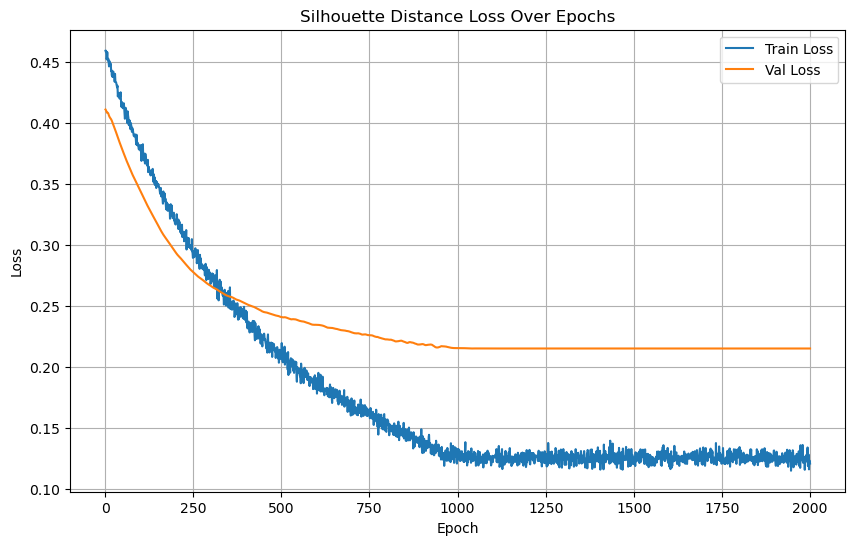

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/2312], Loss: 0.1063


Test Batch [20/2312], Loss: 0.1215
Test Batch [30/2312], Loss: 0.5000
Test Batch [40/2312], Loss: 0.0467
Test Batch [50/2312], Loss: 0.5000


Test Batch [60/2312], Loss: 0.5000
Test Batch [70/2312], Loss: 0.5000
Test Batch [80/2312], Loss: 0.1051


Test Batch [90/2312], Loss: 0.5000
Test Batch [100/2312], Loss: 0.0442
Test Batch [110/2312], Loss: 0.5000
Test Batch [120/2312], Loss: 0.0698


Test Batch [130/2312], Loss: 0.5000
Test Batch [140/2312], Loss: 0.5000


Test Batch [150/2312], Loss: 0.5000
Test Batch [160/2312], Loss: 0.0697
Test Batch [170/2312], Loss: 0.5000
Test Batch [180/2312], Loss: 0.5000
Test Batch [190/2312], Loss: 0.5000


Test Batch [200/2312], Loss: 0.0890
Test Batch [210/2312], Loss: 0.5000
Test Batch [220/2312], Loss: 0.5000


Test Batch [230/2312], Loss: 0.0670
Test Batch [240/2312], Loss: 0.0292
Test Batch [250/2312], Loss: 0.1248
Test Batch [260/2312], Loss: 0.5000


Test Batch [270/2312], Loss: 0.5000
Test Batch [280/2312], Loss: 0.5000
Test Batch [290/2312], Loss: 0.0763


Test Batch [300/2312], Loss: 0.0656
Test Batch [310/2312], Loss: 0.5000
Test Batch [320/2312], Loss: 0.0622
Test Batch [330/2312], Loss: 0.5000


Test Batch [340/2312], Loss: 0.5000
Test Batch [350/2312], Loss: 0.0960
Test Batch [360/2312], Loss: 0.1143


Test Batch [370/2312], Loss: 0.1106
Test Batch [380/2312], Loss: 0.0660
Test Batch [390/2312], Loss: 0.0319
Test Batch [400/2312], Loss: 0.5000
Test Batch [410/2312], Loss: 0.0401


Test Batch [420/2312], Loss: 0.0518
Test Batch [430/2312], Loss: 0.1157


Test Batch [440/2312], Loss: 0.5000
Test Batch [450/2312], Loss: 0.0595
Test Batch [460/2312], Loss: 0.5000


Test Batch [470/2312], Loss: 0.0783
Test Batch [480/2312], Loss: 0.5000
Test Batch [490/2312], Loss: 0.0222


Test Batch [500/2312], Loss: 0.0332
Test Batch [510/2312], Loss: 0.0372
Test Batch [520/2312], Loss: 0.0670
Test Batch [530/2312], Loss: 0.5000


Test Batch [540/2312], Loss: 0.5000
Test Batch [550/2312], Loss: 0.0747


Test Batch [560/2312], Loss: 0.5000
Test Batch [570/2312], Loss: 0.5000
Test Batch [580/2312], Loss: 0.0424
Test Batch [590/2312], Loss: 0.0510


Test Batch [600/2312], Loss: 0.5000
Test Batch [610/2312], Loss: 0.5000


Test Batch [620/2312], Loss: 0.0749
Test Batch [630/2312], Loss: 0.0163
Test Batch [640/2312], Loss: 0.1079


Test Batch [650/2312], Loss: 0.5000
Test Batch [660/2312], Loss: 0.0785


Test Batch [670/2312], Loss: 0.0612
Test Batch [680/2312], Loss: 0.5000
Test Batch [690/2312], Loss: 0.0522
Test Batch [700/2312], Loss: 0.0938
Test Batch [710/2312], Loss: 0.5000


Test Batch [720/2312], Loss: 0.5000


Test Batch [730/2312], Loss: 0.0273
Test Batch [740/2312], Loss: 0.5000
Test Batch [750/2312], Loss: 0.1090
Test Batch [760/2312], Loss: 0.0637
Test Batch [770/2312], Loss: 0.5000


Test Batch [780/2312], Loss: 0.5000
Test Batch [790/2312], Loss: 0.0319
Test Batch [800/2312], Loss: 0.0835
Test Batch [810/2312], Loss: 0.5000
Test Batch [820/2312], Loss: 0.0974


Test Batch [830/2312], Loss: 0.5000
Test Batch [840/2312], Loss: 0.0408
Test Batch [850/2312], Loss: 0.2200
Test Batch [860/2312], Loss: 0.0222
Test Batch [870/2312], Loss: 0.1227
Test Batch [880/2312], Loss: 0.0309
Test Batch [890/2312], Loss: 0.5000


Test Batch [900/2312], Loss: 0.5000
Test Batch [910/2312], Loss: 0.5000
Test Batch [920/2312], Loss: 0.0245
Test Batch [930/2312], Loss: 0.0952
Test Batch [940/2312], Loss: 0.0727
Test Batch [950/2312], Loss: 0.5000
Test Batch [960/2312], Loss: 0.5000
Test Batch [970/2312], Loss: 0.5000


Test Batch [980/2312], Loss: 0.0361
Test Batch [990/2312], Loss: 0.0536
Test Batch [1000/2312], Loss: 0.0403
Test Batch [1010/2312], Loss: 0.0380
Test Batch [1020/2312], Loss: 0.1268
Test Batch [1030/2312], Loss: 0.5000


Test Batch [1040/2312], Loss: 0.0674
Test Batch [1050/2312], Loss: 0.0719
Test Batch [1060/2312], Loss: 0.0419
Test Batch [1070/2312], Loss: 0.0455
Test Batch [1080/2312], Loss: 0.0293
Test Batch [1090/2312], Loss: 0.0843


Test Batch [1100/2312], Loss: 0.1486
Test Batch [1110/2312], Loss: 0.1231
Test Batch [1120/2312], Loss: 0.0353
Test Batch [1130/2312], Loss: 0.0632
Test Batch [1140/2312], Loss: 0.0236


Test Batch [1150/2312], Loss: 0.0213
Test Batch [1160/2312], Loss: 0.0504
Test Batch [1170/2312], Loss: 0.0605
Test Batch [1180/2312], Loss: 0.1274


Test Batch [1190/2312], Loss: 0.0533
Test Batch [1200/2312], Loss: 0.1093
Test Batch [1210/2312], Loss: 0.0785
Test Batch [1220/2312], Loss: 0.1494


Test Batch [1230/2312], Loss: 0.1163
Test Batch [1240/2312], Loss: 0.5000
Test Batch [1250/2312], Loss: 0.5000
Test Batch [1260/2312], Loss: 0.0324
Test Batch [1270/2312], Loss: 0.0534


Test Batch [1280/2312], Loss: 0.1668
Test Batch [1290/2312], Loss: 0.5000
Test Batch [1300/2312], Loss: 0.1106
Test Batch [1310/2312], Loss: 0.0539


Test Batch [1320/2312], Loss: 0.1138
Test Batch [1330/2312], Loss: 0.0572
Test Batch [1340/2312], Loss: 0.0305
Test Batch [1350/2312], Loss: 0.1176


Test Batch [1360/2312], Loss: 0.1938
Test Batch [1370/2312], Loss: 0.1374
Test Batch [1380/2312], Loss: 0.1010


Test Batch [1390/2312], Loss: 0.0716
Test Batch [1400/2312], Loss: 0.0837
Test Batch [1410/2312], Loss: 0.0836


Test Batch [1420/2312], Loss: 0.0719
Test Batch [1430/2312], Loss: 0.5000
Test Batch [1440/2312], Loss: 0.0995
Test Batch [1450/2312], Loss: 0.5000


Test Batch [1460/2312], Loss: 0.0829
Test Batch [1470/2312], Loss: 0.0781
Test Batch [1480/2312], Loss: 0.1069
Test Batch [1490/2312], Loss: 0.1023


Test Batch [1500/2312], Loss: 0.0526
Test Batch [1510/2312], Loss: 0.0688
Test Batch [1520/2312], Loss: 0.5000
Test Batch [1530/2312], Loss: 0.0656


Test Batch [1540/2312], Loss: 0.1113
Test Batch [1550/2312], Loss: 0.0828
Test Batch [1560/2312], Loss: 0.0572


Test Batch [1570/2312], Loss: 0.0734
Test Batch [1580/2312], Loss: 0.0792
Test Batch [1590/2312], Loss: 0.1333
Test Batch [1600/2312], Loss: 0.0658


Test Batch [1610/2312], Loss: 0.0726
Test Batch [1620/2312], Loss: 0.1512
Test Batch [1630/2312], Loss: 0.1129
Test Batch [1640/2312], Loss: 0.0821


Test Batch [1650/2312], Loss: 0.0360
Test Batch [1660/2312], Loss: 0.0873
Test Batch [1670/2312], Loss: 0.1539
Test Batch [1680/2312], Loss: 0.1299


Test Batch [1690/2312], Loss: 0.1864
Test Batch [1700/2312], Loss: 0.1498
Test Batch [1710/2312], Loss: 0.0953
Test Batch [1720/2312], Loss: 0.0379
Test Batch [1730/2312], Loss: 0.5000


Test Batch [1740/2312], Loss: 0.5000
Test Batch [1750/2312], Loss: 0.0533
Test Batch [1760/2312], Loss: 0.0720
Test Batch [1770/2312], Loss: 0.0448
Test Batch [1780/2312], Loss: 0.0609
Test Batch [1790/2312], Loss: 0.0871


Test Batch [1800/2312], Loss: 0.0633
Test Batch [1810/2312], Loss: 0.0725
Test Batch [1820/2312], Loss: 0.0934
Test Batch [1830/2312], Loss: 0.0353
Test Batch [1840/2312], Loss: 0.0834
Test Batch [1850/2312], Loss: 0.0795


Test Batch [1860/2312], Loss: 0.0874
Test Batch [1870/2312], Loss: 0.1381
Test Batch [1880/2312], Loss: 0.0797
Test Batch [1890/2312], Loss: 0.5000
Test Batch [1900/2312], Loss: 0.1084


Test Batch [1910/2312], Loss: 0.1011
Test Batch [1920/2312], Loss: 0.1678
Test Batch [1930/2312], Loss: 0.1230
Test Batch [1940/2312], Loss: 0.1058
Test Batch [1950/2312], Loss: 0.0582
Test Batch [1960/2312], Loss: 0.1326


Test Batch [1970/2312], Loss: 0.0951
Test Batch [1980/2312], Loss: 0.0617
Test Batch [1990/2312], Loss: 0.0456
Test Batch [2000/2312], Loss: 0.0627
Test Batch [2010/2312], Loss: 0.0446
Test Batch [2020/2312], Loss: 0.0551
Test Batch [2030/2312], Loss: 0.0414


Test Batch [2040/2312], Loss: 0.1078
Test Batch [2050/2312], Loss: 0.1260
Test Batch [2060/2312], Loss: 0.1721
Test Batch [2070/2312], Loss: 0.1141
Test Batch [2080/2312], Loss: 0.5000
Test Batch [2090/2312], Loss: 0.1039


Test Batch [2100/2312], Loss: 0.1697
Test Batch [2110/2312], Loss: 0.1179
Test Batch [2120/2312], Loss: 0.1482
Test Batch [2130/2312], Loss: 0.0359
Test Batch [2140/2312], Loss: 0.0728
Test Batch [2150/2312], Loss: 0.2049


Test Batch [2160/2312], Loss: 0.5000
Test Batch [2170/2312], Loss: 0.5000
Test Batch [2180/2312], Loss: 0.0543
Test Batch [2190/2312], Loss: 0.5000
Test Batch [2200/2312], Loss: 0.5000


Test Batch [2210/2312], Loss: 0.5000
Test Batch [2220/2312], Loss: 0.0962
Test Batch [2230/2312], Loss: 0.0274
Test Batch [2240/2312], Loss: 0.1000
Test Batch [2250/2312], Loss: 0.0317
Test Batch [2260/2312], Loss: 0.5000


Test Batch [2270/2312], Loss: 0.1020
Test Batch [2280/2312], Loss: 0.5000
Test Batch [2290/2312], Loss: 0.0356
Test Batch [2300/2312], Loss: 0.5000
Test Batch [2310/2312], Loss: 0.5000

Test Loss: 0.2018


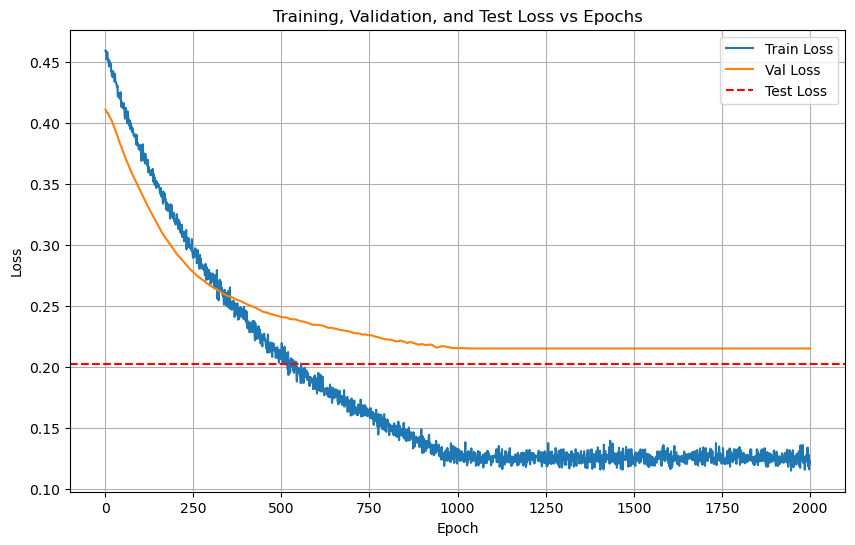

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/2312 for test dataset.
  Processed batch 20/2312 for test dataset.


  Processed batch 30/2312 for test dataset.
  Processed batch 40/2312 for test dataset.
  Processed batch 50/2312 for test dataset.
  Processed batch 60/2312 for test dataset.


  Processed batch 70/2312 for test dataset.
  Processed batch 80/2312 for test dataset.
  Processed batch 90/2312 for test dataset.


  Processed batch 100/2312 for test dataset.
  Processed batch 110/2312 for test dataset.
  Processed batch 120/2312 for test dataset.


  Processed batch 130/2312 for test dataset.
  Processed batch 140/2312 for test dataset.
  Processed batch 150/2312 for test dataset.


  Processed batch 160/2312 for test dataset.
  Processed batch 170/2312 for test dataset.
  Processed batch 180/2312 for test dataset.


  Processed batch 190/2312 for test dataset.
  Processed batch 200/2312 for test dataset.
  Processed batch 210/2312 for test dataset.


  Processed batch 220/2312 for test dataset.
  Processed batch 230/2312 for test dataset.
  Processed batch 240/2312 for test dataset.
  Processed batch 250/2312 for test dataset.


  Processed batch 260/2312 for test dataset.
  Processed batch 270/2312 for test dataset.
  Processed batch 280/2312 for test dataset.
  Processed batch 290/2312 for test dataset.


  Processed batch 300/2312 for test dataset.
  Processed batch 310/2312 for test dataset.
  Processed batch 320/2312 for test dataset.
  Processed batch 330/2312 for test dataset.


  Processed batch 340/2312 for test dataset.
  Processed batch 350/2312 for test dataset.
  Processed batch 360/2312 for test dataset.
  Processed batch 370/2312 for test dataset.


  Processed batch 380/2312 for test dataset.
  Processed batch 390/2312 for test dataset.
  Processed batch 400/2312 for test dataset.
  Processed batch 410/2312 for test dataset.


  Processed batch 420/2312 for test dataset.
  Processed batch 430/2312 for test dataset.
  Processed batch 440/2312 for test dataset.
  Processed batch 450/2312 for test dataset.


  Processed batch 460/2312 for test dataset.
  Processed batch 470/2312 for test dataset.
  Processed batch 480/2312 for test dataset.
  Processed batch 490/2312 for test dataset.


  Processed batch 500/2312 for test dataset.
  Processed batch 510/2312 for test dataset.
  Processed batch 520/2312 for test dataset.
  Processed batch 530/2312 for test dataset.


  Processed batch 540/2312 for test dataset.
  Processed batch 550/2312 for test dataset.
  Processed batch 560/2312 for test dataset.
  Processed batch 570/2312 for test dataset.


  Processed batch 580/2312 for test dataset.
  Processed batch 590/2312 for test dataset.
  Processed batch 600/2312 for test dataset.
  Processed batch 610/2312 for test dataset.


  Processed batch 620/2312 for test dataset.
  Processed batch 630/2312 for test dataset.
  Processed batch 640/2312 for test dataset.
  Processed batch 650/2312 for test dataset.


  Processed batch 660/2312 for test dataset.
  Processed batch 670/2312 for test dataset.
  Processed batch 680/2312 for test dataset.


  Processed batch 690/2312 for test dataset.
  Processed batch 700/2312 for test dataset.
  Processed batch 710/2312 for test dataset.


  Processed batch 720/2312 for test dataset.
  Processed batch 730/2312 for test dataset.
  Processed batch 740/2312 for test dataset.


  Processed batch 750/2312 for test dataset.
  Processed batch 760/2312 for test dataset.
  Processed batch 770/2312 for test dataset.


  Processed batch 780/2312 for test dataset.
  Processed batch 790/2312 for test dataset.
  Processed batch 800/2312 for test dataset.


  Processed batch 810/2312 for test dataset.
  Processed batch 820/2312 for test dataset.
  Processed batch 830/2312 for test dataset.
  Processed batch 840/2312 for test dataset.


  Processed batch 850/2312 for test dataset.
  Processed batch 860/2312 for test dataset.
  Processed batch 870/2312 for test dataset.


  Processed batch 880/2312 for test dataset.
  Processed batch 890/2312 for test dataset.
  Processed batch 900/2312 for test dataset.
  Processed batch 910/2312 for test dataset.


  Processed batch 920/2312 for test dataset.
  Processed batch 930/2312 for test dataset.
  Processed batch 940/2312 for test dataset.
  Processed batch 950/2312 for test dataset.


  Processed batch 960/2312 for test dataset.
  Processed batch 970/2312 for test dataset.
  Processed batch 980/2312 for test dataset.
  Processed batch 990/2312 for test dataset.


  Processed batch 1000/2312 for test dataset.
  Processed batch 1010/2312 for test dataset.
  Processed batch 1020/2312 for test dataset.


  Processed batch 1030/2312 for test dataset.
  Processed batch 1040/2312 for test dataset.
  Processed batch 1050/2312 for test dataset.


  Processed batch 1060/2312 for test dataset.
  Processed batch 1070/2312 for test dataset.
  Processed batch 1080/2312 for test dataset.
  Processed batch 1090/2312 for test dataset.


  Processed batch 1100/2312 for test dataset.
  Processed batch 1110/2312 for test dataset.
  Processed batch 1120/2312 for test dataset.


  Processed batch 1130/2312 for test dataset.
  Processed batch 1140/2312 for test dataset.
  Processed batch 1150/2312 for test dataset.
  Processed batch 1160/2312 for test dataset.


  Processed batch 1170/2312 for test dataset.
  Processed batch 1180/2312 for test dataset.
  Processed batch 1190/2312 for test dataset.
  Processed batch 1200/2312 for test dataset.


  Processed batch 1210/2312 for test dataset.
  Processed batch 1220/2312 for test dataset.
  Processed batch 1230/2312 for test dataset.
  Processed batch 1240/2312 for test dataset.


  Processed batch 1250/2312 for test dataset.
  Processed batch 1260/2312 for test dataset.
  Processed batch 1270/2312 for test dataset.


  Processed batch 1280/2312 for test dataset.
  Processed batch 1290/2312 for test dataset.
  Processed batch 1300/2312 for test dataset.


  Processed batch 1310/2312 for test dataset.
  Processed batch 1320/2312 for test dataset.
  Processed batch 1330/2312 for test dataset.


  Processed batch 1340/2312 for test dataset.
  Processed batch 1350/2312 for test dataset.
  Processed batch 1360/2312 for test dataset.


  Processed batch 1370/2312 for test dataset.
  Processed batch 1380/2312 for test dataset.
  Processed batch 1390/2312 for test dataset.
  Processed batch 1400/2312 for test dataset.


  Processed batch 1410/2312 for test dataset.
  Processed batch 1420/2312 for test dataset.
  Processed batch 1430/2312 for test dataset.
  Processed batch 1440/2312 for test dataset.


  Processed batch 1450/2312 for test dataset.
  Processed batch 1460/2312 for test dataset.
  Processed batch 1470/2312 for test dataset.


  Processed batch 1480/2312 for test dataset.
  Processed batch 1490/2312 for test dataset.
  Processed batch 1500/2312 for test dataset.


  Processed batch 1510/2312 for test dataset.
  Processed batch 1520/2312 for test dataset.
  Processed batch 1530/2312 for test dataset.


  Processed batch 1540/2312 for test dataset.
  Processed batch 1550/2312 for test dataset.
  Processed batch 1560/2312 for test dataset.


  Processed batch 1570/2312 for test dataset.
  Processed batch 1580/2312 for test dataset.
  Processed batch 1590/2312 for test dataset.


  Processed batch 1600/2312 for test dataset.
  Processed batch 1610/2312 for test dataset.
  Processed batch 1620/2312 for test dataset.


  Processed batch 1630/2312 for test dataset.


  Processed batch 1640/2312 for test dataset.
  Processed batch 1650/2312 for test dataset.
  Processed batch 1660/2312 for test dataset.
  Processed batch 1670/2312 for test dataset.


  Processed batch 1680/2312 for test dataset.
  Processed batch 1690/2312 for test dataset.
  Processed batch 1700/2312 for test dataset.
  Processed batch 1710/2312 for test dataset.


  Processed batch 1720/2312 for test dataset.
  Processed batch 1730/2312 for test dataset.
  Processed batch 1740/2312 for test dataset.
  Processed batch 1750/2312 for test dataset.


  Processed batch 1760/2312 for test dataset.
  Processed batch 1770/2312 for test dataset.
  Processed batch 1780/2312 for test dataset.


  Processed batch 1790/2312 for test dataset.
  Processed batch 1800/2312 for test dataset.
  Processed batch 1810/2312 for test dataset.


  Processed batch 1820/2312 for test dataset.
  Processed batch 1830/2312 for test dataset.
  Processed batch 1840/2312 for test dataset.


  Processed batch 1850/2312 for test dataset.
  Processed batch 1860/2312 for test dataset.
  Processed batch 1870/2312 for test dataset.
  Processed batch 1880/2312 for test dataset.


  Processed batch 1890/2312 for test dataset.
  Processed batch 1900/2312 for test dataset.
  Processed batch 1910/2312 for test dataset.
  Processed batch 1920/2312 for test dataset.


  Processed batch 1930/2312 for test dataset.
  Processed batch 1940/2312 for test dataset.
  Processed batch 1950/2312 for test dataset.
  Processed batch 1960/2312 for test dataset.


  Processed batch 1970/2312 for test dataset.
  Processed batch 1980/2312 for test dataset.
  Processed batch 1990/2312 for test dataset.


  Processed batch 2000/2312 for test dataset.
  Processed batch 2010/2312 for test dataset.
  Processed batch 2020/2312 for test dataset.


  Processed batch 2030/2312 for test dataset.
  Processed batch 2040/2312 for test dataset.
  Processed batch 2050/2312 for test dataset.
  Processed batch 2060/2312 for test dataset.


  Processed batch 2070/2312 for test dataset.
  Processed batch 2080/2312 for test dataset.
  Processed batch 2090/2312 for test dataset.


  Processed batch 2100/2312 for test dataset.
  Processed batch 2110/2312 for test dataset.
  Processed batch 2120/2312 for test dataset.


  Processed batch 2130/2312 for test dataset.
  Processed batch 2140/2312 for test dataset.
  Processed batch 2150/2312 for test dataset.


  Processed batch 2160/2312 for test dataset.
  Processed batch 2170/2312 for test dataset.
  Processed batch 2180/2312 for test dataset.


  Processed batch 2190/2312 for test dataset.
  Processed batch 2200/2312 for test dataset.
  Processed batch 2210/2312 for test dataset.
  Processed batch 2220/2312 for test dataset.


  Processed batch 2230/2312 for test dataset.
  Processed batch 2240/2312 for test dataset.
  Processed batch 2250/2312 for test dataset.


  Processed batch 2260/2312 for test dataset.
  Processed batch 2270/2312 for test dataset.
  Processed batch 2280/2312 for test dataset.
  Processed batch 2290/2312 for test dataset.


  Processed batch 2300/2312 for test dataset.
  Processed batch 2310/2312 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147927, 128)
Test labels shape: (147927,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 91.11%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      0.60      0.75         5
           3       0.83      1.00      0.91         5
           4       0.80      0.80      0.80         5
           5       0.80      0.80      0.80         5
           6       0.83      1.00      0.91         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45


LOG: Evaluating on the test set...
Test Accuracy: 96.50%

Test Classifica

Saved SCL_SDL+LRM predictions and true labels to model_predictions


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147927, 128)
Test labels shape: (147927,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.2815  |  Val Loss: 2.1808
Validation loss improved from inf to 2.1808.
[Epoch 2/1000] Train Loss: 2.2088  |  Val Loss: 2.1243
Validation loss improved from 2.1808 to 2.1243.
[Epoch 3/1000] Train Loss: 2.1439  |  Val Loss: 2.0721
Validation loss improved from 2.1243 to 2.0721.
[Epoch 4/1000] Train Loss: 2.0802  |  Val Loss: 2.0232
Validation loss improved from 2.0721 to 2.0232.
[Epoch 5/1000] Train Loss: 2.0253  |  Val Loss: 1.9791
Validation loss improved from 2.0232 to 1.9791.
[Epoch 6/1000] Train Loss: 1.9744  |  Val Loss: 1.9423
Validation loss improved from 1.9791 to 1.9423.
[Epoch 7/1000] Train Loss: 1.9288  |  Val Loss: 1.9090
Validation loss improved from 1.9423 to 1.9090.
[Epoch 8/1000] Train Loss: 1.8864  |  Val Loss: 1.8768
Validation loss improved from 1.9090 to 1.8768.
[Epoch 9/1000] Train Loss: 1.8484  |  Val Loss: 1.8453
Validation loss improved from 1.8768 to 1.8453.
[Epoch 10/1000] Train Loss: 1.8086  |  Val Loss: 1.8151
Validation loss impr

[Epoch 25/1000] Train Loss: 1.3581  |  Val Loss: 1.4467
Validation loss improved from 1.4696 to 1.4467.
[Epoch 26/1000] Train Loss: 1.3324  |  Val Loss: 1.4243
Validation loss improved from 1.4467 to 1.4243.
[Epoch 27/1000] Train Loss: 1.3077  |  Val Loss: 1.4026
Validation loss improved from 1.4243 to 1.4026.
[Epoch 28/1000] Train Loss: 1.2831  |  Val Loss: 1.3818
Validation loss improved from 1.4026 to 1.3818.
[Epoch 29/1000] Train Loss: 1.2603  |  Val Loss: 1.3610
Validation loss improved from 1.3818 to 1.3610.
[Epoch 30/1000] Train Loss: 1.2369  |  Val Loss: 1.3407
Validation loss improved from 1.3610 to 1.3407.
[Epoch 31/1000] Train Loss: 1.2137  |  Val Loss: 1.3208
Validation loss improved from 1.3407 to 1.3208.
[Epoch 32/1000] Train Loss: 1.1918  |  Val Loss: 1.3010
Validation loss improved from 1.3208 to 1.3010.


[Epoch 33/1000] Train Loss: 1.1697  |  Val Loss: 1.2817
Validation loss improved from 1.3010 to 1.2817.
[Epoch 34/1000] Train Loss: 1.1479  |  Val Loss: 1.2626
Validation loss improved from 1.2817 to 1.2626.
[Epoch 35/1000] Train Loss: 1.1263  |  Val Loss: 1.2437
Validation loss improved from 1.2626 to 1.2437.
[Epoch 36/1000] Train Loss: 1.1053  |  Val Loss: 1.2252
Validation loss improved from 1.2437 to 1.2252.
[Epoch 37/1000] Train Loss: 1.0849  |  Val Loss: 1.2068
Validation loss improved from 1.2252 to 1.2068.
[Epoch 38/1000] Train Loss: 1.0644  |  Val Loss: 1.1887
Validation loss improved from 1.2068 to 1.1887.
[Epoch 39/1000] Train Loss: 1.0443  |  Val Loss: 1.1711
Validation loss improved from 1.1887 to 1.1711.
[Epoch 40/1000] Train Loss: 1.0246  |  Val Loss: 1.1540
Validation loss improved from 1.1711 to 1.1540.
[Epoch 41/1000] Train Loss: 1.0055  |  Val Loss: 1.1371
Validation loss improved from 1.1540 to 1.1371.
[Epoch 42/1000] Train Loss: 0.9868  |  Val Loss: 1.1203
Validati

[Epoch 57/1000] Train Loss: 0.7250  |  Val Loss: 0.8828
Validation loss improved from 0.8969 to 0.8828.
[Epoch 58/1000] Train Loss: 0.7102  |  Val Loss: 0.8690
Validation loss improved from 0.8828 to 0.8690.
[Epoch 59/1000] Train Loss: 0.6954  |  Val Loss: 0.8555
Validation loss improved from 0.8690 to 0.8555.
[Epoch 60/1000] Train Loss: 0.6804  |  Val Loss: 0.8423
Validation loss improved from 0.8555 to 0.8423.
[Epoch 61/1000] Train Loss: 0.6666  |  Val Loss: 0.8294
Validation loss improved from 0.8423 to 0.8294.
[Epoch 62/1000] Train Loss: 0.6528  |  Val Loss: 0.8170
Validation loss improved from 0.8294 to 0.8170.
[Epoch 63/1000] Train Loss: 0.6395  |  Val Loss: 0.8049
Validation loss improved from 0.8170 to 0.8049.
[Epoch 64/1000] Train Loss: 0.6268  |  Val Loss: 0.7931
Validation loss improved from 0.8049 to 0.7931.


[Epoch 65/1000] Train Loss: 0.6142  |  Val Loss: 0.7817
Validation loss improved from 0.7931 to 0.7817.
[Epoch 66/1000] Train Loss: 0.6026  |  Val Loss: 0.7705
Validation loss improved from 0.7817 to 0.7705.
[Epoch 67/1000] Train Loss: 0.5904  |  Val Loss: 0.7599
Validation loss improved from 0.7705 to 0.7599.
[Epoch 68/1000] Train Loss: 0.5793  |  Val Loss: 0.7495
Validation loss improved from 0.7599 to 0.7495.
[Epoch 69/1000] Train Loss: 0.5681  |  Val Loss: 0.7395
Validation loss improved from 0.7495 to 0.7395.
[Epoch 70/1000] Train Loss: 0.5574  |  Val Loss: 0.7298
Validation loss improved from 0.7395 to 0.7298.
[Epoch 71/1000] Train Loss: 0.5463  |  Val Loss: 0.7203
Validation loss improved from 0.7298 to 0.7203.
[Epoch 72/1000] Train Loss: 0.5364  |  Val Loss: 0.7111
Validation loss improved from 0.7203 to 0.7111.
[Epoch 73/1000] Train Loss: 0.5259  |  Val Loss: 0.7019
Validation loss improved from 0.7111 to 0.7019.
[Epoch 74/1000] Train Loss: 0.5160  |  Val Loss: 0.6930
Validati

[Epoch 87/1000] Train Loss: 0.3903  |  Val Loss: 0.5795
Validation loss improved from 0.5887 to 0.5795.
[Epoch 88/1000] Train Loss: 0.3805  |  Val Loss: 0.5708
Validation loss improved from 0.5795 to 0.5708.
[Epoch 89/1000] Train Loss: 0.3701  |  Val Loss: 0.5626
Validation loss improved from 0.5708 to 0.5626.
[Epoch 90/1000] Train Loss: 0.3607  |  Val Loss: 0.5547
Validation loss improved from 0.5626 to 0.5547.
[Epoch 91/1000] Train Loss: 0.3518  |  Val Loss: 0.5471
Validation loss improved from 0.5547 to 0.5471.
[Epoch 92/1000] Train Loss: 0.3432  |  Val Loss: 0.5399
Validation loss improved from 0.5471 to 0.5399.
[Epoch 93/1000] Train Loss: 0.3345  |  Val Loss: 0.5332
Validation loss improved from 0.5399 to 0.5332.
[Epoch 94/1000] Train Loss: 0.3257  |  Val Loss: 0.5268
Validation loss improved from 0.5332 to 0.5268.
[Epoch 95/1000] Train Loss: 0.3180  |  Val Loss: 0.5208
Validation loss improved from 0.5268 to 0.5208.
[Epoch 96/1000] Train Loss: 0.3101  |  Val Loss: 0.5149
Validati

[Epoch 97/1000] Train Loss: 0.3029  |  Val Loss: 0.5093
Validation loss improved from 0.5149 to 0.5093.
[Epoch 98/1000] Train Loss: 0.2956  |  Val Loss: 0.5042
Validation loss improved from 0.5093 to 0.5042.
[Epoch 99/1000] Train Loss: 0.2887  |  Val Loss: 0.4992
Validation loss improved from 0.5042 to 0.4992.
[Epoch 100/1000] Train Loss: 0.2818  |  Val Loss: 0.4944
Validation loss improved from 0.4992 to 0.4944.
[Epoch 101/1000] Train Loss: 0.2756  |  Val Loss: 0.4899
Validation loss improved from 0.4944 to 0.4899.
[Epoch 102/1000] Train Loss: 0.2692  |  Val Loss: 0.4856
Validation loss improved from 0.4899 to 0.4856.
[Epoch 103/1000] Train Loss: 0.2631  |  Val Loss: 0.4813
Validation loss improved from 0.4856 to 0.4813.
[Epoch 104/1000] Train Loss: 0.2574  |  Val Loss: 0.4771
Validation loss improved from 0.4813 to 0.4771.
[Epoch 105/1000] Train Loss: 0.2518  |  Val Loss: 0.4734
Validation loss improved from 0.4771 to 0.4734.
[Epoch 106/1000] Train Loss: 0.2462  |  Val Loss: 0.4694
V

[Epoch 121/1000] Train Loss: 0.1809  |  Val Loss: 0.4264
Validation loss improved from 0.4285 to 0.4264.
[Epoch 122/1000] Train Loss: 0.1774  |  Val Loss: 0.4244
Validation loss improved from 0.4264 to 0.4244.
[Epoch 123/1000] Train Loss: 0.1739  |  Val Loss: 0.4225
Validation loss improved from 0.4244 to 0.4225.
[Epoch 124/1000] Train Loss: 0.1705  |  Val Loss: 0.4204
Validation loss improved from 0.4225 to 0.4204.
[Epoch 125/1000] Train Loss: 0.1672  |  Val Loss: 0.4186
Validation loss improved from 0.4204 to 0.4186.
[Epoch 126/1000] Train Loss: 0.1641  |  Val Loss: 0.4169
Validation loss improved from 0.4186 to 0.4169.
[Epoch 127/1000] Train Loss: 0.1611  |  Val Loss: 0.4152
Validation loss improved from 0.4169 to 0.4152.
[Epoch 128/1000] Train Loss: 0.1580  |  Val Loss: 0.4135
Validation loss improved from 0.4152 to 0.4135.
[Epoch 129/1000] Train Loss: 0.1550  |  Val Loss: 0.4119
Validation loss improved from 0.4135 to 0.4119.
[Epoch 130/1000] Train Loss: 0.1521  |  Val Loss: 0.410

[Epoch 131/1000] Train Loss: 0.1493  |  Val Loss: 0.4088
Validation loss improved from 0.4104 to 0.4088.
[Epoch 132/1000] Train Loss: 0.1465  |  Val Loss: 0.4075
Validation loss improved from 0.4088 to 0.4075.
[Epoch 133/1000] Train Loss: 0.1439  |  Val Loss: 0.4062
Validation loss improved from 0.4075 to 0.4062.
[Epoch 134/1000] Train Loss: 0.1412  |  Val Loss: 0.4050
Validation loss improved from 0.4062 to 0.4050.
[Epoch 135/1000] Train Loss: 0.1386  |  Val Loss: 0.4037
Validation loss improved from 0.4050 to 0.4037.
[Epoch 136/1000] Train Loss: 0.1360  |  Val Loss: 0.4024
Validation loss improved from 0.4037 to 0.4024.
[Epoch 137/1000] Train Loss: 0.1336  |  Val Loss: 0.4012
Validation loss improved from 0.4024 to 0.4012.
[Epoch 138/1000] Train Loss: 0.1311  |  Val Loss: 0.4000
Validation loss improved from 0.4012 to 0.4000.
[Epoch 139/1000] Train Loss: 0.1288  |  Val Loss: 0.3987
Validation loss improved from 0.4000 to 0.3987.
[Epoch 140/1000] Train Loss: 0.1264  |  Val Loss: 0.397

[Epoch 154/1000] Train Loss: 0.0988  |  Val Loss: 0.3881
Validation loss improved from 0.3885 to 0.3881.
[Epoch 155/1000] Train Loss: 0.0971  |  Val Loss: 0.3876
Validation loss improved from 0.3881 to 0.3876.
[Epoch 156/1000] Train Loss: 0.0956  |  Val Loss: 0.3871
Validation loss improved from 0.3876 to 0.3871.
[Epoch 157/1000] Train Loss: 0.0940  |  Val Loss: 0.3866
Validation loss improved from 0.3871 to 0.3866.
[Epoch 158/1000] Train Loss: 0.0924  |  Val Loss: 0.3862
Validation loss improved from 0.3866 to 0.3862.
[Epoch 159/1000] Train Loss: 0.0909  |  Val Loss: 0.3857
Validation loss improved from 0.3862 to 0.3857.
[Epoch 160/1000] Train Loss: 0.0895  |  Val Loss: 0.3853
Validation loss improved from 0.3857 to 0.3853.
[Epoch 161/1000] Train Loss: 0.0880  |  Val Loss: 0.3848
Validation loss improved from 0.3853 to 0.3848.


[Epoch 162/1000] Train Loss: 0.0867  |  Val Loss: 0.3845
Validation loss improved from 0.3848 to 0.3845.
[Epoch 163/1000] Train Loss: 0.0852  |  Val Loss: 0.3843
Validation loss improved from 0.3845 to 0.3843.
[Epoch 164/1000] Train Loss: 0.0839  |  Val Loss: 0.3841
Validation loss improved from 0.3843 to 0.3841.
[Epoch 165/1000] Train Loss: 0.0826  |  Val Loss: 0.3837
Validation loss improved from 0.3841 to 0.3837.
[Epoch 166/1000] Train Loss: 0.0813  |  Val Loss: 0.3833
Validation loss improved from 0.3837 to 0.3833.
[Epoch 167/1000] Train Loss: 0.0801  |  Val Loss: 0.3832
Validation loss improved from 0.3833 to 0.3832.
[Epoch 168/1000] Train Loss: 0.0788  |  Val Loss: 0.3829
Validation loss improved from 0.3832 to 0.3829.
[Epoch 169/1000] Train Loss: 0.0777  |  Val Loss: 0.3826
Validation loss improved from 0.3829 to 0.3826.
[Epoch 170/1000] Train Loss: 0.0764  |  Val Loss: 0.3823
Validation loss improved from 0.3826 to 0.3823.
[Epoch 171/1000] Train Loss: 0.0752  |  Val Loss: 0.382

[Epoch 185/1000] Train Loss: 0.0614  |  Val Loss: 0.3803
Validation loss improved from 0.3804 to 0.3803.
[Epoch 186/1000] Train Loss: 0.0606  |  Val Loss: 0.3804
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 187/1000] Train Loss: 0.0597  |  Val Loss: 0.3805
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 188/1000] Train Loss: 0.0589  |  Val Loss: 0.3805
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 189/1000] Train Loss: 0.0581  |  Val Loss: 0.3805
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 190/1000] Train Loss: 0.0573  |  Val Loss: 0.3806
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 191/1000] Train Loss: 0.0565  |  Val Loss: 0.3806
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 192/1000] Train Loss: 0.0557  |  Val Loss: 0.3807
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 193/1000] Train Loss: 0.0549  |  Val Loss: 0.3808
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 195/1000] Train Loss: 0.0535  |  Val Loss: 0.3811
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 196/1000] Train Loss: 0.0528  |  Val Loss: 0.3814
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 197/1000] Train Loss: 0.0521  |  Val Loss: 0.3816
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 198/1000] Train Loss: 0.0514  |  Val Loss: 0.3817
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 199/1000] Train Loss: 0.0507  |  Val Loss: 0.3818
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 200/1000] Train Loss: 0.0500  |  Val Loss: 0.3821
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 201/1000] Train Loss: 0.0494  |  Val Loss: 0.3823
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 202/1000] Train Loss: 0.0488  |  Val Loss: 0.3825
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 203/1000] Train Loss: 0.0481  |  Val Loss: 0.3826
!! Validation loss did NOT improve !! Patience:

[Epoch 216/1000] Train Loss: 0.0407  |  Val Loss: 0.3874
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 217/1000] Train Loss: 0.0401  |  Val Loss: 0.3877
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 218/1000] Train Loss: 0.0397  |  Val Loss: 0.3884
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 219/1000] Train Loss: 0.0392  |  Val Loss: 0.3887
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 220/1000] Train Loss: 0.0387  |  Val Loss: 0.3891
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 221/1000] Train Loss: 0.0382  |  Val Loss: 0.3896
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 222/1000] Train Loss: 0.0377  |  Val Loss: 0.3900
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 223/1000] Train Loss: 0.0372  |  Val Loss: 0.3904
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 224/1000] Train Loss: 0.0368  |  Val Loss: 0.3908
!! Validation loss did NOT improve !! Patience:

[Epoch 225/1000] Train Loss: 0.0363  |  Val Loss: 0.3912
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 226/1000] Train Loss: 0.0359  |  Val Loss: 0.3916
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 227/1000] Train Loss: 0.0355  |  Val Loss: 0.3920
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 228/1000] Train Loss: 0.0350  |  Val Loss: 0.3925
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 229/1000] Train Loss: 0.0346  |  Val Loss: 0.3930
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 230/1000] Train Loss: 0.0342  |  Val Loss: 0.3936
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 231/1000] Train Loss: 0.0338  |  Val Loss: 0.3940
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 232/1000] Train Loss: 0.0334  |  Val Loss: 0.3946
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 233/1000] Train Loss: 0.0330  |  Val Loss: 0.3950
!! Validation loss did NOT improve !! Patience:

[Epoch 249/1000] Train Loss: 0.0275  |  Val Loss: 0.4030
!! Validation loss did NOT improve !! Patience: 64/100


[Epoch 250/1000] Train Loss: 0.0272  |  Val Loss: 0.4035
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 251/1000] Train Loss: 0.0269  |  Val Loss: 0.4040
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 252/1000] Train Loss: 0.0266  |  Val Loss: 0.4046
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 253/1000] Train Loss: 0.0263  |  Val Loss: 0.4050
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 254/1000] Train Loss: 0.0260  |  Val Loss: 0.4055
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 255/1000] Train Loss: 0.0257  |  Val Loss: 0.4061
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 256/1000] Train Loss: 0.0255  |  Val Loss: 0.4067
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 257/1000] Train Loss: 0.0252  |  Val Loss: 0.4072
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 258/1000] Train Loss: 0.0249  |  Val Loss: 0.4076
!! Validation loss did NOT improve !! Patience:

[Epoch 284/1000] Train Loss: 0.0192  |  Val Loss: 0.4213
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 285/1000] Train Loss: 0.0190  |  Val Loss: 0.4218
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 285 !!
No improvement for 100 epochs.


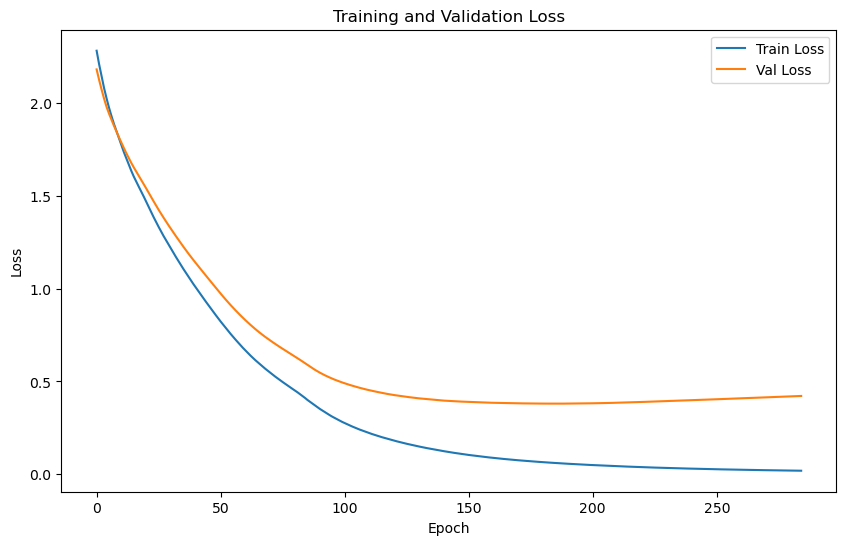

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.1721 | Test Accuracy: 96.54%


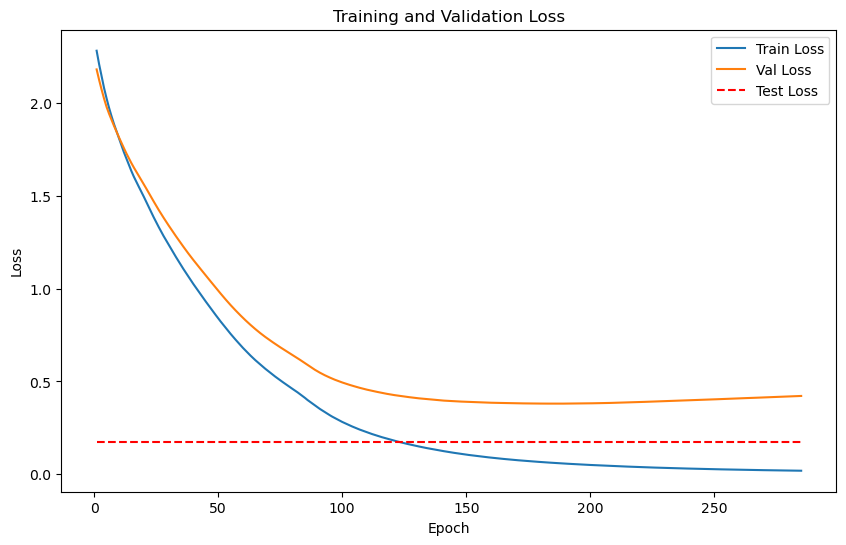

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


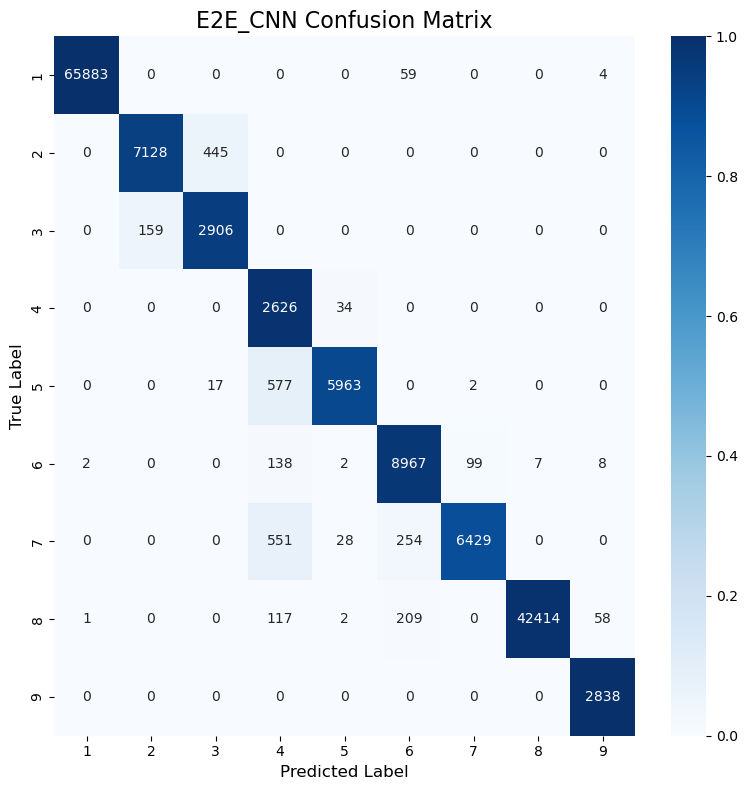

Classification Accuracy: 98.13%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


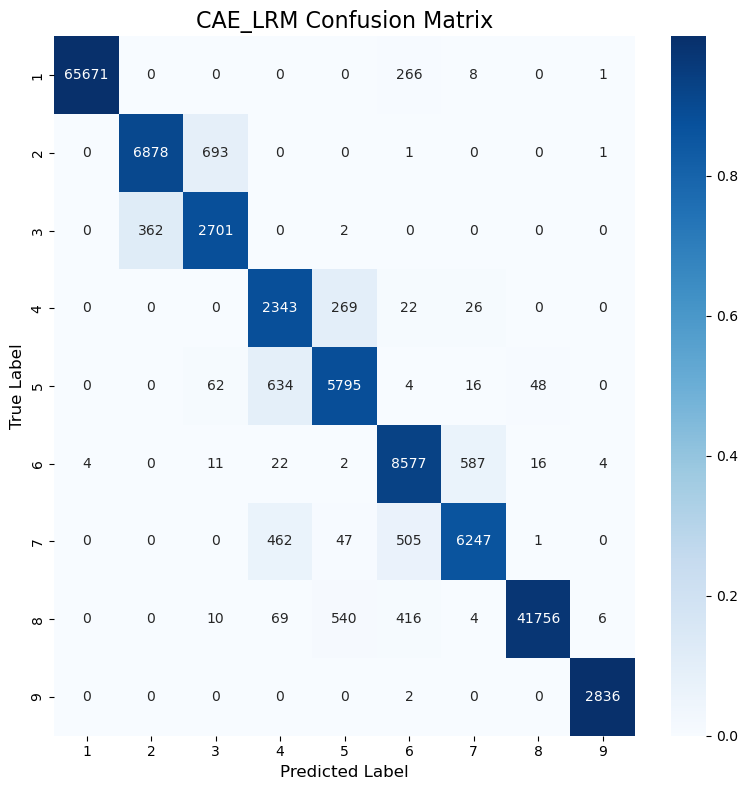

Classification Accuracy: 96.54%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


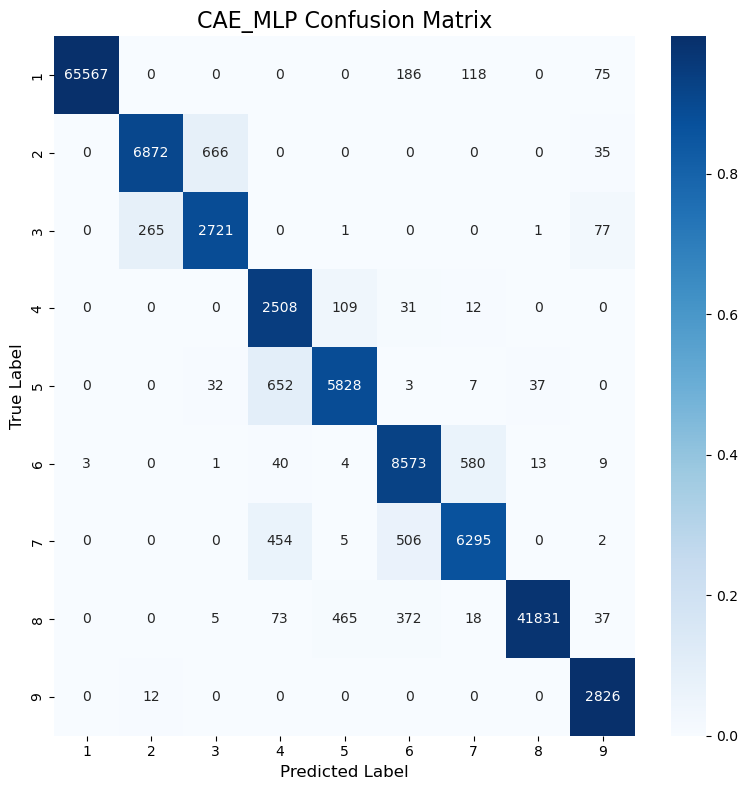

Classification Accuracy: 96.68%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


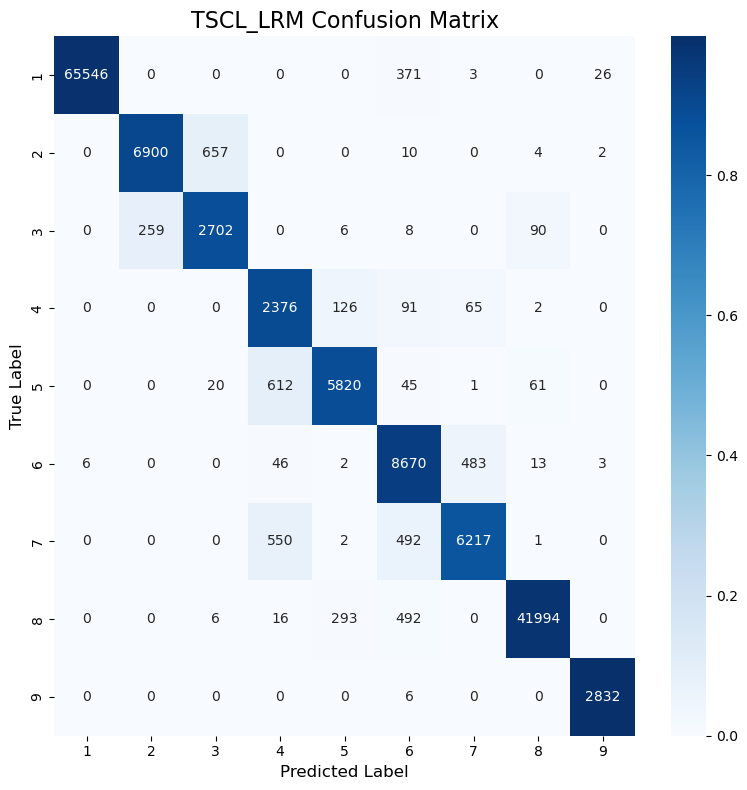

Classification Accuracy: 96.71%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


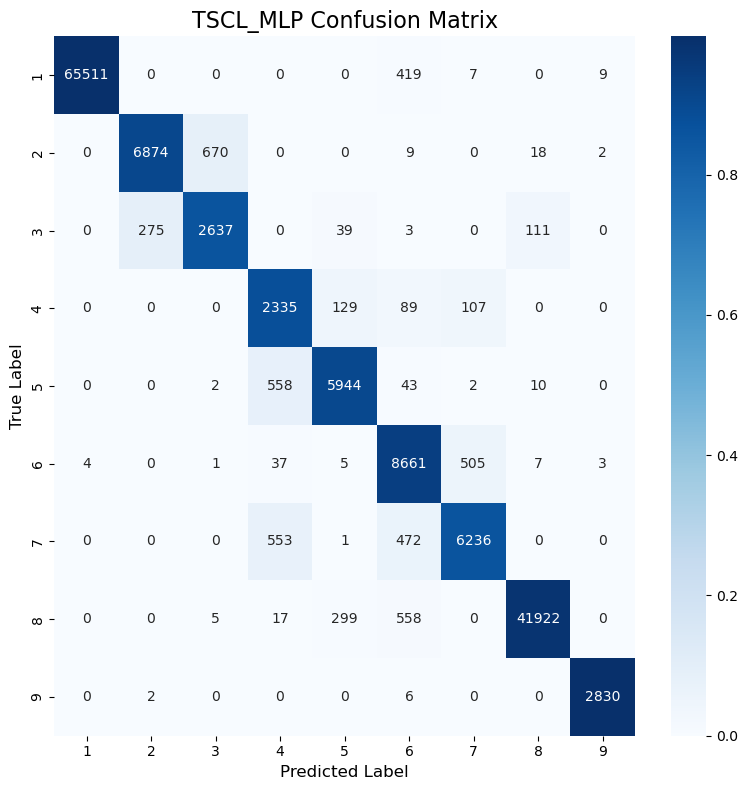

Classification Accuracy: 96.64%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


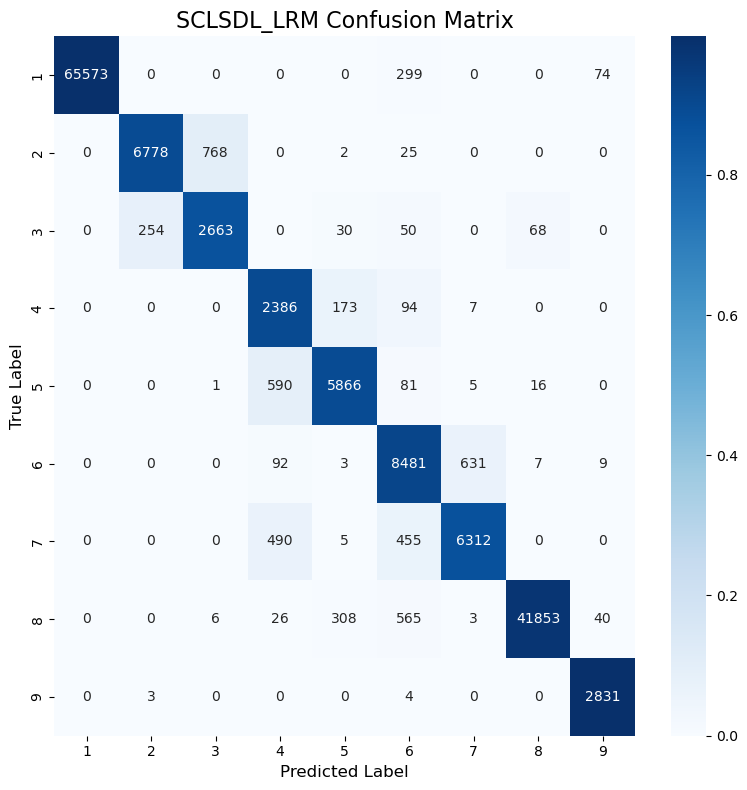

Classification Accuracy: 96.50%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


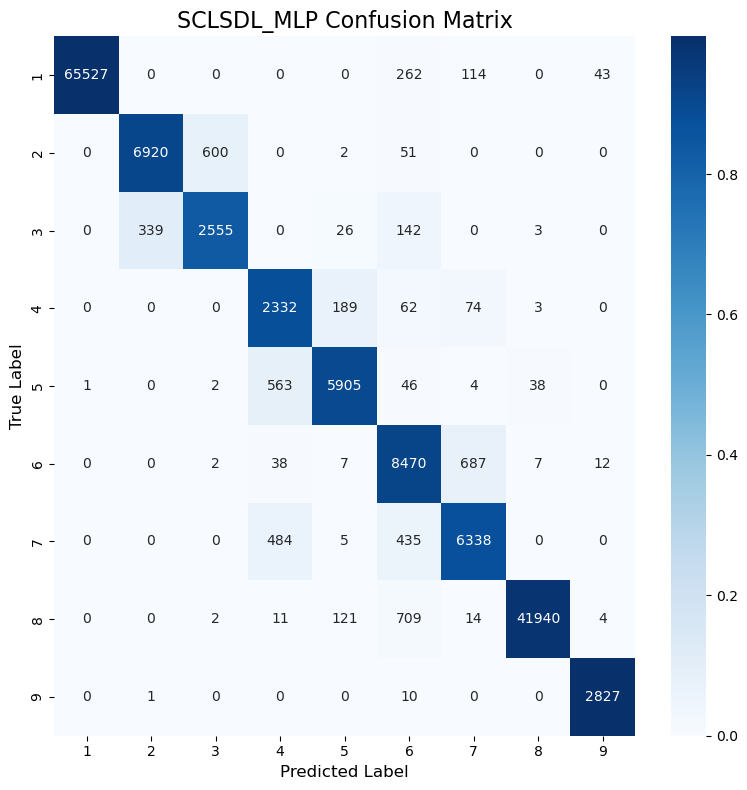

Classification Accuracy: 96.54%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          98.13
1    LRM (CAE)          96.54
2    MLP (CAE)          96.68
3     TSCL LRM          96.71
4     TSCL MLP          96.64
5  SCL_SDL LRM          96.50
6  SCL_SDL MLP          96.54

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          98.13
3     TSCL LRM          96.71
2    MLP (CAE)          96.68
4     TSCL MLP          96.64
6  SCL_SDL MLP          96.54
1    LRM (CAE)          96.54
5  SCL_SDL LRM          96.50
